# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


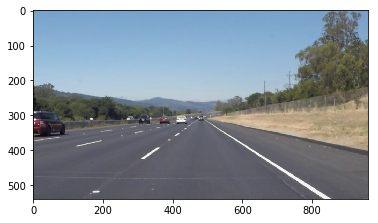

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: #Rgb coloured image
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else: #Gray image 1 channel
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


            
def draw_lines(img, lines, color=[255, 0, 0], thickness=9):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope =[]
    point1_left = [[],[]]
    point2_left = [[],[]]
    point1_right = [[],[]]
    point2_right = [[],[]]
    a_list_left = []
    b_list_left = []
    a_list_right = []
    b_list_right = []
    num_of_points_left = 0
    num_of_points_right = 0

    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculate slope
            #a, b = np.polyfit((x1,x2), (y1,y2), 1)
            #calculate b coefficient of y= ax + b line equation
            a = (y2-y1)/(x2-x1)
            #b = y1 - a*x1
            if 0.3 > a > -0.3:
                continue
            #separate left and right line by slope
            # a > 0: right line, a < 0: left line
            if a < 0:
                if x1 > 520:
                    continue
                point1_left[0].append(x1)
                point1_left[1].append(y1)
                point1_left[0].append(x2)
                point1_left[1].append(y2)
                a_list_left.append(a)
                #b_list_left.append(b)
                num_of_points_left = num_of_points_left + 1
                #cv2.circle(img,(x1,y1),8,[0,255,0],10)
                #cv2.circle(img,(x2,y2),8,[0,0,255],10)
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else:
                if x1 < 440:
                    continue
                point1_right[0].append(x1)
                point1_right[1].append(y1)
                point1_right[0].append(x2)
                point1_right[1].append(y2)
                a_list_right.append(a)
                #b_list_right.append(b)
                num_of_points_right = num_of_points_right + 1
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
   
    point1_left = np.array(point1_left)
    #point2_left = np.array(point2_left)
    a_list_left = np.array(a_list_left)
    b_list_left = np.array(b_list_left)
    x1_avg_left = int(np.mean(point1_left[0]))
    y1_avg_left = int(np.mean(point1_left[1]))
    a_avg_left = (np.mean(a_list_left))
    b_avg_left = y1_avg_left - a_avg_left*x1_avg_left
 
    point1_right = np.array(point1_right)
    #point2_right = np.array(point2_right)
    a_list_right = np.array(a_list_right)
    b_list_right = np.array(b_list_right)
    x1_avg_right = int(np.mean(point1_right[0]))
    y1_avg_right = int(np.mean(point1_right[1]))
    a_avg_right = (np.mean(a_list_right))
    b_avg_right = y1_avg_right - a_avg_right*x1_avg_right
    
    #find position of top and bottom points of the extrapolated points
    y3_left = 540 #y-coordinate = y-coordinate of region of interest
    x3_left = int(((y3_left-b_avg_left)/a_avg_left))
    y4_left = 320 #y-coordinate = y-coordinate of region of interest
    x4_left = int(((y4_left-b_avg_left)/a_avg_left))
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x2_avg_left, y2_avg_left), color, thickness)
    #cv2.line(img, (x1_avg_left, y1_avg_left), (x4_left,y4_left), color, thickness)
    cv2.line(img, (x4_left, y4_left), (x3_left, y3_left), color, thickness)
    
    y3_right = 540
    x3_right = int(((y3_right - b_avg_right)/a_avg_right))
    y4_right = 320
    x4_right = int(((y4_right - b_avg_right)/a_avg_right))
    #draw line from average position of (x1,y1),(x2,y2) to top and bottom points
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x2_avg_right, y2_avg_right), color, thickness)
    #cv2.line(img, (x1_avg_right, y1_avg_right), (x4_right,y4_right), color, thickness)
    cv2.line(img, (x4_right, y4_right), (x3_right, y3_right), color, thickness)
    print ("x3 = "+str(x3_left))
    print ('y3 ='+str(y3_left))
    print ('x4 =' + str(x4_left))
    print ('y4 =' +str(y4_left))
    print ('x1_list' + str(point1_left[0]))
    print ('y1_list' + str(point1_left[1]))
    print ('x2_list' + str(point2_left[0]))
    print ('y2_list' + str(point2_left[1]))
    print ('num_points_left' + str(num_of_points_left))
    print ('num_points_right' + str(num_of_points_right))
    print ('a_avg = ' + str(a_avg_left))
    print ('b_avg = ' + str(b_avg_left))
    print ('slope_left = ' + str(a_list_left))
    print ('slope_right ' + str(a_list_right))
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #slope = calculate_slope(lines)
    draw_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
x3 = 184
y3 =540
x4 =463
y4 =320
x1_list[383 462 280 344 292 354 290 353 388 468 281 327 386 464 281 345]
y1_list[382 322 462 410 462 412 463 412 382 322 460 423 383 324 462 410]
x2_list[]
y2_list[]
num_points_left8
num_points_right5
a_avg = -0.788903396976
b_avg = 685.849609324
slope_left = [-0.75949367 -0.8125     -0.80645161 -0.80952381 -0.75       -0.80434783
 -0.75641026 -0.8125    ]
slope_right [ 0.57636888  0.55279503  0.57817109  0.55319149  0.58333333]


(540, 960, 3)

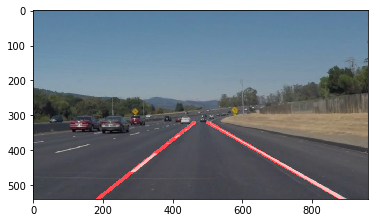

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#Gray scale image
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)
plt.imshow(blur_gray, cmap='gray')
# Define our parameters for Canny and apply
low_threshold = 30
high_threshold = 150
edges = canny(blur_gray,low_threshold,high_threshold)
plt.imshow(edges,cmap='Greys_r')
# This time we are defining a four sided polygon to mask
#xsize = imshape[1]
#ysize = imshape[0]
imshape = image.shape
top_mask_bound = 320
bottom_mask_bound = 540
vertices = np.array([[(0,imshape[0]),(450, top_mask_bound), (490,top_mask_bound), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges,vertices)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments
#Run hoghline detection on edges image
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


#Draw the line on the colour image
line_colored_image = weighted_img(line_image,image)
plt.imshow(line_colored_image)
image.shape


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [14]:
def process_image(image):
    
    #Gray scale image
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    plt.imshow(blur_gray, cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 200
    edges = canny(blur_gray,low_threshold,high_threshold)
    plt.imshow(edges,cmap='Greys_r')
    # This time we are defining a four sided polygon to mask
    #xsize = imshape[1]
    #ysize = imshape[0]
    imshape = image.shape
    top_mask_bound = 310
    bottom_mask_bound = 540
    vertices = np.array([[(0,imshape[0]),(450, top_mask_bound), (490,top_mask_bound), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/90 # angular resolution in radians of the Hough grid
    threshold = 10 #minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    #Run hoghline detection on edges image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)


    #Draw the line on the colour image
    line_colored_image = weighted_img(line_image,image)
    plt.imshow(line_colored_image)
   
    return line_colored_image

Let's try the one with the solid white lane on the right first ...

x3 = 160
y3 =540
x4 =456
y4 =320
x1_list[187 300 237 310 426 468 203 310 431 471 428 470 202 232 426 463 187 297
 426 452]
y1_list[513 431 489 432 340 310 514 431 342 313 343 313 514 491 343 314 512 432
 341 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.744425040627
b_avg = 659.571064057
slope_left = [-0.72566372 -0.78082192 -0.71428571 -0.77570093 -0.725      -0.71428571
 -0.76666667 -0.78378378 -0.72727273 -0.73076923]
slope_right [ 0.61875     0.62559242  0.62411348  0.624       0.61538462  0.61458333
  0.61870504  0.60784314  0.64        0.60714286  0.62765957  0.62962963
  0.61363636]
[MoviePy] >>>> Building video white3.mp4
[MoviePy] Writing video white3.mp4


  0%|                                                                                                                                                                                                              | 0/222 [00:00<?, ?it/s]

x3 = 160
y3 =540
x4 =456
y4 =320
x1_list[187 300 237 310 426 468 203 310 431 471 428 470 202 232 426 463 187 297
 426 452]
y1_list[513 431 489 432 340 310 514 431 342 313 343 313 514 491 343 314 512 432
 341 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.744425040627
b_avg = 659.571064057
slope_left = [-0.72566372 -0.78082192 -0.71428571 -0.77570093 -0.725      -0.71428571
 -0.76666667 -0.78378378 -0.72727273 -0.73076923]
slope_right [ 0.61875     0.62559242  0.62411348  0.624       0.61538462  0.61458333
  0.61870504  0.60784314  0.64        0.60714286  0.62765957  0.62962963
  0.61363636]


  0%|▉                                                                                                                                                                                                     | 1/222 [00:00<00:39,  5.63it/s]

x3 = 159
y3 =540
x4 =457
y4 =320
x1_list[151 277 222 289 182 280 426 471 170 216 425 467 424 469 427 461 233 280]
y1_list[538 447 500 448 530 454 345 313 538 503 344 311 342 310 344 319 478 446]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.739867009324
b_avg = 658.19664504
slope_left = [-0.72222222 -0.7761194  -0.7755102  -0.71111111 -0.76086957 -0.78571429
 -0.71111111 -0.73529412 -0.68085106]
slope_right [ 0.62222222  0.61875     0.625       0.63207547  0.61842105  0.61616162
  0.62962963  0.61682243  0.6125      0.61764706  0.62608696  0.61290323
  0.62222222]


  1%|█▊                                                                                                                                                                                                    | 2/222 [00:00<00:38,  5.69it/s]

x3 = 157
y3 =540
x4 =456
y4 =320
x1_list[151 250 171 261 171 261 425 474 423 469 378 398 441 467 150 247 440 461
 227 259 440 462]
y1_list[538 467 539 469 538 468 346 311 346 310 379 366 330 311 538 468 334 319
 496 471 331 315]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.735895349048
b_avg = 655.996732629
slope_left = [-0.71717172 -0.77777778 -0.77777778 -0.71428571 -0.7826087  -0.65
 -0.73076923 -0.72164948 -0.71428571 -0.78125    -0.72727273]
slope_right [ 0.61538462  0.62542955  0.62564103  0.61805556  0.61666667  0.625
  0.609375    0.60606061  0.61682243  0.62162162  0.62727273  0.62376238]


  1%|██▋                                                                                                                                                                                                   | 3/222 [00:00<00:39,  5.49it/s]

x3 = 162
y3 =540
x4 =454
y4 =320
x1_list[369 389 149 210 441 474 420 467 169 225 169 212 373 394 443 477 201 224
 440 469]
y1_list[383 367 538 494 335 311 348 311 539 496 538 505 383 369 334 310 515 497
 334 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.755386117071
b_avg = 663.054349219
slope_left = [-0.8        -0.72131148 -0.72727273 -0.78723404 -0.76785714 -0.76744186
 -0.66666667 -0.70588235 -0.7826087  -0.82758621]
slope_right [ 0.62724014  0.62773723  0.6171875   0.62135922  0.6171875   0.62561576
  0.6173913   0.61682243  0.61111111  0.62105263  0.61904762]


  2%|███▌                                                                                                                                                                                                  | 4/222 [00:00<00:37,  5.81it/s]

x3 = 143
y3 =540
x4 =458
y4 =320
x1_list[360 386 366 389 439 477 437 469 407 451 361 383]
y1_list[387 370 389 373 335 310 333 310 358 326 387 371]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.696781419858
b_avg = 639.680382142
slope_left = [-0.65384615 -0.69565217 -0.65789474 -0.71875    -0.72727273 -0.72727273]
slope_right [ 0.62737643  0.63207547  0.61538462  0.6173913   0.609375    0.61788618
  0.61864407  0.60606061  0.625       0.64705882  0.6         0.62068966
  0.61333333]


  2%|████▍                                                                                                                                                                                                 | 5/222 [00:00<00:33,  6.50it/s]

x3 = 146
y3 =540
x4 =457
y4 =320
x1_list[351 379 358 384 441 475 437 469 400 424 403 423 438 462 357 384]
y1_list[393 374 395 375 334 311 333 310 359 343 360 347 335 318 395 374]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.705725070477
b_avg = 643.053003966
slope_left = [-0.67857143 -0.76923077 -0.67647059 -0.71875    -0.66666667 -0.65
 -0.70833333 -0.77777778]
slope_right [ 0.62790698  0.6171875   0.62857143  0.61818182  0.61832061  0.61627907
  0.62761506  0.61702128  0.63157895  0.6125      0.63157895]


  3%|█████▎                                                                                                                                                                                                | 6/222 [00:00<00:33,  6.47it/s]

x3 = 152
y3 =540
x4 =456
y4 =320
x1_list[435 468 439 474 346 377 349 373 339 369 437 468 436 470 397 421]
y1_list[334 310 336 311 403 381 394 378 403 381 336 314 335 310 363 344]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.723484258073
b_avg = 650.075514326
slope_left = [-0.72727273 -0.71428571 -0.70967742 -0.66666667 -0.73333333 -0.70967742
 -0.73529412 -0.79166667]
slope_right [ 0.62724014  0.62622951  0.6173913   0.61946903  0.61904762  0.61538462
  0.625       0.62        0.61333333  0.61111111  0.61904762]


  3%|██████▏                                                                                                                                                                                               | 7/222 [00:01<00:33,  6.43it/s]

x3 = 144
y3 =540
x4 =457
y4 =320
x1_list[326 367 434 469 436 468 334 370 332 370 439 473 436 467]
y1_list[410 383 335 310 337 314 412 386 413 385 333 312 333 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.701459881404
b_avg = 641.195631613
slope_left = [-0.65853659 -0.71428571 -0.71875    -0.72222222 -0.73684211 -0.61764706
 -0.74193548]
slope_right [ 0.62626263  0.60714286  0.58461538  0.58333333  0.58928571  0.55172414
  0.58823529  0.62318841  0.55555556  0.58119658  0.625       0.59183673
  0.58181818]


  4%|███████▏                                                                                                                                                                                              | 8/222 [00:01<00:33,  6.30it/s]

x3 = 137
y3 =540
x4 =458
y4 =320
x1_list[309 357 316 361 432 468 331 361 432 475 435 470 310 337 433 471]
y1_list[422 390 425 393 336 310 414 392 338 311 335 310 422 404 338 314]
x2_list[]
y2_list[]
num_points_left8
num_points_right16
a_avg = -0.6842214548
b_avg = 633.899031736
slope_left = [-0.66666667 -0.71111111 -0.72222222 -0.73333333 -0.62790698 -0.71428571
 -0.66666667 -0.63157895]
slope_right [ 0.62592593  0.58394161  0.59090909  0.62770563  0.61538462  0.59322034
  0.60869565  0.58139535  0.6302521   0.64285714  0.59615385  0.57894737
  0.63636364  0.65        0.62295082  0.584     ]


  4%|████████                                                                                                                                                                                              | 9/222 [00:01<00:32,  6.46it/s]

x3 = 155
y3 =540
x4 =459
y4 =320
x1_list[328 351 432 478 289 343 431 470 294 344 299 320 300 338 431 454 446 474]
y1_list[418 401 341 310 439 400 339 311 436 400 440 424 440 411 341 324 329 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.723997659825
b_avg = 652.395113074
slope_left = [-0.73913043 -0.67391304 -0.72222222 -0.71794872 -0.72       -0.76190476
 -0.76315789 -0.73913043 -0.67857143]
slope_right [ 0.62704918  0.62365591  0.58490566  0.62616822  0.58695652  0.62801932
  0.62264151  0.62745098  0.58333333  0.60714286  0.65217391]


  5%|████████▊                                                                                                                                                                                            | 10/222 [00:01<00:32,  6.55it/s]

x3 = 143
y3 =540
x4 =466
y4 =320
x1_list[272 340 290 333 263 316 303 339 429 460 429 463 445 470 275 324 444 482
 435 479 433 473]
y1_list[461 412 439 410 458 422 438 412 342 321 344 323 331 313 460 424 333 310
 340 313 339 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.680921287085
b_avg = 637.835616815
slope_left = [-0.72058824 -0.6744186  -0.67924528 -0.72222222 -0.67741935 -0.61764706
 -0.72       -0.73469388 -0.60526316 -0.61363636 -0.725     ]
slope_right [ 0.62857143  0.62311558  0.63207547  0.61842105  0.6125      0.61363636
  0.62666667  0.63076923  0.63043478  0.62352941]


  5%|█████████▊                                                                                                                                                                                           | 11/222 [00:01<00:33,  6.26it/s]

x3 = 158
y3 =540
x4 =460
y4 =320
x1_list[430 471 230 316 240 326 277 317 428 473 429 478 230 273 449 472 427 451
 269 324 451 473]
y1_list[346 317 483 421 485 423 450 421 344 311 346 311 482 451 328 311 346 329
 465 422 326 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.727207408697
b_avg = 654.975570853
slope_left = [-0.70731707 -0.72093023 -0.72093023 -0.725      -0.73333333 -0.71428571
 -0.72093023 -0.73913043 -0.70833333 -0.78181818 -0.72727273]
slope_right [ 0.62181818  0.62443439  0.63157895  0.57894737  0.62658228  0.63265306
  0.63207547  0.60869565  0.63513514  0.61445783  0.61111111  0.62790698
  0.63333333  0.61797753]


  5%|██████████▋                                                                                                                                                                                          | 12/222 [00:01<00:34,  6.07it/s]

x3 = 149
y3 =540
x4 =462
y4 =320
x1_list[428 477 196 307 184 263 183 232 233 287 426 470 235 306 427 472 268 301
 199 259 455 476]
y1_list[346 310 516 435 512 458 513 480 478 441 344 312 487 435 343 310 453 432
 515 471 327 313]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.70327150429
b_avg = 645.453424381
slope_left = [-0.73469388 -0.72972973 -0.6835443  -0.67346939 -0.68518519 -0.72727273
 -0.73239437 -0.73333333 -0.63636364 -0.73333333 -0.66666667]
slope_right [ 0.625       0.58490566  0.63114754  0.63414634  0.62831858  0.63333333
  0.63333333  0.63793103  0.63492063  0.64        0.59016393  0.62420382
  0.62121212]


  6%|███████████▌                                                                                                                                                                                         | 13/222 [00:02<00:36,  5.65it/s]

x3 = 146
y3 =540
x4 =457
y4 =320
x1_list[164 272 157 233 426 475 145 186 214 278 425 470 424 446 201 285 248 274]
y1_list[538 459 529 477 346 310 538 510 489 446 346 311 343 328 510 449 465 447]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.709253538079
b_avg = 644.229793733
slope_left = [-0.73148148 -0.68421053 -0.73469388 -0.68292683 -0.671875   -0.77777778
 -0.68181818 -0.72619048 -0.69230769]
slope_right [ 0.62461538  0.67065868  0.62765957  0.60714286  0.66666667  0.65384615
  0.66666667  0.66666667  0.62857143  0.63793103]


  6%|████████████▍                                                                                                                                                                                        | 14/222 [00:02<00:38,  5.37it/s]

x3 = 141
y3 =540
x4 =457
y4 =320
x1_list[141 209 424 469 161 258 177 248 421 465 225 246 178 256 375 395 142 175
 443 474]
y1_list[538 492 345 313 538 467 513 465 345 311 479 465 525 468 375 362 538 516
 332 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.695984599193
b_avg = 638.619472163
slope_left = [-0.67647059 -0.71111111 -0.73195876 -0.67605634 -0.77272727 -0.66666667
 -0.73076923 -0.65       -0.66666667 -0.67741935]
slope_right [ 0.625       0.66875     0.67027027  0.61971831  0.65714286  0.62962963
  0.63513514  0.67213115  0.625       0.66666667]
x3 = 136
y3 =540
x4 =455
y4 =320
x1_list[441 470 159 208 157 221 138 188 438 465 371 394 419 466 368 388 373 395
 440 464 368 390 420 458]
y1_list[332 311 523 490 538 492 538 504 330 310 380 366 345 313 377 364 380 366
 328 310 380 364 345 319]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.689540972124
b_avg = 633.85566802
slope_left = [-0.72413793 -0.67346939 -0.71875    -0.68       -0.7

  7%|██████████████▏                                                                                                                                                                                      | 16/222 [00:02<00:32,  6.38it/s]

x3 = 145
y3 =540
x4 =453
y4 =320
x1_list[366 390 360 385 440 469 438 465 437 464 439 465 417 456 367 389]
y1_list[385 367 383 367 332 311 330 310 330 310 332 313 346 318 385 370]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.715769442882
b_avg = 644.338935453
slope_left = [-0.75       -0.64       -0.72413793 -0.74074074 -0.74074074 -0.73076923
 -0.71794872 -0.68181818]
slope_right [ 0.62541806  0.62641509  0.67213115  0.67241379  0.6626506   0.66666667
  0.62463343  0.63333333]


  8%|███████████████                                                                                                                                                                                      | 17/222 [00:02<00:34,  5.91it/s]

x3 = 138
y3 =540
x4 =454
y4 =320
x1_list[437 464 405 425 350 381 437 471 350 377 357 384 443 466 356 383 438 473
 438 461]
y1_list[331 310 358 344 391 371 334 311 390 372 392 374 327 310 392 374 334 310
 331 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.696338481162
b_avg = 636.284131201
slope_left = [-0.77777778 -0.7        -0.64516129 -0.67647059 -0.66666667 -0.66666667
 -0.73913043 -0.66666667 -0.68571429 -0.73913043]
slope_right [ 0.66985646  0.62606232  0.67741935  0.66666667  0.63829787  0.62903226
  0.64285714]


  8%|███████████████▉                                                                                                                                                                                     | 18/222 [00:02<00:32,  6.27it/s]

x3 = 155
y3 =540
x4 =454
y4 =320
x1_list[398 421 339 371 437 468 350 378 436 469 436 467]
y1_list[363 345 399 378 336 314 400 378 334 310 333 310]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.733909768644
b_avg = 653.838644219
slope_left = [-0.7826087  -0.65625    -0.70967742 -0.78571429 -0.72727273 -0.74193548]
slope_right [ 0.6257485   0.66666667  0.62640449  0.67213115  0.67195767  0.63829787
  0.63636364  0.64102564  0.63888889  0.65384615]


  9%|████████████████▊                                                                                                                                                                                    | 19/222 [00:02<00:29,  6.92it/s]

x3 = 140
y3 =540
x4 =459
y4 =320
x1_list[437 475 438 477 434 458 325 367 394 419 434 470 332 371 329 350 331 370]
y1_list[338 310 338 310 337 321 410 384 368 348 336 310 413 387 408 395 413 387]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.690567587059
b_avg = 637.227034824
slope_left = [-0.73684211 -0.71794872 -0.66666667 -0.61904762 -0.8        -0.72222222
 -0.66666667 -0.61904762 -0.66666667]
slope_right [ 0.625       0.625       0.63636364  0.63380282  0.63333333  0.63636364
  0.63333333  0.63333333  0.63492063  0.6         0.63636364  0.62613982]
x3 = 150
y3 =540
x4 =459
y4 =320
x1_list[310 356 435 476 321 347 310 355 433 471 317 363 434 468 433 457 433 470]
y1_list[423 392 341 311 424 404 422 392 338 311 425 394 337 312 340 323 339 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.71103492627
b_avg = 646.702935582
slope_left = [-0.67391304 -0.73170732 -0.76923077 -0.66666667 -0.71052632 -0.67391304
 -0.73529412 -0.70833333 -0.72972973]


  9%|██████████████████▋                                                                                                                                                                                  | 21/222 [00:03<00:25,  7.88it/s]

x3 = 154
y3 =540
x4 =459
y4 =320
x1_list[289 345 434 479 432 471 300 352 291 347 433 453 432 458 329 349 299 324]
y1_list[437 400 342 310 339 311 439 401 437 399 342 327 341 321 419 404 439 421]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.720927282594
b_avg = 651.510512821
slope_left = [-0.66071429 -0.71111111 -0.71794872 -0.73076923 -0.67857143 -0.75
 -0.76923077 -0.75       -0.72      ]
slope_right [ 0.62535211  0.63513514  0.66153846  0.63380282  0.66666667  0.63492063
  0.62686567  0.63793103  0.63461538  0.7         0.63333333  0.66666667]
x3 = 148
y3 =540
x4 =463
y4 =320
x1_list[264 332 264 333 274 341 277 341]
y1_list[454 408 455 408 457 409 456 410]
x2_list[]
y2_list[]
num_points_left4
num_points_right9
a_avg = -0.698199479743
b_avg = 643.554442362
slope_left = [-0.67647059 -0.68115942 -0.71641791 -0.71875   ]
slope_right [ 0.62464986  0.66887417  0.62727273  0.63636364  0.67088608  0.63793103
  0.60714286  0.625       0.6       ]


 10%|████████████████████▍                                                                                                                                                                                | 23/222 [00:03<00:23,  8.42it/s]

x3 = 149
y3 =540
x4 =462
y4 =320
x1_list[244 327 231 319 248 327 232 320 243 304]
y1_list[479 419 476 417 477 420 476 417 479 435]
x2_list[]
y2_list[]
num_points_left5
num_points_right9
a_avg = -0.701326223985
b_avg = 644.670016492
slope_left = [-0.72289157 -0.67045455 -0.72151899 -0.67045455 -0.72131148]
slope_right [ 0.62727273  0.67058824  0.62844037  0.66666667  0.63513514  0.66666667
  0.625       0.63793103  0.65      ]


 11%|█████████████████████▎                                                                                                                                                                               | 24/222 [00:03<00:24,  8.14it/s]

x3 = 142
y3 =540
x4 =461
y4 =320
x1_list[201 310 186 300 187 233 200 308 235 299 188 289]
y1_list[510 431 507 430 507 476 510 432 473 430 506 438]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.690247805188
b_avg = 638.420464466
slope_left = [-0.72477064 -0.6754386  -0.67391304 -0.72222222 -0.671875   -0.67326733]
slope_right [ 0.625       0.66863905  0.6626506   0.66666667  0.66917293  0.625
  0.6741573   0.67058824  0.67307692  0.61538462]


 11%|██████████████████████▏                                                                                                                                                                              | 25/222 [00:03<00:23,  8.53it/s]

x3 = 147
y3 =540
x4 =457
y4 =320
x1_list[428 475 140 279 163 289 425 471 163 289 141 191 425 468 441 466 442 468]
y1_list[345 311 538 445 538 446 343 310 539 447 539 505 344 315 330 312 330 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.708373955956
b_avg = 644.263892937
slope_left = [-0.72340426 -0.66906475 -0.73015873 -0.7173913  -0.73015873 -0.68
 -0.6744186  -0.72       -0.73076923]
slope_right [ 0.66233766  0.67241379  0.62626263  0.66972477  0.67058824  0.66666667
  0.67241379  0.65384615  0.60869565  0.62454874  0.64285714  0.63888889
  0.64705882]
x3 = 150
y3 =540
x4 =457
y4 =320
x1_list[142 251 164 261 423 471 453 477 440 468 182 250 377 397 147 191 443 476
 164 262 165 231 424 455]
y1_list[539 465 538 468 347 310 327 310 332 311 511 465 377 364 536 506 334 310
 539 468 537 489 347 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.71593606689
b_avg = 647.815477472
slope_left = [-0.67889908 -0.72164948 -0.77083333 -0.70833333 -0.75

 12%|███████████████████████▉                                                                                                                                                                             | 27/222 [00:03<00:21,  9.23it/s]

x3 = 152
y3 =540
x4 =455
y4 =320
x1_list[142 213 165 226 147 190 442 472 370 391 421 470 421 468 441 467 374 395
 175 209 439 467 164 225 165 225]
y1_list[539 491 538 494 536 507 335 313 382 367 348 310 347 311 335 316 384 369
 516 493 332 310 538 493 539 495]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.726088552844
b_avg = 650.896159804
slope_left = [-0.67605634 -0.72131148 -0.6744186  -0.73333333 -0.71428571 -0.7755102
 -0.76595745 -0.73076923 -0.71428571 -0.67647059 -0.78571429 -0.73770492
 -0.73333333]
slope_right [ 0.625       0.66666667  0.63636364  0.66964286  0.66972477  0.63793103
  0.66666667  0.60869565  0.6         0.64285714  0.61904762]
x3 = 149
y3 =540
x4 =459
y4 =320
x1_list[442 477 369 390 437 470 362 386 441 471 440 461 418 454 364 388]
y1_list[335 310 389 373 334 310 387 371 332 310 335 320 350 324 386 371]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.708121392496
b_avg = 645.535349026
slope_left = [-0.71428571 -0.7619047

 13%|█████████████████████████▋                                                                                                                                                                           | 29/222 [00:03<00:19,  9.86it/s]

x3 = 156
y3 =540
x4 =456
y4 =320
x1_list[438 477 352 378 362 385 439 470 402 424 358 385 444 469]
y1_list[336 310 394 375 394 376 332 310 361 344 395 375 328 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.731884289416
b_avg = 654.268211529
slope_left = [-0.66666667 -0.73076923 -0.7826087  -0.70967742 -0.77272727 -0.74074074
 -0.72      ]
slope_right [ 0.62650602  0.67272727  0.66666667  0.62096774  0.66666667  0.67142857
  0.66666667  0.63043478  0.63636364  0.6         0.63636364]
x3 = 156
y3 =540
x4 =456
y4 =320
x1_list[435 468 439 474 341 373 350 379 438 470 348 378 435 467]
y1_list[336 310 336 311 400 379 402 380 336 313 402 379 334 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.731600265498
b_avg = 654.150909651
slope_left = [-0.78787879 -0.71428571 -0.65625    -0.75862069 -0.71875    -0.76666667
 -0.71875   ]
slope_right [ 0.62429379  0.63636364  0.66923077  0.63793103  0.65        0.62903226
  0.63636364  0.64        0.62337662  

 14%|███████████████████████████▌                                                                                                                                                                         | 31/222 [00:04<00:19,  9.59it/s]

x3 = 154
y3 =540
x4 =456
y4 =320
x1_list[328 366 434 474 350 371 434 469 335 371 434 467 349 370]
y1_list[410 384 337 310 402 386 335 310 412 384 336 312 402 386]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.728908038495
b_avg = 652.647583244
slope_left = [-0.68421053 -0.675      -0.76190476 -0.71428571 -0.77777778 -0.72727273
 -0.76190476]
slope_right [ 0.66153846  0.65957447  0.66896552  0.66666667  0.62352941  0.66972477
  0.66666667  0.7         0.7037037   0.67391304  0.65517241  0.61832061
  0.62393162]


 14%|████████████████████████████▍                                                                                                                                                                        | 32/222 [00:04<00:19,  9.55it/s]

x3 = 151
y3 =540
x4 =454
y4 =320
x1_list[311 358 322 363 321 342 323 355]
y1_list[421 389 422 390 422 406 412 390]
x2_list[]
y2_list[]
num_points_left4
num_points_right12
a_avg = -0.727685907653
b_avg = 650.502464971
slope_left = [-0.68085106 -0.7804878  -0.76190476 -0.6875    ]
slope_right [ 0.62640449  0.67132867  0.63414634  0.62280702  0.67326733  0.66666667
  0.63636364  0.7         0.67088608  0.62445415  0.60714286  0.62393162]
x3 = 143
y3 =540
x4 =460
y4 =320
x1_list[300 353 292 347 301 353 292 326 315 344]
y1_list[437 399 434 397 437 400 435 412 418 398]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.693474525398
b_avg = 639.298797178
slope_left = [-0.71698113 -0.67272727 -0.71153846 -0.67647059 -0.68965517]
slope_right [ 0.62427746  0.62452107  0.66883117  0.67375887  0.66666667  0.67
  0.62790698  0.6         0.66666667  0.60869565  0.60869565  0.70833333]


 15%|██████████████████████████████▏                                                                                                                                                                      | 34/222 [00:04<00:18, 10.14it/s]

x3 = 148
y3 =540
x4 =461
y4 =320
x1_list[267 334 276 342 279 342 267 320 430 477 429 453 278 342]
y1_list[452 407 455 407 455 409 453 417 341 310 339 322 455 408]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.701514476131
b_avg = 644.022494265
slope_left = [-0.67164179 -0.72727273 -0.73015873 -0.67924528 -0.65957447 -0.70833333
 -0.734375  ]
slope_right [ 0.62616822  0.67346939  0.61904762  0.66666667  0.67114094  0.67045455
  0.63636364  0.63333333  0.625       0.63333333]
x3 = 151
y3 =540
x4 =458
y4 =320
x1_list[247 328 429 478 235 278 427 469 235 322 428 472 250 302 263 326 270 314
 430 454 428 471]
y1_list[478 419 343 310 476 447 341 311 475 417 342 310 477 439 466 420 451 421
 343 324 343 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.716942075658
b_avg = 648.94832101
slope_left = [-0.72839506 -0.67346939 -0.6744186  -0.71428571 -0.66666667 -0.72727273
 -0.73076923 -0.73015873 -0.68181818 -0.79166667 -0.76744186]
slope_right [ 0.62658

 16%|███████████████████████████████▉                                                                                                                                                                     | 36/222 [00:04<00:19,  9.66it/s]

x3 = 154
y3 =540
x4 =457
y4 =320
x1_list[191 280 430 474 259 312 228 285 429 472 425 469 262 288 442 471 426 449
 282 303 209 257 192 237 206 230 239 265 287 309]
y1_list[506 446 344 312 471 430 494 450 344 310 344 312 457 440 331 310 343 325
 443 430 508 471 507 476 509 491 473 456 450 433]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.725390080729
b_avg = 652.124825833
slope_left = [-0.6741573  -0.72727273 -0.77358491 -0.77192982 -0.79069767 -0.72727273
 -0.65384615 -0.72413793 -0.7826087  -0.61904762 -0.77083333 -0.68888889
 -0.75       -0.65384615 -0.77272727]
slope_right [ 0.62459547  0.67        0.66666667  0.63265306  0.63076923  0.63513514
  0.625       0.67153285  0.61538462  0.68181818]


 17%|████████████████████████████████▊                                                                                                                                                                    | 37/222 [00:04<00:21,  8.41it/s]

x3 = 149
y3 =540
x4 =463
y4 =320
x1_list[166 291 167 261 146 221 215 290 256 280 167 236 226 279]
y1_list[538 447 523 459 538 487 502 447 461 445 539 488 482 446]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.701032397376
b_avg = 644.835386602
slope_left = [-0.728      -0.68085106 -0.68       -0.73333333 -0.66666667 -0.73913043
 -0.67924528]
slope_right [ 0.67105263  0.61764706  0.67052023  0.66666667  0.62962963  0.62443439
  0.66666667  0.62666667  0.63793103  0.63333333]


 17%|█████████████████████████████████▋                                                                                                                                                                   | 38/222 [00:04<00:22,  8.25it/s]

x3 = 150
y3 =540
x4 =458
y4 =320
x1_list[195 264 166 243 144 254 244 264 145 183 192 253 424 445 422 443]
y1_list[516 465 538 482 538 464 481 466 539 513 505 464 346 330 345 330]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.715207823104
b_avg = 647.960488769
slope_left = [-0.73913043 -0.72727273 -0.67272727 -0.75       -0.68421053 -0.67213115
 -0.76190476 -0.71428571]
slope_right [ 0.62671233  0.67111111  0.66666667  0.61971831  0.66891892  0.63492063
  0.67114094  0.67123288  0.66666667  0.62903226]


 18%|██████████████████████████████████▌                                                                                                                                                                  | 39/222 [00:05<00:21,  8.56it/s]

x3 = 150
y3 =540
x4 =456
y4 =320
x1_list[143 216 163 229 376 396 164 228 442 475 420 470 372 393 428 454 169 215
 443 467 440 466]
y1_list[538 489 538 490 382 368 538 492 333 311 347 310 380 365 340 320 520 489
 332 315 333 312]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.717943403516
b_avg = 647.972530809
slope_left = [-0.67123288 -0.72727273 -0.7        -0.71875    -0.66666667 -0.74
 -0.71428571 -0.76923077 -0.67391304 -0.70833333 -0.80769231]
slope_right [ 0.62587413  0.67346939  0.66923077  0.67403315  0.63513514  0.67073171
  0.66666667  0.61904762  0.62641509]


 18%|███████████████████████████████████▍                                                                                                                                                                 | 40/222 [00:05<00:22,  7.98it/s]

x3 = 146
y3 =540
x4 =456
y4 =320
x1_list[417 474 368 391 363 387 438 465 440 474 142 166 370 391 441 475]
y1_list[348 310 387 369 385 368 332 312 334 311 539 523 387 371 333 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.709982755179
b_avg = 643.763326254
slope_left = [-0.66666667 -0.7826087  -0.70833333 -0.74074074 -0.67647059 -0.66666667
 -0.76190476 -0.67647059]
slope_right [ 0.62671233  0.67164179  0.6712963   0.67226891  0.62686567  0.63235294
  0.65909091  0.65957447  0.64516129]


 18%|████████████████████████████████████▍                                                                                                                                                                | 41/222 [00:05<00:22,  8.08it/s]

x3 = 143
y3 =540
x4 =456
y4 =320
x1_list[436 465 359 385 439 475 440 462]
y1_list[332 311 393 375 334 310 330 314]
x2_list[]
y2_list[]
num_points_left4
num_points_right9
a_avg = -0.70259625432
b_avg = 640.521581866
slope_left = [-0.72413793 -0.69230769 -0.66666667 -0.72727273]
slope_right [ 0.63636364  0.6254417   0.67375887  0.7         0.67204301  0.67175573
  0.63793103  0.65517241  0.62655602]


 19%|█████████████████████████████████████▎                                                                                                                                                               | 42/222 [00:05<00:21,  8.39it/s]

x3 = 152
y3 =540
x4 =454
y4 =320
x1_list[348 379 435 466 437 474 343 372 441 467 351 378 343 373 396 422]
y1_list[401 378 333 311 335 310 398 377 331 311 400 380 399 377 362 343]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.728187573001
b_avg = 651.003216774
slope_left = [-0.74193548 -0.70967742 -0.67567568 -0.72413793 -0.76923077 -0.74074074
 -0.73333333 -0.73076923]
slope_right [ 0.67153285  0.62780269  0.63043478  0.625       0.66666667  0.63414634
  0.66949153  0.63636364]


 19%|██████████████████████████████████████▏                                                                                                                                                              | 43/222 [00:05<00:26,  6.76it/s]

x3 = 156
y3 =540
x4 =453
y4 =320
x1_list[329 367 337 371 330 369 340 372 338 370]
y1_list[407 381 409 382 407 381 408 383 409 384]
x2_list[]
y2_list[]
num_points_left5
num_points_right8
a_avg = -0.741498968008
b_avg = 656.007636739
slope_left = [-0.68421053 -0.79411765 -0.66666667 -0.78125    -0.78125   ]
slope_right [ 0.67253521  0.62962963  0.67256637  0.66972477  0.628       0.625
  0.62962963  0.66666667]


 20%|███████████████████████████████████████                                                                                                                                                              | 44/222 [00:05<00:30,  5.93it/s]

x3 = 161
y3 =540
x4 =450
y4 =320
x1_list[314 354 314 357 323 364 336 364 328 348]
y1_list[418 389 419 388 420 388 411 389 417 401]
x2_list[]
y2_list[]
num_points_left5
num_points_right9
a_avg = -0.76242646463
b_avg = 663.224997974
slope_left = [-0.725      -0.72093023 -0.7804878  -0.78571429 -0.8       ]
slope_right [ 0.6722408   0.63218391  0.63076923  0.6259542   0.62436548  0.67021277
  0.62745098  0.67375887  0.69565217]


 20%|███████████████████████████████████████▉                                                                                                                                                             | 45/222 [00:06<00:33,  5.32it/s]

x3 = 144
y3 =540
x4 =455
y4 =320
x1_list[303 354 295 350 431 463 324 354 313 347 297 318 430 460 436 468 431 464
 444 464 304 345]
y1_list[434 397 431 394 337 316 418 396 418 395 430 416 336 316 336 313 335 311
 328 312 434 404]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.706848615278
b_avg = 642.309322421
slope_left = [-0.7254902  -0.67272727 -0.65625    -0.73333333 -0.67647059 -0.66666667
 -0.66666667 -0.71875    -0.72727273 -0.8        -0.73170732]
slope_right [ 0.62801932  0.67175573  0.62671233  0.67307692  0.63076923  0.62222222
  0.7037037   0.67487685]


 21%|████████████████████████████████████████▊                                                                                                                                                            | 46/222 [00:06<00:32,  5.37it/s]

x3 = 143
y3 =540
x4 =455
y4 =320
x1_list[270 336 280 343 433 466 428 465 428 466 430 457 281 337 429 453 270 290
 282 328 307 341]
y1_list[450 402 450 405 338 314 336 311 337 311 338 319 440 402 338 323 449 434
 450 416 430 405]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.705492459593
b_avg = 641.32671759
slope_left = [-0.72727273 -0.71428571 -0.72727273 -0.67567568 -0.68421053 -0.7037037
 -0.67857143 -0.625      -0.75       -0.73913043 -0.73529412]
slope_right [ 0.67326733  0.6271777   0.671875    0.62931034  0.62745098  0.69565217]


 21%|█████████████████████████████████████████▋                                                                                                                                                           | 47/222 [00:06<00:32,  5.40it/s]

x3 = 143
y3 =540
x4 =456
y4 =320
x1_list[255 323 251 329 241 294 427 464 292 329 289 320 428 456 451 474 444 469
 434 462 252 301 240 277]
y1_list[458 412 472 415 468 432 340 311 441 414 434 413 340 320 324 310 330 314
 335 313 472 436 469 444]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.703040264648
b_avg = 640.876253685
slope_left = [-0.67647059 -0.73076923 -0.67924528 -0.78378378 -0.72972973 -0.67741935
 -0.71428571 -0.60869565 -0.64       -0.78571429 -0.73469388 -0.67567568]
slope_right [ 0.62605042  0.67474048  0.67164179  0.63157895  0.66666667  0.625
  0.67346939  0.62745098]


 22%|██████████████████████████████████████████▌                                                                                                                                                          | 48/222 [00:06<00:31,  5.51it/s]

x3 = 143
y3 =540
x4 =457
y4 =320
x1_list[209 313 444 469 210 312 197 302 198 272 424 468 277 304 443 471 424 456
 280 313]
y1_list[502 427 330 313 502 428 501 425 499 446 340 310 444 425 331 313 341 319
 450 426]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.700982153791
b_avg = 640.632950135
slope_left = [-0.72115385 -0.68       -0.7254902  -0.72380952 -0.71621622 -0.68181818
 -0.7037037  -0.64285714 -0.6875     -0.72727273]
slope_right [ 0.67368421  0.62445415  0.67088608  0.62987013  0.62903226  0.62576687
  0.67346939  0.7         0.66666667]


 22%|███████████████████████████████████████████▍                                                                                                                                                         | 49/222 [00:06<00:29,  5.79it/s]

x3 = 143
y3 =540
x4 =458
y4 =320
x1_list[163 292 191 284 140 196 161 265 443 473 233 292 261 283 425 445 157 229]
y1_list[536 442 502 439 538 500 538 462 331 311 484 441 453 439 343 328 526 477]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.697537955848
b_avg = 640.125399902
slope_left = [-0.72868217 -0.67741935 -0.67857143 -0.73076923 -0.66666667 -0.72881356
 -0.63636364 -0.75       -0.68055556]
slope_right [ 0.67253521  0.62878788  0.62704918  0.62921348  0.67259786  0.66666667
  0.62666667]


 23%|████████████████████████████████████████████▎                                                                                                                                                        | 50/222 [00:06<00:29,  5.93it/s]

x3 = 138
y3 =540
x4 =456
y4 =320
x1_list[160 266 166 256 139 207 192 266 374 394 222 254 422 443 203 255]
y1_list[538 461 519 458 538 492 514 460 374 361 480 458 344 329 493 458]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.691906978431
b_avg = 635.971535327
slope_left = [-0.72641509 -0.67777778 -0.67647059 -0.72972973 -0.65       -0.6875
 -0.71428571 -0.67307692]
slope_right [ 0.67193676  0.62790698  0.62777778  0.67235495  0.62820513  0.65909091
  0.62676056  0.66964286]


 23%|█████████████████████████████████████████████▎                                                                                                                                                       | 51/222 [00:07<00:28,  6.10it/s]

x3 = 138
y3 =540
x4 =455
y4 =320
x1_list[137 192 157 232 142 219 367 389 371 392 366 388 418 439 420 450 419 449
 158 231 138 220]
y1_list[538 501 538 484 534 482 379 364 380 367 378 364 345 329 345 323 345 323
 539 485 537 482]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.694937322597
b_avg = 636.260946069
slope_left = [-0.67272727 -0.72       -0.67532468 -0.68181818 -0.61904762 -0.63636364
 -0.76190476 -0.73333333 -0.73333333 -0.73972603 -0.67073171]
slope_right [ 0.67368421  0.62874251  0.62702703  0.672       0.67213115  0.62804878
  0.62608696  0.67346939]


 23%|██████████████████████████████████████████████▏                                                                                                                                                      | 52/222 [00:07<00:28,  5.96it/s]

x3 = 135
y3 =540
x4 =456
y4 =320
x1_list[135 169 417 468 358 382 156 185 364 387 157 185 135 170 437 466 359 385
 451 472 143 168 439 464 443 467]
y1_list[538 515 347 310 384 368 538 517 386 370 538 518 539 515 331 310 384 368
 326 311 532 515 330 316 327 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.683889165382
b_avg = 632.528422088
slope_left = [-0.67647059 -0.7254902  -0.66666667 -0.72413793 -0.69565217 -0.71428571
 -0.68571429 -0.72413793 -0.61538462 -0.71428571 -0.68       -0.56
 -0.70833333]
slope_right [ 0.62755102  0.62790698  0.67068273  0.67399267  0.66666667  0.625
  0.62758621  0.65714286]


 24%|███████████████████████████████████████████████                                                                                                                                                      | 53/222 [00:07<00:31,  5.31it/s]

x3 = 134
y3 =540
x4 =453
y4 =320
x1_list[348 376 435 469 353 380 435 465 438 469 398 422 350 377 435 467]
y1_list[391 372 334 310 393 375 332 311 334 313 359 342 390 372 333 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.690286225377
b_avg = 633.088211081
slope_left = [-0.67857143 -0.70588235 -0.66666667 -0.7        -0.67741935 -0.70833333
 -0.66666667 -0.71875   ]
slope_right [ 0.67279412  0.62831858  0.62737643  0.62698413  0.66037736  0.62626263
  0.67264574  0.66981132]


 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 54/222 [00:07<00:31,  5.36it/s]

x3 = 137
y3 =540
x4 =453
y4 =320
x1_list[337 370 344 373 345 374 337 368 395 420 339 369]
y1_list[399 377 400 379 400 379 398 377 362 344 397 377]
x2_list[]
y2_list[]
num_points_left6
num_points_right8
a_avg = -0.696504758374
b_avg = 635.527732048
slope_left = [-0.66666667 -0.72413793 -0.72413793 -0.67741935 -0.72       -0.66666667]
slope_right [ 0.62790698  0.67169811  0.62809917  0.66917293  0.66666667  0.67052023
  0.62727273  0.62650602]


 25%|████████████████████████████████████████████████▊                                                                                                                                                    | 55/222 [00:07<00:30,  5.44it/s]

x3 = 138
y3 =540
x4 =455
y4 =320
x1_list[330 366 323 362 322 361 332 354]
y1_list[411 385 409 383 409 383 410 394]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.695707070707
b_avg = 636.627525253
slope_left = [-0.72222222 -0.66666667 -0.66666667 -0.72727273]
slope_right [ 0.62745098  0.62598425  0.66863905  0.65909091  0.66666667  0.64285714
  0.63636364  0.61904762  0.60869565  0.64285714  0.65957447]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                   | 56/222 [00:08<00:29,  5.67it/s]

x3 = 141
y3 =540
x4 =455
y4 =320
x1_list[306 353 314 357 313 357 325 357 307 351]
y1_list[421 390 423 392 423 391 416 393 420 390]
x2_list[]
y2_list[]
num_points_left5
num_points_right8
a_avg = -0.701669121947
b_avg = 639.35748673
slope_left = [-0.65957447 -0.72093023 -0.72727273 -0.71875    -0.68181818]
slope_right [ 0.62463343  0.6744186   0.62804878  0.66906475  0.67204301  0.66666667
  0.67391304  0.625     ]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                  | 57/222 [00:08<00:29,  5.64it/s]

x3 = 127
y3 =540
x4 =460
y4 =320
x1_list[429 470 292 347 302 343 431 476 429 467 285 320 286 307 301 338 429 451
 321 342]
y1_list[339 311 438 401 424 398 341 311 338 313 435 413 435 422 434 406 341 326
 411 398]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.661960345221
b_avg = 624.601407041
slope_left = [-0.68292683 -0.67272727 -0.63414634 -0.66666667 -0.65789474 -0.62857143
 -0.61904762 -0.75675676 -0.68181818 -0.61904762]
slope_right [ 0.6244898   0.67052023  0.62827225  0.63636364  0.66071429  0.63636364
  0.63793103  0.625       0.62376238  0.64285714  0.69565217]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                 | 58/222 [00:08<00:28,  5.86it/s]

x3 = 137
y3 =540
x4 =459
y4 =320
x1_list[260 328 260 329 428 468 431 477 268 327 291 335 428 474 271 296]
y1_list[452 406 453 406 341 312 341 310 455 415 439 409 342 311 454 437]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.683780047374
b_avg = 634.058136771
slope_left = [-0.67647059 -0.68115942 -0.725      -0.67391304 -0.6779661  -0.68181818
 -0.67391304 -0.68      ]
slope_right [ 0.625       0.671875    0.62827225  0.62698413  0.67195767  0.66666667
  0.67123288  0.67647059  0.7       ]


 27%|████████████████████████████████████████████████████▎                                                                                                                                                | 59/222 [00:08<00:30,  5.27it/s]

x3 = 134
y3 =540
x4 =457
y4 =320
x1_list[226 313 240 320 425 473 430 477 238 283 425 472 428 475 291 312]
y1_list[475 416 476 418 342 310 342 310 476 444 341 310 342 311 430 416]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.680950670498
b_avg = 631.866044061
slope_left = [-0.67816092 -0.725      -0.66666667 -0.68085106 -0.71111111 -0.65957447
 -0.65957447 -0.66666667]
slope_right [ 0.62686567  0.67253521  0.62790698  0.66666667  0.66666667  0.67364017
  0.63013699  0.62758621]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 60/222 [00:08<00:29,  5.42it/s]

x3 = 141
y3 =540
x4 =455
y4 =320
x1_list[181 295 218 303 196 279 443 476 425 451 424 448 245 296 427 452 182 286
 444 477]
y1_list[505 429 492 431 507 447 333 311 344 325 344 325 463 429 343 325 504 434
 333 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.702271811227
b_avg = 639.688318496
slope_left = [-0.66666667 -0.71764706 -0.72289157 -0.66666667 -0.73076923 -0.79166667
 -0.66666667 -0.72       -0.67307692 -0.66666667]
slope_right [ 0.67340067  0.63013699  0.67741935  0.67286245  0.63157895  0.62913907
  0.66666667  0.63513514  0.63333333]


 27%|██████████████████████████████████████████████████████▏                                                                                                                                              | 61/222 [00:08<00:28,  5.58it/s]

x3 = 139
y3 =540
x4 =460
y4 =320
x1_list[131 270 151 259 192 279 151 212 243 281 444 477 422 476 421 473 439 469
 146 272]
y1_list[538 445 539 461 510 447 538 494 474 447 333 311 345 311 345 310 332 312
 529 444]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.68579057533
b_avg = 635.595078352
slope_left = [-0.66906475 -0.72222222 -0.72413793 -0.72131148 -0.71052632 -0.66666667
 -0.62962963 -0.67307692 -0.66666667 -0.67460317]
slope_right [ 0.67383513  0.63076923  0.61904762  0.62874251  0.62820513  0.62837838
  0.67647059  0.62790698  0.69230769  0.60606061  0.7037037 ]


 28%|███████████████████████████████████████████████████████                                                                                                                                              | 62/222 [00:09<00:29,  5.44it/s]

x3 = 136
y3 =540
x4 =459
y4 =320
x1_list[132 241 151 252 440 476 164 252 423 472 421 473 376 396 437 468 206 231
 151 172]
y1_list[538 465 539 465 335 311 530 466 343 310 347 312 378 366 333 312 489 472
 538 523]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.681458881186
b_avg = 633.341006455
slope_left = [-0.66972477 -0.73267327 -0.66666667 -0.72727273 -0.67346939 -0.67307692
 -0.6        -0.67741935 -0.68       -0.71428571]
slope_right [ 0.67279412  0.67123288  0.62857143  0.66666667  0.66666667  0.66153846
  0.64        0.62874251  0.66666667  0.65217391]


 28%|███████████████████████████████████████████████████████▉                                                                                                                                             | 63/222 [00:09<00:29,  5.36it/s]

x3 = 130
y3 =540
x4 =459
y4 =320
x1_list[151 215 131 202 369 390 367 387 417 448 365 386 372 392 417 449 151 189]
y1_list[539 492 538 491 383 369 380 367 347 326 380 367 382 369 349 327 526 500]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.670132333095
b_avg = 627.782611257
slope_left = [-0.734375   -0.66197183 -0.66666667 -0.65       -0.67741935 -0.61904762
 -0.65       -0.6875     -0.68421053]
slope_right [ 0.6745098   0.67261905  0.63265306  0.62903226  0.62941176  0.62931034
  0.66666667  0.63414634]


 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 64/222 [00:09<00:28,  5.58it/s]

x3 = 128
y3 =540
x4 =457
y4 =320
x1_list[435 470 356 380 436 474 360 386 356 379 363 385 415 435 435 472]
y1_list[334 311 388 371 337 312 388 373 386 371 388 371 350 337 335 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.668858858211
b_avg = 625.89441415
slope_left = [-0.65714286 -0.70833333 -0.65789474 -0.57692308 -0.65217391 -0.77272727
 -0.65       -0.67567568]
slope_right [ 0.67482517  0.62886598  0.66666667  0.66666667  0.63095238  0.62857143
  0.625       0.70833333  0.63013699  0.69565217]


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 65/222 [00:09<00:27,  5.76it/s]

x3 = 141
y3 =540
x4 =456
y4 =320
x1_list[434 476 347 374 399 421 400 468 356 379 434 457 347 372 354 380 396 418
 436 477]
y1_list[337 311 392 374 361 345 361 312 393 375 335 319 391 375 394 374 361 345
 337 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.698248595581
b_avg = 638.488929806
slope_left = [-0.61904762 -0.66666667 -0.72727273 -0.72058824 -0.7826087  -0.69565217
 -0.64       -0.76923077 -0.72727273 -0.63414634]
slope_right [ 0.6735905   0.62921348  0.67032967  0.62886598  0.63106796  0.66666667
  0.65384615  0.671875    0.65        0.67424242  0.63333333]


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                          | 66/222 [00:09<00:27,  5.77it/s]

x3 = 122
y3 =540
x4 =455
y4 =320
x1_list[343 372 336 369 432 477 432 470 342 374 438 468 335 367 450 474]
y1_list[400 379 399 377 336 310 334 311 400 377 330 310 398 377 326 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.660272358338
b_avg = 620.750032769
slope_left = [-0.72413793 -0.66666667 -0.57777778 -0.60526316 -0.71875    -0.66666667
 -0.65625    -0.66666667]
slope_right [ 0.67551622  0.67391304  0.62886598  0.66666667  0.66071429  0.66666667
  0.63207547  0.67123288  0.66666667  0.6       ]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                         | 67/222 [00:09<00:26,  5.76it/s]

x3 = 129
y3 =540
x4 =453
y4 =320
x1_list[326 361 331 365 431 476 444 468 433 474 322 358 443 464]
y1_list[405 382 408 383 336 310 327 310 337 310 407 383 327 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.680808014263
b_avg = 628.408053791
slope_left = [-0.65714286 -0.73529412 -0.57777778 -0.70833333 -0.65853659 -0.66666667
 -0.76190476]
slope_right [ 0.67247387  0.67128028  0.63076923  0.628       0.62626263  0.63829787
  0.66666667]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                        | 68/222 [00:10<00:25,  5.96it/s]

x3 = 130
y3 =540
x4 =452
y4 =320
x1_list[306 349 314 357 312 353]
y1_list[418 389 420 389 415 388]
x2_list[]
y2_list[]
num_points_left3
num_points_right13
a_avg = -0.684628474192
b_avg = 629.612024957
slope_left = [-0.6744186  -0.72093023 -0.65853659]
slope_right [ 0.67352941  0.66666667  0.66666667  0.62643678  0.66666667  0.62831858
  0.65517241  0.60869565  0.65853659  0.6754386   0.6741573   0.67741935
  0.66666667]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                       | 69/222 [00:10<00:25,  5.95it/s]

x3 = 128
y3 =540
x4 =455
y4 =320
x1_list[295 347 287 338 428 467 430 475 428 468 428 466 325 347 286 329]
y1_list[433 398 431 397 337 311 340 310 340 311 338 312 412 397 431 404]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.674001575994
b_avg = 626.816605182
slope_left = [-0.67307692 -0.66666667 -0.66666667 -0.66666667 -0.725      -0.68421053
 -0.68181818 -0.62790698]
slope_right [ 0.67597765  0.67455621  0.62992126  0.6284153   0.63013699  0.63043478
  0.62711864  0.625       0.63793103]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                       | 70/222 [00:10<00:25,  5.95it/s]

x3 = 137
y3 =540
x4 =450
y4 =320
x1_list[273 335 261 327 262 325 295 335 272 300]
y1_list[449 404 449 404 447 405 434 405 449 429]
x2_list[]
y2_list[]
num_points_left5
num_points_right18
a_avg = -0.702715402877
b_avg = 636.409190057
slope_left = [-0.72580645 -0.68181818 -0.66666667 -0.725      -0.71428571]
slope_right [ 0.67295597  0.67105263  0.62857143  0.63043478  0.63013699  0.64
  0.66666667  0.64285714  0.64285714  0.64285714  0.60606061  0.6
  0.60869565  0.65853659  0.60869565  0.65384615  0.60606061  0.675     ]


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 71/222 [00:10<00:26,  5.76it/s]

x3 = 129
y3 =540
x4 =453
y4 =320
x1_list[230 313 239 321 443 474 230 306 424 469 424 453 243 302 426 473 424 466]
y1_list[469 413 470 415 331 310 468 417 340 310 341 321 469 427 342 310 339 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.678845162808
b_avg = 628.172710239
slope_left = [-0.6746988  -0.67073171 -0.67741935 -0.67105263 -0.66666667 -0.68965517
 -0.71186441 -0.68085106 -0.66666667]
slope_right [ 0.67455621  0.63013699  0.63513514  0.63114754  0.67741935  0.62068966
  0.7         0.6         0.58695652  0.66176471  0.67336683]


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                     | 72/222 [00:10<00:26,  5.73it/s]

x3 = 129
y3 =540
x4 =456
y4 =320
x1_list[246 304 198 305 201 294 422 468 425 474 187 276 272 297 423 454 443 475
 202 240]
y1_list[466 427 499 427 488 426 342 311 343 310 497 437 441 425 343 322 332 310
 498 472]
x2_list[]
y2_list[]
num_points_left10
num_points_right16
a_avg = -0.672264727179
b_avg = 626.847359969
slope_left = [-0.67241379 -0.6728972  -0.66666667 -0.67391304 -0.67346939 -0.6741573
 -0.64       -0.67741935 -0.6875     -0.68421053]
slope_right [ 0.67532468  0.66666667  0.66990291  0.63207547  0.66233766  0.6746988
  0.66666667  0.65853659  0.67567568  0.67605634  0.67489712  0.66666667
  0.65853659  0.66666667  0.65957447  0.66666667]


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                    | 73/222 [00:11<00:26,  5.71it/s]

x3 = 132
y3 =540
x4 =455
y4 =320
x1_list[127 199 187 261 142 263 420 468 220 283 161 228 245 274 440 467 441 476
 144 179 427 453 263 283]
y1_list[536 488 509 456 527 446 343 311 486 440 527 479 459 440 333 315 333 310
 538 513 339 323 456 442]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.681183328753
b_avg = 630.586715325
slope_left = [-0.66666667 -0.71621622 -0.66942149 -0.66666667 -0.73015873 -0.71641791
 -0.65517241 -0.66666667 -0.65714286 -0.71428571 -0.61538462 -0.7       ]
slope_right [ 0.67559524  0.66935484  0.67434211  0.66666667  0.66233766  0.6744186
  0.66666667  0.66666667  0.67647059  0.66071429  0.66037736  0.66666667
  0.66129032]


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                   | 74/222 [00:11<00:24,  5.98it/s]

x3 = 123
y3 =540
x4 =458
y4 =320
x1_list[150 256 132 216 439 475 419 467 169 246 142 256 374 394 127 176 371 391
 425 468 123 158 438 463]
y1_list[532 460 531 478 334 310 346 311 507 459 538 461 377 365 535 504 375 362
 340 311 538 516 334 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.655874109302
b_avg = 620.729855118
slope_left = [-0.67924528 -0.63095238 -0.66666667 -0.72916667 -0.62337662 -0.6754386
 -0.6        -0.63265306 -0.65       -0.6744186  -0.62857143 -0.68      ]
slope_right [ 0.67540984  0.62987013  0.63333333  0.66176471  0.63235294  0.67241379
  0.61904762  0.52        0.625       0.675       0.63157895]


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 75/222 [00:11<00:24,  6.02it/s]

x3 = 120
y3 =540
x4 =462
y4 =320
x1_list[121 209 139 220 367 390 364 385 140 221 370 390 403 468 121 151 120 179
 405 425]
y1_list[537 482 538 483 381 366 379 365 539 484 380 367 355 314 538 519 538 501
 355 343]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.644308647924
b_avg = 617.762112771
slope_left = [-0.625      -0.67901235 -0.65217391 -0.66666667 -0.67901235 -0.65
 -0.63076923 -0.63333333 -0.62711864 -0.6       ]
slope_right [ 0.67567568  0.62987013  0.67588933  0.63333333  0.63636364  0.67567568
  0.65217391  0.64285714  0.66666667  0.68        0.64705882  0.63380282
  0.68292683]


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 76/222 [00:11<00:24,  6.05it/s]

x3 = 127
y3 =540
x4 =452
y4 =320
x1_list[436 471 399 421 355 378 119 159 434 463 138 172 362 384 401 422 399 422
 359 384 355 380]
y1_list[334 311 356 341 384 368 538 513 333 312 539 514 385 369 357 344 357 341
 385 370 385 368]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.676456161981
b_avg = 626.141937503
slope_left = [-0.65714286 -0.68181818 -0.69565217 -0.625      -0.72413793 -0.73529412
 -0.72727273 -0.61904762 -0.69565217 -0.6        -0.68      ]
slope_right [ 0.67647059  0.62992126  0.67938931  0.64285714  0.6744186   0.67307692
  0.675       0.67391304  0.66        0.66        0.6         0.67567568]


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                                | 77/222 [00:11<00:23,  6.10it/s]

x3 = 105
y3 =540
x4 =455
y4 =320
x1_list[344 373 351 378 432 465 396 419 433 470 345 367 433 471]
y1_list[390 372 392 374 333 311 359 345 335 312 390 376 333 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.628521609584
b_avg = 606.551251881
slope_left = [-0.62068966 -0.66666667 -0.66666667 -0.60869565 -0.62162162 -0.63636364
 -0.57894737]
slope_right [ 0.675       0.67105263  0.63888889  0.66666667  0.66666667  0.625
  0.68421053  0.67741935  0.67973856  0.671875    0.68        0.66666667
  0.65957447]


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                               | 78/222 [00:11<00:23,  6.08it/s]

x3 = 122
y3 =540
x4 =454
y4 =320
x1_list[392 417 338 371 345 368 341 371 333 353 339 369]
y1_list[363 345 400 378 391 376 399 379 397 385 400 380]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.662028985507
b_avg = 620.992463768
slope_left = [-0.72       -0.66666667 -0.65217391 -0.66666667 -0.6        -0.66666667]
slope_right [ 0.66666667  0.67924528  0.63265306  0.67676768  0.68181818  0.67857143
  0.68235294  0.67669173  0.68        0.625       0.6626506   0.66666667
  0.63636364  0.66666667]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                               | 79/222 [00:11<00:24,  5.90it/s]

x3 = 125
y3 =540
x4 =453
y4 =320
x1_list[319 360 433 473 330 363 429 467 330 358 429 450 432 463 430 450 331 364]
y1_list[407 382 337 310 407 383 336 310 399 382 337 323 337 316 337 324 406 382]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.669415661897
b_avg = 623.766264759
slope_left = [-0.6097561  -0.675      -0.72727273 -0.68421053 -0.60714286 -0.66666667
 -0.67741935 -0.65       -0.72727273]
slope_right [ 0.67336683  0.6796875   0.64516129  0.66935484  0.64285714  0.67619048
  0.67073171  0.66972477  0.67924528  0.71875     0.67088608  0.69230769
  0.71153846  0.66666667]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                              | 80/222 [00:12<00:23,  6.06it/s]

x3 = 116
y3 =540
x4 =457
y4 =320
x1_list[310 355 302 351 313 355 319 348 305 329 311 354]
y1_list[419 389 417 387 418 390 406 388 416 401 419 390]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.644281081853
b_avg = 614.96847593
slope_left = [-0.66666667 -0.6122449  -0.66666667 -0.62068966 -0.625      -0.6744186 ]
slope_right [ 0.67295597  0.71794872  0.66911765  0.67346939  0.68085106  0.68367347
  0.66233766  0.71428571  0.66666667  0.7         0.68965517  0.64285714
  0.67924528  0.65517241]


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 81/222 [00:12<00:22,  6.17it/s]

x3 = 117
y3 =540
x4 =458
y4 =320
x1_list[291 344 282 340 283 341 292 345]
y1_list[432 396 430 394 430 394 432 397]
x2_list[]
y2_list[]
num_points_left4
num_points_right13
a_avg = -0.645250487964
b_avg = 615.608653221
slope_left = [-0.67924528 -0.62068966 -0.62068966 -0.66037736]
slope_right [ 0.6686747   0.66878981  0.71717172  0.71590909  0.71764706  0.66233766
  0.675       0.71621622  0.72727273  0.67272727  0.64516129  0.62962963
  0.70731707]


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 82/222 [00:12<00:23,  6.00it/s]

x3 = 114
y3 =540
x4 =456
y4 =320
x1_list[257 327 268 333 257 329]
y1_list[446 402 448 404 447 402]
x2_list[]
y2_list[]
num_points_left3
num_points_right14
a_avg = -0.643498168498
b_avg = 613.831959707
slope_left = [-0.62857143 -0.67692308 -0.625     ]
slope_right [ 0.66871166  0.71641791  0.72        0.67816092  0.68085106  0.66878981
  0.66964286  0.68235294  0.67226891  0.72277228  0.68292683  0.6744186
  0.66037736  0.64      ]


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 83/222 [00:12<00:23,  6.00it/s]

x3 = 121
y3 =540
x4 =449
y4 =320
x1_list[236 319 229 297 239 319 267 311 423 465 227 261 424 468]
y1_list[469 413 465 420 468 414 441 412 339 311 466 443 340 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.670787120982
b_avg = 621.651878714
slope_left = [-0.6746988  -0.66176471 -0.675      -0.65909091 -0.66666667 -0.67647059
 -0.68181818]
slope_right [ 0.67605634  0.6686747   0.66666667  0.71604938  0.68181818  0.7184466
  0.68115942  0.68493151  0.65384615  0.67857143  0.68292683  0.65217391]


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 84/222 [00:12<00:22,  6.09it/s]

x3 = 118
y3 =540
x4 =454
y4 =320
x1_list[453 475 182 268 441 472 196 302 211 294 422 466 194 302 422 450 422 465
 182 204 429 451 189 282]
y1_list[324 310 495 441 331 310 497 426 476 424 340 311 498 425 342 323 341 312
 496 482 338 323 490 432]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.6556543261
b_avg = 617.922470874
slope_left = [-0.63636364 -0.62790698 -0.67741935 -0.66981132 -0.62650602 -0.65909091
 -0.67592593 -0.67857143 -0.6744186  -0.63636364 -0.68181818 -0.62365591]
slope_right [ 0.67692308  0.66863905  0.67375887  0.66666667  0.72033898  0.68181818
  0.68316832  0.71604938  0.67857143  0.7195122   0.67175573  0.63333333
  0.65384615  0.63636364]


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 85/222 [00:12<00:22,  6.08it/s]

x3 = 115
y3 =540
x4 =460
y4 =320
x1_list[136 281 122 225 160 273 139 281 230 270 420 441 420 442 123 164 133 245]
y1_list[537 440 534 469 509 438 536 441 464 439 342 329 344 330 534 508 526 456]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.63743597154
b_avg = 613.358992885
slope_left = [-0.66896552 -0.63106796 -0.62831858 -0.66901408 -0.625      -0.61904762
 -0.63636364 -0.63414634 -0.625     ]
slope_right [ 0.66878981  0.66863905  0.67586207  0.72        0.71717172  0.68235294
  0.71428571  0.67142857  0.68115942  0.71428571  0.75757576  0.67567568
  0.67647059]


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 86/222 [00:13<00:22,  6.05it/s]

x3 = 116
y3 =540
x4 =457
y4 =320
x1_list[136 254 117 245 116 204 370 390 437 468 139 255 186 243 454 475 419 441
 437 467 117 162 418 441]
y1_list[538 459 537 457 538 483 375 362 332 311 537 459 493 457 323 310 346 332
 331 311 538 510 346 331]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.645614806506
b_avg = 615.203745597
slope_left = [-0.66949153 -0.625      -0.625      -0.65       -0.67741935 -0.67241379
 -0.63157895 -0.61904762 -0.63636364 -0.66666667 -0.62222222 -0.65217391]
slope_right [ 0.66949153  0.72463768  0.71604938  0.72222222  0.71764706  0.72340426
  0.7173913   0.66883117  0.67716535  0.71794872  0.75        0.69565217]


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 87/222 [00:13<00:22,  6.12it/s]

x3 = 116
y3 =540
x4 =460
y4 =320
x1_list[119 209 138 219 367 388 132 207 363 386 454 477 436 467 455 476 139 163
 118 166]
y1_list[537 481 538 484 382 368 528 481 379 366 324 310 333 312 323 310 537 520
 538 508]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.638593557292
b_avg = 614.107912287
slope_left = [-0.62222222 -0.66666667 -0.66666667 -0.62666667 -0.56521739 -0.60869565
 -0.67741935 -0.61904762 -0.70833333 -0.625     ]
slope_right [ 0.66878981  0.71764706  0.7173913   0.72222222  0.67213115  0.71875
  0.72043011  0.67777778  0.71764706  0.67241379  0.7254902   0.70967742
  0.66666667]


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                       | 88/222 [00:13<00:22,  6.04it/s]

x3 = 127
y3 =540
x4 =455
y4 =320
x1_list[360 384 355 382 439 476 354 380 358 383 138 171 436 466 118 155 147 167
 435 467 435 457]
y1_list[387 372 385 369 334 310 385 369 387 372 538 514 335 312 539 514 533 518
 334 312 333 318]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.670050828005
b_avg = 625.147230694
slope_left = [-0.625      -0.59259259 -0.64864865 -0.61538462 -0.6        -0.72727273
 -0.76666667 -0.67567568 -0.75       -0.6875     -0.68181818]
slope_right [ 0.67213115  0.72352941  0.67460317  0.6835443   0.72222222  0.66990291
  0.67361111  0.71604938  0.68181818  0.69565217]


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 89/222 [00:13<00:22,  5.89it/s]

x3 = 114
y3 =540
x4 =456
y4 =320
x1_list[436 477 345 375 351 374 434 466 344 373 434 469 351 376 438 475]
y1_list[335 310 393 373 393 377 333 312 391 373 334 311 387 373 335 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.642729140766
b_avg = 613.590760292
slope_left = [-0.6097561  -0.66666667 -0.69565217 -0.65625    -0.62068966 -0.65714286
 -0.56       -0.67567568]
slope_right [ 0.67460317  0.67195767  0.72289157  0.72251309  0.71929825  0.67567568
  0.68181818  0.72727273  0.6779661   0.69230769  0.6875      0.67708333
  0.66666667]


 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 90/222 [00:13<00:22,  5.82it/s]

x3 = 127
y3 =540
x4 =459
y4 =320
x1_list[334 368 338 372 449 477 433 466 347 371 434 474 436 475 335 371 449 469]
y1_list[399 378 402 380 329 310 337 313 398 381 337 310 337 311 398 378 326 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.664011732639
b_avg = 624.908822115
slope_left = [-0.61764706 -0.64705882 -0.67857143 -0.72727273 -0.70833333 -0.675
 -0.66666667 -0.55555556 -0.7       ]
slope_right [ 0.67400881  0.72327044  0.67647059  0.72330097  0.68        0.71428571
  0.68181818  0.62857143  0.67333333  0.72580645  0.57692308]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 91/222 [00:13<00:22,  5.86it/s]

x3 = 125
y3 =540
x4 =458
y4 =320
x1_list[320 359 326 362 435 477 431 466 432 473 321 343 329 365 432 469 434 455]
y1_list[408 384 411 387 338 310 336 313 338 310 408 395 410 386 337 312 338 323]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.659591642518
b_avg = 622.49624865
slope_left = [-0.61538462 -0.66666667 -0.66666667 -0.65714286 -0.68292683 -0.59090909
 -0.66666667 -0.67567568 -0.71428571]
slope_right [ 0.67420814  0.67251462  0.72121212  0.71942446  0.66101695  0.71929825
  0.72380952  0.72727273  0.67924528  0.71875   ]


 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 92/222 [00:14<00:21,  5.92it/s]

x3 = 109
y3 =540
x4 =461
y4 =320
x1_list[314 356 322 349 312 356 433 465 305 340 431 479 431 473 431 468 305 326
 431 468 332 352]
y1_list[420 392 407 390 421 391 339 319 418 397 336 311 338 310 337 312 419 406
 339 317 401 389]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.625448397039
b_avg = 608.79763286
slope_left = [-0.66666667 -0.62962963 -0.68181818 -0.625      -0.6        -0.52083333
 -0.66666667 -0.67567568 -0.61904762 -0.59459459 -0.6       ]
slope_right [ 0.67410714  0.65217391  0.72222222  0.68421053  0.7245509   0.72058824
  0.69565217  0.67391304  0.71794872  0.75        0.75      ]


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 93/222 [00:14<00:21,  5.95it/s]

x3 = 115
y3 =540
x4 =464
y4 =320
x1_list[295 347 286 326 310 343 294 346 286 314]
y1_list[433 398 431 406 415 396 433 398 430 413]
x2_list[]
y2_list[]
num_points_left5
num_points_right9
a_avg = -0.630810855811
b_avg = 613.074608725
slope_left = [-0.67307692 -0.625      -0.57575758 -0.67307692 -0.60714286]
slope_right [ 0.72159091  0.67114094  0.71428571  0.67578125  0.72268908  0.71764706
  0.68518519  0.72093023  0.63636364]


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 94/222 [00:14<00:21,  6.00it/s]

x3 = 116
y3 =540
x4 =462
y4 =320
x1_list[270 336 261 330 289 329 428 448 273 335 261 301]
y1_list[449 405 446 403 428 403 340 328 448 406 447 422]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.63621240455
b_avg = 614.224181861
slope_left = [-0.66666667 -0.62318841 -0.625      -0.6        -0.67741935 -0.625     ]
slope_right [ 0.68067227  0.72300469  0.72251309  0.71962617  0.68421053  0.72413793
  0.67381974  0.61904762  0.76190476  0.67326733  0.72151899]


 43%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 95/222 [00:14<00:21,  6.03it/s]

x3 = 124
y3 =540
x4 =460
y4 =320
x1_list[242 322 231 294 265 315 275 321 243 295]
y1_list[468 414 466 426 443 412 445 414 468 433]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.655382120295
b_avg = 621.506993683
slope_left = [-0.675      -0.63492063 -0.62       -0.67391304 -0.67307692]
slope_right [ 0.72321429  0.68292683  0.67938931  0.72368421  0.67857143  0.67625899
  0.7027027   0.71428571  0.72058824  0.67741935  0.70833333]


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 96/222 [00:14<00:20,  6.01it/s]

x3 = 124
y3 =540
x4 =454
y4 =320
x1_list[218 295 202 305 190 236 425 445 248 294 203 305 427 447 192 215 425 446]
y1_list[475 424 495 425 493 462 339 326 456 425 495 426 341 327 491 477 341 327]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.665734256317
b_avg = 622.714682433
slope_left = [-0.66233766 -0.67961165 -0.67391304 -0.65       -0.67391304 -0.67647059
 -0.7        -0.60869565 -0.66666667]
slope_right [ 0.67578125  0.72246696  0.72427984  0.71830986  0.68367347  0.71875     0.68
  0.71428571]


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 97/222 [00:14<00:21,  5.88it/s]

x3 = 120
y3 =540
x4 =461
y4 =320
x1_list[145 285 134 247 193 278 148 286 132 210 426 446 424 446 233 275 147 285]
y1_list[532 438 527 456 489 436 532 439 529 480 342 330 342 327 463 437 532 439]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.644463731477
b_avg = 617.493961378
slope_left = [-0.67142857 -0.62831858 -0.62352941 -0.67391304 -0.62820513 -0.6
 -0.68181818 -0.61904762 -0.67391304]
slope_right [ 0.67586207  0.7245283   0.67708333  0.72440945  0.67924528  0.71794872
  0.67272727  0.7         0.69565217]


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 98/222 [00:15<00:21,  5.73it/s]

x3 = 122
y3 =540
x4 =455
y4 =320
x1_list[136 259 377 398 167 245 444 476 117 177 422 470 137 259 201 247 146 208
 423 459 442 467]
y1_list[538 455 375 362 507 455 331 310 539 499 342 310 538 456 485 454 520 479
 343 319 331 315]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.66037232248
b_avg = 621.092813711
slope_left = [-0.67479675 -0.61904762 -0.66666667 -0.65625    -0.66666667 -0.66666667
 -0.67213115 -0.67391304 -0.66129032 -0.66666667 -0.64      ]
slope_right [ 0.72348485  0.67777778  0.67307692  0.72043011  0.66666667  0.65384615
  0.67741935  0.67721519]


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 99/222 [00:15<00:23,  5.33it/s]

x3 = 121
y3 =540
x4 =455
y4 =320
x1_list[136 224 116 183 131 214 137 224 176 212 368 390 421 452 372 392 422 444]
y1_list[538 478 538 496 528 476 538 479 499 476 377 363 344 322 379 367 344 328]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.658394829886
b_avg = 620.033762708
slope_left = [-0.68181818 -0.62686567 -0.62650602 -0.67816092 -0.63888889 -0.63636364
 -0.70967742 -0.6        -0.72727273]
slope_right [ 0.72401434  0.67759563  0.72248804  0.67213115  0.67878788  0.7254902
  0.71428571  0.67692308]


 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 100/222 [00:15<00:21,  5.66it/s]

x3 = 121
y3 =540
x4 =456
y4 =320
x1_list[360 385 117 165 366 389 116 166 136 179 360 384 137 177]
y1_list[384 367 537 507 384 369 538 507 538 509 383 367 537 510]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.65617988348
b_avg = 619.764071453
slope_left = [-0.68       -0.625      -0.65217391 -0.62       -0.6744186  -0.66666667
 -0.675     ]
slope_right [ 0.72429907  0.67924528  0.67699115  0.72151899  0.67605634  0.72058824
  0.63414634  0.67647059]


 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 101/222 [00:15<00:20,  5.78it/s]

x3 = 130
y3 =540
x4 =459
y4 =320
x1_list[359 383 350 381 350 379 402 425 364 384]
y1_list[391 374 391 372 390 372 359 344 387 372]
x2_list[]
y2_list[]
num_points_left5
num_points_right10
a_avg = -0.668820025471
b_avg = 627.145149603
slope_left = [-0.70833333 -0.61290323 -0.62068966 -0.65217391 -0.75      ]
slope_right [ 0.67588933  0.72486772  0.6770428   0.67105263  0.72413793  0.76315789
  0.625       0.73076923  0.72222222  0.65217391]


 46%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 102/222 [00:15<00:20,  5.96it/s]

x3 = 131
y3 =540
x4 =460
y4 =320
x1_list[347 377 339 371 351 377 438 473 437 480 440 461 340 361]
y1_list[400 378 400 378 398 380 334 311 337 310 336 323 398 384]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.669129306463
b_avg = 627.982593279
slope_left = [-0.73333333 -0.6875     -0.69230769 -0.65714286 -0.62790698 -0.61904762
 -0.66666667]
slope_right [ 0.67777778  0.72        0.67317073  0.72222222  0.72180451  0.62686567
  0.57777778  0.71428571  0.72058824  0.72352941  0.62068966  0.62962963]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 103/222 [00:16<00:19,  6.01it/s]

x3 = 135
y3 =540
x4 =461
y4 =320
x1_list[340 370 326 364 333 370 338 365]
y1_list[407 386 409 384 410 385 402 384]
x2_list[]
y2_list[]
num_points_left4
num_points_right10
a_avg = -0.675059269796
b_avg = 631.270744429
slope_left = [-0.7        -0.65789474 -0.67567568 -0.66666667]
slope_right [ 0.66995074  0.67357513  0.72077922  0.72380952  0.7184466   0.72477064
  0.625       0.61904762  0.64705882  0.63636364]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 104/222 [00:16<00:19,  6.06it/s]

x3 = 127
y3 =540
x4 =462
y4 =320
x1_list[311 346 437 477 318 361 319 363 328 357 450 480 311 355 434 454 434 456
 434 457]
y1_list[418 395 338 311 420 391 420 391 408 389 330 311 419 389 337 324 336 322
 338 323]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.657451384924
b_avg = 624.03584566
slope_left = [-0.65714286 -0.675      -0.6744186  -0.65909091 -0.65517241 -0.63333333
 -0.68181818 -0.65       -0.63636364 -0.65217391]
slope_right [ 0.67313916  0.72077922  0.68181818  0.68421053  0.66666667  0.68085106
  0.71428571  0.68852459  0.67647059  0.53571429  0.7       ]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 105/222 [00:16<00:19,  6.00it/s]

x3 = 137
y3 =540
x4 =459
y4 =320
x1_list[293 347 310 352 302 353 293 323 301 322]
y1_list[429 395 427 397 432 395 430 411 432 417]
x2_list[]
y2_list[]
num_points_left5
num_points_right15
a_avg = -0.683404917523
b_avg = 634.00616869
slope_left = [-0.62962963 -0.71428571 -0.7254902  -0.63333333 -0.71428571]
slope_right [ 0.64        0.6744186   0.67326733  0.67375887  0.68292683  0.68292683
  0.67741935  0.6875      0.6875      0.67272727  0.71428571  0.67567568
  0.68421053  0.67625899  0.68115942]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 106/222 [00:16<00:20,  5.78it/s]

x3 = 128
y3 =540
x4 =459
y4 =320
x1_list[290 336 276 341 431 470 277 342 433 478 268 306 438 459 431 465 285 316
 435 474]
y1_list[431 402 448 404 339 311 448 405 340 310 446 422 335 321 337 314 435 415
 338 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.664005586495
b_avg = 625.330106108
slope_left = [-0.63043478 -0.67692308 -0.71794872 -0.66153846 -0.66666667 -0.63157895
 -0.66666667 -0.67647059 -0.64516129 -0.66666667]
slope_right [ 0.67391304  0.72142857  0.68041237  0.65384615  0.67307692  0.68367347
  0.69230769  0.65        0.6875      0.66233766  0.7         0.62903226
  0.71900826]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 107/222 [00:16<00:19,  5.77it/s]

x3 = 133
y3 =540
x4 =461
y4 =320
x1_list[238 319 287 328 429 469 250 291 429 481 271 321 434 478 431 472 245 318
 261 329]
y1_list[466 412 443 414 339 312 468 439 340 310 445 412 340 310 338 311 462 413
 461 412]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.672539976912
b_avg = 630.079151827
slope_left = [-0.66666667 -0.70731707 -0.675      -0.70731707 -0.57692308 -0.66
 -0.68181818 -0.65853659 -0.67123288 -0.72058824]
slope_right [ 0.67153285  0.67532468  0.68085106  0.71969697  0.72049689  0.67479675
  0.68        0.7         0.66666667  0.70588235  0.68333333  0.67647059
  0.70967742  0.67619048]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 108/222 [00:16<00:19,  5.85it/s]

x3 = 136
y3 =540
x4 =460
y4 =320
x1_list[208 312 213 303 198 273 430 478 210 281 276 312 428 468 448 479 198 296]
y1_list[496 426 484 424 493 443 342 310 496 448 450 425 341 312 331 310 494 428]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.67994071646
b_avg = 632.9409107
slope_left = [-0.67307692 -0.66666667 -0.66666667 -0.66666667 -0.67605634 -0.69444444
 -0.725      -0.67741935 -0.67346939]
slope_right [ 0.71590909  0.67315175  0.67434211  0.72058824  0.71929825  0.671875    0.7
  0.71111111  0.67647059  0.68181818  0.72297297  0.66666667]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 109/222 [00:17<00:19,  5.94it/s]

x3 = 135
y3 =540
x4 =463
y4 =320
x1_list[202 293 181 283 142 275 155 269 254 292 143 182 426 446]
y1_list[502 440 506 438 531 442 534 457 466 440 530 504 342 329]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.670496295684
b_avg = 630.635562808
slope_left = [-0.68131868 -0.66666667 -0.66917293 -0.6754386  -0.68421053 -0.66666667
 -0.65      ]
slope_right [ 0.67247387  0.67592593  0.67346939  0.68965517  0.68493151  0.68292683
  0.6744186   0.68085106  0.68888889  0.68181818  0.65957447]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 110/222 [00:17<00:18,  6.02it/s]

x3 = 141
y3 =540
x4 =459
y4 =320
x1_list[157 256 132 244 175 243 198 265 152 219 212 257 151 171 380 400]
y1_list[522 456 539 463 523 474 507 459 539 490 486 456 538 524 376 363]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.691281773904
b_avg = 637.538399128
slope_left = [-0.66666667 -0.67857143 -0.72058824 -0.71641791 -0.73134328 -0.66666667
 -0.7        -0.65      ]
slope_right [ 0.67293233  0.72033898  0.67213115  0.68292683  0.70588235  0.68253968
  0.71818182  0.70967742  0.62790698  0.67567568  0.71641791]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 111/222 [00:17<00:18,  6.08it/s]

x3 = 134
y3 =540
x4 =463
y4 =320
x1_list[133 221 153 216 429 479 370 391 373 393 421 480 440 476 166 234 135 158
 444 469]
y1_list[539 480 538 495 341 310 378 364 381 367 347 310 332 310 528 482 537 521
 331 313]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.667001341199
b_avg = 629.443441254
slope_left = [-0.67045455 -0.68253968 -0.62       -0.66666667 -0.7        -0.62711864
 -0.61111111 -0.67647059 -0.69565217 -0.72      ]
slope_right [ 0.67272727  0.72        0.68421053  0.66666667  0.68292683  0.68
  0.68493151  0.6744186   0.66972477  0.68656716  0.62222222  0.67105263
  0.60869565]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 112/222 [00:17<00:17,  6.23it/s]

x3 = 135
y3 =540
x4 =464
y4 =320
x1_list[133 174 362 389 420 453 366 390 154 190 154 190 157 177]
y1_list[538 511 383 367 348 326 386 370 538 512 539 513 523 510]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.668415279391
b_avg = 630.461633759
slope_left = [-0.65853659 -0.59259259 -0.66666667 -0.66666667 -0.72222222 -0.72222222
 -0.65      ]
slope_right [ 0.67094017  0.67346939  0.68333333  0.67889908  0.66883117  0.67857143
  0.68333333  0.65909091  0.68235294  0.54166667  0.67567568  0.675     ]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 113/222 [00:17<00:17,  6.28it/s]

x3 = 132
y3 =540
x4 =459
y4 =320
x1_list[357 384 353 382 358 384]
y1_list[392 374 389 371 392 373]
x2_list[]
y2_list[]
num_points_left3
num_points_right16
a_avg = -0.672708517536
b_avg = 629.229442971
slope_left = [-0.66666667 -0.62068966 -0.73076923]
slope_right [ 0.67171717  0.675       0.66666667  0.68067227  0.70833333  0.67307692
  0.71621622  0.66666667  0.68181818  0.67032967  0.66666667  0.71428571
  0.70967742  0.65384615  0.71621622  0.66666667]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 114/222 [00:17<00:17,  6.01it/s]

x3 = 127
y3 =540
x4 =457
y4 =320
x1_list[347 379 437 471 349 375 438 479 343 372 440 478 437 467 447 472]
y1_list[398 377 334 311 391 375 336 310 396 375 336 310 333 313 328 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.667158333638
b_avg = 625.206500128
slope_left = [-0.65625    -0.67647059 -0.61538462 -0.63414634 -0.72413793 -0.68421053
 -0.66666667 -0.68      ]
slope_right [ 0.67479675  0.67        0.71621622  0.67934783  0.66666667  0.69230769
  0.62857143  0.72        0.65384615  0.71111111  0.7         0.75
  0.65217391  0.76190476]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 115/222 [00:18<00:18,  5.81it/s]

x3 = 144
y3 =540
x4 =455
y4 =320
x1_list[338 371 330 368 337 371]
y1_list[406 382 404 379 406 381]
x2_list[]
y2_list[]
num_points_left3
num_points_right12
a_avg = -0.706820527254
b_avg = 641.800825593
slope_left = [-0.72727273 -0.65789474 -0.73529412]
slope_right [ 0.67058824  0.67567568  0.68181818  0.62608696  0.65957447  0.66666667
  0.67368421  0.64516129  0.64285714  0.67272727  0.62765957  0.68085106]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 116/222 [00:18<00:17,  5.90it/s]

x3 = 134
y3 =540
x4 =459
y4 =320
x1_list[322 363 321 363 314 361 315 359 330 352]
y1_list[416 386 416 388 414 385 415 385 411 396]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.675806324794
b_avg = 630.77415043
slope_left = [-0.73170732 -0.66666667 -0.61702128 -0.68181818 -0.68181818]
slope_right [ 0.66666667  0.66863905  0.67361111  0.68032787  0.66666667  0.62626263
  0.67241379  0.64705882  0.64        0.68181818  0.64705882  0.65
  0.63636364  0.60869565]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 117/222 [00:18<00:17,  6.03it/s]

x3 = 133
y3 =540
x4 =458
y4 =320
x1_list[302 354 296 347 305 339 296 350 331 354]
y1_list[429 394 426 392 428 405 427 391 409 393]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.675706603712
b_avg = 629.956059414
slope_left = [-0.67307692 -0.66666667 -0.67647059 -0.66666667 -0.69565217]
slope_right [ 0.67368421  0.66949153  0.6686747   0.69230769  0.68055556  0.62337662
  0.63157895  0.67785235  0.67948718  0.67272727  0.66216216  0.69230769
  0.67153285]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 118/222 [00:18<00:17,  6.10it/s]

x3 = 132
y3 =540
x4 =459
y4 =320
x1_list[274 337 310 343 282 316 281 330 288 319]
y1_list[441 399 424 402 444 421 444 411 431 410]
x2_list[]
y2_list[]
num_points_left5
num_points_right9
a_avg = -0.672138532832
b_avg = 629.018668112
slope_left = [-0.66666667 -0.66666667 -0.67647059 -0.67346939 -0.67741935]
slope_right [ 0.67424242  0.672       0.63076923  0.67692308  0.63157895  0.62162162
  0.66666667  0.66666667  0.6728972 ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 119/222 [00:18<00:16,  6.12it/s]

x3 = 142
y3 =540
x4 =453
y4 =320
x1_list[256 330 245 324 245 320 275 330 255 305]
y1_list[464 410 462 409 461 410 451 411 464 428]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.70557770659
b_avg = 640.206379498
slope_left = [-0.72972973 -0.67088608 -0.68       -0.72727273 -0.72      ]
slope_right [ 0.63043478  0.63513514  0.63043478  0.67336683  0.625       0.67272727
  0.6744186   0.65909091  0.62790698  0.625       0.69230769  0.64285714
  0.7         0.67532468]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 120/222 [00:18<00:16,  6.14it/s]

x3 = 130
y3 =540
x4 =464
y4 =320
x1_list[205 307 219 314 429 476 429 484 429 480 244 314 444 476 268 308]
y1_list[489 421 491 422 341 310 344 310 342 311 474 424 332 311 446 421]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.659264699243
b_avg = 625.972350525
slope_left = [-0.66666667 -0.72631579 -0.65957447 -0.61818182 -0.60784314 -0.71428571
 -0.65625    -0.625     ]
slope_right [ 0.63043478  0.6745098   0.62903226  0.62820513  0.67487685  0.70833333
  0.62337662  0.625       0.625       0.63513514]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 121/222 [00:18<00:16,  6.30it/s]

x3 = 139
y3 =540
x4 =455
y4 =320
x1_list[152 286 167 274 206 294 152 287]
y1_list[525 435 528 451 501 438 526 435]
x2_list[]
y2_list[]
num_points_left4
num_points_right7
a_avg = -0.695312781063
b_avg = 636.836001301
slope_left = [-0.67164179 -0.71962617 -0.71590909 -0.67407407]
slope_right [ 0.62650602  0.67272727  0.62871287  0.62874251  0.6626506   0.675
  0.62162162]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 122/222 [00:19<00:16,  6.21it/s]

x3 = 141
y3 =540
x4 =461
y4 =320
x1_list[132 258 177 270 442 476 152 220 444 480 235 270 426 458 379 400 446 480
 132 261 152 258 443 476 450 473]
y1_list[538 453 521 454 333 310 538 489 335 311 480 455 347 324 374 362 335 312
 539 452 539 462 333 311 327 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.688178803594
b_avg = 637.604435615
slope_left = [-0.67460317 -0.72043011 -0.67647059 -0.72058824 -0.66666667 -0.71428571
 -0.71875    -0.57142857 -0.67647059 -0.6744186  -0.72641509 -0.66666667
 -0.73913043]
slope_right [ 0.67320261  0.62773723  0.65789474  0.67372881  0.625       0.62937063
  0.66666667  0.66964286  0.63636364]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 123/222 [00:19<00:16,  5.99it/s]

x3 = 138
y3 =540
x4 =462
y4 =320
x1_list[441 471 131 225 151 238 373 396 443 480 378 398 423 477 151 201 209 238
 441 473]
y1_list[333 313 538 475 539 476 379 365 336 311 381 367 346 312 538 502 498 477
 334 313]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.677540625217
b_avg = 633.653650073
slope_left = [-0.66666667 -0.67021277 -0.72413793 -0.60869565 -0.67567568 -0.7
 -0.62962963 -0.72       -0.72413793 -0.65625   ]
slope_right [ 0.6713615   0.62831858  0.62820513  0.67279412  0.66666667  0.62222222
  0.66197183  0.58      ]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 124/222 [00:19<00:16,  5.93it/s]

x3 = 134
y3 =540
x4 =461
y4 =320
x1_list[130 181 370 393 440 476 440 474 366 391 444 480 150 196 173 195 421 478
 131 182]
y1_list[538 504 386 371 334 310 333 310 383 368 335 311 539 505 523 507 349 311
 538 504]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.672838099667
b_avg = 630.672382392
slope_left = [-0.66666667 -0.65217391 -0.66666667 -0.67647059 -0.6        -0.66666667
 -0.73913043 -0.72727273 -0.66666667 -0.66666667]
slope_right [ 0.67111111  0.62582781  0.62441315  0.6626506   0.67307692  0.63157895
  0.62711864  0.62790698]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 125/222 [00:19<00:16,  6.03it/s]

x3 = 132
y3 =540
x4 =464
y4 =320
x1_list[439 477 362 388 356 385 441 481 440 468 361 388 451 480]
y1_list[335 310 392 375 390 372 337 310 334 314 392 374 329 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.663365048658
b_avg = 627.940050534
slope_left = [-0.65789474 -0.65384615 -0.62068966 -0.675      -0.71428571 -0.66666667
 -0.65517241]
slope_right [ 0.625       0.62613982  0.67464115  0.66981132  0.63380282  0.62162162
  0.66911765  0.66666667  0.62553191  0.63265306]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 126/222 [00:19<00:15,  6.06it/s]

x3 = 135
y3 =540
x4 =462
y4 =320
x1_list[438 476 353 383 346 379 440 481 346 380 351 379 439 478 401 425]
y1_list[336 310 399 379 397 376 337 310 399 376 399 381 337 311 363 345]
x2_list[]
y2_list[]
num_points_left8
num_points_right15
a_avg = -0.672721476559
b_avg = 631.452198006
slope_left = [-0.68421053 -0.66666667 -0.63636364 -0.65853659 -0.67647059 -0.64285714
 -0.66666667 -0.75      ]
slope_right [ 0.62430939  0.625       0.62318841  0.63793103  0.63636364  0.63513514
  0.64        0.60869565  0.625       0.63414634  0.63414634  0.60714286
  0.6         0.625       0.62773723]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 127/222 [00:19<00:15,  6.21it/s]

x3 = 142
y3 =540
x4 =464
y4 =320
x1_list[335 372 341 377 344 376 334 355 345 375]
y1_list[405 382 408 382 407 384 406 393 406 384]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.682994959245
b_avg = 637.463210532
slope_left = [-0.62162162 -0.72222222 -0.71875    -0.61904762 -0.73333333]
slope_right [ 0.6232687   0.63636364  0.6625      0.63636364  0.63636364  0.625
  0.62264151  0.63333333  0.65217391  0.66037736  0.66666667  0.63414634
  0.67058824  0.60869565]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 128/222 [00:20<00:14,  6.28it/s]

x3 = 142
y3 =540
x4 =464
y4 =320
x1_list[319 365 328 369 331 368 335 362 320 363]
y1_list[416 388 418 388 417 390 406 388 417 388]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.682243594059
b_avg = 637.056283544
slope_left = [-0.60869565 -0.73170732 -0.72972973 -0.66666667 -0.6744186 ]
slope_right [ 0.62395543  0.62436548  0.66929134  0.66666667  0.63636364  0.63793103
  0.67123288  0.60714286  0.65384615  0.625       0.59090909  0.63636364
  0.60714286]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/222 [00:20<00:15,  6.13it/s]

x3 = 150
y3 =540
x4 =463
y4 =320
x1_list[302 353 313 359 310 360 303 354 335 360]
y1_list[429 395 430 397 431 395 430 395 415 397]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.702066496164
b_avg = 645.490209719
slope_left = [-0.66666667 -0.7173913  -0.72       -0.68627451 -0.72      ]
slope_right [ 0.62569832  0.63513514  0.63513514  0.62337662  0.62048193  0.63414634
  0.62443439  0.63218391  0.63380282  0.63513514  0.65217391  0.63513514]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 130/222 [00:20<00:14,  6.15it/s]

x3 = 152
y3 =540
x4 =465
y4 =320
x1_list[293 350 280 344 280 341 290 345 291 349]
y1_list[446 405 446 403 445 404 447 407 447 405]
x2_list[]
y2_list[]
num_points_left5
num_points_right17
a_avg = -0.702943010292
b_avg = 647.129991252
slope_left = [-0.71929825 -0.671875   -0.67213115 -0.72727273 -0.72413793]
slope_right [ 0.62433862  0.6196319   0.66666667  0.63043478  0.66666667  0.66666667
  0.6         0.58333333  0.6         0.53846154  0.7         0.57777778
  0.6         0.6         0.65217391  0.6         0.61538462]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 131/222 [00:20<00:14,  6.09it/s]

x3 = 135
y3 =540
x4 =466
y4 =320
x1_list[264 337 432 481 252 331 432 475 263 303 434 481 431 471 254 276 315 335
 421 462]
y1_list[467 414 344 311 465 412 342 311 467 438 344 312 342 313 464 450 431 416
 325 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.664999120835
b_avg = 630.379672951
slope_left = [-0.7260274  -0.67346939 -0.67088608 -0.72093023 -0.725      -0.68085106
 -0.725      -0.63636364 -0.75       -0.34146341]
slope_right [ 0.62459547  0.62445415  0.66666667  0.625       0.63414634  0.62745098
  0.66666667  0.66666667  0.58333333  0.67        0.61538462  0.65
  0.63636364]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 132/222 [00:20<00:15,  5.99it/s]

x3 = 148
y3 =540
x4 =465
y4 =320
x1_list[228 321 215 315 430 450 232 322 218 279 227 322 430 450 268 312]
y1_list[493 426 490 423 343 330 491 426 489 448 493 424 345 331 454 424]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.692864681073
b_avg = 642.866645176
slope_left = [-0.72043011 -0.67       -0.65       -0.72222222 -0.67213115 -0.72631579
 -0.7        -0.68181818]
slope_right [ 0.6231454   0.66666667  0.63157895  0.63333333  0.63793103  0.63157895
  0.61842105  0.66666667  0.62436548  0.63043478  0.60869565  0.66666667
  0.65384615]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 133/222 [00:21<00:15,  5.77it/s]

x3 = 147
y3 =540
x4 =465
y4 =320
x1_list[164 282 178 301 203 295 181 303 164 227 428 450 255 293]
y1_list[525 445 528 439 498 436 527 438 526 483 345 330 462 436]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.69336185262
b_avg = 642.434252797
slope_left = [-0.6779661  -0.72357724 -0.67391304 -0.7295082  -0.68253968 -0.68181818
 -0.68421053]
slope_right [ 0.625       0.62445415  0.66972477  0.66666667  0.67010309  0.66666667
  0.57575758  0.58823529  0.60714286  0.64705882  0.62820513  0.7037037
  0.64285714  0.63333333]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 134/222 [00:21<00:15,  5.84it/s]

x3 = 146
y3 =540
x4 =463
y4 =320
x1_list[162 279 144 271 169 280 219 268 143 191 426 448]
y1_list[538 453 537 451 534 454 485 452 539 506 344 329]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.69452822852
b_avg = 641.63205713
slope_left = [-0.72649573 -0.67716535 -0.72072072 -0.67346939 -0.6875     -0.68181818]
slope_right [ 0.62580645  0.62393162  0.66935484  0.63636364  0.63636364  0.63793103
  0.66233766  0.63492063  0.62857143  0.63095238  0.65384615  0.6       ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 135/222 [00:21<00:14,  5.81it/s]

x3 = 144
y3 =540
x4 =460
y4 =320
x1_list[161 249 141 239 446 473 142 210 444 467 444 476 161 249 171 238 424 474]
y1_list[538 474 538 472 332 313 538 492 329 312 332 311 539 475 517 472 345 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.695023484452
b_avg = 640.152303665
slope_left = [-0.72727273 -0.67346939 -0.7037037  -0.67647059 -0.73913043 -0.65625
 -0.72727273 -0.67164179 -0.68      ]
slope_right [ 0.62576687  0.66666667  0.66972477  0.63636364  0.625       0.66233766
  0.62903226  0.625       0.62200957  0.62857143  0.64285714  0.63461538
  0.63492063]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 136/222 [00:21<00:14,  5.95it/s]

x3 = 148
y3 =540
x4 =458
y4 =320
x1_list[141 197 161 208 142 194 369 391 160 209 161 209 423 445]
y1_list[538 501 538 504 537 502 381 366 538 502 539 504 346 329]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.710800208982
b_avg = 645.724450783
slope_left = [-0.66071429 -0.72340426 -0.67307692 -0.68181818 -0.73469388 -0.72916667
 -0.77272727]
slope_right [ 0.62461538  0.67114094  0.66666667  0.63157895  0.66929134  0.62237762
  0.63636364  0.66129032  0.5952381   0.69565217  0.62385321  0.66666667]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 137/222 [00:21<00:14,  5.89it/s]

x3 = 145
y3 =540
x4 =459
y4 =320
x1_list[366 390 360 386 367 389 360 385]
y1_list[389 372 388 370 389 373 387 370]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.701978438228
b_avg = 642.241914336
slope_left = [-0.70833333 -0.69230769 -0.72727273 -0.68      ]
slope_right [ 0.62190813  0.63114754  0.66917293  0.61818182  0.625       0.62264151
  0.66153846  0.67326733  0.6         0.625       0.66      ]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 138/222 [00:21<00:14,  5.96it/s]

x3 = 134
y3 =540
x4 =462
y4 =320
x1_list[356 384 351 381 440 480 440 470 403 427 441 482 440 473 401 427]
y1_list[397 377 395 375 335 310 333 312 362 346 335 310 334 310 362 345]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.670436753287
b_avg = 630.265183394
slope_left = [-0.71428571 -0.66666667 -0.625      -0.7        -0.66666667 -0.6097561
 -0.72727273 -0.65384615]
slope_right [ 0.62318841  0.66929134  0.62430939  0.66216216  0.66666667  0.66216216
  0.5952381   0.59459459  0.72        0.58181818  0.71428571  0.69565217
  0.62406015  0.67153285]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 139/222 [00:22<00:13,  6.04it/s]

x3 = 159
y3 =540
x4 =459
y4 =320
x1_list[438 468 439 477 339 371 347 377 440 470]
y1_list[335 314 338 311 405 382 406 382 335 313]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.732521929825
b_avg = 656.729122807
slope_left = [-0.7        -0.71052632 -0.71875    -0.8        -0.73333333]
slope_right [ 0.62162162  0.63114754  0.66923077  0.6625      0.625       0.61538462
  0.63157895  0.66666667  0.63157895  0.64705882  0.6         0.625
  0.64285714]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 140/222 [00:22<00:13,  5.99it/s]

x3 = 154
y3 =540
x4 =462
y4 =320
x1_list[440 477 326 364 334 369 437 477 331 364 441 480 324 365]
y1_list[339 312 415 388 417 390 337 310 417 393 339 311 415 388]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.712920378219
b_avg = 649.890629018
slope_left = [-0.72972973 -0.71052632 -0.77142857 -0.675      -0.72727273 -0.71794872
 -0.65853659]
slope_right [ 0.62275449  0.66878981  0.62443439  0.63076923  0.66666667  0.62686567
  0.63095238  0.65625     0.64285714  0.66666667  0.65384615  0.64285714]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 141/222 [00:22<00:13,  5.99it/s]

x3 = 154
y3 =540
x4 =465
y4 =320
x1_list[315 361 307 358 316 362 323 355]
y1_list[430 396 429 394 430 397 417 395]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.707574062234
b_avg = 649.452458973
slope_left = [-0.73913043 -0.68627451 -0.7173913  -0.6875    ]
slope_right [ 0.62429379  0.62457338  0.66923077  0.67096774  0.66216216  0.63333333
  0.59259259  0.66666667  0.61818182  0.43859649  0.67073171]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 142/222 [00:22<00:13,  6.00it/s]

x3 = 159
y3 =540
x4 =465
y4 =320
x1_list[294 351 286 344 298 333 286 346 295 350]
y1_list[446 405 445 403 445 419 444 403 446 406]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.719379876022
b_avg = 654.762800575
slope_left = [-0.71929825 -0.72413793 -0.74285714 -0.68333333 -0.72727273]
slope_right [ 0.62222222  0.62280702  0.62337662  0.63636364  0.62857143  0.63513514
  0.63414634  0.63461538  0.625       0.63076923  0.64705882  0.625     ]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 143/222 [00:22<00:13,  6.07it/s]

x3 = 166
y3 =540
x4 =457
y4 =320
x1_list[282 340 259 332 272 324 259 328 313 337]
y1_list[457 412 465 412 464 424 464 414 434 415]
x2_list[]
y2_list[]
num_points_left5
num_points_right14
a_avg = -0.757484916657
b_avg = 666.275414664
slope_left = [-0.77586207 -0.7260274  -0.76923077 -0.72463768 -0.79166667]
slope_right [ 0.62429379  0.66666667  0.63414634  0.63636364  0.625       0.63793103
  0.63793103  0.62393162  0.67567568  0.65517241  0.60869565  0.60869565
  0.66666667  0.6       ]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 144/222 [00:22<00:12,  6.14it/s]

x3 = 150
y3 =540
x4 =470
y4 =320
x1_list[271 325 223 281 434 485 235 268 432 481 262 285 431 469 251 277 434 477
 270 294 225 257 433 481 431 468]
y1_list[464 424 488 449 344 310 490 468 344 311 461 446 342 315 479 461 341 310
 465 448 488 466 344 312 344 319]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.687236237254
b_avg = 643.594391751
slope_left = [-0.74074074 -0.67241379 -0.66666667 -0.66666667 -0.67346939 -0.65217391
 -0.71052632 -0.69230769 -0.72093023 -0.70833333 -0.6875     -0.66666667
 -0.67567568]
slope_right [ 0.62443439  0.625       0.63414634  0.62765957  0.63414634  0.63636364
  0.63793103  0.63513514  0.63829787  0.60526316  0.63013699  0.625     ]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 145/222 [00:22<00:12,  6.11it/s]

x3 = 160
y3 =540
x4 =460
y4 =320
x1_list[175 296 238 306 196 218 204 251 430 450 266 291 430 451 231 301 190 235]
y1_list[524 436 488 438 521 503 515 479 343 330 459 440 344 330 495 441 512 481]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.731521137433
b_avg = 657.215045306
slope_left = [-0.72727273 -0.73529412 -0.81818182 -0.76595745 -0.65       -0.76
 -0.66666667 -0.77142857 -0.68888889]
slope_right [ 0.62214984  0.625       0.63333333  0.63043478  0.61864407  0.63414634
  0.63513514  0.63414634  0.6         0.625       0.63157895  0.6
  0.60714286  0.6       ]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 146/222 [00:23<00:13,  5.84it/s]

x3 = 158
y3 =540
x4 =462
y4 =320
x1_list[152 272 171 263 249 284 429 480 428 470 171 202 256 281 430 450 241 276
 431 480 212 285 171 222]
y1_list[539 452 539 468 479 453 343 311 343 313 538 514 475 456 345 331 475 451
 345 310 508 451 524 489]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.723551911997
b_avg = 654.959781247
slope_left = [-0.725      -0.77173913 -0.74285714 -0.62745098 -0.71428571 -0.77419355
 -0.76       -0.7        -0.68571429 -0.71428571 -0.78082192 -0.68627451]
slope_right [ 0.62393162  0.62288136  0.64        0.63333333  0.66666667  0.63218391
  0.61788618  0.53333333  0.6         0.66176471  0.69230769  0.578125
  0.60606061  0.5         0.63636364  0.63157895]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 147/222 [00:23<00:12,  5.97it/s]

x3 = 161
y3 =540
x4 =458
y4 =320
x1_list[170 256 152 241 155 244 378 399 171 221 428 456 426 455 203 255 429 457
 235 255]
y1_list[538 475 539 474 537 473 378 364 538 501 346 324 346 323 513 475 346 325
 489 474]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.739824997321
b_avg = 659.207674199
slope_left = [-0.73255814 -0.73033708 -0.71910112 -0.66666667 -0.74       -0.78571429
 -0.79310345 -0.73076923 -0.75       -0.75      ]
slope_right [ 0.62151394  0.63157895  0.6302521   0.6         0.62179487  0.63095238
  0.625       0.63157895  0.61988304  0.60465116  0.62048193  0.61666667
  0.6       ]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 148/222 [00:23<00:12,  6.11it/s]

x3 = 146
y3 =540
x4 =466
y4 =320
x1_list[376 397 372 394 169 216 152 203 445 483 446 480 444 471 151 200]
y1_list[385 371 383 367 538 504 539 502 330 310 334 310 331 312 538 503]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.686627675718
b_avg = 640.393526717
slope_left = [-0.66666667 -0.72727273 -0.72340426 -0.7254902  -0.52631579 -0.70588235
 -0.7037037  -0.71428571]
slope_right [ 0.63043478  0.6171875   0.65909091  0.62921348  0.61842105  0.62393162
  0.58064516  0.63793103  0.61842105  0.65217391  0.62264151]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 149/222 [00:23<00:11,  6.09it/s]

x3 = 168
y3 =540
x4 =461
y4 =320
x1_list[363 388 445 480 424 471 443 467 368 393 427 478 371 393 363 387]
y1_list[390 372 335 310 349 312 333 314 392 374 348 310 391 373 389 372]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.75059995178
b_avg = 666.24957994
slope_left = [-0.72       -0.71428571 -0.78723404 -0.79166667 -0.72       -0.74509804
 -0.81818182 -0.70833333]
slope_right [ 0.62755102  0.62011173  0.63265306  0.6173913   0.625       0.624
  0.61538462  0.62666667  0.59375     0.62666667  0.62295082  0.62025316]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 150/222 [00:23<00:11,  6.17it/s]

x3 = 165
y3 =540
x4 =460
y4 =320
x1_list[353 378 361 387 359 387 359 384 358 387]
y1_list[398 380 399 377 399 379 394 376 399 378]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.744915498295
b_avg = 663.363649867
slope_left = [-0.72       -0.84615385 -0.71428571 -0.72       -0.72413793]
slope_right [ 0.62019231  0.62011173  0.66666667  0.62874251  0.61458333  0.61445783
  0.66666667  0.61875     0.625       0.66666667  0.64516129  0.65217391]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 151/222 [00:23<00:11,  6.14it/s]

x3 = 156
y3 =540
x4 =465
y4 =320
x1_list[441 481 342 376 349 380 441 471 441 481 353 377 350 377 341 372]
y1_list[338 311 406 382 408 384 335 314 337 310 399 382 407 386 406 385]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.71170079591
b_avg = 651.256916772
slope_left = [-0.675      -0.70588235 -0.77419355 -0.7        -0.675      -0.70833333
 -0.77777778 -0.67741935]
slope_right [ 0.62019231  0.62295082  0.624       0.62406015  0.62777778  0.61607143
  0.63414634  0.61363636  0.61111111  0.60714286  0.57954545  0.60869565]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 152/222 [00:24<00:11,  6.23it/s]

x3 = 166
y3 =540
x4 =461
y4 =320
x1_list[328 367 335 373 331 369 334 354 340 374]
y1_list[416 387 418 389 414 387 418 403 415 389]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.746395967294
b_avg = 664.238588553
slope_left = [-0.74358974 -0.76315789 -0.71052632 -0.75       -0.76470588]
slope_right [ 0.62139918  0.62790698  0.64285714  0.62913907  0.6171875   0.63636364
  0.63380282  0.62162162  0.62244898  0.64285714  0.63106796  0.61904762
  0.60465116]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 153/222 [00:24<00:10,  6.28it/s]

x3 = 156
y3 =540
x4 =465
y4 =320
x1_list[318 365 314 360 345 365 311 337 320 347 329 358]
y1_list[429 395 424 393 409 394 427 409 429 409 413 393]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.71167015071
b_avg = 651.256181091
slope_left = [-0.72340426 -0.67391304 -0.75       -0.69230769 -0.74074074 -0.68965517]
slope_right [ 0.62132353  0.62676056  0.66666667  0.62037037  0.625       0.61728395
  0.60784314  0.67058824  0.6         0.63157895  0.66666667]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 154/222 [00:24<00:11,  6.18it/s]

x3 = 166
y3 =540
x4 =458
y4 =320
x1_list[300 353 290 347 289 349 299 342 314 355]
y1_list[444 403 442 401 444 400 444 411 434 402]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.75482922999
b_avg = 665.809841287
slope_left = [-0.77358491 -0.71929825 -0.73333333 -0.76744186 -0.7804878 ]
slope_right [ 0.63414634  0.62096774  0.63513514  0.63076923  0.62420382  0.62420382
  0.62962963  0.6171875   0.60416667  0.60784314  0.63013699  0.63013699]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 155/222 [00:24<00:10,  6.16it/s]

x3 = 155
y3 =540
x4 =461
y4 =320
x1_list[263 335 436 466 272 343 436 479 440 471 320 343 436 459]
y1_list[461 409 337 314 463 411 339 310 335 312 427 410 340 325]
x2_list[]
y2_list[]
num_points_left7
num_points_right15
a_avg = -0.718420241633
b_avg = 651.62073472
slope_left = [-0.72222222 -0.76666667 -0.73239437 -0.6744186  -0.74193548 -0.73913043
 -0.65217391]
slope_right [ 0.5890411   0.62053571  0.66666667  0.61788618  0.62        0.63636364
  0.67073171  0.66666667  0.62100457  0.61428571  0.66666667  0.62
  0.65957447  0.62068966  0.6       ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 156/222 [00:24<00:10,  6.14it/s]

x3 = 166
y3 =540
x4 =458
y4 =320
x1_list[259 329 240 319 227 319 239 261 300 323 245 290]
y1_list[475 421 489 428 487 420 489 472 444 426 473 442]
x2_list[]
y2_list[]
num_points_left6
num_points_right16
a_avg = -0.752677699499
b_avg = 664.99707816
slope_left = [-0.77142857 -0.7721519  -0.72826087 -0.77272727 -0.7826087  -0.68888889]
slope_right [ 0.61956522  0.62043796  0.61971831  0.6626506   0.66666667  0.63265306
  0.6173913   0.65384615  0.60416667  0.63414634  0.63265306  0.66197183
  0.61818182  0.62244898  0.64285714  0.7       ]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 157/222 [00:24<00:10,  6.12it/s]

x3 = 166
y3 =540
x4 =457
y4 =320
x1_list[178 303 195 279 219 308 178 300 247 311 192 213]
y1_list[524 433 524 459 506 437 522 434 485 435 525 509]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.75692611
b_avg = 665.93304473
slope_left = [-0.728      -0.77380952 -0.7752809  -0.72131148 -0.78125    -0.76190476]
slope_right [ 0.63076923  0.61805556  0.62913907  0.62365591  0.54901961  0.61764706
  0.66666667  0.625       0.48484848  0.55        0.625       0.63513514]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 158/222 [00:25<00:10,  5.99it/s]

x3 = 164
y3 =540
x4 =462
y4 =320
x1_list[176 289 156 278 219 289 431 469 432 481 176 247 156 279 431 471 459 480]
y1_list[539 451 538 450 506 452 342 313 343 310 538 483 539 450 343 312 324 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.738668909004
b_avg = 661.283402153
slope_left = [-0.77876106 -0.72131148 -0.77142857 -0.76315789 -0.67346939 -0.77464789
 -0.72357724 -0.775      -0.66666667]
slope_right [ 0.62162162  0.625       0.61666667  0.625       0.62244898  0.6173913
  0.625       0.58163265  0.62765957  0.58      ]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 159/222 [00:25<00:10,  5.97it/s]

x3 = 159
y3 =540
x4 =464
y4 =320
x1_list[446 470 158 249 158 247 178 261 446 472 178 215 429 481 449 480 384 405
 429 460]
y1_list[330 312 539 473 538 473 539 474 331 312 538 509 345 310 333 311 376 363
 344 322]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.721477672943
b_avg = 654.795707857
slope_left = [-0.75       -0.72527473 -0.73033708 -0.78313253 -0.73076923 -0.78378378
 -0.67307692 -0.70967742 -0.61904762 -0.70967742]
slope_right [ 0.58024691  0.62459547  0.61363636  0.58695652  0.58823529  0.62295082
  0.61666667  0.62702703  0.62318841  0.60869565  0.55172414]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 160/222 [00:25<00:10,  5.93it/s]

x3 = 161
y3 =540
x4 =466
y4 =320
x1_list[444 470 179 222 179 222 160 209 428 482 447 477 382 404 378 400 377 401
 449 478 444 468]
y1_list[332 312 539 506 538 505 538 503 347 311 331 310 384 369 383 367 381 367
 334 311 333 315]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.720054051074
b_avg = 655.979890795
slope_left = [-0.76923077 -0.76744186 -0.76744186 -0.71428571 -0.66666667 -0.7
 -0.68181818 -0.72727273 -0.58333333 -0.79310345 -0.75      ]
slope_right [ 0.62416107  0.58108108  0.58064516  0.57718121  0.58585859  0.61538462
  0.62424242  0.61702128  0.63636364]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/222 [00:25<00:10,  5.68it/s]

x3 = 167
y3 =540
x4 =465
y4 =320
x1_list[379 399 370 395 427 481 370 392 447 480 444 477 373 397 426 481 370 390
 374 396]
y1_list[389 373 389 371 350 311 388 372 336 312 334 310 391 374 350 310 391 375
 391 375]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.738691919192
b_avg = 664.079762626
slope_left = [-0.8        -0.72       -0.72222222 -0.72727273 -0.72727273 -0.72727273
 -0.70833333 -0.72727273 -0.8        -0.72727273]
slope_right [ 0.62343096  0.57777778  0.58730159  0.62408759  0.5826087   0.58064516
  0.62337662  0.6119403   0.57777778  0.584       0.5       ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 162/222 [00:25<00:10,  5.94it/s]

x3 = 171
y3 =540
x4 =465
y4 =320
x1_list[368 393 360 390 409 433 408 430 410 432 370 393]
y1_list[397 377 396 375 362 345 362 345 362 346 396 378]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.748490338164
b_avg = 668.647644928
slope_left = [-0.8        -0.7        -0.70833333 -0.77272727 -0.72727273 -0.7826087 ]
slope_right [ 0.62173913  0.57823129  0.56        0.58278146  0.57575758  0.61333333
  0.61764706  0.57714286  0.62172285  0.61538462  0.57971014]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 163/222 [00:25<00:09,  6.06it/s]

x3 = 172
y3 =540
x4 =466
y4 =320
x1_list[357 388 350 382 351 380 356 388]
y1_list[406 382 404 381 403 382 406 381]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.749582869855
b_avg = 669.596078977
slope_left = [-0.77419355 -0.71875    -0.72413793 -0.78125   ]
slope_right [ 0.57763975  0.57961783  0.5840708   0.58974359  0.57738095  0.62352941
  0.57894737  0.61764706  0.57627119  0.58333333  0.62251656]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 164/222 [00:26<00:09,  6.17it/s]

x3 = 171
y3 =540
x4 =465
y4 =320
x1_list[345 381 336 374 341 376 440 472 347 380 443 480 441 472 446 481]
y1_list[416 388 415 387 412 387 337 312 415 389 339 312 338 314 335 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.74845899363
b_avg = 668.119728394
slope_left = [-0.77777778 -0.73684211 -0.71428571 -0.78125    -0.78787879 -0.72972973
 -0.77419355 -0.68571429]
slope_right [ 0.57720588  0.57614213  0.56521739  0.61333333  0.59090909  0.59090909
  0.5875      0.59090909  0.59090909  0.584       0.58823529  0.68      ]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 165/222 [00:26<00:09,  6.17it/s]

x3 = 176
y3 =540
x4 =466
y4 =320
x1_list[331 372 321 367 441 484 439 466 329 372 321 364 442 478 451 477 443 479
 444 479]
y1_list[428 396 427 394 341 310 339 318 429 395 426 395 340 310 330 310 339 313
 336 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.757585849418
b_avg = 673.398127509
slope_left = [-0.7804878  -0.7173913  -0.72093023 -0.77777778 -0.79069767 -0.72093023
 -0.83333333 -0.76923077 -0.72222222 -0.74285714]
slope_right [ 0.57575758  0.57692308  0.58585859  0.5862069   0.59090909  0.58823529
  0.59090909  0.58928571  0.58        0.578125    0.58333333  0.6       ]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 166/222 [00:26<00:09,  6.01it/s]

x3 = 177
y3 =540
x4 =468
y4 =320
x1_list[301 356 311 363 301 345 312 363]
y1_list[442 402 444 403 443 411 444 404]
x2_list[]
y2_list[]
num_points_left4
num_points_right10
a_avg = -0.756830179624
b_avg = 674.510789456
slope_left = [-0.72727273 -0.78846154 -0.72727273 -0.78431373]
slope_right [ 0.57506361  0.58333333  0.58823529  0.58333333  0.58695652  0.61728395
  0.62105263  0.59090909  0.57879656  0.57692308]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 167/222 [00:26<00:09,  5.72it/s]

x3 = 175
y3 =540
x4 =468
y4 =320
x1_list[285 351 275 345 289 352 301 342 284 318]
y1_list[464 412 462 411 462 413 442 412 456 431]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.75224588579
b_avg = 672.205208138
slope_left = [-0.78787879 -0.72857143 -0.77777778 -0.73170732 -0.73529412]
slope_right [ 0.57760814  0.57509158  0.58823529  0.58653846  0.5862069   0.5875
  0.58333333  0.57746479  0.57763975  0.57954545  0.58536585  0.5952381
  0.55555556]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 168/222 [00:26<00:09,  5.75it/s]

x3 = 182
y3 =540
x4 =460
y4 =320
x1_list[438 477 255 326 255 337 434 471 254 336 242 284 286 328 436 472 437 464]
y1_list[344 313 478 423 488 424 342 313 488 424 488 455 455 422 344 313 344 323]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.791621837339
b_avg = 684.567105117
slope_left = [-0.79487179 -0.77464789 -0.7804878  -0.78378378 -0.7804878  -0.78571429
 -0.78571429 -0.86111111 -0.77777778]
slope_right [ 0.57803468  0.6171875   0.61538462  0.57575758  0.61940299  0.61428571
  0.57692308  0.5890411   0.55        0.5890411   0.64        0.59183673]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 169/222 [00:26<00:08,  6.10it/s]

x3 = 172
y3 =540
x4 =468
y4 =320
x1_list[209 321 196 294 435 483 278 313 447 477 256 321 432 479 449 475 214 280
 438 469 212 287 433 465 196 224]
y1_list[524 437 521 449 345 310 459 435 331 310 487 436 345 311 334 315 509 458
 340 316 523 464 345 322 522 501]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.743652838669
b_avg = 668.534840696
slope_left = [-0.77678571 -0.73469388 -0.72916667 -0.68571429 -0.7        -0.78461538
 -0.72340426 -0.73076923 -0.77272727 -0.77419355 -0.78666667 -0.71875    -0.75      ]
slope_right [ 0.57879656  0.58695652  0.58333333  0.58208955  0.58333333  0.5890411
  0.58666667  0.58666667  0.58666667  0.55555556  0.58064516  0.57731959]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 170/222 [00:27<00:08,  6.00it/s]

x3 = 178
y3 =540
x4 =465
y4 =320
x1_list[175 238 193 289 246 290 194 300 201 291 450 479 264 300 431 461 432 467
 434 477 430 455 176 255]
y1_list[538 492 538 463 484 452 537 454 518 452 334 311 481 453 344 321 346 317
 346 310 346 328 537 479]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.767711624791
b_avg = 677.344836181
slope_left = [-0.73015873 -0.78125    -0.72727273 -0.78301887 -0.73333333 -0.79310345
 -0.77777778 -0.76666667 -0.82857143 -0.8372093  -0.72       -0.73417722]
slope_right [ 0.57941176  0.61788618  0.58695652  0.5890411   0.57746479  0.62365591
  0.5875      0.57407407  0.58461538  0.60784314]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 171/222 [00:27<00:08,  5.93it/s]

x3 = 176
y3 =540
x4 =466
y4 =320
x1_list[235 261 194 273 177 246 449 477 176 217 429 472 431 462 203 262 429 476
 429 457 196 273]
y1_list[493 474 538 476 537 486 335 313 538 508 348 312 348 324 517 474 345 311
 347 327 535 475]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.757205323071
b_avg = 673.363345967
slope_left = [-0.73076923 -0.78481013 -0.73913043 -0.78571429 -0.73170732 -0.8372093
 -0.77419355 -0.72881356 -0.72340426 -0.71428571 -0.77922078]
slope_right [ 0.57863501  0.58558559  0.5890411   0.58536585  0.58666667  0.58571429
  0.57894737  0.58571429  0.59322034  0.57563025  0.58730159  0.58536585
  0.5862069 ]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 172/222 [00:27<00:08,  5.85it/s]

x3 = 179
y3 =540
x4 =464
y4 =320
x1_list[175 224 194 237 427 463 428 469 427 473 176 203 193 237]
y1_list[538 502 538 504 347 319 349 315 349 315 538 518 538 503]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.772537620487
b_avg = 678.71412473
slope_left = [-0.73469388 -0.79069767 -0.77777778 -0.82926829 -0.73913043 -0.74074074
 -0.79545455]
slope_right [ 0.57784431  0.61538462  0.57653061  0.578125    0.61805556  0.53846154
  0.58571429  0.58666667  0.58823529  0.42857143  0.56521739  0.58823529
  0.62295082  0.61538462]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 173/222 [00:27<00:08,  5.83it/s]

x3 = 186
y3 =540
x4 =460
y4 =320
x1_list[373 394 380 400 373 396]
y1_list[388 372 390 372 389 372]
x2_list[]
y2_list[]
num_points_left3
num_points_right11
a_avg = -0.800345065562
b_avg = 688.933195307
slope_left = [-0.76190476 -0.9        -0.73913043]
slope_right [ 0.57961783  0.62011173  0.6         0.61904762  0.61538462  0.58974359
  0.5875      0.57817109  0.59574468  0.58730159  0.61904762]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 174/222 [00:27<00:08,  5.80it/s]

x3 = 176
y3 =540
x4 =466
y4 =320
x1_list[372 394 443 474 444 478 422 477 364 389 443 477 368 393]
y1_list[397 379 335 311 337 313 352 312 396 376 336 310 398 380]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.758605189877
b_avg = 673.648600508
slope_left = [-0.81818182 -0.77419355 -0.70588235 -0.72727273 -0.8        -0.76470588
 -0.72      ]
slope_right [ 0.58024691  0.57831325  0.61956522  0.62        0.58695652  0.58333333
  0.57711443  0.59574468  0.57894737  0.57407407  0.61445783  0.57894737]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 175/222 [00:28<00:08,  5.79it/s]

x3 = 188
y3 =540
x4 =464
y4 =320
x1_list[353 385 360 389 363 389]
y1_list[404 381 406 382 405 383]
x2_list[]
y2_list[]
num_points_left3
num_points_right11
a_avg = -0.79749668435
b_avg = 690.466263263
slope_left = [-0.71875    -0.82758621 -0.84615385]
slope_right [ 0.61538462  0.61979167  0.61363636  0.61788618  0.58006042  0.58823529
  0.59090909  0.57738095  0.57831325  0.32692308  0.6173913 ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 176/222 [00:28<00:08,  5.73it/s]

x3 = 185
y3 =540
x4 =461
y4 =320
x1_list[341 377 350 382 341 373 342 375]
y1_list[415 387 416 389 414 389 414 388]
x2_list[]
y2_list[]
num_points_left4
num_points_right14
a_avg = -0.797664141414
b_avg = 688.159090909
slope_left = [-0.77777778 -0.84375    -0.78125    -0.78787879]
slope_right [ 0.57711443  0.57024793  0.62        0.6125      0.61788618  0.56818182
  0.62121212  0.54237288  0.53333333  0.60465116  0.56        0.65384615
  0.60465116  0.49019608]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 177/222 [00:28<00:07,  5.76it/s]

x3 = 181
y3 =540
x4 =464
y4 =320
x1_list[334 374 442 484 325 371 338 374 453 480 440 478 325 345 338 365 440 469
 440 477]
y1_list[428 395 340 310 426 393 426 396 331 310 340 310 428 412 416 395 338 316
 339 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.777744406517
b_avg = 681.208740233
slope_left = [-0.825      -0.71428571 -0.7173913  -0.83333333 -0.77777778 -0.78947368
 -0.8        -0.77777778 -0.75862069 -0.78378378]
slope_right [ 0.57720588  0.6196319   0.61764706  0.59016393  0.61538462  0.58333333
  0.578125    0.59375     0.60416667  0.59090909  0.61864407  0.62352941]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 178/222 [00:28<00:08,  5.45it/s]

x3 = 174
y3 =540
x4 =470
y4 =320
x1_list[315 366 307 358 310 359 444 481 452 480 440 485 341 366 451 477 319 344]
y1_list[443 403 441 401 439 401 336 311 328 310 340 310 422 402 330 310 441 421]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.744285323277
b_avg = 670.248417371
slope_left = [-0.78431373 -0.78431373 -0.7755102  -0.67567568 -0.64285714 -0.66666667
 -0.8        -0.76923077 -0.8       ]
slope_right [ 0.57912458  0.61931818  0.61832061  0.61904762  0.58        0.54545455
  0.58333333  0.62043796  0.575       0.57894737]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 179/222 [00:28<00:07,  5.54it/s]

x3 = 180
y3 =540
x4 =464
y4 =320
x1_list[437 461 292 349 439 470 292 356 324 347 453 481 282 317 293 325 323 355
 310 348 437 457 443 474]
y1_list[339 320 451 409 340 314 461 411 426 409 330 311 459 433 461 436 436 411
 437 409 340 322 338 314]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.773546925768
b_avg = 679.627191014
slope_left = [-0.79166667 -0.73684211 -0.83870968 -0.78125    -0.73913043 -0.67857143
 -0.74285714 -0.78125    -0.78125    -0.73684211 -0.9        -0.77419355]
slope_right [ 0.578125    0.61538462  0.62011173  0.57857143  0.6         0.58666667
  0.58730159  0.61458333  0.58536585  0.62091503  0.57647059  0.59615385
  0.58823529]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 180/222 [00:28<00:07,  5.52it/s]

x3 = 190
y3 =540
x4 =461
y4 =320
x1_list[265 342 250 333 295 342 250 334 264 305]
y1_list[485 420 484 420 461 422 486 420 485 451]
x2_list[]
y2_list[]
num_points_left5
num_points_right16
a_avg = -0.812001998789
b_avg = 694.976595639
slope_left = [-0.84415584 -0.77108434 -0.82978723 -0.78571429 -0.82926829]
slope_right [ 0.57718121  0.61956522  0.57309942  0.61538462  0.6119403   0.61935484
  0.53448276  0.63636364  0.54385965  0.55172414  0.64        0.61627907
  0.61538462  0.56        0.6         0.57740586]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 181/222 [00:29<00:07,  5.61it/s]

x3 = 184
y3 =540
x4 =468
y4 =320
x1_list[207 317 225 326 222 252 210 318 434 481 452 477 223 303 435 470]
y1_list[519 433 519 435 520 495 517 433 343 311 328 310 520 453 340 314]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.775727583492
b_avg = 683.093012886
slope_left = [-0.78181818 -0.83168317 -0.83333333 -0.77777778 -0.68085106 -0.72       -0.8375
 -0.74285714]
slope_right [ 0.57755776  0.61931818  0.57142857  0.58490566  0.61875     0.52727273
  0.5         0.55172414  0.6119403   0.5862069   0.59090909  0.578125
  0.52      ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 182/222 [00:29<00:07,  5.65it/s]

x3 = 189
y3 =540
x4 =464
y4 =320
x1_list[181 294 200 294 235 306 434 475 450 481 449 474 433 459 200 238 285 306
 181 296]
y1_list[538 450 539 460 510 451 344 310 332 311 332 314 344 321 538 506 469 452
 539 449]
x2_list[]
y2_list[]
num_points_left10
num_points_right16
a_avg = -0.799571330983
b_avg = 691.257253217
slope_left = [-0.77876106 -0.84042553 -0.83098592 -0.82926829 -0.67741935 -0.72
 -0.88461538 -0.84210526 -0.80952381 -0.7826087 ]
slope_right [ 0.58461538  0.54166667  0.62019231  0.59259259  0.58035714  0.62051282
  0.48780488  0.5         0.48717949  0.58695652  0.57587549  0.5
  0.58666667  0.59183673  0.57534247  0.58333333]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 183/222 [00:29<00:06,  5.64it/s]

x3 = 191
y3 =540
x4 =459
y4 =320
x1_list[200 280 181 267 431 474 250 279 200 238 180 266 432 475 430 455 212 279
 450 478]
y1_list[539 471 538 471 346 310 498 474 538 506 538 471 346 310 346 324 529 473
 332 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.821807050511
b_avg = 697.621870265
slope_left = [-0.85       -0.77906977 -0.8372093  -0.82758621 -0.84210526 -0.77906977
 -0.8372093  -0.88       -0.8358209  -0.75      ]
slope_right [ 0.57823129  0.61875     0.57291667  0.60714286  0.62085308  0.61904762
  0.61818182  0.6         0.58536585  0.55172414  0.5         0.6119403
  0.5483871   0.42857143  0.6       ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 184/222 [00:29<00:07,  5.41it/s]

x3 = 186
y3 =540
x4 =462
y4 =320
x1_list[180 231 200 244 418 470 420 475 450 481 199 244 179 224 381 401 180 230
 214 244]
y1_list[539 499 538 501 356 313 356 310 330 311 538 500 538 503 383 366 538 499
 527 502]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.798696831105
b_avg = 689.005139825
slope_left = [-0.78431373 -0.84090909 -0.82692308 -0.83636364 -0.61290323 -0.84444444
 -0.77777778 -0.85       -0.78       -0.83333333]
slope_right [ 0.57723577  0.61875     0.57657658  0.62068966  0.61870504  0.57894737
  0.60869565  0.54166667]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 185/222 [00:29<00:06,  5.57it/s]

x3 = 176
y3 =540
x4 =463
y4 =320
x1_list[379 400 449 477 373 395 416 436 413 471 415 455 448 469 445 476 377 400]
y1_list[389 373 333 311 387 370 358 344 358 313 358 327 330 313 334 310 389 372]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.766006242445
b_avg = 675.084665524
slope_left = [-0.76190476 -0.78571429 -0.77272727 -0.7        -0.77586207 -0.775
 -0.80952381 -0.77419355 -0.73913043]
slope_right [ 0.58039216  0.6         0.62        0.61904762  0.5776699   0.5
  0.61764706  0.5801105   0.5         0.53623188  0.58441558]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 186/222 [00:29<00:06,  5.60it/s]

x3 = 174
y3 =540
x4 =463
y4 =320
x1_list[364 388 371 394 412 467 443 481 412 433 363 391 411 433 444 464]
y1_list[394 375 396 377 358 315 335 311 361 346 396 374 361 344 335 319]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.762984753138
b_avg = 673.401657305
slope_left = [-0.79166667 -0.82608696 -0.78181818 -0.63157895 -0.71428571 -0.78571429
 -0.77272727 -0.8       ]
slope_right [ 0.57784431  0.57894737  0.59259259  0.58252427  0.58974359  0.59090909
  0.58461538  0.58974359  0.59090909  0.59615385  0.59183673  0.575       0.5
  0.58461538]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 187/222 [00:30<00:06,  5.68it/s]

x3 = 176
y3 =540
x4 =461
y4 =320
x1_list[352 382 361 388 441 470 442 477 443 476 444 471 409 430 352 387]
y1_list[403 379 403 380 335 312 335 311 335 314 335 312 363 344 401 378]
x2_list[]
y2_list[]
num_points_left8
num_points_right16
a_avg = -0.772598729495
b_avg = 676.491466388
slope_left = [-0.8        -0.85185185 -0.79310345 -0.68571429 -0.63636364 -0.85185185
 -0.9047619  -0.65714286]
slope_right [ 0.57671958  0.57647059  0.5785124   0.58653846  0.58823529  0.58974359
  0.57692308  0.58064516  0.58490566  0.57627119  0.57894737  0.58823529
  0.55555556  0.56        0.58536585  0.57692308]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 188/222 [00:30<00:05,  5.70it/s]

x3 = 184
y3 =540
x4 =455
y4 =320
x1_list[344 376 353 382 340 375 348 381 406 427]
y1_list[408 383 409 383 409 383 412 385 362 345]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.80967289894
b_avg = 689.007991305
slope_left = [-0.78125    -0.89655172 -0.74285714 -0.81818182 -0.80952381]
slope_right [ 0.57446809  0.61538462  0.58585859  0.57843137  0.57225434  0.5483871
  0.57142857  0.57823129  0.57894737  0.5875      0.55555556]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 189/222 [00:30<00:05,  5.75it/s]

x3 = 172
y3 =540
x4 =456
y4 =320
x1_list[325 366 332 374 334 354 340 368 325 365]
y1_list[420 388 422 389 421 406 409 387 419 388]
x2_list[]
y2_list[]
num_points_left5
num_points_right10
a_avg = -0.775383275261
b_avg = 673.833379791
slope_left = [-0.7804878  -0.78571429 -0.75       -0.78571429 -0.775     ]
slope_right [ 0.57370518  0.57458564  0.58394161  0.57692308  0.58064516  0.57333333
  0.58474576  0.57647059  0.57281553  0.5483871 ]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 190/222 [00:30<00:05,  5.80it/s]

x3 = 184
y3 =540
x4 =456
y4 =320
x1_list[306 356 316 364 317 365 306 359 315 337]
y1_list[436 397 438 398 438 398 437 396 438 420]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.807686678102
b_avg = 688.767350486
slope_left = [-0.78       -0.83333333 -0.83333333 -0.77358491 -0.81818182]
slope_right [ 0.57303371  0.58064516  0.57462687  0.5804878   0.57692308  0.57232704
  0.57926829  0.57017544  0.56363636  0.57446809  0.46666667]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 191/222 [00:30<00:05,  5.74it/s]

x3 = 185
y3 =540
x4 =458
y4 =320
x1_list[294 354 281 347 282 344 301 354 293 322]
y1_list[458 408 458 407 456 408 453 409 458 434]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.807605808118
b_avg = 690.011041173
slope_left = [-0.83333333 -0.77272727 -0.77419355 -0.83018868 -0.82758621]
slope_right [ 0.58064516  0.57291667  0.57575758  0.57291667  0.57837838  0.57575758
  0.56521739  0.57823129  0.34615385  0.56716418  0.5         0.40625
  0.57971014]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 192/222 [00:31<00:05,  5.54it/s]

x3 = 189
y3 =540
x4 =459
y4 =320
x1_list[265 342 250 333 250 328 286 341 263 300]
y1_list[485 420 485 420 484 423 468 422 486 455]
x2_list[]
y2_list[]
num_points_left5
num_points_right12
a_avg = -0.816708226106
b_avg = 694.928926701
slope_left = [-0.84415584 -0.78313253 -0.78205128 -0.83636364 -0.83783784]
slope_right [ 0.57333333  0.57894737  0.57746479  0.57961783  0.5804878   0.57407407
  0.52941176  0.58394161  0.56962025  0.53191489  0.55172414  0.5748503 ]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 193/222 [00:31<00:05,  5.08it/s]

x3 = 184
y3 =540
x4 =467
y4 =320
x1_list[206 313 236 325 222 299 435 481 279 325 239 315 221 268 206 258 437 480
 434 475 277 316 435 456 439 472 461 485]
y1_list[518 435 509 435 520 456 345 314 474 436 493 434 520 481 517 477 345 312
 344 312 464 434 342 326 342 315 327 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.776969850999
b_avg = 683.162477998
slope_left = [-0.77570093 -0.83146067 -0.83116883 -0.67391304 -0.82608696 -0.77631579
 -0.82978723 -0.76923077 -0.76744186 -0.7804878  -0.76923077 -0.76190476
 -0.81818182 -0.66666667]
slope_right [ 0.57425743  0.57792208  0.57142857  0.57798165  0.58474576  0.58823529
  0.56818182  0.55172414  0.5754386   0.56818182  0.57647059  0.5625
  0.58108108]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 194/222 [00:31<00:05,  5.16it/s]

x3 = 184
y3 =540
x4 =462
y4 =320
x1_list[178 286 198 243 201 304 241 294 273 304 177 238 257 278]
y1_list[539 455 538 501 537 451 491 450 478 452 538 493 478 462]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.792407959904
b_avg = 686.517174056
slope_left = [-0.77777778 -0.82222222 -0.83495146 -0.77358491 -0.83870968 -0.73770492
 -0.76190476]
slope_right [ 0.57763975  0.5786802   0.58823529  0.56862745  0.57692308  0.5875
  0.57518797  0.57627119  0.57798165  0.55172414]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 195/222 [00:31<00:05,  5.35it/s]

x3 = 184
y3 =540
x4 =465
y4 =320
x1_list[196 267 199 277 199 247 458 484 178 239 429 453 229 266 432 467 433 456
 429 466 242 265 238 277]
y1_list[524 472 539 474 538 498 330 310 538 493 347 328 499 472 348 319 348 330
 348 319 489 472 507 475]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.781833356652
b_avg = 683.877674269
slope_left = [-0.73239437 -0.83333333 -0.83333333 -0.76923077 -0.73770492 -0.79166667
 -0.72972973 -0.82857143 -0.7826087  -0.78378378 -0.73913043 -0.82051282]
slope_right [ 0.57478006  0.58163265  0.58823529  0.5890411   0.58490566  0.57633588
  0.57142857  0.58441558  0.58666667  0.57291667  0.57758621]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 196/222 [00:31<00:04,  5.48it/s]

x3 = 188
y3 =540
x4 =461
y4 =320
x1_list[198 241 429 474 179 230 447 479 456 480 380 400 428 457 431 473 179 227
 198 241]
y1_list[538 502 349 311 537 500 336 311 330 311 384 368 348 324 348 313 539 501
 539 503]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.806985611874
b_avg = 692.251949768
slope_left = [-0.8372093  -0.84444444 -0.7254902  -0.78125    -0.79166667 -0.8
 -0.82758621 -0.83333333 -0.79166667 -0.8372093 ]
slope_right [ 0.57440476  0.58115183  0.5875      0.58695652  0.58536585  0.584
  0.57758621  0.5755102   0.58333333  0.57894737  0.48648649]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 197/222 [00:31<00:04,  5.53it/s]

x3 = 176
y3 =540
x4 =462
y4 =320
x1_list[372 396 416 455 378 400 445 477 371 394 412 444 425 453]
y1_list[388 371 359 327 390 373 336 313 388 371 359 332 349 327]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.769845449581
b_avg = 676.025552475
slope_left = [-0.70833333 -0.82051282 -0.77272727 -0.71875    -0.73913043 -0.84375
 -0.78571429]
slope_right [ 0.57539683  0.61666667  0.57142857  0.58018868  0.57723577  0.57894737
  0.61797753  0.58163265  0.57703927  0.5862069   0.5890411 ]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 198/222 [00:32<00:04,  5.61it/s]

x3 = 166
y3 =540
x4 =463
y4 =320
x1_list[370 394 363 390 444 480 440 465 369 395 443 480 408 476 363 389 422 467]
y1_list[397 377 395 375 336 312 335 317 397 375 336 311 360 311 394 375 349 316]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.740806784663
b_avg = 663.398042774
slope_left = [-0.83333333 -0.74074074 -0.66666667 -0.72       -0.84615385 -0.67567568
 -0.72058824 -0.73076923 -0.73333333]
slope_right [ 0.57391304  0.58050847  0.57439446  0.58695652  0.57831325  0.58108108
  0.58227848  0.57723577  0.57281553  0.57241379]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 199/222 [00:32<00:04,  5.55it/s]

x3 = 177
y3 =540
x4 =466
y4 =320
x1_list[359 389 443 480 353 382 405 467 407 429 360 388 406 429 454 475]
y1_list[406 383 338 312 404 381 365 317 365 348 406 384 365 347 331 316]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.761500291801
b_avg = 675.261120806
slope_left = [-0.76666667 -0.7027027  -0.79310345 -0.77419355 -0.77272727 -0.78571429
 -0.7826087  -0.71428571]
slope_right [ 0.57575758  0.58201058  0.584       0.57309942  0.57894737  0.57575758
  0.5862069   0.58273381  0.5862069   0.578125    0.57608696  0.575     ]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 200/222 [00:32<00:04,  5.41it/s]

x3 = 179
y3 =540
x4 =460
y4 =320
x1_list[441 473 442 480 340 375 347 382 439 471 339 365]
y1_list[338 311 338 310 414 386 415 388 337 312 413 393]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.783750240987
b_avg = 680.986348082
slope_left = [-0.84375    -0.73684211 -0.8        -0.77142857 -0.78125    -0.76923077]
slope_right [ 0.57352941  0.57446809  0.58333333  0.58278146  0.58201058  0.57303371
  0.6         0.57647059  0.57692308  0.58461538  0.61904762]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 201/222 [00:32<00:03,  5.53it/s]

x3 = 178
y3 =540
x4 =461
y4 =320
x1_list[324 367 333 359 351 374 437 473 324 354 438 481 346 374 443 477 324 366
 439 472]
y1_list[426 392 426 405 413 394 338 311 424 401 338 311 417 392 337 310 425 392
 335 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.776901238495
b_avg = 678.54528549
slope_left = [-0.79069767 -0.80769231 -0.82608696 -0.75       -0.76666667 -0.62790698
 -0.89285714 -0.79411765 -0.78571429 -0.72727273]
slope_right [ 0.57286432  0.57419355  0.58152174  0.58558559  0.575       0.57692308
  0.57142857  0.56944444  0.6         0.58        0.57303371  0.57377049
  0.58045977]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 202/222 [00:32<00:03,  5.56it/s]

x3 = 176
y3 =540
x4 =464
y4 =320
x1_list[305 358 320 364 317 355 440 464 437 466 436 481 441 463 456 478 438 469
 305 359]
y1_list[440 399 439 402 441 409 339 323 339 316 339 311 338 321 328 311 339 315
 441 399]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.763601746851
b_avg = 674.785910968
slope_left = [-0.77358491 -0.84090909 -0.84210526 -0.66666667 -0.79310345 -0.62222222
 -0.77272727 -0.77272727 -0.77419355 -0.77777778]
slope_right [ 0.57345972  0.58201058  0.61111111  0.53846154  0.57303371  0.58139535
  0.58695652  0.625       0.58201058  0.57534247  0.55882353  0.59375
  0.56140351  0.57142857  0.57692308]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 203/222 [00:33<00:03,  5.59it/s]

x3 = 175
y3 =540
x4 =463
y4 =320
x1_list[294 355 281 326 280 347 436 482 435 458 282 343 441 474 452 478 306 340
 437 465]
y1_list[460 409 458 423 460 408 340 311 340 324 458 410 336 310 331 310 449 422
 337 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.764262369959
b_avg = 674.241012434
slope_left = [-0.83606557 -0.77777778 -0.7761194  -0.63043478 -0.69565217 -0.78688525
 -0.78787879 -0.80769231 -0.79411765 -0.75      ]
slope_right [ 0.57894737  0.57228916  0.58278146  0.57009346  0.58064516  0.57225434
  0.57575758  0.56923077  0.55        0.5483871   0.53846154  0.57291667
  0.5483871 ]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 204/222 [00:33<00:03,  4.98it/s]

x3 = 186
y3 =540
x4 =459
y4 =320
x1_list[248 332 285 343 249 307 262 320 300 334 316 341]
y1_list[484 418 467 419 482 437 485 437 444 418 442 421]
x2_list[]
y2_list[]
num_points_left6
num_points_right14
a_avg = -0.803575775138
b_avg = 689.483459867
slope_left = [-0.78571429 -0.82758621 -0.77586207 -0.82758621 -0.76470588 -0.84      ]
slope_right [ 0.6125      0.57303371  0.57142857  0.57037037  0.57788945  0.57236842
  0.5840708   0.57142857  0.58282209  0.56666667  0.56410256  0.58974359
  0.58415842  0.57731959]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 205/222 [00:33<00:03,  5.25it/s]

x3 = 185
y3 =540
x4 =458
y4 =320
x1_list[221 297 210 315 257 326 222 271 269 317 204 263 294 327]
y1_list[519 456 513 431 490 433 518 477 468 431 517 471 460 433]
x2_list[]
y2_list[]
num_points_left7
num_points_right11
a_avg = -0.80591393832
b_avg = 689.596763346
slope_left = [-0.82894737 -0.78095238 -0.82608696 -0.83673469 -0.77083333 -0.77966102
 -0.81818182]
slope_right [ 0.57854406  0.58045977  0.57297297  0.57228916  0.57017544  0.57758621
  0.57251908  0.57718121  0.5625      0.56862745  0.58333333]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 206/222 [00:33<00:02,  5.37it/s]

x3 = 185
y3 =540
x4 =456
y4 =320
x1_list[176 294 196 256 205 288 176 261 258 306 196 231 243 307 245 295]
y1_list[539 447 539 489 532 463 538 472 489 449 538 509 501 447 486 447]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.813305625203
b_avg = 691.259878175
slope_left = [-0.77966102 -0.83333333 -0.8313253  -0.77647059 -0.83333333 -0.82857143
 -0.84375    -0.78      ]
slope_right [ 0.58163265  0.57746479  0.57352941  0.57142857  0.57232704  0.58585859
  0.56896552  0.57983193  0.57017544  0.48214286  0.56097561  0.53225806
  0.58015267]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 207/222 [00:33<00:02,  5.44it/s]

x3 = 183
y3 =540
x4 =456
y4 =320
x1_list[176 265 208 280 201 268 197 280 175 214 233 280]
y1_list[539 469 530 470 520 468 539 469 538 508 510 471]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.806393514583
b_avg = 688.276901869
slope_left = [-0.78651685 -0.83333333 -0.7761194  -0.84337349 -0.76923077 -0.82978723]
slope_right [ 0.5814978   0.57676349  0.58        0.57024793  0.57142857  0.56880734
  0.57480315  0.5625      0.57017544  0.59574468  0.61290323  0.5625
  0.57647059]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 208/222 [00:34<00:02,  5.39it/s]

x3 = 186
y3 =540
x4 =460
y4 =320
x1_list[380 400 178 230 199 244 429 449 178 228 199 243 200 244]
y1_list[379 364 539 498 538 501 346 330 538 499 539 502 537 500]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.803214563215
b_avg = 689.671146631
slope_left = [-0.75       -0.78846154 -0.82222222 -0.8        -0.78       -0.84090909
 -0.84090909]
slope_right [ 0.57575758  0.57711443  0.53488372  0.56862745  0.56862745  0.56818182
  0.57142857  0.56756757  0.53846154  0.56410256  0.57703081  0.56944444
  0.56140351  0.58064516]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 209/222 [00:34<00:02,  5.29it/s]

x3 = 177
y3 =540
x4 =461
y4 =320
x1_list[373 396 380 400 425 466 446 480 448 480 448 469 379 400]
y1_list[385 368 387 370 348 316 334 310 334 311 332 316 387 369]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.77332831595
b_avg = 677.211190911
slope_left = [-0.73913043 -0.85       -0.7804878  -0.70588235 -0.71875    -0.76190476
 -0.85714286]
slope_right [ 0.575       0.53982301  0.57303371  0.56818182  0.56976744  0.56521739
  0.56626506  0.53333333  0.56666667  0.57731959  0.56578947  0.57936508]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 210/222 [00:34<00:02,  5.60it/s]

x3 = 163
y3 =540
x4 =466
y4 =320
x1_list[373 394 363 392 443 467 422 461 445 479 368 390 456 483]
y1_list[394 376 393 373 335 316 348 325 336 310 395 379 329 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.726693366037
b_avg = 659.1179872
slope_left = [-0.85714286 -0.68965517 -0.79166667 -0.58974359 -0.76470588 -0.72727273
 -0.66666667]
slope_right [ 0.57507082  0.53594771  0.57575758  0.54117647  0.56451613  0.56578947
  0.57471264  0.5751634   0.5         0.56        0.5         0.56756757
  0.54545455  0.53571429]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 211/222 [00:34<00:01,  5.85it/s]

x3 = 174
y3 =540
x4 =465
y4 =320
x1_list[360 383 354 384 441 467 443 480 359 388 442 468]
y1_list[404 386 401 379 336 317 338 311 404 381 337 317]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.756462534499
b_avg = 672.175489282
slope_left = [-0.7826087  -0.73333333 -0.73076923 -0.72972973 -0.79310345 -0.76923077]
slope_right [ 0.57660167  0.57024793  0.53174603  0.57024793  0.57954545  0.53921569
  0.5625      0.56451613  0.57446809  0.53225806  0.56756757  0.57692308
  0.56363636]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 212/222 [00:34<00:01,  5.81it/s]

x3 = 178
y3 =540
x4 =464
y4 =320
x1_list[359 382 453 484 340 376 440 461 346 376 441 464 454 480 440 462 340 362]
y1_list[405 387 332 311 413 385 338 321 414 392 339 321 332 312 339 321 412 395]
x2_list[]
y2_list[]
num_points_left9
num_points_right15
a_avg = -0.769267947435
b_avg = 677.476930238
slope_left = [-0.7826087  -0.67741935 -0.77777778 -0.80952381 -0.73333333 -0.7826087
 -0.76923077 -0.81818182 -0.77272727]
slope_right [ 0.57964602  0.57758621  0.54545455  0.53781513  0.53947368  0.53246753
  0.57377049  0.56451613  0.56790123  0.48        0.5         0.57627119
  0.53284672  0.56862745  0.47619048]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 213/222 [00:34<00:01,  5.79it/s]

x3 = 185
y3 =540
x4 =461
y4 =320
x1_list[336 373 325 368 351 371 324 366 339 364]
y1_list[426 395 425 392 412 396 425 392 422 402]
x2_list[]
y2_list[]
num_points_left5
num_points_right13
a_avg = -0.798198796803
b_avg = 688.167777678
slope_left = [-0.83783784 -0.76744186 -0.8        -0.78571429 -0.8       ]
slope_right [ 0.57670455  0.57024793  0.53913043  0.56842105  0.53191489  0.58169935
  0.53846154  0.53968254  0.57894737  0.578125    0.59259259  0.56818182
  0.54320988]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 214/222 [00:35<00:01,  5.83it/s]

x3 = 186
y3 =540
x4 =464
y4 =320
x1_list[316 364 440 469 305 356 438 464 441 481 315 365 305 358 437 458 322 365
 439 468]
y1_list[442 402 342 321 440 400 342 320 342 313 442 400 441 400 340 324 438 402
 342 319]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.791874125418
b_avg = 687.79027954
slope_left = [-0.83333333 -0.72413793 -0.78431373 -0.84615385 -0.725      -0.84
 -0.77358491 -0.76190476 -0.8372093  -0.79310345]
slope_right [ 0.57575758  0.57681159  0.53846154  0.57017544  0.56862745  0.54054054
  0.57142857  0.56989247  0.57894737  0.5         0.56451613  0.52857143]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 215/222 [00:35<00:01,  5.71it/s]

x3 = 182
y3 =540
x4 =465
y4 =320
x1_list[294 333 292 353 436 466 441 462 280 310 438 483 436 461 308 348 322 344
 326 350 295 353]
y1_list[449 420 462 411 344 323 339 322 460 438 344 311 343 322 438 409 427 411
 435 414 461 412]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.778904191548
b_avg = 682.415646681
slope_left = [-0.74358974 -0.83606557 -0.7        -0.80952381 -0.73333333 -0.73333333
 -0.84       -0.725      -0.72727273 -0.875      -0.84482759]
slope_right [ 0.57567568  0.56578947  0.56842105  0.56880734  0.57142857  0.56842105
  0.57728707  0.56976744  0.58333333  0.56862745  0.55172414  0.56521739]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 216/222 [00:35<00:01,  5.34it/s]

x3 = 187
y3 =540
x4 =458
y4 =320
x1_list[248 332 260 339 264 339 249 329]
y1_list[486 420 488 422 486 423 484 421]
x2_list[]
y2_list[]
num_points_left4
num_points_right11
a_avg = -0.812164330922
b_avg = 692.588477622
slope_left = [-0.78571429 -0.83544304 -0.84       -0.7875    ]
slope_right [ 0.57880435  0.56989247  0.57142857  0.56626506  0.56666667  0.56521739
  0.58252427  0.57142857  0.57720588  0.55813953  0.57142857]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 217/222 [00:35<00:00,  5.31it/s]

x3 = 188
y3 =540
x4 =463
y4 =320
x1_list[219 323 203 313 433 464 221 323 203 312 436 481 432 459 434 463 245 323
 447 482]
y1_list[522 435 520 434 346 320 520 434 519 434 346 311 346 323 346 323 501 436
 335 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.799322935782
b_avg = 690.756256882
slope_left = [-0.83653846 -0.78181818 -0.83870968 -0.84313725 -0.77981651 -0.77777778
 -0.85185185 -0.79310345 -0.83333333 -0.65714286]
slope_right [ 0.57721519  0.57017544  0.58333333  0.56842105  0.56842105  0.56521739
  0.5625      0.576       0.56818182  0.57831325  0.56862745]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 218/222 [00:35<00:00,  5.49it/s]

x3 = 175
y3 =540
x4 =470
y4 =320
x1_list[198 302 178 291 431 468 198 303 430 461 250 294 432 454 432 455 437 467
 178 201]
y1_list[539 452 538 450 346 321 538 450 345 322 481 449 347 332 344 327 341 321
 539 521]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.746850262732
b_avg = 671.169640117
slope_left = [-0.83653846 -0.77876106 -0.67567568 -0.83809524 -0.74193548 -0.72727273
 -0.68181818 -0.73913043 -0.66666667 -0.7826087 ]
slope_right [ 0.57808219  0.57377049  0.56842105  0.56989247  0.56842105  0.56666667
  0.57746479  0.56521739  0.57727273  0.57142857  0.59375     0.57377049]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 219/222 [00:35<00:00,  5.62it/s]

x3 = 181
y3 =540
x4 =462
y4 =320
x1_list[176 263 196 275 175 215 429 459 436 483 196 250 433 481 448 470 176 260
 241 276]
y1_list[539 471 539 473 538 507 347 322 342 311 538 493 347 310 332 316 538 472
 502 473]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.783068514302
b_avg = 682.449650519
slope_left = [-0.7816092  -0.83544304 -0.775      -0.83333333 -0.65957447 -0.83333333
 -0.77083333 -0.72727273 -0.78571429 -0.82857143]
slope_right [ 0.58041958  0.57142857  0.56896552  0.5785124   0.57419355  0.56666667
  0.57272727  0.57777778  0.57746479  0.675       0.62        0.59375   ]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 220/222 [00:36<00:00,  5.64it/s]

x3 = 188
y3 =540
x4 =460
y4 =320
x1_list[198 239 175 225 432 468 426 465 428 467 215 239 378 399 201 223 427 466]
y1_list[537 500 539 500 348 320 347 319 349 319 523 502 384 368 534 514 349 319]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.806958081064
b_avg = 691.944873318
slope_left = [-0.90243902 -0.78       -0.77777778 -0.71794872 -0.76923077 -0.875
 -0.76190476 -0.90909091 -0.76923077]
slope_right [ 0.57723577  0.57142857  0.5819209   0.56842105  0.57232704  0.56790123
  0.57377049  0.56666667  0.57142857  0.57692308  0.58333333]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:36<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white3.mp4 

Wall time: 37.4 s


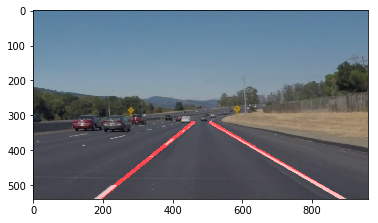

In [8]:
white_output = 'white3.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

x3 = 121
y3 =540
x4 =453
y4 =320
x1_list[390 467 214 440 124 293 105 219 210 325 289 448 126 155 316 403 197 226
 127 191 435 464 263 386 430 450]
y1_list[366 314 481 339 538 432 539 468 475 404 433 333 538 520 411 357 483 464
 537 497 342 312 443 367 344 331]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.663377845802
b_avg = 620.696464512
slope_left = [-0.67532468 -0.62831858 -0.62721893 -0.62280702 -0.6173913  -0.62893082
 -0.62068966 -0.62068966 -0.65517241 -0.625      -1.03448276 -0.61788618
 -0.65      ]
slope_right [ 0.6728972   0.675       0.67948718  0.6746988   0.72413793  0.68085106
  0.66666667  0.65714286]
[MoviePy] >>>> Building video yellow3.mp4
[MoviePy] Writing video yellow3.mp4


  0%|                                                                                                                                                                                                              | 0/682 [00:00<?, ?it/s]

x3 = 121
y3 =540
x4 =453
y4 =320
x1_list[390 467 214 440 124 293 105 219 210 325 289 448 126 155 316 403 197 226
 127 191 435 464 263 386 430 450]
y1_list[366 314 481 339 538 432 539 468 475 404 433 333 538 520 411 357 483 464
 537 497 342 312 443 367 344 331]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.663377845802
b_avg = 620.696464512
slope_left = [-0.67532468 -0.62831858 -0.62721893 -0.62280702 -0.6173913  -0.62893082
 -0.62068966 -0.62068966 -0.65517241 -0.625      -1.03448276 -0.61788618
 -0.65      ]
slope_right [ 0.6728972   0.675       0.67948718  0.6746988   0.72413793  0.68085106
  0.66666667  0.65714286]


  0%|▎                                                                                                                                                                                                     | 1/682 [00:00<01:58,  5.76it/s]

x3 = 138
y3 =540
x4 =438
y4 =320
x1_list[168 338 228 356 256 436 125 269 301 461 127 247 106 202 385 417 325 447
 188 295 445 465 451 470 127 192 105 133 442 461]
y1_list[511 404 465 386 455 342 538 448 421 321 526 452 538 479 370 350 411 334
 489 423 335 310 331 310 538 497 538 521 337 314]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.735486571665
b_avg = 642.174998356
slope_left = [-0.62941176 -0.6171875  -0.62777778 -0.625      -0.625      -0.61666667
 -0.61458333 -0.625      -0.63114754 -0.61682243 -1.25       -1.10526316
 -0.63076923 -0.60714286 -1.21052632]
slope_right [ 0.66949153  0.67567568  0.6741573   0.68181818  0.66666667  0.66129032
  0.78378378  0.74418605  0.67647059]


  0%|▌                                                                                                                                                                                                     | 2/682 [00:00<01:59,  5.70it/s]

x3 = 135
y3 =540
x4 =445
y4 =320
x1_list[252 383 259 330 145 268 127 245 400 426 420 468 332 446 202 412 107 159
 107 220 369 411 433 453 444 465 152 257]
y1_list[451 370 455 408 516 440 538 464 361 343 348 313 407 335 490 358 538 506
 539 469 379 354 344 323 336 310 522 456]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.710977171668
b_avg = 636.402923217
slope_left = [-0.61832061 -0.66197183 -0.61788618 -0.62711864 -0.69230769 -0.72916667
 -0.63157895 -0.62857143 -0.61538462 -0.61946903 -0.5952381  -1.05
 -1.23809524 -0.62857143]
slope_right [ 0.66666667  0.6746988   0.66666667  0.73809524  0.68292683  0.66666667
  0.71428571  0.65853659]


  0%|▊                                                                                                                                                                                                     | 3/682 [00:00<01:51,  6.08it/s]

x3 = 129
y3 =540
x4 =456
y4 =320
x1_list[201 388 111 277 177 285 272 410 318 437 132 181 111 205 273 435 176 206
 403 444 269 299 356 409 440 464 149 184 436 456]
y1_list[484 368 539 436 508 440 447 360 417 342 538 507 538 480 440 339 509 491
 363 337 449 431 389 356 339 311 526 505 338 321]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.671846996127
b_avg = 626.866710854
slope_left = [-0.62032086 -0.62048193 -0.62962963 -0.63043478 -0.6302521  -0.63265306
 -0.61702128 -0.62345679 -0.6        -0.63414634 -0.6        -0.62264151
 -1.16666667 -0.6        -0.85      ]
slope_right [ 0.67692308  0.675       0.68181818  0.66666667  0.7         0.65
  0.59090909  0.71428571  0.775       0.62068966  0.65        0.67073171]


  1%|█▏                                                                                                                                                                                                    | 4/682 [00:00<01:45,  6.44it/s]

x3 = 136
y3 =540
x4 =453
y4 =320
x1_list[192 434 115 342 266 377 133 224 321 421 167 264 245 305 441 465 439 469
 390 428 422 451 412 438 135 173 114 136]
y1_list[491 340 538 397 452 382 538 481 416 353 516 455 466 428 335 310 341 312
 374 347 352 331 353 337 538 514 538 524]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.694331476114
b_avg = 634.937089071
slope_left = [-0.62396694 -0.62114537 -0.63063063 -0.62637363 -0.63       -0.62886598
 -0.63333333 -1.04166667 -0.96666667 -0.71052632 -0.72413793 -0.61538462
 -0.63157895 -0.63636364]
slope_right [ 0.625       0.62222222  0.8         0.63157895  0.72727273  0.63636364
  0.68181818  0.63157895  0.625       0.67346939  0.69565217  0.65      ]


  1%|█▍                                                                                                                                                                                                    | 5/682 [00:00<01:37,  6.98it/s]

x3 = 145
y3 =540
x4 =457
y4 =320
x1_list[118 421 328 404 187 302 364 447 136 195 257 340 410 454 427 469 390 411
 433 470]
y1_list[539 349 413 365 507 430 386 330 538 501 461 406 361 329 345 310 375 359
 341 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.705302357304
b_avg = 642.445220342
slope_left = [-0.62706271 -0.63157895 -0.66956522 -0.6746988  -0.62711864 -0.6626506
 -0.72727273 -0.83333333 -0.76190476 -0.83783784]
slope_right [ 0.65384615  0.66666667  0.70833333  0.66666667  0.66666667  0.68      ]


  1%|█▋                                                                                                                                                                                                    | 6/682 [00:00<01:32,  7.32it/s]

x3 = 161
y3 =540
x4 =448
y4 =320
x1_list[140 286 120 399 119 423 344 446 276 360 203 318 425 466 447 470 410 441
 434 462 419 445]
y1_list[539 441 538 364 538 348 405 336 449 393 497 420 350 310 335 310 355 335
 344 315 350 331]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.764254758875
b_avg = 663.07469416
slope_left = [-0.67123288 -0.62365591 -0.625      -0.67647059 -0.66666667 -0.66956522
 -0.97560976 -1.08695652 -0.64516129 -1.03571429 -0.73076923]
slope_right [ 0.66666667  0.65625     0.70833333  0.65384615  0.66666667]


  1%|██                                                                                                                                                                                                    | 7/682 [00:01<01:39,  6.78it/s]

x3 = 137
y3 =540
x4 =461
y4 =320
x1_list[120 402 400 448 405 449 140 283 319 445 364 387 221 338 320 343 403 437
 302 325 375 441]
y1_list[538 361 366 333 359 327 539 443 421 336 386 370 485 407 420 404 359 337
 432 416 379 334]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.679169485584
b_avg = 633.350980983
slope_left = [-0.62765957 -0.6875     -0.72727273 -0.67132867 -0.67460317 -0.69565217
 -0.66666667 -0.69565217 -0.64705882 -0.69565217 -0.68181818]
slope_right [ 0.65714286  0.65714286  0.67647059  0.65217391  0.62162162]


  1%|██▎                                                                                                                                                                                                   | 8/682 [00:01<01:38,  6.85it/s]

x3 = 147
y3 =540
x4 =451
y4 =320
x1_list[120 390 170 309 301 443 140 400 141 238 444 469 327 350 424 458 395 455
 121 174 391 412 442 464 342 442]
y1_list[538 369 519 426 433 337 525 362 538 473 336 310 415 399 346 317 364 326
 538 505 367 354 332 310 405 337]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.723976076466
b_avg = 646.979937769
slope_left = [-0.62592593 -0.66906475 -0.67605634 -0.62692308 -0.67010309 -1.04
 -0.69565217 -0.85294118 -0.63333333 -0.62264151 -0.61904762 -1.         -0.68      ]
slope_right [ 0.675       0.66666667  0.57575758  0.68        0.66666667  0.65      ]


  1%|██▌                                                                                                                                                                                                   | 9/682 [00:01<01:41,  6.64it/s]

x3 = 133
y3 =540
x4 =460
y4 =320
x1_list[120 384 392 446 286 436 142 308 246 394 141 192 121 253 377 421 417 440
 434 464 252 283 194 259 408 428]
y1_list[538 373 371 334 443 342 539 427 459 366 538 504 539 456 376 348 349 334
 339 310 465 445 504 461 355 343]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.672611861959
b_avg = 629.545348379
slope_left = [-0.625      -0.68518519 -0.67333333 -0.6746988  -0.62837838 -0.66666667
 -0.62878788 -0.63636364 -0.65217391 -0.96666667 -0.64516129 -0.66153846
 -0.6       ]
slope_right [ 0.67346939  0.62264151  0.61818182  0.68421053]


  1%|██▉                                                                                                                                                                                                  | 10/682 [00:01<01:43,  6.52it/s]

x3 = 140
y3 =540
x4 =446
y4 =320
x1_list[144 442 330 437 221 433 286 342 143 256 188 242 358 431 254 298 142 195
 448 468 210 252 430 463 123 154 445 465 137 176 437 457 180 200]
y1_list[538 337 408 336 487 344 436 399 538 462 498 462 390 341 456 427 527 492
 332 310 484 456 345 310 538 518 328 314 530 504 335 321 503 489]
x2_list[]
y2_list[]
num_points_left17
num_points_right5
a_avg = -0.720686546768
b_avg = 641.485277484
slope_left = [-0.67449664 -0.6728972  -0.6745283  -0.66071429 -0.67256637 -0.66666667
 -0.67123288 -0.65909091 -0.66037736 -1.1        -0.66666667 -1.06060606
 -0.64516129 -0.7        -0.66666667 -0.7        -0.7       ]
slope_right [ 0.66666667  0.61904762  0.62121212  0.73076923  0.71428571]


  2%|███▏                                                                                                                                                                                                 | 11/682 [00:01<01:49,  6.12it/s]

x3 = 133
y3 =540
x4 =452
y4 =320
x1_list[144 438 305 458 196 421 253 312 209 259 168 227 144 243 124 164 149 194
 344 433 439 463 234 284 124 145]
y1_list[539 340 424 321 504 353 457 418 485 452 511 472 538 471 539 512 523 493
 399 339 339 316 469 436 538 524]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.690831539915
b_avg = 632.379526538
slope_left = [-0.67687075 -0.67320261 -0.67111111 -0.66101695 -0.66       -0.66101695
 -0.67676768 -0.675      -0.66666667 -0.6741573  -0.95833333 -0.66
 -0.66666667]
slope_right [ 0.67567568  0.625       0.62025316  0.66666667  0.67647059  0.7
  0.62025316  0.65      ]


  2%|███▍                                                                                                                                                                                                 | 12/682 [00:01<01:49,  6.11it/s]

x3 = 151
y3 =540
x4 =447
y4 =320
x1_list[390 420 314 430 146 388 125 250 281 440 245 299 403 440 444 466 314 339
 145 251 213 257 441 462 228 299 447 466 192 227]
y1_list[372 353 419 341 539 375 538 460 440 333 463 427 363 338 334 310 426 409
 538 467 483 454 332 310 484 436 332 312 496 473]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.743732835768
b_avg = 652.713171625
slope_left = [-0.63333333 -0.67241379 -0.67768595 -0.624      -0.67295597 -0.66666667
 -0.67567568 -1.09090909 -0.68       -0.66981132 -0.65909091 -1.04761905
 -0.67605634 -1.05263158 -0.65714286]
slope_right [ 0.67368421  0.625       0.62        0.63636364  0.6         0.62068966
  0.67307692  0.62686567]


  2%|███▊                                                                                                                                                                                                 | 13/682 [00:02<02:54,  3.83it/s]

x3 = 144
y3 =540
x4 =452
y4 =320
x1_list[148 370 289 434 354 433 170 232 237 299 128 158 128 191 147 202 182 314
 203 269 445 466 314 428 434 463 314 338 217 415]
y1_list[538 388 436 338 398 344 512 471 469 428 538 518 539 497 538 501 516 427
 491 447 334 312 420 343 343 315 425 409 491 357]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.715776107966
b_avg = 643.57507131
slope_left = [-0.67567568 -0.67586207 -0.6835443  -0.66129032 -0.66129032 -0.66666667
 -0.66666667 -0.67272727 -0.67424242 -0.66666667 -1.04761905 -0.6754386
 -0.96551724 -0.66666667 -0.67676768]
slope_right [ 0.66666667  0.61832061  0.65        0.62015504  0.6875      0.66666667]


  2%|████                                                                                                                                                                                                 | 14/682 [00:02<02:25,  4.59it/s]

x3 = 152
y3 =540
x4 =448
y4 =320
x1_list[168 370 379 413 150 294 260 435 226 307 169 247 130 200 296 425 426 462
 343 422 440 462 440 467 153 219 400 436]
y1_list[525 388 380 358 538 441 455 337 477 423 514 462 539 492 432 345 349 316
 406 352 333 310 338 310 524 480 366 341]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.742583403156
b_avg = 653.082189429
slope_left = [-0.67821782 -0.64705882 -0.67361111 -0.67428571 -0.66666667 -0.66666667
 -0.67142857 -0.6744186  -0.91666667 -0.6835443  -1.04545455 -1.03703704
 -0.66666667 -0.69444444]
slope_right [ 0.62068966  0.67857143  0.67045455  0.66666667  0.66666667  0.57142857
  0.67647059  0.62411348  0.6         0.70833333  0.57142857]
x3 = 150
y3 =540
x4 =453
y4 =320
x1_list[215 305 152 200 206 251 239 429 336 408 132 213 132 174 247 306 430 461
 364 430 272 335 441 467 189 255 305 338 336 381 168 207 377 442 154 188
 407 437]
y1_list[485 425 539 504 502 470 470 342 411 362 539 485 538 510 474 432 341 311
 391 346 457

  2%|████▌                                                                                                                                                                                                | 16/682 [00:02<02:01,  5.50it/s]

x3 = 150
y3 =540
x4 =451
y4 =320
x1_list[184 287 271 422 151 321 376 438 153 236 133 205 322 407 439 461 218 427
 300 374 428 458 444 466 132 166]
y1_list[506 437 449 347 538 423 384 339 538 482 539 491 422 361 332 317 484 343
 437 384 342 315 334 310 538 516]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.732102509437
b_avg = 650.344392982
slope_left = [-0.66990291 -0.67549669 -0.67647059 -0.72580645 -0.6746988  -0.66666667
 -0.71764706 -0.68181818 -0.67464115 -0.71621622 -0.9        -1.09090909
 -0.64705882]
slope_right [ 0.61643836  0.6875      0.61428571  0.65217391  0.56        0.66666667
  0.66666667  0.66666667]
x3 = 169
y3 =540
x4 =447
y4 =320
x1_list[169 430 155 271 339 421 136 223 202 312 273 337 443 462 435 461 436 461
 430 465 341 403 396 433 248 410]
y1_list[517 341 538 459 409 353 538 480 505 430 456 412 330 310 342 317 336 310
 346 312 409 364 371 342 465 356]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.790946462762
b_avg = 674.

  3%|█████▏                                                                                                                                                                                               | 18/682 [00:02<01:41,  6.56it/s]

x3 = 161
y3 =540
x4 =449
y4 =320
x1_list[160 424 259 395 382 430 190 264 136 238 389 448 376 405 435 458 154 180
 431 461 163 263 429 465 260 296 413 437]
y1_list[523 345 467 369 373 340 515 462 538 470 375 329 384 362 336 314 538 522
 339 310 532 464 346 311 465 440 358 339]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.762885828824
b_avg = 663.040980998
slope_left = [-0.67424242 -0.72058824 -0.6875     -0.71621622 -0.66666667 -0.77966102
 -0.75862069 -0.95652174 -0.61538462 -0.96666667 -0.68       -0.97222222
 -0.69444444 -0.79166667]
slope_right [ 0.64285714  0.61290323  0.6         0.66666667]


  3%|█████▍                                                                                                                                                                                               | 19/682 [00:03<01:49,  6.08it/s]

x3 = 161
y3 =540
x4 =441
y4 =320
x1_list[152 423 268 393 209 349 227 325 351 435 202 414 177 291 441 465 150 176
 441 459 383 428 155 188 136 159 414 461 438 459]
y1_list[528 345 460 370 502 401 477 411 401 340 495 352 524 442 335 310 529 511
 330 310 379 346 539 515 538 522 357 315 332 312]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.783835560927
b_avg = 666.259708375
slope_left = [-0.67527675 -0.72       -0.72142857 -0.67346939 -0.72619048 -0.6745283
 -0.71929825 -1.04166667 -0.69230769 -1.11111111 -0.73333333 -0.72727273
 -0.69565217 -0.89361702 -0.95238095]
slope_right [ 0.61111111  0.65714286  0.61538462  0.67741935  0.62857143]


  3%|█████▊                                                                                                                                                                                               | 20/682 [00:03<01:51,  5.93it/s]

x3 = 161
y3 =540
x4 =446
y4 =320
x1_list[135 424 176 330 231 356 337 436 291 411 437 461 377 425 155 268 425 456
 422 459 164 185]
y1_list[538 343 524 413 485 395 410 338 434 353 337 314 382 347 539 457 342 314
 344 311 532 516]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.771634419049
b_avg = 664.725895963
slope_left = [-0.67474048 -0.72077922 -0.72       -0.72727273 -0.675      -0.95833333
 -0.72916667 -0.72566372 -0.90322581 -0.89189189 -0.76190476]
slope_right [ 0.62790698  0.62222222  0.65789474  0.65789474]


  3%|██████                                                                                                                                                                                               | 21/682 [00:03<01:41,  6.51it/s]

x3 = 159
y3 =540
x4 =444
y4 =320
x1_list[134 345 290 410 316 436 209 330 154 260 345 433 412 432 434 463 423 458
 153 198 193 294 443 463 420 459 133 195]
y1_list[538 396 434 353 424 337 500 413 539 462 404 340 350 336 338 310 343 311
 538 506 511 438 331 311 345 310 538 496]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.773873104596
b_avg = 663.604251412
slope_left = [-0.67298578 -0.675      -0.725      -0.71900826 -0.72641509 -0.72727273
 -0.7        -0.96551724 -0.91428571 -0.71111111 -0.72277228 -1.         -0.8974359
 -0.67741935]
slope_right [ 0.6122449   0.66666667  0.62        0.66666667]


  3%|██████▎                                                                                                                                                                                              | 22/682 [00:03<01:33,  7.03it/s]

x3 = 155
y3 =540
x4 =446
y4 =320
x1_list[133 324 153 271 206 422 325 434 241 330 423 459 204 297 432 463 416 441
 132 223 318 339 314 409 406 448]
y1_list[538 410 539 454 490 344 418 339 477 413 343 310 503 436 340 310 347 328
 538 477 423 407 418 354 361 326]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.754952648354
b_avg = 657.379421309
slope_left = [-0.67015707 -0.72033898 -0.67592593 -0.72477064 -0.71910112 -0.91666667
 -0.72043011 -0.96774194 -0.76       -0.67032967 -0.76190476 -0.67368421
 -0.83333333]
slope_right [ 0.62295082  0.66666667  0.62        0.66666667  0.61764706]
x3 = 153
y3 =540
x4 =449
y4 =320
x1_list[259 410 161 380 132 255 203 291 152 218 314 434 423 455 244 329 435 464
 414 459 293 344 374 418 153 181 176 235 346 398 415 457]
y1_list[455 353 520 373 538 456 502 442 538 493 426 339 343 314 473 415 338 310
 350 310 439 404 384 352 538 519 521 481 397 362 354 316]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.743310328899
b

  4%|██████▉                                                                                                                                                                                              | 24/682 [00:03<01:22,  7.95it/s]

x3 = 156
y3 =540
x4 =450
y4 =320
x1_list[134 247 219 407 249 359 415 459 154 216 406 451 335 368 424 456 398 419
 198 268 364 389 305 398 160 341 238 279 326 351 392 417]
y1_list[539 463 483 356 473 394 350 311 538 496 362 324 413 388 343 314 368 350
 507 459 392 373 426 363 522 400 479 451 419 400 366 347]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.749723110882
b_avg = 657.65890348
slope_left = [-0.67256637 -0.67553191 -0.71818182 -0.88636364 -0.67741935 -0.84444444
 -0.75757576 -0.90625    -0.85714286 -0.68571429 -0.76       -0.67741935
 -0.67403315 -0.68292683 -0.76       -0.76      ]
slope_right [ 0.62365591  0.66666667  0.6         0.67307692  0.62337662  0.65909091
  0.65625   ]


  4%|███████▏                                                                                                                                                                                             | 25/682 [00:03<01:18,  8.41it/s]

x3 = 154
y3 =540
x4 =455
y4 =320
x1_list[137 410 273 430 220 398 215 333 423 459 173 265 396 419 419 463 137 255
 313 415 157 181 158 199]
y1_list[539 355 458 344 484 364 499 414 345 312 528 462 364 348 353 313 538 459
 430 356 538 522 537 509]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.731498323463
b_avg = 652.912493686
slope_left = [-0.67399267 -0.72611465 -0.6741573  -0.72033898 -0.91666667 -0.7173913
 -0.69565217 -0.90909091 -0.66949153 -0.7254902  -0.66666667 -0.68292683]
slope_right [ 0.62184874  0.67241379  0.66666667  0.625       0.61666667  0.66
  0.77272727]
x3 = 162
y3 =540
x4 =450
y4 =320
x1_list[204 340 139 401 384 429 213 382 406 450 159 220 356 447 331 364 381 402
 428 459 313 347 138 211 399 456 223 296]
y1_list[507 409 538 361 379 344 489 375 357 320 538 494 399 328 417 392 381 364
 340 310 430 404 538 489 362 314 492 442]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.763482294526
b_avg = 663.712639488
slope_left = [-0.7205

  4%|███████▊                                                                                                                                                                                             | 27/682 [00:03<01:14,  8.76it/s]

x3 = 157
y3 =540
x4 =451
y4 =320
x1_list[139 392 216 421 400 427 152 376 274 402 168 337 159 224 397 417 435 464
 421 456 365 404]
y1_list[538 367 499 350 365 345 530 379 458 365 533 411 539 492 362 348 338 310
 345 314 385 358]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.748421692141
b_avg = 657.966531944
slope_left = [-0.67588933 -0.72682927 -0.74074074 -0.67410714 -0.7265625  -0.72189349
 -0.72307692 -0.7        -0.96551724 -0.88571429 -0.69230769]
slope_right [ 0.62096774  0.58666667  0.6         0.57142857  0.59090909  0.55882353
  0.61904762  0.59090909  0.53333333  0.5625      0.62790698  0.62025316]


  4%|████████                                                                                                                                                                                             | 28/682 [00:04<01:31,  7.16it/s]

x3 = 157
y3 =540
x4 =450
y4 =320
x1_list[140 374 161 419 210 396 353 402 392 415 432 463 425 448 160 188 358 378
 329 355]
y1_list[538 380 539 351 504 369 393 359 365 349 340 310 341 319 538 518 390 377
 410 392]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.750008910351
b_avg = 658.253020609
slope_left = [-0.67521368 -0.72868217 -0.72580645 -0.69387755 -0.69565217 -0.96774194
 -0.95652174 -0.71428571 -0.65       -0.69230769]
slope_right [ 0.57894737  0.62962963  0.61797753  0.58333333  0.65217391  0.55
  0.59090909  0.61538462]
x3 = 166
y3 =540
x4 =448
y4 =320
x1_list[188 397 141 364 333 416 421 459 161 304 359 397 391 456 402 446 418 463
 284 388 375 396]
y1_list[520 368 538 387 414 353 349 315 538 435 390 361 367 313 359 322 351 310
 440 369 379 362]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.781138412571
b_avg = 669.990966938
slope_left = [-0.72727273 -0.67713004 -0.73493976 -0.89473684 -0.72027972 -0.76315789
 -0.83076923 -0.84090909 -0

  4%|████████▋                                                                                                                                                                                            | 30/682 [00:04<01:20,  8.10it/s]

x3 = 158
y3 =540
x4 =451
y4 =320
x1_list[162 402 141 344 142 372 382 416 219 379 378 407 346 395 434 463 402 453
 399 454 162 267]
y1_list[539 364 538 401 537 381 378 353 498 382 375 355 398 364 338 310 358 316
 366 320 538 462]
x2_list[]
y2_list[]
num_points_left11
num_points_right3
a_avg = -0.752304639811
b_avg = 659.535882176
slope_left = [-0.72916667 -0.67487685 -0.67826087 -0.73529412 -0.725      -0.68965517
 -0.69387755 -0.96551724 -0.82352941 -0.83636364 -0.72380952]
slope_right [ 0.60714286  0.5625      0.62068966]
x3 = 168
y3 =540
x4 =447
y4 =320
x1_list[163 375 163 289 249 368 142 342 398 453 416 458 376 404 369 402 427 451
 381 406 407 432 233 353 434 463]
y1_list[539 385 538 447 465 384 538 403 367 321 348 310 384 361 382 359 339 317
 373 356 355 333 489 402 338 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right3
a_avg = -0.787001331003
b_avg = 672.53347783
slope_left = [-0.72641509 -0.72222222 -0.68067227 -0.675      -0.83636364 -0.9047619
 -0.82142857 -0.6969697 

  5%|█████████▏                                                                                                                                                                                           | 32/682 [00:04<01:18,  8.29it/s]

x3 = 160
y3 =540
x4 =447
y4 =320
x1_list[164 374 143 320 332 374 437 461 404 442 432 457 372 405 305 331 393 454
 409 446 164 351 143 209 414 445 192 318 368 388]
y1_list[538 385 538 418 408 379 333 312 362 330 334 310 379 356 427 410 370 319
 353 320 539 403 539 494 349 321 504 419 382 369]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.765987479368
b_avg = 662.56364282
slope_left = [-0.72857143 -0.6779661  -0.69047619 -0.875      -0.84210526 -0.96
 -0.6969697  -0.65384615 -0.83606557 -0.89189189 -0.72727273 -0.68181818
 -0.90322581 -0.67460317 -0.65      ]
slope_right [ 0.6097561   0.62962963  0.63157895  0.60606061  0.61904762]


  5%|█████████▌                                                                                                                                                                                           | 33/682 [00:04<01:21,  7.92it/s]

x3 = 163
y3 =540
x4 =447
y4 =320
x1_list[165 343 403 428 276 411 165 356 144 273 384 459 357 384 400 443 145 288
 421 457 250 344 416 457 369 398]
y1_list[539 409 356 337 449 351 538 399 538 451 377 314 398 376 365 329 537 440
 343 311 465 401 347 310 389 365]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.776041636907
b_avg = 667.182281459
slope_left = [-0.73033708 -0.76       -0.72592593 -0.72774869 -0.6744186  -0.84
 -0.81481481 -0.8372093  -0.67832168 -0.88888889 -0.68085106 -0.90243902
 -0.82758621]
slope_right [ 0.62222222  0.60869565  0.625       0.625     ]


  5%|█████████▊                                                                                                                                                                                           | 34/682 [00:04<01:23,  7.78it/s]

x3 = 160
y3 =540
x4 =445
y4 =320
x1_list[166 319 263 413 231 308 165 341 146 207 378 460 414 456 146 178 173 233
 334 392 436 457 397 453 329 349 218 239]
y1_list[538 427 458 349 480 425 538 410 539 495 382 313 348 310 538 515 520 477
 414 371 330 310 367 320 418 404 489 473]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.770829964621
b_avg = 663.644799139
slope_left = [-0.7254902  -0.72666667 -0.71428571 -0.72727273 -0.72131148 -0.84146341
 -0.9047619  -0.71875    -0.71666667 -0.74137931 -0.95238095 -0.83928571
 -0.7        -0.76190476]
slope_right [ 0.56666667  0.61111111  0.61818182  0.57894737]
x3 = 163
y3 =540
x4 =446
y4 =320
x1_list[166 325 256 406 375 457 418 439 197 278 146 199 166 295 184 238 403 452
 355 382 337 366 315 335 389 451 415 457 298 345 246 266]
y1_list[538 422 463 354 384 315 343 327 504 446 539 501 539 445 513 474 356 315
 399 377 413 389 429 413 373 321 347 310 441 406 470 455]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -

  5%|██████████▍                                                                                                                                                                                          | 36/682 [00:04<01:14,  8.63it/s]

x3 = 160
y3 =540
x4 =447
y4 =320
x1_list[270 402 306 425 210 422 245 338 235 287 147 232 147 195 423 456 435 461
 188 227 166 201 148 173 374 433 205 248 243 408]
y1_list[453 357 436 343 495 341 482 410 489 449 539 478 538 504 340 310 335 310
 522 495 538 514 537 519 384 335 511 478 472 352]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.76656530316
b_avg = 662.77080731
slope_left = [-0.72727273 -0.78151261 -0.72641509 -0.77419355 -0.76923077 -0.71764706
 -0.70833333 -0.90909091 -0.96153846 -0.69230769 -0.68571429 -0.72
 -0.83050847 -0.76744186 -0.72727273]
slope_right [ 0.61728395  0.58        0.57954545  0.62195122  0.64      ]
x3 = 159
y3 =540
x4 =446
y4 =320
x1_list[193 419 261 440 244 401 398 426 225 341 192 253 147 181 170 270 320 420
 441 461 431 456 168 198 167 188 164 188]
y1_list[507 343 470 330 471 357 358 337 497 407 521 474 538 514 523 451 425 347
 329 310 333 310 537 516 538 524 527 509]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -

  6%|██████████▉                                                                                                                                                                                          | 38/682 [00:05<01:09,  9.27it/s]

x3 = 156
y3 =540
x4 =449
y4 =320
x1_list[175 318 222 409 260 448 147 228 168 201 167 262 335 413 147 180 389 456
 303 390 208 284 285 330]
y1_list[519 416 486 350 470 323 539 480 538 514 538 468 413 352 538 514 366 310
 428 365 507 451 450 415]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.750489996196
b_avg = 657.137198935
slope_left = [-0.72027972 -0.72727273 -0.78191489 -0.72839506 -0.72727273 -0.73684211
 -0.78205128 -0.72727273 -0.8358209  -0.72413793 -0.73684211 -0.77777778]
slope_right [ 0.58024691  0.62686567  0.57241379  0.57777778  0.6         0.62307692]
x3 = 156
y3 =540
x4 =445
y4 =320
x1_list[145 274 291 447 362 440 182 265 218 302 322 423 341 375 202 357 145 188
 165 187 317 341 421 449 426 453 347 448 254 329]
y1_list[539 446 445 323 385 324 527 463 500 435 422 343 400 374 499 387 538 507
 538 523 417 399 343 321 334 312 396 317 473 415]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.760545364614
b_avg = 659.050699124
slope_left =

  6%|███████████▌                                                                                                                                                                                         | 40/682 [00:05<01:06,  9.71it/s]

x3 = 159
y3 =540
x4 =444
y4 =320
x1_list[266 412 303 445 145 227 145 274 215 286 239 310 347 448 166 254 392 454
 171 193 369 439 245 270 299 353]
y1_list[453 347 436 325 538 479 539 446 502 447 484 429 396 317 539 471 368 316
 535 517 386 328 468 449 430 391]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.77077279826
b_avg = 662.607202688
slope_left = [-0.7260274  -0.78169014 -0.7195122  -0.72093023 -0.77464789 -0.77464789
 -0.78217822 -0.77272727 -0.83870968 -0.81818182 -0.82857143 -0.76
 -0.72222222]
slope_right [ 0.576       0.61904762  0.6         0.62608696  0.61702128  0.60869565
  0.57894737  0.65        0.58333333]
x3 = 154
y3 =540
x4 =446
y4 =320
x1_list[270 449 258 408 145 247 380 423 164 267 322 424 184 294 422 453 145 210
 191 289 165 200 432 455 426 459]
y1_list[461 321 459 350 539 465 370 338 538 463 422 342 511 432 342 317 538 491
 518 446 539 513 330 310 334 311]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.752517782193
b_avg =

  6%|████████████▏                                                                                                                                                                                        | 42/682 [00:05<01:03, 10.15it/s]

x3 = 152
y3 =540
x4 =446
y4 =320
x1_list[163 292 245 409 213 298 308 445 422 446 143 218 422 447 174 234 143 182
 266 328 300 387 164 218 431 454]
y1_list[538 444 468 349 490 429 432 325 337 319 539 485 342 323 517 474 538 510
 462 416 429 366 538 499 331 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.747608875637
b_avg = 653.78744494
slope_left = [-0.72868217 -0.72560976 -0.71764706 -0.7810219  -0.75       -0.72       -0.76
 -0.71666667 -0.71794872 -0.74193548 -0.72413793 -0.72222222 -0.91304348]
slope_right [ 0.6        0.5862069  0.6        0.6      ]
x3 = 152
y3 =540
x4 =449
y4 =320
x1_list[163 311 387 407 224 418 169 250 164 263 271 403 246 344 143 186 398 461
 325 379 194 287 417 452 355 395 143 164]
y1_list[538 430 370 356 483 342 521 463 538 466 450 354 477 405 539 508 363 310
 418 378 504 437 348 319 395 365 538 523]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.741289330943
b_avg = 653.16293129
slope_left = [-0.72972973 -0.7      

  6%|████████████▋                                                                                                                                                                                        | 44/682 [00:05<01:03, 10.06it/s]

x3 = 154
y3 =540
x4 =447
y4 =320
x1_list[371 449 179 295 303 450 166 262 231 417 145 216 288 372 285 454 327 441
 211 239 235 259 198 222]
y1_list[379 318 528 443 437 322 538 468 479 344 539 488 439 378 450 318 419 330
 493 472 476 458 502 484]
x2_list[]
y2_list[]
num_points_left12
num_points_right4
a_avg = -0.750696927057
b_avg = 656.203502701
slope_left = [-0.78205128 -0.73275862 -0.78231293 -0.72916667 -0.72580645 -0.71830986
 -0.72619048 -0.78106509 -0.78070175 -0.75       -0.75       -0.75      ]
slope_right [ 0.60526316  0.67647059  0.62162162  0.59375   ]
x3 = 154
y3 =540
x4 =448
y4 =320
x1_list[222 430 316 449 165 284 176 250 145 207 239 326 265 408 431 457 316 454
 144 171 165 229]
y1_list[485 334 427 323 538 451 517 464 539 494 483 419 455 351 333 310 426 318
 538 519 539 492]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.749930838694
b_avg = 655.980358189
slope_left = [-0.72596154 -0.78195489 -0.73109244 -0.71621622 -0.72580645 -0.73563218
 -0.72727273 -

  7%|█████████████▎                                                                                                                                                                                       | 46/682 [00:06<01:13,  8.61it/s]

x3 = 153
y3 =540
x4 =451
y4 =320
x1_list[291 453 221 437 165 250 319 447 166 301 165 271 145 196 264 403 283 330
 435 461]
y1_list[446 320 486 329 525 464 425 325 537 438 538 461 539 502 456 355 451 415
 329 311]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.737364915636
b_avg = 653.209474691
slope_left = [-0.77777778 -0.72685185 -0.71764706 -0.78125    -0.73333333 -0.72641509
 -0.7254902  -0.72661871 -0.76595745 -0.69230769]
slope_right [ 0.62        0.58181818  0.62        0.58333333  0.62        0.61764706]


  7%|█████████████▌                                                                                                                                                                                       | 47/682 [00:06<01:17,  8.15it/s]

x3 = 150
y3 =540
x4 =451
y4 =320
x1_list[274 457 382 446 363 455 211 319 342 384 145 239 165 275 201 267 283 331
 328 447 225 285 313 347 146 199]
y1_list[459 316 371 321 385 313 504 425 400 368 538 474 538 458 499 454 441 408
 418 325 482 441 421 395 538 502]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.732684983133
b_avg = 650.538179923
slope_left = [-0.78142077 -0.78125    -0.7826087  -0.73148148 -0.76190476 -0.68085106
 -0.72727273 -0.68181818 -0.6875     -0.78151261 -0.68333333 -0.76470588
 -0.67924528]
slope_right [ 0.65517241  0.57575758  0.64516129  0.7         0.58333333]


  7%|█████████████▊                                                                                                                                                                                       | 48/682 [00:06<01:19,  7.95it/s]

x3 = 154
y3 =540
x4 =450
y4 =320
x1_list[211 434 301 452 174 294 146 233 165 237 298 411 145 179 273 412 241 338
 373 441 181 332]
y1_list[493 331 438 320 531 443 539 476 539 486 440 352 538 514 449 348 483 408
 383 330 514 405]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.744292799434
b_avg = 655.123447839
slope_left = [-0.7264574  -0.78145695 -0.73333333 -0.72413793 -0.73611111 -0.77876106
 -0.70588235 -0.72661871 -0.77319588 -0.77941176 -0.7218543 ]
slope_right [ 0.58227848  0.62337662  0.57317073  0.61904762]


  7%|██████████████▏                                                                                                                                                                                      | 49/682 [00:06<01:19,  7.98it/s]

x3 = 152
y3 =540
x4 =447
y4 =320
x1_list[213 436 295 455 165 240 259 352 385 438 354 451 421 446 145 253 311 406
 222 274 145 191 172 313]
y1_list[491 329 442 317 538 483 469 397 366 327 397 321 339 320 539 461 421 352
 496 456 538 505 520 418]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.746096069388
b_avg = 653.559301163
slope_left = [-0.7264574  -0.78125    -0.73333333 -0.77419355 -0.73584906 -0.78350515
 -0.76       -0.72222222 -0.72631579 -0.76923077 -0.7173913  -0.72340426]
slope_right [ 0.62105263  0.57425743  0.62105263  0.58333333  0.66666667  0.57142857]


  7%|██████████████▍                                                                                                                                                                                      | 50/682 [00:06<01:19,  7.94it/s]

x3 = 157
y3 =540
x4 =445
y4 =320
x1_list[214 437 301 426 153 289 260 352 342 452 164 241 325 409 177 274 144 206
 435 461]
y1_list[490 328 437 340 533 435 468 397 406 320 538 482 411 350 528 457 539 494
 335 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.764936982615
b_avg = 660.775905732
slope_left = [-0.7264574  -0.776      -0.72058824 -0.77173913 -0.78181818 -0.72727273
 -0.72619048 -0.73195876 -0.72580645 -0.96153846]
slope_right [ 0.62295082  0.5703125   0.57647059  0.58333333  0.59090909  0.63636364
  0.57142857  0.62195122]


  7%|██████████████▋                                                                                                                                                                                      | 51/682 [00:06<01:19,  7.91it/s]

x3 = 154
y3 =540
x4 =451
y4 =320
x1_list[231 439 332 452 144 216 164 257 160 285 300 417 259 338 165 197 199 281
 339 403 388 447 204 316 267 323 436 461]
y1_list[478 327 414 320 539 487 538 470 528 438 429 344 467 409 539 515 512 452
 408 358 371 325 497 416 462 419 328 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.739790185285
b_avg = 653.937055586
slope_left = [-0.72596154 -0.78333333 -0.72222222 -0.7311828  -0.72       -0.72649573
 -0.73417722 -0.75       -0.73170732 -0.78125    -0.77966102 -0.72321429
 -0.76785714 -0.68      ]
slope_right [ 0.62111801  0.57988166  0.6         0.6         0.61904762  0.58024691
  0.6         0.62295082]


  8%|███████████████                                                                                                                                                                                      | 52/682 [00:06<01:19,  7.92it/s]

x3 = 152
y3 =540
x4 =450
y4 =320
x1_list[287 437 225 349 186 289 163 290 347 412 281 383 164 203 143 236 432 463
 373 437 234 302 143 171 309 419 184 211]
y1_list[438 329 492 401 509 435 538 445 401 353 450 375 539 510 539 472 338 310
 381 334 475 426 538 518 423 343 523 504]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.739463885368
b_avg = 652.965598986
slope_left = [-0.72666667 -0.73387097 -0.7184466  -0.73228346 -0.73846154 -0.73529412
 -0.74358974 -0.72043011 -0.90322581 -0.734375   -0.72058824 -0.71428571
 -0.72727273 -0.7037037 ]
slope_right [ 0.58041958  0.62406015  0.62376238  0.6         0.61904762  0.7         0.6
  0.57777778]


  8%|███████████████▎                                                                                                                                                                                     | 53/682 [00:06<01:23,  7.56it/s]

x3 = 156
y3 =540
x4 =447
y4 =320
x1_list[200 257 276 440 143 235 378 456 304 396 217 277 265 301 169 191 163 207
 228 274 336 420 270 291 405 426 143 196 270 322 438 463 383 447 191 248]
y1_list[512 468 446 327 539 473 379 318 435 364 487 444 462 437 535 517 538 506
 491 456 411 346 450 434 354 338 538 500 460 420 332 311 370 320 505 464]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.75614087299
b_avg = 658.061557532
slope_left = [-0.77192982 -0.72560976 -0.7173913  -0.78205128 -0.77173913 -0.71666667
 -0.69444444 -0.81818182 -0.72727273 -0.76086957 -0.77380952 -0.76190476
 -0.76190476 -0.71698113 -0.76923077 -0.84       -0.78125    -0.71929825]
slope_right [ 0.57692308  0.62244898  0.63636364  0.60869565  0.57692308  0.6
  0.62244898  0.60869565  0.61538462  0.58333333  0.61904762]


  8%|███████████████▌                                                                                                                                                                                     | 54/682 [00:07<01:22,  7.63it/s]

x3 = 151
y3 =540
x4 =446
y4 =320
x1_list[259 442 163 303 370 457 305 434 206 287 192 345 165 228 306 371 352 435
 142 179 187 244 441 463 142 189]
y1_list[458 325 538 436 385 317 426 332 495 437 516 404 523 478 432 384 397 336
 538 512 508 467 331 310 539 505]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.746257842098
b_avg = 652.907289893
slope_left = [-0.72677596 -0.72857143 -0.7816092  -0.72868217 -0.71604938 -0.73202614
 -0.71428571 -0.73846154 -0.73493976 -0.7027027  -0.71929825 -0.95454545
 -0.72340426]
slope_right [ 0.62        0.57142857  0.57692308  0.6         0.59259259  0.58
  0.61702128  0.6       ]


  8%|███████████████▉                                                                                                                                                                                     | 55/682 [00:07<01:26,  7.24it/s]

x3 = 156
y3 =540
x4 =447
y4 =320
x1_list[161 335 141 234 273 441 339 408 162 302 414 463 238 352 398 424 220 268
 273 345 357 434 313 367 158 224 426 457 438 458 386 412]
y1_list[538 411 538 475 448 326 408 355 538 436 352 311 472 390 364 343 484 450
 456 403 388 332 426 386 526 481 343 317 328 310 373 352]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.758411599105
b_avg = 659.034239304
slope_left = [-0.72988506 -0.67741935 -0.72619048 -0.76811594 -0.72857143 -0.83673469
 -0.71929825 -0.80769231 -0.70833333 -0.73611111 -0.72727273 -0.74074074
 -0.68181818 -0.83870968 -0.9        -0.80769231]
slope_right [ 0.65384615  0.62068966  0.63333333  0.62962963]


  8%|████████████████▏                                                                                                                                                                                    | 56/682 [00:07<01:29,  6.97it/s]

x3 = 152
y3 =540
x4 =450
y4 =320
x1_list[161 304 287 396 265 444 387 444 181 266 141 248 337 436 162 257 423 457
 233 284 243 326 436 463 323 416]
y1_list[538 434 445 365 453 323 370 328 510 452 538 465 402 330 538 469 345 316
 474 439 478 417 333 310 418 350]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.73843779318
b_avg = 652.300093818
slope_left = [-0.72727273 -0.73394495 -0.72625698 -0.73684211 -0.68235294 -0.68224299
 -0.72727273 -0.72631579 -0.85294118 -0.68627451 -0.73493976 -0.85185185
 -0.7311828 ]
slope_right [ 0.625       0.66666667  0.62857143  0.60714286  0.65      ]


  8%|████████████████▍                                                                                                                                                                                    | 57/682 [00:07<01:32,  6.79it/s]

x3 = 149
y3 =540
x4 =447
y4 =320
x1_list[209 291 352 432 162 299 320 381 389 454 366 418 283 353 196 230 170 204
 296 353 144 178 444 464 400 455 378 399 292 314 346 370 143 165 251 274
 179 224]
y1_list[491 435 392 334 538 438 422 375 371 320 388 348 440 390 500 478 518 496
 440 396 536 514 329 310 357 314 373 357 443 425 396 378 537 523 472 456
 513 481]
x2_list[]
y2_list[]
num_points_left19
num_points_right5
a_avg = -0.736558709812
b_avg = 649.913847783
slope_left = [-0.68292683 -0.725      -0.72992701 -0.7704918  -0.78461538 -0.76923077
 -0.71428571 -0.64705882 -0.64705882 -0.77192982 -0.64705882 -0.95
 -0.78181818 -0.76190476 -0.81818182 -0.75       -0.63636364 -0.69565217
 -0.71111111]
slope_right [ 0.61538462  0.625       0.57894737  0.72727273  0.61111111]


  9%|████████████████▊                                                                                                                                                                                    | 58/682 [00:07<01:34,  6.63it/s]

x3 = 153
y3 =540
x4 =448
y4 =320
x1_list[374 403 231 306 314 442 434 455 176 286 319 370 141 174 229 336 415 460
 343 431 161 243 162 228 196 320 301 427 418 463 148 201]
y1_list[380 360 488 430 418 325 330 314 515 436 422 383 539 515 478 401 351 314
 398 334 538 478 538 490 512 421 434 342 348 310 534 496]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.744698289497
b_avg = 654.111771454
slope_left = [-0.68965517 -0.77333333 -0.7265625  -0.76190476 -0.71818182 -0.76470588
 -0.72727273 -0.71962617 -0.82222222 -0.72727273 -0.73170732 -0.72727273
 -0.73387097 -0.73015873 -0.84444444 -0.71698113]
slope_right [ 0.65625     0.61904762  0.56        0.68292683  0.65217391  0.57446809
  0.72727273]


  9%|█████████████████                                                                                                                                                                                    | 59/682 [00:07<01:32,  6.76it/s]

x3 = 142
y3 =540
x4 =453
y4 =320
x1_list[253 427 271 371 165 380 160 246 173 254 362 417 390 448 140 174 239 312
 408 431 333 441 387 422 163 187 314 392 228 269]
y1_list[469 342 446 378 534 377 539 476 516 458 383 345 368 325 538 514 469 419
 350 334 410 331 365 341 523 505 416 363 477 449]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.709139289918
b_avg = 641.287483425
slope_left = [-0.72988506 -0.68       -0.73023256 -0.73255814 -0.71604938 -0.69090909
 -0.74137931 -0.70588235 -0.68493151 -0.69565217 -0.73148148 -0.68571429
 -0.75       -0.67948718 -0.68292683]
slope_right [ 0.61538462  0.57142857  0.62264151  0.57894737  0.61904762  0.58333333]


  9%|█████████████████▎                                                                                                                                                                                   | 60/682 [00:08<01:51,  5.59it/s]

x3 = 144
y3 =540
x4 =451
y4 =320
x1_list[197 310 160 296 139 242 207 426 314 449 336 438 358 441 296 348 243 293]
y1_list[498 421 538 439 538 468 503 343 418 320 403 329 392 331 430 393 467 431]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.715272967338
b_avg = 643.158255038
slope_left = [-0.68141593 -0.72794118 -0.67961165 -0.73059361 -0.72592593 -0.7254902
 -0.73493976 -0.71153846 -0.72      ]
slope_right [ 0.61818182  0.66666667  0.66666667  0.63076923  0.61538462  0.6         0.65      ]


  9%|█████████████████▌                                                                                                                                                                                   | 61/682 [00:08<01:46,  5.84it/s]

x3 = 142
y3 =540
x4 =448
y4 =320
x1_list[342 444 158 418 336 442 426 451 164 326 138 182 157 437 293 334 373 428
 318 388 259 290]
y1_list[403 328 538 349 402 325 336 317 519 409 538 508 538 334 431 402 376 336
 414 364 454 432]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.717871561733
b_avg = 642.154642878
slope_left = [-0.73529412 -0.72692308 -0.72641509 -0.76       -0.67901235 -0.68181818
 -0.72857143 -0.70731707 -0.72727273 -0.71428571 -0.70967742]
slope_right [ 0.62121212  0.61538462  0.61538462  0.6097561   0.62025316  0.71428571
  0.72727273]


  9%|█████████████████▉                                                                                                                                                                                   | 62/682 [00:08<01:45,  5.90it/s]

x3 = 139
y3 =540
x4 =444
y4 =320
x1_list[155 444 304 382 156 421 334 463 149 205 267 326 229 277 203 259 197 221
 374 429 289 342 136 161 136 183]
y1_list[538 328 424 368 539 346 403 310 530 490 449 407 475 441 493 453 497 479
 375 335 434 396 538 520 539 505]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.721557824559
b_avg = 640.820612631
slope_left = [-0.7266436  -0.71794872 -0.72830189 -0.72093023 -0.71428571 -0.71186441
 -0.70833333 -0.71428571 -0.75       -0.72727273 -0.71698113 -0.72
 -0.72340426]
slope_right [ 0.67346939  0.57009346  0.65789474  0.578125    0.62068966  0.66037736
  0.6         0.57777778  0.66666667]


  9%|██████████████████▏                                                                                                                                                                                  | 63/682 [00:08<01:43,  5.98it/s]

x3 = 141
y3 =540
x4 =450
y4 =320
x1_list[156 438 322 407 135 343 156 420 384 446 366 448 427 451 322 381 135 200
 434 463]
y1_list[538 333 410 352 538 397 539 347 367 322 385 325 340 322 411 369 539 495
 330 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.710041706325
b_avg = 640.124221857
slope_left = [-0.72695035 -0.68235294 -0.67788462 -0.72727273 -0.72580645 -0.73170732
 -0.75       -0.71186441 -0.67692308 -0.68965517]
slope_right [ 0.57352941  0.62204724  0.57608696  0.58333333  0.60606061  0.64516129
  0.62096774]


  9%|██████████████████▍                                                                                                                                                                                  | 64/682 [00:08<01:43,  5.95it/s]

x3 = 150
y3 =540
x4 =448
y4 =320
x1_list[156 440 241 394 137 335 344 413 411 435 437 463 310 350]
y1_list[539 332 466 362 537 403 395 348 348 331 334 310 428 397]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.738992736428
b_avg = 651.430479541
slope_left = [-0.72887324 -0.67973856 -0.67676768 -0.68115942 -0.70833333 -0.92307692
 -0.775     ]
slope_right [ 0.62585034  0.57857143  0.57575758  0.62328767  0.625       0.6
  0.57142857  0.58181818  0.72727273  0.57777778]


 10%|██████████████████▊                                                                                                                                                                                  | 65/682 [00:08<01:45,  5.86it/s]

x3 = 141
y3 =540
x4 =450
y4 =320
x1_list[159 433 136 322 351 439 156 441 410 463 136 238 268 359 324 381 424 452
 373 424]
y1_list[537 338 538 412 392 328 539 331 349 310 539 470 448 386 409 370 343 322
 377 340]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.711413306433
b_avg = 640.612044349
slope_left = [-0.72627737 -0.67741935 -0.72727273 -0.72982456 -0.73584906 -0.67647059
 -0.68131868 -0.68421053 -0.75       -0.7254902 ]
slope_right [ 0.62068966  0.578125    0.60869565  0.65        0.58181818  0.57575758
  0.66666667  0.6         0.62068966  0.72222222]


 10%|███████████████████                                                                                                                                                                                  | 66/682 [00:09<01:47,  5.72it/s]

x3 = 149
y3 =540
x4 =451
y4 =320
x1_list[158 440 219 390 137 316 311 408 392 425 422 460 157 204 410 433 375 403
 413 448 256 380]
y1_list[538 333 482 366 538 417 419 353 363 340 342 310 538 504 350 334 382 361
 354 325 468 378]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.729473838365
b_avg = 649.209526559
slope_left = [-0.72695035 -0.67836257 -0.67597765 -0.68041237 -0.6969697  -0.84210526
 -0.72340426 -0.69565217 -0.75       -0.82857143 -0.72580645]
slope_right [ 0.61842105  0.57777778  0.60869565  0.56521739  0.54054054  0.6
  0.62666667  0.66666667  0.55555556  0.66666667  0.72        0.70967742]


 10%|███████████████████▎                                                                                                                                                                                 | 67/682 [00:09<01:47,  5.73it/s]

x3 = 143
y3 =540
x4 =451
y4 =320
x1_list[158 434 138 309 221 383 295 404 158 444 410 433 385 424 435 461 139 238
 434 457]
y1_list[539 338 538 422 481 371 430 356 538 330 350 334 368 341 331 313 538 471
 333 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.716188631174
b_avg = 643.071757337
slope_left = [-0.72826087 -0.67836257 -0.67901235 -0.67889908 -0.72727273 -0.69565217
 -0.69230769 -0.69230769 -0.67676768 -0.91304348]
slope_right [ 0.61538462  0.59259259  0.62962963  0.63636364  0.64        0.71428571
  0.34782609]


 10%|███████████████████▋                                                                                                                                                                                 | 68/682 [00:09<01:46,  5.77it/s]

x3 = 143
y3 =540
x4 =455
y4 =320
x1_list[158 445 246 392 138 371 313 411 347 407 394 427 433 465 418 454 138 251
 158 340]
y1_list[539 330 464 365 538 380 427 356 395 354 362 339 333 311 349 322 539 462
 538 406]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.703340025698
b_avg = 640.618908609
slope_left = [-0.728223   -0.67808219 -0.67811159 -0.7244898  -0.68333333 -0.6969697
 -0.6875     -0.75       -0.68141593 -0.72527473]
slope_right [ 0.61290323  0.65384615  0.60606061  0.68        0.62068966]


 10%|███████████████████▉                                                                                                                                                                                 | 69/682 [00:09<01:54,  5.33it/s]

x3 = 145
y3 =540
x4 =454
y4 =320
x1_list[158 446 336 449 302 343 291 411 138 299 202 398 414 449]
y1_list[539 329 404 322 427 398 443 356 538 429 494 361 352 326]
x2_list[]
y2_list[]
num_points_left7
num_points_right5
a_avg = -0.712227808803
b_avg = 643.747404714
slope_left = [-0.72916667 -0.72566372 -0.70731707 -0.725      -0.67701863 -0.67857143
 -0.74285714]
slope_right [ 0.56410256  0.68181818  0.71428571  0.66666667  0.57894737]


 10%|████████████████████▏                                                                                                                                                                                | 70/682 [00:09<01:48,  5.64it/s]

x3 = 154
y3 =540
x4 =447
y4 =320
x1_list[181 392 139 358 158 437 157 286 427 459 373 415 291 408 442 465 431 462
 160 328 138 233]
y1_list[508 365 537 389 539 336 538 445 339 312 377 348 443 358 332 310 340 314
 537 415 538 474]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.750716456759
b_avg = 656.23213199
slope_left = [-0.67772512 -0.67579909 -0.72759857 -0.72093023 -0.84375    -0.69047619
 -0.72649573 -0.95652174 -0.83870968 -0.72619048 -0.67368421]
slope_right [ 0.6         0.68181818  0.61538462  0.58139535  0.56521739  0.61538462
  0.58139535]


 10%|████████████████████▌                                                                                                                                                                                | 71/682 [00:09<01:47,  5.68it/s]

x3 = 153
y3 =540
x4 =449
y4 =320
x1_list[137 371 256 424 157 286 425 463 369 411 154 388 439 460 157 442 394 423]
y1_list[538 380 468 346 538 445 345 313 380 351 526 368 330 310 539 332 362 342]
x2_list[]
y2_list[]
num_points_left9
num_points_right5
a_avg = -0.74427571412
b_avg = 654.542294229
slope_left = [-0.67521368 -0.72619048 -0.72093023 -0.84210526 -0.69047619 -0.67521368
 -0.95238095 -0.72631579 -0.68965517]
slope_right [ 0.62        0.67391304  0.71428571  0.60526316  0.66666667]


 11%|████████████████████▊                                                                                                                                                                                | 72/682 [00:10<01:46,  5.73it/s]

x3 = 148
y3 =540
x4 =453
y4 =320
x1_list[137 384 175 445 272 422 402 452 363 443 157 225 429 454 424 444]
y1_list[538 371 526 330 457 348 361 324 385 327 538 489 336 317 340 326]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.721786773526
b_avg = 647.347157508
slope_left = [-0.67611336 -0.72592593 -0.72666667 -0.74       -0.725      -0.72058824
 -0.76       -0.7       ]
slope_right [ 0.62711864  0.67272727  0.73333333  0.65217391  0.62222222  0.66666667]


 11%|█████████████████████                                                                                                                                                                                | 73/682 [00:10<01:53,  5.35it/s]

x3 = 143
y3 =540
x4 =455
y4 =320
x1_list[137 387 177 444 401 454 232 425 378 420 138 349 157 248 397 433 427 447
 439 467 157 186]
y1_list[538 369 525 331 362 323 486 346 374 345 539 396 539 473 360 335 338 324
 329 310 538 517]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.704950841475
b_avg = 641.338728528
slope_left = [-0.676      -0.72659176 -0.73584906 -0.7253886  -0.69047619 -0.67772512
 -0.72527473 -0.69444444 -0.7        -0.67857143 -0.72413793]
slope_right [ 0.61403509  0.65625     0.62318841  0.61764706  0.74193548  0.7         0.6
  0.72727273]


 11%|█████████████████████▍                                                                                                                                                                               | 74/682 [00:10<01:52,  5.43it/s]

x3 = 151
y3 =540
x4 =453
y4 =320
x1_list[138 376 138 349 197 438 401 455 371 417 418 441 158 180 338 398 168 223
 429 461 443 466 157 201]
y1_list[538 377 539 396 511 336 362 322 379 347 345 329 538 523 402 361 530 492
 338 311 332 310 538 508]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.729211033428
b_avg = 650.535163797
slope_left = [-0.67647059 -0.67772512 -0.72614108 -0.74074074 -0.69565217 -0.69565217
 -0.68181818 -0.68333333 -0.69090909 -0.84375    -0.95652174 -0.68181818]
slope_right [ 0.61764706  0.66666667  0.68        0.6875      0.66666667  0.61971831
  0.66666667  0.7037037   0.59259259  0.66666667]


 11%|█████████████████████▋                                                                                                                                                                               | 75/682 [00:10<01:48,  5.59it/s]

x3 = 142
y3 =540
x4 =457
y4 =320
x1_list[209 421 138 365 383 452 395 431 341 408 427 454 158 441 410 439 436 461
 158 205 425 448]
y1_list[503 349 538 385 376 325 362 337 400 354 343 323 539 334 351 331 332 317
 538 504 340 324]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.699490901468
b_avg = 639.915197233
slope_left = [-0.72641509 -0.67400881 -0.73913043 -0.69444444 -0.68656716 -0.74074074
 -0.72438163 -0.68965517 -0.6        -0.72340426 -0.69565217]
slope_right [ 0.62162162  0.62790698  0.62385321  0.63636364  0.6122449   0.61904762
  0.61016949]


 11%|█████████████████████▉                                                                                                                                                                               | 76/682 [00:10<01:44,  5.78it/s]

x3 = 145
y3 =540
x4 =457
y4 =320
x1_list[159 449 336 449 139 333 431 451 299 390 396 433 261 382 158 211 202 344
 142 247]
y1_list[539 328 405 323 538 407 340 326 429 367 366 339 466 378 538 500 495 399
 537 466]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.703605674028
b_avg = 642.117758949
slope_left = [-0.72758621 -0.72566372 -0.67525773 -0.7        -0.68131868 -0.72972973
 -0.72727273 -0.71698113 -0.67605634 -0.67619048]
slope_right [ 0.62727273  0.61797753  0.61458333  0.61333333  0.57894737  0.61363636
  0.77777778  0.64285714  0.67857143  0.66101695  0.65217391  0.75      ]


 11%|██████████████████████▏                                                                                                                                                                              | 77/682 [00:11<01:44,  5.79it/s]

x3 = 157
y3 =540
x4 =448
y4 =320
x1_list[211 434 138 358 158 273 139 302 291 385 353 410 387 418 439 467 158 337
 435 460 435 466 432 462 409 441]
y1_list[501 339 538 389 538 455 538 428 434 370 391 352 367 346 335 310 539 409
 333 312 338 310 335 310 357 332]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.755363084111
b_avg = 658.643168691
slope_left = [-0.7264574  -0.67727273 -0.72173913 -0.67484663 -0.68085106 -0.68421053
 -0.67741935 -0.89285714 -0.72625698 -0.84       -0.90322581 -0.83333333
 -0.78125   ]
slope_right [ 0.62962963  0.62        0.62162162  0.63157895  0.62264151  0.62337662
  0.70967742  0.56521739  0.61702128  0.62365591]


 11%|██████████████████████▌                                                                                                                                                                              | 78/682 [00:11<01:42,  5.91it/s]

x3 = 156
y3 =540
x4 =447
y4 =320
x1_list[194 439 137 352 158 295 359 446 138 294 432 468 344 454 447 467 396 422]
y1_list[513 335 538 393 538 439 388 325 539 433 340 310 398 318 329 310 366 346]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.756337654942
b_avg = 658.69282861
slope_left = [-0.72653061 -0.6744186  -0.72262774 -0.72413793 -0.67948718 -0.83333333
 -0.72727273 -0.95       -0.76923077]
slope_right [ 0.61764706  0.61538462  0.60869565  0.63636364  0.6         0.73469388
  0.6119403   0.7         0.65625   ]


 12%|██████████████████████▊                                                                                                                                                                              | 79/682 [00:11<01:39,  6.05it/s]

x3 = 147
y3 =540
x4 =452
y4 =320
x1_list[137 330 157 450 360 448 334 451 247 416 300 360 138 338 157 215 428 467]
y1_list[538 408 539 326 387 323 405 320 475 352 427 386 537 402 538 496 343 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.723415755783
b_avg = 647.046210339
slope_left = [-0.67357513 -0.72696246 -0.72727273 -0.72649573 -0.72781065 -0.68333333
 -0.675      -0.72413793 -0.84615385]
slope_right [ 0.61666667  0.61403509  0.55172414  0.73913043  0.62711864  0.61904762
  0.60869565  0.69230769  0.61666667  0.625     ]


 12%|███████████████████████                                                                                                                                                                              | 80/682 [00:11<01:38,  6.14it/s]

x3 = 150
y3 =540
x4 =453
y4 =320
x1_list[137 347 164 449 351 449 277 431 156 272 316 404 435 468]
y1_list[538 396 534 327 393 322 453 341 539 455 416 356 337 310]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.72548667427
b_avg = 648.861575858
slope_left = [-0.67619048 -0.72631579 -0.7244898  -0.72727273 -0.72413793 -0.68181818
 -0.81818182]
slope_right [ 0.6         0.72        0.67741935  0.73913043  0.61904762  0.66666667
  0.66666667]


 12%|███████████████████████▍                                                                                                                                                                             | 81/682 [00:11<01:37,  6.19it/s]

x3 = 137
y3 =540
x4 =455
y4 =320
x1_list[156 449 313 404 135 363 384 456 251 434 398 440 156 260 420 446 136 298
 447 467]
y1_list[539 326 417 355 538 384 373 320 471 338 358 329 538 463 342 324 539 429
 322 310]
x2_list[]
y2_list[]
num_points_left10
num_points_right4
a_avg = -0.692955687716
b_avg = 635.604933823
slope_left = [-0.72696246 -0.68131868 -0.6754386  -0.73611111 -0.72677596 -0.69047619
 -0.72115385 -0.69230769 -0.67901235 -0.6       ]
slope_right [ 0.66666667  0.61764706  0.61111111  0.66666667]


 12%|███████████████████████▋                                                                                                                                                                             | 82/682 [00:11<01:41,  5.91it/s]

x3 = 143
y3 =540
x4 =451
y4 =320
x1_list[218 448 135 370 181 455 352 454 154 206 377 446 331 365 258 321]
y1_list[494 327 538 379 520 321 391 317 538 501 374 324 405 381 456 411]
x2_list[]
y2_list[]
num_points_left8
num_points_right3
a_avg = -0.713849309934
b_avg = 642.576381939
slope_left = [-0.72608696 -0.67659574 -0.72627737 -0.7254902  -0.71153846 -0.72463768
 -0.70588235 -0.71428571]
slope_right [ 0.6097561   0.66666667  0.67857143]


 12%|███████████████████████▉                                                                                                                                                                             | 83/682 [00:12<01:42,  5.83it/s]

x3 = 141
y3 =540
x4 =450
y4 =320
x1_list[167 457 204 449 236 395 154 199 396 441 162 199 134 173 207 241 186 224
 396 443 374 455]
y1_list[530 319 504 326 469 361 538 506 359 328 520 494 539 511 490 466 504 477
 360 326 375 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.711111046235
b_avg = 640.377759223
slope_left = [-0.72758621 -0.72653061 -0.67924528 -0.71111111 -0.68888889 -0.7027027
 -0.71794872 -0.70588235 -0.71052632 -0.72340426 -0.72839506]
slope_right [ 0.57142857  0.66666667  0.65853659  0.6       ]


 12%|████████████████████████▎                                                                                                                                                                            | 84/682 [00:12<01:46,  5.59it/s]

x3 = 142
y3 =540
x4 =455
y4 =320
x1_list[155 422 133 402 259 449 393 441 134 365 155 294]
y1_list[539 345 538 356 464 326 361 328 538 382 538 437]
x2_list[]
y2_list[]
num_points_left6
num_points_right6
a_avg = -0.703155142631
b_avg = 639.946542789
slope_left = [-0.72659176 -0.67657993 -0.72631579 -0.6875     -0.67532468 -0.72661871]
slope_right [ 0.61111111  0.62264151  0.70833333  0.66666667  0.67741935  0.67346939]


 12%|████████████████████████▌                                                                                                                                                                            | 85/682 [00:12<01:42,  5.84it/s]

x3 = 136
y3 =540
x4 =455
y4 =320
x1_list[132 409 250 456 154 291 134 381 390 441 306 449 414 443 443 466]
y1_list[538 351 470 320 538 439 538 371 363 328 430 326 346 326 325 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.689235593966
b_avg = 634.164751106
slope_left = [-0.67509025 -0.72815534 -0.72262774 -0.67611336 -0.68627451 -0.72727273
 -0.68965517 -0.60869565]
slope_right [ 0.609375    0.66101695  0.61538462  0.64        0.61538462  0.65625
  0.73076923  0.66666667  0.67741935]


 13%|████████████████████████▊                                                                                                                                                                            | 86/682 [00:12<01:39,  5.97it/s]

x3 = 142
y3 =540
x4 =451
y4 =320
x1_list[131 425 277 456 153 324 153 262 131 260 401 452 343 449 360 455]
y1_list[539 340 450 320 539 415 538 459 538 451 356 319 403 326 385 316]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.713210532139
b_avg = 641.948107092
slope_left = [-0.67687075 -0.72625698 -0.7251462  -0.72477064 -0.6744186  -0.7254902
 -0.72641509 -0.72631579]
slope_right [ 0.67105263  0.62025316  0.66666667  0.66666667  0.65714286  0.6       ]


 13%|█████████████████████████▏                                                                                                                                                                           | 87/682 [00:12<01:38,  6.04it/s]

x3 = 141
y3 =540
x4 =452
y4 =320
x1_list[378 441 130 429 278 425 218 339 348 454 129 190 150 191 171 222 203 279
 430 465]
y1_list[371 328 539 337 449 343 491 404 399 322 538 497 538 510 523 488 500 448
 341 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.70787512025
b_avg = 640.407410233
slope_left = [-0.68253968 -0.67558528 -0.72108844 -0.71900826 -0.72641509 -0.67213115
 -0.68292683 -0.68627451 -0.68421053 -0.82857143]
slope_right [ 0.62244898  0.68        0.63157895  0.62903226  0.63043478  0.75757576
  0.61702128  0.5862069   0.68        0.62068966]


 13%|█████████████████████████▍                                                                                                                                                                           | 88/682 [00:12<01:37,  6.09it/s]

x3 = 146
y3 =540
x4 =447
y4 =320
x1_list[129 440 245 381 191 409 129 204 148 231 355 450 296 425 164 271 436 457
 434 461]
y1_list[539 329 472 374 498 351 538 488 538 482 394 325 436 343 529 452 331 313
 338 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.732441071759
b_avg = 647.521614389
slope_left = [-0.67524116 -0.72058824 -0.67431193 -0.66666667 -0.6746988  -0.72631579
 -0.72093023 -0.71962617 -0.85714286 -0.88888889]
slope_right [ 0.62204724  0.624       0.66666667  0.66666667  0.64        0.66666667
  0.71428571  0.7826087   0.67368421  0.62204724]


 13%|█████████████████████████▋                                                                                                                                                                           | 89/682 [00:13<01:36,  6.15it/s]

x3 = 142
y3 =540
x4 =448
y4 =320
x1_list[154 434 287 423 220 345 130 330 172 235 409 468 150 193 129 150 435 463
 283 385 168 194 421 457 432 462]
y1_list[523 334 443 345 490 400 539 404 522 479 356 310 538 509 538 524 333 310
 437 368 525 508 348 320 335 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.719748510056
b_avg = 642.803547057
slope_left = [-0.675      -0.72058824 -0.72       -0.675      -0.68253968 -0.77966102
 -0.6744186  -0.66666667 -0.82142857 -0.67647059 -0.65384615 -0.77777778
 -0.83333333]
slope_right [ 0.62264151  0.67058824  0.67567568  0.67368421  0.65714286  0.67391304
  0.7         0.609375  ]


 13%|█████████████████████████▉                                                                                                                                                                           | 90/682 [00:13<01:35,  6.19it/s]

x3 = 141
y3 =540
x4 =458
y4 =320
x1_list[158 434 288 404 339 456 189 271 131 261 150 224 256 344 152 187 408 441
 131 327]
y1_list[521 335 443 359 407 322 511 455 538 451 538 488 465 402 538 514 358 334
 539 407]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.695474546683
b_avg = 638.646449431
slope_left = [-0.67391304 -0.72413793 -0.72649573 -0.68292683 -0.66923077 -0.67567568
 -0.71590909 -0.68571429 -0.72727273 -0.67346939]
slope_right [ 0.62096774  0.61764706  0.67368421  0.68421053  0.62043796  0.71428571
  0.65625     0.69565217  0.61904762  0.55        0.67391304]


 13%|██████████████████████████▎                                                                                                                                                                          | 91/682 [00:13<01:36,  6.12it/s]

x3 = 144
y3 =540
x4 =455
y4 =320
x1_list[281 419 133 300 233 365 325 456 392 462 153 213 208 293 404 448 291 399
 377 404 262 296 226 256 165 199 250 281]
y1_list[440 347 538 426 483 388 418 323 365 314 538 497 500 439 362 330 442 364
 375 356 453 429 477 456 529 505 461 439]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.706689438191
b_avg = 642.126899772
slope_left = [-0.67391304 -0.67065868 -0.71969697 -0.72519084 -0.72857143 -0.68333333
 -0.71764706 -0.72727273 -0.72222222 -0.7037037  -0.70588235 -0.7
 -0.70588235 -0.70967742]
slope_right [ 0.62857143  0.62        0.61764706  0.65        0.59375     0.65853659
  0.63636364  0.75        0.72727273  0.75        0.65        0.6
  0.57142857  0.71153846  0.37209302]


 13%|██████████████████████████▌                                                                                                                                                                          | 92/682 [00:13<01:38,  6.01it/s]

x3 = 147
y3 =540
x4 =455
y4 =320
x1_list[258 421 135 284 300 410 154 216 223 308 428 467 425 469 354 453 155 224
 294 318 402 446 216 246 397 425 134 164 169 407]
y1_list[457 347 538 438 437 358 538 496 491 430 342 310 349 312 399 327 539 489
 441 423 365 333 485 464 362 344 538 518 516 356]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.715442237428
b_avg = 645.787093603
slope_left = [-0.67484663 -0.67114094 -0.71818182 -0.67741935 -0.71764706 -0.82051282
 -0.84090909 -0.72727273 -0.72463768 -0.75       -0.72727273 -0.7
 -0.64285714 -0.66666667 -0.67226891]
slope_right [ 0.56756757  0.67272727  0.67741935  0.65217391  0.6         0.68571429
  0.65        0.66666667  0.62        0.56410256  0.65217391]


 14%|██████████████████████████▊                                                                                                                                                                          | 93/682 [00:13<01:39,  5.92it/s]

x3 = 149
y3 =540
x4 =454
y4 =320
x1_list[172 430 293 418 410 470 220 341 135 234 156 253 434 466 271 376 436 465
 327 443 381 451 219 242 155 224 145 175]
y1_list[515 341 443 353 360 313 494 407 538 472 539 469 338 311 458 382 335 313
 410 331 380 329 483 467 538 491 533 512]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.721262433761
b_avg = 648.033879333
slope_left = [-0.6744186  -0.72       -0.78333333 -0.71900826 -0.66666667 -0.72164948
 -0.84375    -0.72380952 -0.75862069 -0.68103448 -0.72857143 -0.69565217
 -0.68115942 -0.7       ]
slope_right [ 0.64        0.68        0.72222222  0.83333333  0.71428571  0.61538462
  0.69230769  0.67741935]


 14%|███████████████████████████▏                                                                                                                                                                         | 94/682 [00:13<01:34,  6.20it/s]

x3 = 151
y3 =540
x4 =455
y4 =320
x1_list[136 437 265 404 136 209 168 262 409 469 155 222 425 459 442 468 213 422
 260 375 327 424 157 192]
y1_list[539 336 463 363 538 489 529 465 361 314 538 493 345 317 332 310 488 347
 466 383 419 349 538 514]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.722860786411
b_avg = 649.363983001
slope_left = [-0.6744186  -0.71942446 -0.67123288 -0.68085106 -0.78333333 -0.67164179
 -0.82352941 -0.84615385 -0.67464115 -0.72173913 -0.72164948 -0.68571429]
slope_right [ 0.625       0.75        0.65517241  0.6         0.625       0.66666667
  0.66666667  0.67741935]


 14%|███████████████████████████▍                                                                                                                                                                         | 95/682 [00:14<01:36,  6.08it/s]

x3 = 149
y3 =540
x4 =458
y4 =320
x1_list[182 415 257 393 137 222 376 445 220 379 191 272 382 471 137 256 156 179
 258 280 185 209 422 450 157 196]
y1_list[509 352 469 371 538 481 384 334 495 380 515 457 374 310 539 459 538 523
 459 444 519 501 352 329 538 510]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.711053317892
b_avg = 645.961769056
slope_left = [-0.67381974 -0.72058824 -0.67058824 -0.72463768 -0.72327044 -0.71604938
 -0.71910112 -0.67226891 -0.65217391 -0.68181818 -0.75       -0.82142857
 -0.71794872]
slope_right [ 0.625       0.66666667  0.74074074  0.6875      0.64516129  0.60526316
  0.64285714  0.67741935]


 14%|███████████████████████████▋                                                                                                                                                                         | 96/682 [00:14<01:34,  6.23it/s]

x3 = 146
y3 =540
x4 =459
y4 =320
x1_list[137 424 229 376 319 454 257 437 155 226 211 314 381 443 445 465 156 198
 142 166]
y1_list[539 345 488 382 424 326 457 335 538 490 500 426 380 335 327 313 539 510
 535 518]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.701986924262
b_avg = 642.788129582
slope_left = [-0.67595819 -0.72108844 -0.72592593 -0.67777778 -0.67605634 -0.7184466
 -0.72580645 -0.7        -0.69047619 -0.70833333]
slope_right [ 0.66666667  0.625       0.625       0.67857143  0.73529412  0.7
  0.61538462]


 14%|████████████████████████████                                                                                                                                                                         | 97/682 [00:14<01:36,  6.08it/s]

x3 = 145
y3 =540
x4 =458
y4 =320
x1_list[188 365 137 412 281 453 136 431 157 231 414 440 399 420 447 470]
y1_list[517 389 539 353 451 326 538 339 538 485 350 332 367 351 325 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.70293131486
b_avg = 642.184921793
slope_left = [-0.72316384 -0.67636364 -0.72674419 -0.67457627 -0.71621622 -0.69230769
 -0.76190476 -0.65217391]
slope_right [ 0.65909091  0.61702128  0.66666667  0.69230769  0.62        0.62068966
  0.66666667  0.65        0.66666667]


 14%|████████████████████████████▎                                                                                                                                                                        | 98/682 [00:14<01:35,  6.09it/s]

x3 = 150
y3 =540
x4 =454
y4 =320
x1_list[137 423 208 367 157 246 375 441 360 381 203 432 138 211 418 441 446 467
 445 470 271 366]
y1_list[538 345 503 388 538 474 384 336 394 378 493 338 539 489 347 331 327 310
 331 312 458 389]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.723604854801
b_avg = 649.131231213
slope_left = [-0.67482517 -0.72327044 -0.71910112 -0.72727273 -0.76190476 -0.6768559
 -0.68493151 -0.69565217 -0.80952381 -0.76       -0.72631579]
slope_right [ 0.625       0.66666667  0.66666667  0.71428571  0.62711864  0.8
  0.72727273  0.68421053]


 15%|████████████████████████████▌                                                                                                                                                                        | 99/682 [00:14<01:35,  6.09it/s]

x3 = 157
y3 =540
x4 =451
y4 =320
x1_list[138 413 144 429 219 388 157 317 393 470 437 466 410 469 430 457 362 387
 185 344]
y1_list[538 352 533 340 495 373 539 423 371 311 334 310 359 313 339 317 393 374
 519 404]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.748500336808
b_avg = 657.975117883
slope_left = [-0.67636364 -0.67719298 -0.72189349 -0.725      -0.77922078 -0.82758621
 -0.77966102 -0.81481481 -0.76       -0.72327044]
slope_right [ 0.61764706  0.67692308  0.66666667  0.71428571  0.66666667  0.625
  0.72093023]


 15%|████████████████████████████▋                                                                                                                                                                       | 100/682 [00:14<01:35,  6.09it/s]

x3 = 154
y3 =540
x4 =452
y4 =320
x1_list[136 424 206 346 276 387 392 470 157 229 375 405 410 469 441 467 135 220
 157 289 341 361 431 467]
y1_list[539 344 504 403 454 374 372 312 538 486 384 361 359 313 331 310 538 481
 539 443 408 393 337 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.736232399419
b_avg = 653.429156607
slope_left = [-0.67708333 -0.72142857 -0.72072072 -0.76923077 -0.72222222 -0.76666667
 -0.77966102 -0.80769231 -0.67058824 -0.72727273 -0.75       -0.72222222]
slope_right [ 0.69230769  0.675       0.68085106  0.61627907  0.66666667  0.77419355
  0.65625     0.625     ]


 15%|█████████████████████████████                                                                                                                                                                       | 101/682 [00:14<01:28,  6.54it/s]

x3 = 152
y3 =540
x4 =453
y4 =320
x1_list[135 425 174 318 288 402 135 191 365 438 156 262 362 467 207 337 406 470
 448 470 373 401]
y1_list[539 343 526 422 445 363 538 500 391 338 539 462 387 311 503 409 361 311
 330 312 385 364]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.731337702004
b_avg = 651.878766257
slope_left = [-0.67586207 -0.72222222 -0.71929825 -0.67857143 -0.7260274  -0.72641509
 -0.72380952 -0.72307692 -0.78125    -0.81818182 -0.75      ]
slope_right [ 0.61818182  0.6875      0.67326733  0.66129032  0.61290323  0.62264151
  0.66666667  0.57142857]


 15%|█████████████████████████████▎                                                                                                                                                                      | 102/682 [00:15<01:22,  6.99it/s]

x3 = 145
y3 =540
x4 =455
y4 =320
x1_list[135 426 238 417 314 449 230 333 419 442 156 300 134 261 156 225 397 470]
y1_list[539 342 470 349 427 329 486 412 346 330 539 435 538 453 538 488 368 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.709994606689
b_avg = 643.54835504
slope_left = [-0.67697595 -0.67597765 -0.72592593 -0.7184466  -0.69565217 -0.72222222
 -0.66929134 -0.72463768 -0.78082192]
slope_right [ 0.67073171  0.62015504  0.67391304  0.62068966  0.66666667  0.60606061
  0.65909091  0.55        0.66666667]


 15%|█████████████████████████████▌                                                                                                                                                                      | 103/682 [00:15<01:17,  7.43it/s]

x3 = 150
y3 =540
x4 =454
y4 =320
x1_list[215 418 288 467 409 442 218 303 154 215 134 292 331 393 440 461 207 274
 442 469 407 427 179 213 282 306]
y1_list[485 348 445 315 353 330 494 433 538 496 538 432 415 370 331 314 501 453
 333 313 361 345 520 496 449 431]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.724887116746
b_avg = 649.413651592
slope_left = [-0.67487685 -0.72625698 -0.6969697  -0.71764706 -0.68852459 -0.67088608
 -0.72580645 -0.80952381 -0.71641791 -0.74074074 -0.8        -0.70588235
 -0.75      ]
slope_right [ 0.67532468  0.62015504  0.62121212  0.6744186   0.70967742  0.66666667
  0.67164179  0.71794872  0.65714286  0.74074074]


 15%|█████████████████████████████▉                                                                                                                                                                      | 104/682 [00:15<01:16,  7.54it/s]

x3 = 142
y3 =540
x4 =454
y4 =320
x1_list[208 420 133 299 263 355 306 463 158 234 153 203 132 204 325 398 415 466
 235 287 405 470]
y1_list[489 346 538 427 462 396 432 318 534 482 538 504 538 490 411 362 349 310
 481 444 362 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.704516250265
b_avg = 640.536810078
slope_left = [-0.6745283  -0.6686747  -0.7173913  -0.72611465 -0.68421053 -0.68
 -0.66666667 -0.67123288 -0.76470588 -0.71153846 -0.78461538]
slope_right [ 0.6185567   0.67857143  0.63043478  0.61818182  0.65        0.67164179
  0.71428571  0.625       0.7         0.63636364  0.63636364]


 15%|██████████████████████████████▏                                                                                                                                                                     | 105/682 [00:15<01:41,  5.68it/s]

x3 = 146
y3 =540
x4 =455
y4 =320
x1_list[229 416 133 308 245 352 346 445 133 222 153 218 414 466 424 444 186 263
 291 463 312 379 278 379 229 286]
y1_list[475 349 539 421 475 398 404 332 538 478 539 492 350 310 343 328 516 461
 443 318 420 375 452 379 486 445]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.712783739317
b_avg = 644.53739171
slope_left = [-0.67379679 -0.67428571 -0.71962617 -0.72727273 -0.6741573  -0.72307692
 -0.76923077 -0.75       -0.71428571 -0.72674419 -0.67164179 -0.72277228
 -0.71929825]
slope_right [ 0.61538462  0.65714286  0.68085106  0.64        0.65625     0.56        0.64
  0.66666667  0.8         0.60869565  0.66666667  0.60869565]


 16%|██████████████████████████████▍                                                                                                                                                                     | 106/682 [00:15<01:31,  6.27it/s]

x3 = 139
y3 =540
x4 =454
y4 =320
x1_list[179 428 419 445 159 268 285 468 133 175 153 199 446 466 448 469 297 408
 257 331 180 203 342 433 132 174]
y1_list[508 340 345 327 533 459 447 314 539 509 538 507 325 311 328 312 430 355
 466 413 507 491 407 341 538 511]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.698343152304
b_avg = 637.597975148
slope_left = [-0.6746988  -0.69230769 -0.67889908 -0.72677596 -0.71428571 -0.67391304
 -0.7        -0.76190476 -0.67567568 -0.71621622 -0.69565217 -0.72527473
 -0.64285714]
slope_right [ 0.66666667  0.63636364  0.66666667  0.62162162  0.66666667  0.65
  0.61538462  0.62962963]


 16%|██████████████████████████████▊                                                                                                                                                                     | 107/682 [00:15<01:36,  5.94it/s]

x3 = 142
y3 =540
x4 =456
y4 =320
x1_list[198 419 193 300 140 303 321 465 428 471 230 340 154 211 359 443 352 422
 440 466 138 161 417 442 290 360]
y1_list[496 347 512 435 534 425 422 317 339 310 486 407 539 498 395 334 394 344
 330 312 535 519 348 330 435 388]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.701805840977
b_avg = 640.086898318
slope_left = [-0.67420814 -0.71962617 -0.66871166 -0.72916667 -0.6744186  -0.71818182
 -0.71929825 -0.72619048 -0.71428571 -0.69230769 -0.69565217 -0.72
 -0.67142857]
slope_right [ 0.61290323  0.66666667  0.70588235  0.62068966  0.67857143  0.66666667
  0.71428571]


 16%|███████████████████████████████                                                                                                                                                                     | 108/682 [00:16<02:45,  3.47it/s]

x3 = 145
y3 =540
x4 =458
y4 =320
x1_list[308 465 217 413 257 379 383 428 156 267 134 239 436 470 200 300 299 404
 430 471 154 300 370 425 410 444]
y1_list[432 318 484 352 468 380 372 341 539 459 539 468 338 313 508 436 430 359
 338 310 526 428 388 348 353 329]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.701961152206
b_avg = 641.858947141
slope_left = [-0.72611465 -0.67346939 -0.72131148 -0.68888889 -0.72072072 -0.67619048
 -0.73529412 -0.72       -0.67619048 -0.68292683 -0.67123288 -0.72727273
 -0.70588235]
slope_right [ 0.63414634  0.575       0.62857143  0.61904762  0.81818182  0.70588235
  0.60869565]


 16%|███████████████████████████████▎                                                                                                                                                                    | 109/682 [00:16<02:20,  4.09it/s]

x3 = 143
y3 =540
x4 =459
y4 =320
x1_list[198 419 303 468 254 368 410 446 206 292 135 264 158 215 362 443 428 471
 449 469 268 403 443 471 135 161]
y1_list[497 348 436 316 470 388 353 328 504 442 539 452 536 497 394 335 340 311
 329 315 451 360 329 310 538 520]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.695580752845
b_avg = 639.932809945
slope_left = [-0.67420814 -0.72727273 -0.71929825 -0.69444444 -0.72093023 -0.6744186
 -0.68421053 -0.72839506 -0.6744186  -0.7        -0.67407407 -0.67857143
 -0.69230769]
slope_right [ 0.6097561   0.65853659  0.63157895  0.57777778  0.72        0.66666667
  0.63636364]


 16%|███████████████████████████████▌                                                                                                                                                                    | 110/682 [00:16<02:11,  4.34it/s]

x3 = 140
y3 =540
x4 =461
y4 =320
x1_list[268 469 345 467 156 224 174 260 155 371 344 450 249 274 135 245 262 346
 416 459 249 403 425 458]
y1_list[461 315 400 312 539 490 527 465 526 381 407 330 474 455 539 465 465 404
 327 312 464 360 344 319]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.685630407019
b_avg = 636.659208618
slope_left = [-0.72636816 -0.72131148 -0.72058824 -0.72093023 -0.6712963  -0.72641509
 -0.76       -0.67272727 -0.72619048 -0.34883721 -0.67532468 -0.75757576]
slope_right [ 0.62        0.67391304  0.64102564  0.6875      0.61702128  0.62
  0.66666667  0.66666667]


 16%|███████████████████████████████▉                                                                                                                                                                    | 111/682 [00:16<01:59,  4.79it/s]

x3 = 147
y3 =540
x4 =458
y4 =320
x1_list[224 399 274 468 207 318 139 421 136 199 329 461 170 266 416 471 401 467]
y1_list[481 363 457 316 504 424 537 347 538 496 418 322 530 461 350 310 360 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.706978252495
b_avg = 644.233040798
slope_left = [-0.67428571 -0.72680412 -0.72072072 -0.67375887 -0.66666667 -0.72727273
 -0.71875    -0.72727273 -0.72727273]
slope_right [ 0.625       0.57575758  0.66666667  0.61666667  0.57142857  0.66666667
  0.66666667]


 16%|████████████████████████████████▏                                                                                                                                                                   | 112/682 [00:17<02:01,  4.70it/s]

x3 = 147
y3 =540
x4 =459
y4 =320
x1_list[436 466 219 344 394 436 158 404 158 266 137 355 326 450 417 472 302 451
 139 159 158 211 350 467]
y1_list[339 318 496 406 365 336 525 359 539 461 539 392 420 330 348 311 437 329
 537 523 538 500 397 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.704054157079
b_avg = 643.593276108
slope_left = [-0.7        -0.72       -0.69047619 -0.67479675 -0.72222222 -0.67431193
 -0.72580645 -0.67272727 -0.72483221 -0.7        -0.71698113 -0.72649573]
slope_right [ 0.61842105  0.64516129  0.67346939  0.67741935  0.66666667  0.71428571]


 17%|████████████████████████████████▍                                                                                                                                                                   | 113/682 [00:17<01:51,  5.12it/s]

x3 = 137
y3 =540
x4 =464
y4 =320
x1_list[137 415 260 468 158 273 315 465 223 330 399 444 417 471 416 461 163 188
 194 390]
y1_list[539 351 467 316 539 456 428 319 493 416 361 330 348 311 327 311 535 516
 501 369]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.673335151398
b_avg = 632.52726481
slope_left = [-0.67625899 -0.72596154 -0.72173913 -0.72666667 -0.71962617 -0.68888889
 -0.68518519 -0.35555556 -0.76       -0.67346939]
slope_right [ 0.625       0.66666667  0.66666667  0.61904762  0.66666667  0.66666667
  0.61904762  0.62121212]


 17%|████████████████████████████████▊                                                                                                                                                                   | 114/682 [00:17<01:47,  5.27it/s]

x3 = 125
y3 =540
x4 =466
y4 =320
x1_list[384 429 257 470 137 401 226 323 318 449 158 253 137 186 424 471 416 462
 138 310 396 444 210 311 418 462]
y1_list[372 341 469 315 539 361 491 421 426 331 539 470 538 505 343 311 327 311
 538 422 363 330 502 429 326 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.646905069671
b_avg = 621.478672992
slope_left = [-0.68888889 -0.72300469 -0.67424242 -0.72164948 -0.72519084 -0.72631579
 -0.67346939 -0.68085106 -0.34782609 -0.6744186  -0.6875     -0.72277228
 -0.36363636]
slope_right [ 0.61538462  0.6744186   0.61538462  0.65        0.66666667  0.62385321
  0.67307692  0.6744186   0.66666667]


 17%|█████████████████████████████████                                                                                                                                                                   | 115/682 [00:17<01:59,  4.76it/s]

x3 = 143
y3 =540
x4 =460
y4 =320
x1_list[200 384 284 470 137 288 230 362 158 288 138 159 157 205 428 472 393 441
 310 442 392 415]
y1_list[497 373 450 315 538 437 488 393 539 445 537 523 538 504 340 310 365 332
 432 336 366 351]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.694102943835
b_avg = 639.395500814
slope_left = [-0.67391304 -0.72580645 -0.66887417 -0.71969697 -0.72307692 -0.66666667
 -0.70833333 -0.68181818 -0.6875     -0.72727273 -0.65217391]
slope_right [ 0.66666667  0.67058824  0.6         0.62162162  0.66071429  0.61904762
  0.67692308  0.67647059  0.66666667  0.61333333  0.65384615  0.67213115]


 17%|█████████████████████████████████▎                                                                                                                                                                  | 116/682 [00:17<01:48,  5.20it/s]

x3 = 145
y3 =540
x4 =461
y4 =320
x1_list[258 470 136 350 160 270 136 220 352 468 406 471 326 443 213 371 156 182
 172 225]
y1_list[468 314 539 395 537 458 538 482 395 311 357 310 420 335 488 381 538 521
 527 491]
x2_list[]
y2_list[]
num_points_left10
num_points_right15
a_avg = -0.69681779828
b_avg = 641.380343703
slope_left = [-0.72641509 -0.6728972  -0.71818182 -0.66666667 -0.72413793 -0.72307692
 -0.72649573 -0.67721519 -0.65384615 -0.67924528]
slope_right [ 0.61607143  0.67213115  0.61643836  0.60784314  0.65853659  0.66666667
  0.66666667  0.7         0.65        0.72916667  0.69230769  0.67857143
  0.73913043  0.66666667  0.775     ]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 117/682 [00:18<01:55,  4.90it/s]

x3 = 134
y3 =540
x4 =463
y4 =320
x1_list[137 409 277 470 210 324 377 440 158 253 332 442 137 167 435 471 418 463
 158 212 425 445 239 368]
y1_list[539 355 455 315 502 420 376 333 539 470 416 336 538 517 335 310 326 311
 538 499 342 329 471 384]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.669308686569
b_avg = 630.186705762
slope_left = [-0.67647059 -0.7253886  -0.71929825 -0.68253968 -0.72631579 -0.72727273
 -0.7        -0.69444444 -0.33333333 -0.72222222 -0.65       -0.6744186 ]
slope_right [ 0.65853659  0.61842105  0.68181818  0.67346939  0.6         0.61445783
  0.56521739  0.60869565  0.67647059  0.71428571  0.63043478  0.6
  0.61764706]


 17%|█████████████████████████████████▉                                                                                                                                                                  | 118/682 [00:18<01:47,  5.25it/s]

x3 = 134
y3 =540
x4 =465
y4 =320
x1_list[280 470 357 433 444 467 143 376 187 263 157 205 241 299 435 471 137 399
 416 439 391 472 206 320 226 287]
y1_list[453 315 390 338 333 317 535 378 517 465 539 506 479 439 335 310 539 362
 327 319 366 311 505 423 480 439]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.663819132326
b_avg = 629.068856271
slope_left = [-0.72631579 -0.68421053 -0.69565217 -0.67381974 -0.68421053 -0.6875
 -0.68965517 -0.69444444 -0.67557252 -0.34782609 -0.67901235 -0.71929825
 -0.67213115]
slope_right [ 0.61538462  0.65789474  0.57575758  0.69565217  0.67241379  0.72
  0.62962963  0.66666667  0.5862069   0.71428571  0.56521739]


 17%|██████████████████████████████████▏                                                                                                                                                                 | 119/682 [00:18<01:45,  5.36it/s]

x3 = 147
y3 =540
x4 =457
y4 =320
x1_list[138 369 221 471 138 309 412 471 293 469 159 268 373 468 322 414 158 211]
y1_list[539 383 495 314 538 423 353 310 444 316 539 460 380 311 416 350 538 502]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.708405400094
b_avg = 644.439295629
slope_left = [-0.67532468 -0.724      -0.67251462 -0.72881356 -0.72727273 -0.72477064
 -0.72631579 -0.7173913  -0.67924528]
slope_right [ 0.67567568  0.67741935  0.70833333  0.66666667  0.69230769  0.57575758
  0.67857143  0.62068966]


 18%|██████████████████████████████████▍                                                                                                                                                                 | 120/682 [00:18<01:39,  5.65it/s]

x3 = 148
y3 =540
x4 =458
y4 =320
x1_list[138 405 206 471 275 469 162 298 159 223 412 471 387 468 372 424 249 339]
y1_list[538 358 506 314 457 316 537 439 538 492 353 311 370 312 380 343 465 404]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.709117554786
b_avg = 645.299675525
slope_left = [-0.6741573  -0.7245283  -0.72680412 -0.72058824 -0.71875    -0.71186441
 -0.71604938 -0.71153846 -0.67777778]
slope_right [ 0.62162162  0.67647059  0.57446809  0.65517241  0.65625     0.625
  0.66666667  0.65217391]


 18%|██████████████████████████████████▊                                                                                                                                                                 | 121/682 [00:18<01:37,  5.74it/s]

x3 = 148
y3 =540
x4 =463
y4 =320
x1_list[140 365 163 299 260 468 323 421 413 471 229 470 160 224 393 419]
y1_list[538 386 537 439 468 317 414 347 351 312 490 315 538 492 365 348]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.697116228061
b_avg = 643.259890348
slope_left = [-0.67555556 -0.72058824 -0.72596154 -0.68367347 -0.67241379 -0.72614108
 -0.71875    -0.65384615]
slope_right [ 0.625       0.62222222  0.61904762  0.65517241  0.58823529  0.62222222
  0.62790698  0.58064516]


 18%|███████████████████████████████████                                                                                                                                                                 | 122/682 [00:18<01:36,  5.79it/s]

x3 = 120
y3 =540
x4 =467
y4 =320
x1_list[226 471 162 470 140 384 414 471 162 253 324 422 412 464 419 468 140 322
 399 444]
y1_list[493 315 539 315 538 373 352 311 538 472 413 346 329 310 327 310 539 416
 361 330]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.63353157436
b_avg = 616.468987877
slope_left = [-0.72653061 -0.72727273 -0.67622951 -0.71929825 -0.72527473 -0.68367347
 -0.36538462 -0.34693878 -0.67582418 -0.68888889]
slope_right [ 0.6122449   0.65714286  0.6122449   0.62745098  0.65517241  0.62162162
  0.6969697 ]


 18%|███████████████████████████████████▎                                                                                                                                                                | 123/682 [00:19<02:10,  4.29it/s]

x3 = 145
y3 =540
x4 =460
y4 =320
x1_list[217 471 297 431 279 388 161 219 165 203 374 439 192 288 167 246 413 471
 141 166 263 286 183 351 215 238]
y1_list[500 316 432 341 445 371 539 497 523 496 379 335 505 440 535 478 352 312
 539 521 456 441 524 402 489 473]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.698174952999
b_avg = 641.790811887
slope_left = [-0.72440945 -0.67910448 -0.67889908 -0.72413793 -0.71052632 -0.67692308
 -0.67708333 -0.72151899 -0.68965517 -0.72       -0.65217391 -0.72619048
 -0.69565217]
slope_right [ 0.66037736  0.61666667  0.66666667  0.66666667  0.66666667  0.62068966
  0.625       0.57142857]


 18%|███████████████████████████████████▋                                                                                                                                                                | 124/682 [00:19<01:56,  4.78it/s]

x3 = 145
y3 =540
x4 =460
y4 =320
x1_list[178 471 163 453 298 432 141 325 407 471 142 273 394 470]
y1_list[528 316 538 328 431 340 538 414 356 312 539 450 372 317]
x2_list[]
y2_list[]
num_points_left7
num_points_right6
a_avg = -0.69875406624
b_avg = 641.890087793
slope_left = [-0.72354949 -0.72413793 -0.67910448 -0.67391304 -0.6875     -0.67938931
 -0.72368421]
slope_right [ 0.61111111  0.62        0.66037736  0.67647059  0.62666667  0.70967742]


 18%|███████████████████████████████████▉                                                                                                                                                                | 125/682 [00:19<01:50,  5.05it/s]

x3 = 141
y3 =540
x4 =460
y4 =320
x1_list[164 471 247 424 361 472 143 245 383 480 197 325 433 471 143 224]
y1_list[538 315 466 346 388 313 538 469 380 310 501 414 338 312 539 484]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.69013207337
b_avg = 637.912659698
slope_left = [-0.72638436 -0.6779661  -0.67567568 -0.67647059 -0.72164948 -0.6796875
 -0.68421053 -0.67901235]
slope_right [ 0.62222222  0.69565217  0.66666667  0.66071429  0.61538462  0.62365591
  0.66666667  0.62790698  0.65625   ]


 18%|████████████████████████████████████▏                                                                                                                                                               | 126/682 [00:19<01:52,  4.93it/s]

x3 = 125
y3 =540
x4 =467
y4 =320
x1_list[164 479 232 434 292 480 154 225 165 348 421 471 221 406 414 470 193 241
 404 463 143 172]
y1_list[538 310 476 339 446 310 532 481 537 404 347 313 484 359 330 310 505 471
 333 312 539 518]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.642885401539
b_avg = 620.794672288
slope_left = [-0.72380952 -0.67821782 -0.72340426 -0.71830986 -0.72677596 -0.68
 -0.67567568 -0.35714286 -0.70833333 -0.3559322  -0.72413793]
slope_right [ 0.6626506   0.61702128  0.61864407  0.65789474  0.62264151  0.6173913
  0.725       0.65909091  0.7       ]


 19%|████████████████████████████████████▍                                                                                                                                                               | 127/682 [00:20<01:44,  5.31it/s]

x3 = 143
y3 =540
x4 =466
y4 =320
x1_list[165 446 220 435 143 388 422 464 426 456 225 424 164 259 441 471 144 187]
y1_list[538 334 485 339 538 372 352 323 344 325 495 351 538 469 333 315 538 509]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.681195715991
b_avg = 638.069803413
slope_left = [-0.72597865 -0.67906977 -0.67755102 -0.69047619 -0.63333333 -0.72361809
 -0.72631579 -0.6        -0.6744186 ]
slope_right [ 0.62745098  0.62162162  0.62195122  0.62686567  0.61788618  0.61904762
  0.66666667  0.625       0.62790698  0.625       0.71428571  0.66666667
  0.73076923]


 19%|████████████████████████████████████▊                                                                                                                                                               | 128/682 [00:20<01:40,  5.53it/s]

x3 = 149
y3 =540
x4 =463
y4 =320
x1_list[164 448 173 421 143 350 299 478 419 471 390 480 164 302]
y1_list[539 333 517 349 538 398 431 310 349 313 376 311 538 438]
x2_list[]
y2_list[]
num_points_left7
num_points_right14
a_avg = -0.699177888464
b_avg = 644.224592636
slope_left = [-0.72535211 -0.67741935 -0.6763285  -0.67597765 -0.69230769 -0.72222222
 -0.72463768]
slope_right [ 0.62204724  0.62096774  0.66666667  0.61538462  0.61666667  0.61363636
  0.65789474  0.70967742  0.625       0.61290323  0.6         0.67567568
  0.6         0.6       ]


 19%|█████████████████████████████████████                                                                                                                                                               | 129/682 [00:20<01:40,  5.50it/s]

x3 = 148
y3 =540
x4 =464
y4 =320
x1_list[239 432 142 338 164 479 164 303 413 467 425 461]
y1_list[472 341 538 406 539 310 538 437 353 316 350 325]
x2_list[]
y2_list[]
num_points_left6
num_points_right13
a_avg = -0.697576387681
b_avg = 643.688089873
slope_left = [-0.67875648 -0.67346939 -0.72698413 -0.72661871 -0.68518519 -0.69444444]
slope_right [ 0.62222222  0.58666667  0.67647059  0.59090909  0.58333333  0.58208955
  0.66666667  0.47619048  0.58974359  0.62352941  0.59090909  0.5862069
  0.60869565]


 19%|█████████████████████████████████████▎                                                                                                                                                              | 130/682 [00:20<01:57,  4.69it/s]

x3 = 145
y3 =540
x4 =463
y4 =320
x1_list[242 480 164 445 143 407 383 478 423 470 242 425]
y1_list[483 311 539 335 538 359 374 310 346 314 470 346]
x2_list[]
y2_list[]
num_points_left6
num_points_right11
a_avg = -0.693138154853
b_avg = 641.143459437
slope_left = [-0.72268908 -0.72597865 -0.6780303  -0.67368421 -0.68085106 -0.67759563]
slope_right [ 0.65217391  0.60465116  0.61363636  0.61904762  0.625       0.66666667
  0.59090909  0.68        0.625       0.66666667  0.59375   ]


 19%|█████████████████████████████████████▋                                                                                                                                                              | 131/682 [00:20<01:47,  5.12it/s]

x3 = 149
y3 =540
x4 =465
y4 =320
x1_list[168 478 142 411 330 478 143 347 413 470 332 478 163 202 163 393]
y1_list[536 311 538 356 410 310 538 400 353 314 418 312 538 511 539 372]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.697895651697
b_avg = 644.628712891
slope_left = [-0.72580645 -0.67657993 -0.67567568 -0.67647059 -0.68421053 -0.7260274
 -0.69230769 -0.72608696]
slope_right [ 0.62962963  0.72        0.64516129  0.62222222  0.58064516  0.72
  0.57142857  0.65      ]


 19%|█████████████████████████████████████▉                                                                                                                                                              | 132/682 [00:21<01:56,  4.71it/s]

x3 = 149
y3 =540
x4 =464
y4 =320
x1_list[227 426 163 449 441 482 163 361 142 354 410 470 258 440]
y1_list[480 345 539 332 338 310 538 395 538 395 355 314 471 339]
x2_list[]
y2_list[]
num_points_left7
num_points_right9
a_avg = -0.698636227937
b_avg = 644.234953727
slope_left = [-0.67839196 -0.72377622 -0.68292683 -0.72222222 -0.6745283  -0.68333333
 -0.72527473]
slope_right [ 0.59375     0.65517241  0.52941176  0.7037037   0.66666667  0.66666667
  0.625       0.6         0.65      ]


 20%|██████████████████████████████████████▏                                                                                                                                                             | 133/682 [00:21<01:46,  5.14it/s]

x3 = 152
y3 =540
x4 =464
y4 =320
x1_list[268 479 164 441 142 407 409 470 163 217 443 481]
y1_list[464 311 539 338 538 359 356 315 538 499 338 311]
x2_list[]
y2_list[]
num_points_left6
num_points_right10
a_avg = -0.705183606005
b_avg = 647.762426042
slope_left = [-0.72511848 -0.72563177 -0.6754717  -0.67213115 -0.72222222 -0.71052632]
slope_right [ 0.575       0.65        0.66666667  0.60526316  0.62222222  0.61538462
  0.65384615  0.57894737  0.6875      0.66666667]


 20%|██████████████████████████████████████▌                                                                                                                                                             | 134/682 [00:21<01:49,  4.98it/s]

x3 = 154
y3 =540
x4 =463
y4 =320
x1_list[163 413 170 447 143 374 195 418 399 466 445 481 447 478 163 245]
y1_list[539 358 535 334 538 382 502 351 363 317 337 311 335 311 538 479]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.713072702379
b_avg = 650.444718809
slope_left = [-0.724      -0.72563177 -0.67532468 -0.67713004 -0.68656716 -0.72222222
 -0.77419355 -0.7195122 ]
slope_right [ 0.61363636  0.65853659  0.60784314  0.61904762  0.65384615  0.625
  0.57142857  0.66666667]


 20%|██████████████████████████████████████▊                                                                                                                                                             | 135/682 [00:21<01:41,  5.40it/s]

x3 = 147
y3 =540
x4 =464
y4 =320
x1_list[143 392 164 440 275 421 442 480 398 477 223 478 419 446]
y1_list[538 370 539 339 448 349 339 312 364 311 497 312 349 331]
x2_list[]
y2_list[]
num_points_left7
num_points_right7
a_avg = -0.692998274658
b_avg = 642.102359898
slope_left = [-0.6746988  -0.72463768 -0.67808219 -0.71052632 -0.67088608 -0.7254902
 -0.66666667]
slope_right [ 0.61538462  0.66666667  0.57142857  0.64705882  0.62        0.57407407
  0.67346939]


 20%|███████████████████████████████████████                                                                                                                                                             | 136/682 [00:21<01:47,  5.09it/s]

x3 = 110
y3 =540
x4 =473
y4 =320
x1_list[165 439 145 402 144 365 189 478 377 479 397 439 418 445 442 476 443 476
 164 194 418 467]
y1_list[539 340 537 363 538 389 522 312 379 310 337 322 350 332 322 310 339 315
 538 517 331 312]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.60658373046
b_avg = 606.976726696
slope_left = [-0.72627737 -0.6770428  -0.67420814 -0.7266436  -0.67647059 -0.35714286
 -0.66666667 -0.35294118 -0.72727273 -0.7        -0.3877551 ]
slope_right [ 0.61290323  0.66101695  0.65625     0.57142857  0.65        0.63076923
  0.56603774  0.57894737  0.66666667  0.74074074]


 20%|███████████████████████████████████████▎                                                                                                                                                            | 137/682 [00:22<01:43,  5.28it/s]

x3 = 148
y3 =540
x4 =463
y4 =320
x1_list[165 443 143 387 225 411 366 476 445 481 144 227 437 479 165 344 406 469]
y1_list[539 337 538 373 482 356 386 311 337 311 538 482 342 312 538 408 358 315]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.698009905262
b_avg = 643.813417315
slope_left = [-0.72661871 -0.67622951 -0.67741935 -0.68181818 -0.72222222 -0.6746988
 -0.71428571 -0.72625698 -0.68253968]
slope_right [ 0.66666667  0.61842105  0.62666667  0.61842105  0.60526316  0.69565217
  0.61111111  0.60714286  0.61538462  0.66666667  0.6       ]


 20%|███████████████████████████████████████▋                                                                                                                                                            | 138/682 [00:22<01:55,  4.70it/s]

x3 = 145
y3 =540
x4 =464
y4 =320
x1_list[143 381 164 435 282 456 163 285 296 478 436 479 142 398 411 441 243 477
 390 454]
y1_list[538 377 539 342 443 325 538 450 444 312 337 310 538 365 354 334 482 312
 369 326]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.689688059774
b_avg = 640.321756742
slope_left = [-0.67647059 -0.72693727 -0.67816092 -0.72131148 -0.72527473 -0.62790698
 -0.67578125 -0.66666667 -0.72649573 -0.671875  ]
slope_right [ 0.61904762  0.66666667  0.66666667  0.56818182  0.625       0.64
  0.61643836  0.65517241  0.72222222  0.65217391  0.6       ]


 20%|███████████████████████████████████████▉                                                                                                                                                            | 139/682 [00:22<01:45,  5.13it/s]

x3 = 149
y3 =540
x4 =461
y4 =320
x1_list[141 390 206 468 163 434 372 469 142 341 444 466 403 440]
y1_list[538 370 508 318 539 342 381 315 539 404 337 320 359 334]
x2_list[]
y2_list[]
num_points_left7
num_points_right13
a_avg = -0.704862026226
b_avg = 645.291985127
slope_left = [-0.6746988  -0.72519084 -0.72693727 -0.68041237 -0.67839196 -0.77272727
 -0.67567568]
slope_right [ 0.62204724  0.67272727  0.61666667  0.66666667  0.67741935  0.65714286
  0.671875    0.625       0.575       0.61538462  0.61904762  0.67073171
  0.71428571]


 21%|████████████████████████████████████████▏                                                                                                                                                           | 140/682 [00:22<01:40,  5.39it/s]

x3 = 144
y3 =540
x4 =463
y4 =320
x1_list[166 477 143 397 142 266 163 257 399 474 333 411 372 468 429 458 458 482]
y1_list[537 312 537 365 539 455 538 470 362 311 408 355 381 316 347 327 326 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.688261553911
b_avg = 639.203282315
slope_left = [-0.72347267 -0.67716535 -0.67741935 -0.72340426 -0.68       -0.67948718
 -0.67708333 -0.68965517 -0.66666667]
slope_right [ 0.6259542   0.57894737  0.5890411   0.60526316  0.56818182  0.62376238
  0.58        0.67346939  0.62903226  0.56        0.55        0.65517241]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 141/682 [00:22<01:36,  5.61it/s]

x3 = 148
y3 =540
x4 =463
y4 =320
x1_list[181 476 359 429 431 452 143 352 341 478 442 481 164 355 394 477 175 392]
y1_list[527 313 397 346 342 328 538 397 403 310 339 311 538 400 366 310 516 369]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.696301671793
b_avg = 643.061205189
slope_left = [-0.72542373 -0.72857143 -0.66666667 -0.67464115 -0.67883212 -0.71794872
 -0.72251309 -0.6746988  -0.67741935]
slope_right [ 0.62376238  0.58823529  0.58490566  0.62745098  0.54545455  0.62637363
  0.6         0.60714286  0.57777778  0.54545455  0.57692308  0.65217391]


 21%|████████████████████████████████████████▊                                                                                                                                                           | 142/682 [00:22<01:33,  5.77it/s]

x3 = 138
y3 =540
x4 =465
y4 =320
x1_list[142 386 163 429 225 397 352 478 392 467 143 350 397 472 442 475 163 231
 395 415]
y1_list[538 373 539 346 495 370 395 310 367 316 538 398 337 310 339 313 538 489
 371 357]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.672793630421
b_avg = 633.113802495
slope_left = [-0.67622951 -0.72556391 -0.72674419 -0.67460317 -0.68       -0.6763285
 -0.36       -0.78787879 -0.72058824 -0.7       ]
slope_right [ 0.56962025  0.61666667  0.625       0.58695652  0.63636364  0.68181818
  0.58928571  0.57692308  0.61904762  0.60869565  0.63636364  0.63636364
  0.65217391  0.625     ]


 21%|█████████████████████████████████████████                                                                                                                                                           | 143/682 [00:23<01:28,  6.11it/s]

x3 = 150
y3 =540
x4 =460
y4 =320
x1_list[270 404 164 435 143 290 163 252 366 474 439 475 142 364 431 451]
y1_list[451 360 539 342 538 439 538 474 385 312 341 313 538 388 346 331]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.709748954714
b_avg = 646.797657146
slope_left = [-0.67910448 -0.72693727 -0.67346939 -0.71910112 -0.67592593 -0.77777778
 -0.67567568 -0.75      ]
slope_right [ 0.55172414  0.65625     0.60714286  0.59259259  0.67741935  0.60869565
  0.56666667  0.68181818]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 144/682 [00:23<02:03,  4.34it/s]

x3 = 153
y3 =540
x4 =462
y4 =320
x1_list[165 436 303 403 146 360 399 425 352 477 428 464 454 476 144 248 451 472
 164 414 438 467]
y1_list[538 342 429 361 536 391 367 349 395 310 348 323 325 310 539 468 333 316
 538 357 342 319]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.712609746363
b_avg = 649.527776915
slope_left = [-0.72324723 -0.68       -0.67757009 -0.69230769 -0.68       -0.69444444
 -0.68181818 -0.68269231 -0.80952381 -0.724      -0.79310345]
slope_right [ 0.6         0.62068966  0.58064516  0.31818182  0.61538462  0.61764706
  0.56666667  0.69565217]


 21%|█████████████████████████████████████████▋                                                                                                                                                          | 145/682 [00:23<01:50,  4.87it/s]

x3 = 143
y3 =540
x4 =465
y4 =320
x1_list[164 431 143 306 282 401 401 476 333 410 436 481 447 476 403 428 412 442
 218 338 446 474 339 402 163 343]
y1_list[539 345 538 428 443 362 367 313 415 359 343 311 330 310 359 344 353 335
 500 413 331 313 405 360 524 402]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.683851561592
b_avg = 638.341226227
slope_left = [-0.72659176 -0.67484663 -0.68067227 -0.72       -0.72727273 -0.71111111
 -0.68965517 -0.6        -0.6        -0.725      -0.64285714 -0.71428571
 -0.67777778]
slope_right [ 0.57407407  0.67741935  0.61111111  0.61111111  0.62857143  0.60869565
  0.60606061  0.61904762]


 21%|█████████████████████████████████████████▉                                                                                                                                                          | 146/682 [00:23<01:43,  5.18it/s]

x3 = 157
y3 =540
x4 =457
y4 =320
x1_list[181 434 142 308 300 472 162 420 143 365 371 438 439 472 433 471 449 471]
y1_list[526 343 538 426 430 314 539 352 537 387 381 336 341 316 345 315 330 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.733411286343
b_avg = 655.294651797
slope_left = [-0.72332016 -0.6746988  -0.6744186  -0.7248062  -0.67567568 -0.67164179
 -0.75757576 -0.78947368 -0.90909091]
slope_right [ 0.66666667  0.56818182  0.65789474  0.58536585  0.6         0.35      ]


 22%|██████████████████████████████████████████▏                                                                                                                                                         | 147/682 [00:23<01:34,  5.69it/s]

x3 = 138
y3 =540
x4 =463
y4 =320
x1_list[163 426 301 474 142 337 401 472 176 359 423 480 447 471 415 472 344 407
 294 328]
y1_list[539 348 429 312 538 406 335 312 530 397 352 311 331 311 357 316 401 356
 434 412]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.676345337704
b_avg = 633.542393599
slope_left = [-0.72623574 -0.67630058 -0.67692308 -0.32394366 -0.72677596 -0.71929825
 -0.83333333 -0.71929825 -0.71428571 -0.64705882]
slope_right [ 0.60416667  0.57692308  0.56666667  0.62790698  0.58974359  0.575
  0.56756757  0.56862745  0.54166667]


 22%|██████████████████████████████████████████▌                                                                                                                                                         | 148/682 [00:24<01:41,  5.28it/s]

x3 = 120
y3 =540
x4 =469
y4 =320
x1_list[163 415 143 261 247 474 434 464 142 346 411 472 428 471 397 433 163 403
 348 425]
y1_list[539 356 538 458 466 313 345 323 538 400 360 316 326 311 337 324 538 364
 397 345]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.631955378117
b_avg = 616.448293097
slope_left = [-0.72619048 -0.6779661  -0.67400881 -0.73333333 -0.67647059 -0.72131148
 -0.34883721 -0.36111111 -0.725      -0.67532468]
slope_right [ 0.58333333  0.66037736  0.57377049  0.675       0.65        0.57142857
  0.59259259  0.71428571]


 22%|██████████████████████████████████████████▊                                                                                                                                                         | 149/682 [00:24<01:35,  5.59it/s]

x3 = 151
y3 =540
x4 =460
y4 =320
x1_list[141 344 226 474 163 415 346 420 163 403 434 475 398 432 143 224 426 474]
y1_list[538 401 480 312 539 356 398 348 538 364 345 313 369 345 538 483 350 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.712819798981
b_avg = 647.933092056
slope_left = [-0.67487685 -0.67741935 -0.72619048 -0.67567568 -0.725      -0.7804878
 -0.70588235 -0.67901235 -0.77083333]
slope_right [ 0.61428571  0.57142857  0.58064516  0.58139535  0.62318841  0.62962963
  0.63636364  0.61363636  0.59259259]


 22%|███████████████████████████████████████████                                                                                                                                                         | 150/682 [00:24<01:57,  4.55it/s]

x3 = 121
y3 =540
x4 =468
y4 =320
x1_list[164 400 142 383 277 474 216 421 393 482 432 474 441 461 408 443 410 471]
y1_list[538 367 538 375 446 313 501 353 339 310 347 314 341 326 363 338 332 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.63352383234
b_avg = 617.006103954
slope_left = [-0.72457627 -0.67634855 -0.6751269  -0.72195122 -0.3258427  -0.78571429
 -0.75       -0.71428571 -0.32786885]
slope_right [ 0.61333333  0.61363636  0.62352941  0.53191489  0.62352941  0.57142857
  0.67567568  0.62068966  0.61904762]


 22%|███████████████████████████████████████████▍                                                                                                                                                        | 151/682 [00:24<02:09,  4.11it/s]

x3 = 127
y3 =540
x4 =469
y4 =320
x1_list[142 475 164 405 410 482 349 416 406 462 425 483 143 293 207 313 394 414
 391 415 164 255]
y1_list[538 313 539 364 362 310 397 352 334 315 352 310 539 437 508 431 373 358
 340 332 538 472]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.643102506004
b_avg = 621.870364572
slope_left = [-0.67567568 -0.72614108 -0.72222222 -0.67164179 -0.33928571 -0.72413793
 -0.68       -0.72641509 -0.75       -0.33333333 -0.72527473]
slope_right [ 0.58333333  0.62385321  0.62352941  0.51923077  0.58064516  0.58024691
  0.67647059  0.61904762  0.53125     0.56666667  0.45      ]


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 152/682 [00:25<01:54,  4.63it/s]

x3 = 125
y3 =540
x4 =470
y4 =320
x1_list[164 404 228 468 143 372 143 286 393 429 430 472 333 404 354 455 428 470
 163 198]
y1_list[539 365 480 318 538 383 539 442 339 326 349 316 408 360 400 331 327 310
 538 513]
x2_list[]
y2_list[]
num_points_left10
num_points_right14
a_avg = -0.638027524425
b_avg = 620.377248207
slope_left = [-0.725      -0.675      -0.6768559  -0.67832168 -0.36111111 -0.78571429
 -0.67605634 -0.68316832 -0.4047619  -0.71428571]
slope_right [ 0.60869565  0.62676056  0.57352941  0.58585859  0.63265306  0.58974359
  0.57142857  0.6         0.32        0.6         0.58695652  0.58536585
  0.625       0.57746479]


 22%|███████████████████████████████████████████▉                                                                                                                                                        | 153/682 [00:25<02:09,  4.10it/s]

x3 = 145
y3 =540
x4 =463
y4 =320
x1_list[144 454 165 396 264 471 410 480 455 477 367 420 145 269 424 457 435 455]
y1_list[538 328 538 371 456 316 363 313 330 314 393 355 538 454 354 330 322 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.693324803994
b_avg = 641.223502282
slope_left = [-0.67741935 -0.72294372 -0.6763285  -0.71428571 -0.72727273 -0.71698113
 -0.67741935 -0.72727273 -0.6       ]
slope_right [ 0.624       0.58558559  0.62903226  0.58208955  0.57522124  0.56666667
  0.52380952  0.58333333  0.57407407  0.57142857  0.6         0.5862069
  0.6       ]


 23%|████████████████████████████████████████████▎                                                                                                                                                       | 154/682 [00:25<01:52,  4.70it/s]

x3 = 116
y3 =540
x4 =468
y4 =320
x1_list[197 451 167 395 146 269 391 484 271 421 404 471 416 485 385 412 426 467]
y1_list[503 331 538 373 538 455 377 310 452 351 336 314 360 310 343 334 349 317]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.626247420223
b_avg = 613.085298062
slope_left = [-0.67716535 -0.72368421 -0.67479675 -0.72043011 -0.67333333 -0.32835821
 -0.72463768 -0.33333333 -0.7804878 ]
slope_right [ 0.59259259  0.61363636  0.6         0.62921348  0.56521739  0.61538462
  0.61904762  0.63636364  0.57692308  0.59090909  0.63636364  0.6
  0.66666667  0.58536585]


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 155/682 [00:25<01:41,  5.18it/s]

x3 = 136
y3 =540
x4 =472
y4 =320
x1_list[147 338 168 385 217 472 384 425 353 410 421 465 381 427 432 471 202 399
 444 471 450 483 167 313 412 448]
y1_list[538 409 538 381 490 318 383 354 405 364 358 326 345 329 328 314 514 371
 336 316 336 314 538 432 364 338]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.655049124767
b_avg = 629.678274414
slope_left = [-0.67539267 -0.7235023  -0.6745098  -0.70731707 -0.71929825 -0.72727273
 -0.34782609 -0.35897436 -0.72588832 -0.74074074 -0.66666667 -0.7260274
 -0.72222222]
slope_right [ 0.57692308  0.53571429  0.54054054  0.56        0.48571429  0.67741935
  0.62162162  0.61904762  0.64516129  0.61538462  0.60869565  0.44
  0.40909091  0.5952381   0.58333333]


 23%|████████████████████████████████████████████▊                                                                                                                                                       | 156/682 [00:25<01:58,  4.44it/s]

x3 = 157
y3 =540
x4 =466
y4 =320
x1_list[148 323 186 448 169 393 293 401 168 334 384 485 416 486 328 392 423 467]
y1_list[538 420 512 335 538 376 449 371 538 418 384 311 362 311 415 372 353 319]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.712681365122
b_avg = 652.587752332
slope_left = [-0.67428571 -0.67557252 -0.72321429 -0.72222222 -0.72289157 -0.72277228
 -0.72857143 -0.671875   -0.77272727]
slope_right [ 0.60869565  0.60714286  0.48571429  0.5862069   0.62068966  0.61538462
  0.57777778]


 23%|█████████████████████████████████████████████                                                                                                                                                       | 157/682 [00:26<01:50,  4.76it/s]

x3 = 157
y3 =540
x4 =470
y4 =320
x1_list[170 392 151 445 400 489 321 413 425 472 170 348 150 231 309 401 415 451]
y1_list[539 378 537 338 374 310 430 364 351 319 538 409 539 484 429 367 364 338]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.702145130867
b_avg = 650.431489626
slope_left = [-0.72522523 -0.67687075 -0.71910112 -0.7173913  -0.68085106 -0.7247191
 -0.67901235 -0.67391304 -0.72222222]
slope_right [ 0.52941176  0.6         0.47368421  0.66666667  0.52173913  0.52777778
  0.57575758]


 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 158/682 [00:26<01:48,  4.84it/s]

x3 = 162
y3 =540
x4 =468
y4 =320
x1_list[152 439 266 405 171 396 151 264 389 489 413 454 418 475 171 363 170 231
 440 479]
y1_list[537 343 459 365 539 376 538 462 382 310 366 336 358 314 538 399 538 494
 342 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.718736571669
b_avg = 656.495488081
slope_left = [-0.67595819 -0.67625899 -0.72444444 -0.67256637 -0.72       -0.73170732
 -0.77192982 -0.72395833 -0.72131148 -0.76923077]
slope_right [ 0.63157895  0.58181818  0.57142857  0.58974359  0.58490566  0.52173913
  0.61538462  0.58333333  0.61111111]


 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 159/682 [00:26<01:44,  5.03it/s]

x3 = 125
y3 =540
x4 =478
y4 =320
x1_list[172 394 241 446 153 275 320 409 371 489 172 361 408 449 309 376 398 489
 154 226 450 490 372 396 409 434 431 486 429 471]
y1_list[539 378 477 338 538 455 432 368 350 311 538 401 370 340 430 385 340 310
 538 489 333 313 350 342 369 350 353 310 349 319]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.624072761359
b_avg = 618.410630657
slope_left = [-0.72522523 -0.67804878 -0.68032787 -0.71910112 -0.33050847 -0.72486772
 -0.73170732 -0.67164179 -0.32967033 -0.68055556 -0.5        -0.33333333
 -0.76       -0.78181818 -0.71428571]
slope_right [ 0.57446809  0.61363636  0.48333333  0.57777778  0.625       0.4         0.6
  0.5         0.40909091]


 23%|█████████████████████████████████████████████▉                                                                                                                                                      | 160/682 [00:26<01:37,  5.33it/s]

x3 = 123
y3 =540
x4 =475
y4 =320
x1_list[233 438 340 486 456 485 173 393 154 214 426 485 381 471 429 472 192 251
 448 471 367 419 395 453 243 309]
y1_list[483 344 418 312 333 312 538 379 539 496 332 311 347 315 349 320 513 471
 335 319 352 333 379 337 477 432]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.625567055439
b_avg = 617.208676401
slope_left = [-0.67804878 -0.7260274  -0.72413793 -0.72272727 -0.71666667 -0.3559322
 -0.35555556 -0.6744186  -0.71186441 -0.69565217 -0.36538462 -0.72413793
 -0.68181818]
slope_right [ 0.66666667  0.57407407  0.56896552  0.55        0.56410256  0.61538462]


 24%|██████████████████████████████████████████████▎                                                                                                                                                     | 161/682 [00:26<01:34,  5.52it/s]

x3 = 161
y3 =540
x4 =463
y4 =320
x1_list[175 489 174 389 258 438 363 454 155 226 211 419 446 471 178 220 155 176]
y1_list[538 310 538 382 466 344 402 336 539 488 499 358 338 316 523 493 538 523]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.728834939022
b_avg = 657.921646767
slope_left = [-0.72611465 -0.7255814  -0.67777778 -0.72527473 -0.71830986 -0.67788462
 -0.88       -0.71428571 -0.71428571]
slope_right [ 0.57352941  0.61666667  0.57627119  0.46153846  0.59259259  0.53333333
  0.6         0.64285714  0.54545455]


 24%|██████████████████████████████████████████████▌                                                                                                                                                     | 162/682 [00:27<01:44,  5.00it/s]

x3 = 157
y3 =540
x4 =471
y4 =320
x1_list[175 486 203 420 355 446 280 439 454 485 154 278 174 368 155 223 441 482
 422 448]
y1_list[538 312 504 357 408 342 451 343 334 311 538 454 538 397 538 492 340 312
 354 336]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.700649153826
b_avg = 650.023308916
slope_left = [-0.7266881  -0.67741935 -0.72527473 -0.67924528 -0.74193548 -0.67741935
 -0.72680412 -0.67647059 -0.68292683 -0.69230769]
slope_right [ 0.62337662  0.57142857  0.57317073  0.61818182  0.60784314  0.52173913]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 163/682 [00:27<01:37,  5.33it/s]

x3 = 131
y3 =540
x4 =481
y4 =320
x1_list[174 463 209 414 311 433 177 448 390 486 154 293 461 481 412 445 459 491
 219 310 448 472]
y1_list[538 328 500 361 430 347 537 340 342 311 538 444 328 314 361 338 321 311
 505 439 334 318]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.628413115065
b_avg = 622.512852574
slope_left = [-0.7266436  -0.67804878 -0.68032787 -0.72693727 -0.32291667 -0.67625899
 -0.7        -0.6969697  -0.3125     -0.72527473 -0.66666667]
slope_right [ 0.57142857  0.62        0.61290323  0.57692308  0.625       0.33333333
  0.54545455  0.6         0.40909091  0.57692308  0.61538462]


 24%|███████████████████████████████████████████████▏                                                                                                                                                    | 164/682 [00:27<01:43,  5.02it/s]

x3 = 136
y3 =540
x4 =469
y4 =320
x1_list[191 399 175 453 249 417 373 471 450 486 156 225 379 433 434 471 419 441
 422 458 445 473]
y1_list[513 372 538 336 473 359 349 313 337 310 538 491 384 347 346 315 356 341
 332 319 338 315]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.660814726858
b_avg = 630.43122566
slope_left = [-0.67788462 -0.72661871 -0.67857143 -0.36734694 -0.75       -0.68115942
 -0.68518519 -0.83783784 -0.68181818 -0.36111111 -0.82142857]
slope_right [ 0.5754717   0.61797753  0.57352941  0.62376238  0.60869565  0.53191489
  0.61904762  0.55172414]


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 165/682 [00:27<01:39,  5.17it/s]

x3 = 158
y3 =540
x4 =471
y4 =320
x1_list[174 450 237 411 154 356 382 431 174 363 439 471 455 486 238 432 155 276
 457 487]
y1_list[539 338 481 363 538 401 382 348 538 401 342 316 332 311 493 352 538 456
 331 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.703112764907
b_avg = 651.792580482
slope_left = [-0.72826087 -0.67816092 -0.67821782 -0.69387755 -0.72486772 -0.8125
 -0.67741935 -0.72680412 -0.67768595 -0.63333333]
slope_right [ 0.6119403   0.57236842  0.60465116  0.625       0.57142857  0.55172414
  0.57142857  0.45454545  0.56666667  0.60869565  0.57894737  0.58333333
  0.57894737]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 166/682 [00:27<01:48,  4.74it/s]

x3 = 161
y3 =540
x4 =463
y4 =320
x1_list[174 452 176 433 359 451 422 475 201 258 247 306 302 354 374 436 155 184
 161 210 450 486 427 462 324 366 192 213 224 281 295 316]
y1_list[538 336 538 351 399 332 353 314 508 467 476 434 438 401 389 344 539 518
 535 500 336 310 354 328 423 393 514 498 492 451 443 427]
x2_list[]
y2_list[]
num_points_left16
num_points_right15
a_avg = -0.727984946875
b_avg = 657.771228159
slope_left = [-0.72661871 -0.72762646 -0.72826087 -0.73584906 -0.71929825 -0.71186441
 -0.71153846 -0.72580645 -0.72413793 -0.71428571 -0.72222222 -0.74285714
 -0.71428571 -0.76190476 -0.71929825 -0.76190476]
slope_right [ 0.62195122  0.57627119  0.61538462  0.59259259  0.54166667  0.57142857
  0.59090909  0.49019608  0.60869565  0.60526316  0.56521739  0.61538462
  0.38095238  0.56363636  0.55172414]


 24%|███████████████████████████████████████████████▉                                                                                                                                                    | 167/682 [00:28<01:44,  4.93it/s]

x3 = 142
y3 =540
x4 =475
y4 =320
x1_list[176 436 214 376 269 400 406 457 391 427 383 487 176 403 421 445 177 201
 217 442 393 473 157 188 413 436 459 491 446 477 158 182 193 213 452 474]
y1_list[538 349 498 388 460 371 370 332 376 351 344 310 539 374 354 337 525 507
 508 344 340 314 539 516 360 344 329 310 335 314 537 521 514 499 330 315]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.661007034788
b_avg = 634.369441072
slope_left = [-0.72692308 -0.67901235 -0.67938931 -0.74509804 -0.69444444 -0.32692308
 -0.72687225 -0.70833333 -0.75       -0.72888889 -0.325      -0.74193548
 -0.69565217 -0.59375    -0.67741935 -0.66666667 -0.75       -0.68181818]
slope_right [ 0.60714286  0.57333333  0.51923077  0.61764706  0.57692308  0.66666667
  0.57692308  0.52173913  0.66666667  0.57142857  0.66666667]


 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 168/682 [00:28<02:03,  4.16it/s]

x3 = 164
y3 =540
x4 =467
y4 =320
x1_list[407 474 177 431 186 314 257 395 316 403 435 480 158 255 178 398 400 443
 380 413 421 454 158 194]
y1_list[366 314 538 353 518 431 469 375 428 369 350 313 538 472 538 378 375 343
 384 361 360 333 539 514]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.72726358552
b_avg = 659.815091906
slope_left = [-0.7761194  -0.72834646 -0.6796875  -0.68115942 -0.67816092 -0.82222222
 -0.68041237 -0.72727273 -0.74418605 -0.6969697  -0.81818182 -0.69444444]
slope_right [ 0.57142857  0.6         0.47916667  0.56        0.60869565  0.56
  0.47619048]


 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 169/682 [00:28<01:56,  4.40it/s]

x3 = 128
y3 =540
x4 =478
y4 =320
x1_list[178 382 158 251 213 435 208 358 279 389 394 427 340 407 388 487 397 448
 430 484 410 440 389 472 425 445 447 472 459 487]
y1_list[539 390 538 475 512 350 503 401 454 379 374 351 412 366 342 310 377 339
 352 312 362 341 341 314 351 337 334 317 320 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.627913144256
b_avg = 620.49073425
slope_left = [-0.73039216 -0.67741935 -0.72972973 -0.68       -0.68181818 -0.6969697
 -0.68656716 -0.32323232 -0.74509804 -0.74074074 -0.7        -0.3253012
 -0.7        -0.68       -0.32142857]
slope_right [ 0.62068966  0.5625      0.49019608  0.58823529  0.61290323  0.64516129
  0.56666667]


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 170/682 [00:28<01:44,  4.89it/s]

x3 = 173
y3 =540
x4 =463
y4 =320
x1_list[315 447 179 386 183 293 159 220 264 424 409 449 368 416 300 360 444 478
 179 339 269 311 429 476 337 425 450 467]
y1_list[431 335 538 387 521 446 538 497 475 358 368 338 394 359 441 398 336 313
 539 422 462 432 354 315 416 352 336 316]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.756665060076
b_avg = 671.076105967
slope_left = [-0.72727273 -0.7294686  -0.68181818 -0.67213115 -0.73125    -0.75
 -0.72916667 -0.71666667 -0.67647059 -0.73125    -0.71428571 -0.82978723
 -0.72727273 -1.17647059]
slope_right [ 0.54054054  0.5483871   0.61111111  0.61764706  0.53703704  0.52631579
  0.56666667  0.59090909  0.53846154]


 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 171/682 [00:28<01:44,  4.90it/s]

x3 = 164
y3 =540
x4 =469
y4 =320
x1_list[377 470 207 382 203 297 250 347 161 201 372 434 299 378 437 486 181 252
 408 468 160 248 360 383 180 342 342 387 162 212 424 453]
y1_list[388 316 518 390 508 444 475 409 538 511 396 350 441 387 346 310 538 486
 365 318 538 478 405 389 538 420 411 380 537 503 357 333]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.720007964548
b_avg = 658.402548655
slope_left = [-0.77419355 -0.73142857 -0.68085106 -0.68041237 -0.675      -0.74193548
 -0.6835443  -0.73469388 -0.73239437 -0.78333333 -0.68181818 -0.69565217
 -0.72839506 -0.68888889 -0.68       -0.82758621]
slope_right [ 0.56410256  0.6097561   0.47727273  0.62745098  0.58333333  0.45454545
  0.375       0.5625      0.58139535]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 172/682 [00:29<01:41,  5.02it/s]

x3 = 153
y3 =540
x4 =473
y4 =320
x1_list[269 455 180 372 325 420 374 394 181 324 187 261 431 471 424 480 391 457
 407 452 162 221 289 385 408 487 256 277 377 426 161 199]
y1_list[464 329 538 398 425 356 395 381 538 434 521 468 346 317 358 311 340 318
 371 334 538 496 458 388 335 310 473 457 392 356 538 511]
x2_list[]
y2_list[]
num_points_left16
num_points_right6
a_avg = -0.688076927874
b_avg = 645.946155477
slope_left = [-0.72580645 -0.72916667 -0.72631579 -0.7        -0.72727273 -0.71621622
 -0.725      -0.83928571 -0.33333333 -0.82222222 -0.71186441 -0.72916667
 -0.3164557  -0.76190476 -0.73469388 -0.71052632]
slope_right [ 0.58064516  0.53448276  0.56603774  0.56521739  0.51724138  0.55555556]


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 173/682 [00:29<01:49,  4.65it/s]

x3 = 168
y3 =540
x4 =466
y4 =320
x1_list[399 468 181 326 334 483 268 418 192 270 162 231 239 346 307 330 316 353
 330 396 162 187 423 477]
y1_list[371 318 538 432 426 310 465 356 518 462 539 489 485 408 445 429 438 411
 421 373 538 520 358 313]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.739378426081
b_avg = 664.643582642
slope_left = [-0.76811594 -0.73103448 -0.77852349 -0.72666667 -0.71794872 -0.72463768
 -0.71962617 -0.69565217 -0.72972973 -0.72727273 -0.72       -0.83333333]
slope_right [ 0.62068966  0.53125     0.52631579  0.5         0.62962963  0.38095238
  0.56521739  0.625       0.54545455  0.62745098]


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 174/682 [00:29<01:52,  4.54it/s]

x3 = 164
y3 =540
x4 =468
y4 =320
x1_list[252 424 192 317 274 408 435 468 320 481 182 280 193 217 169 194 422 442
 263 311 163 204 232 433 410 451 427 454]
y1_list[477 352 519 429 472 368 342 318 437 312 538 467 518 500 535 516 352 338
 479 442 538 509 491 345 368 334 324 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.724232495042
b_avg = 659.202863403
slope_left = [-0.72674419 -0.72       -0.7761194  -0.72727273 -0.77639752 -0.7244898
 -0.75       -0.76       -0.7        -0.77083333 -0.70731707 -0.72636816
 -0.82926829 -0.44444444]
slope_right [ 0.57142857  0.62857143  0.56578947  0.55555556  0.54761905  0.49230769
  0.51515152  0.625       0.57575758]


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 175/682 [00:29<01:53,  4.47it/s]

x3 = 175
y3 =540
x4 =466
y4 =320
x1_list[201 428 165 284 263 480 202 295 300 465 196 258 421 470 439 460 185 215
 292 398]
y1_list[514 349 539 453 481 312 527 455 453 324 531 483 354 316 339 323 538 516
 449 372]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.75557318379
b_avg = 672.783418813
slope_left = [-0.72687225 -0.72268908 -0.77880184 -0.77419355 -0.78181818 -0.77419355
 -0.7755102  -0.76190476 -0.73333333 -0.72641509]
slope_right [ 0.52727273  0.62068966  0.61643836  0.57377049  0.54347826  0.52631579
  0.53571429  0.54166667  0.575       0.56521739  0.45454545]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 176/682 [00:30<01:46,  4.75it/s]

x3 = 163
y3 =540
x4 =470
y4 =320
x1_list[276 484 168 427 201 334 188 271 399 450 425 460 258 397 438 473 339 431]
y1_list[472 310 539 350 529 426 539 474 370 332 324 310 474 373 340 314 424 352]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.718147454076
b_avg = 657.660493651
slope_left = [-0.77884615 -0.72972973 -0.77443609 -0.78313253 -0.74509804 -0.4
 -0.72661871 -0.74285714 -0.7826087 ]
slope_right [ 0.57142857  0.61538462  0.61956522  0.575       0.48        0.61904762
  0.61818182]


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 177/682 [00:30<01:42,  4.94it/s]

x3 = 175
y3 =540
x4 =469
y4 =320
x1_list[169 432 214 483 272 483 189 274 169 410 170 217 435 475 413 477 189 225]
y1_list[538 347 520 310 476 312 539 473 539 364 537 503 343 314 360 313 538 510]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.749702752381
b_avg = 671.906069752
slope_left = [-0.72623574 -0.78066914 -0.77725118 -0.77647059 -0.72614108 -0.72340426
 -0.725      -0.734375   -0.77777778]
slope_right [ 0.57777778  0.57142857  0.61363636  0.61428571  0.609375    0.55
  0.57333333  0.57142857  0.56521739  0.44262295  0.61904762]


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 178/682 [00:30<01:37,  5.17it/s]

x3 = 176
y3 =540
x4 =470
y4 =320
x1_list[213 483 170 271 170 405 413 476 190 242 362 438 190 276 440 474 290 427
 264 433 197 314 201 310]
y1_list[522 311 538 465 539 368 360 314 538 498 398 342 539 472 339 314 451 351
 483 351 520 435 531 446]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.749984429936
b_avg = 672.49504872
slope_left = [-0.78148148 -0.72277228 -0.72765957 -0.73015873 -0.76923077 -0.73684211
 -0.77906977 -0.73529412 -0.72992701 -0.78106509 -0.72649573 -0.77981651]
slope_right [ 0.57575758  0.57894737  0.58695652  0.54545455  0.47826087  0.57777778
  0.57608696  0.59090909  0.56976744  0.47826087]


 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 179/682 [00:30<01:39,  5.05it/s]

x3 = 176
y3 =540
x4 =470
y4 =320
x1_list[191 483 171 389 270 430 420 479 245 437 439 478 190 220]
y1_list[539 311 539 380 466 349 355 312 498 348 340 311 538 516]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.746916621745
b_avg = 671.686234502
slope_left = [-0.78082192 -0.7293578  -0.73125    -0.72881356 -0.78125    -0.74358974
 -0.73333333]
slope_right [ 0.53424658  0.57777778  0.53571429  0.5862069   0.53846154  0.53846154
  0.53947368  0.54166667  0.56        0.54166667]


 26%|███████████████████████████████████████████████████▋                                                                                                                                                | 180/682 [00:30<01:49,  4.59it/s]

x3 = 175
y3 =540
x4 =469
y4 =320
x1_list[171 382 192 465 324 429 437 470 205 429 405 477]
y1_list[539 385 538 325 426 349 341 317 529 354 366 313]
x2_list[]
y2_list[]
num_points_left6
num_points_right12
a_avg = -0.748007461974
b_avg = 671.02272362
slope_left = [-0.72985782 -0.78021978 -0.73333333 -0.72727273 -0.78125    -0.73611111]
slope_right [ 0.56        0.52        0.57142857  0.56818182  0.49090909  0.57142857
  0.55555556  0.57142857  0.57142857  0.64285714  0.54166667  0.47619048]


 27%|████████████████████████████████████████████████████                                                                                                                                                | 181/682 [00:31<01:47,  4.68it/s]

x3 = 123
y3 =540
x4 =472
y4 =320
x1_list[171 393 192 483 192 427 345 432 391 434 373 476 429 470 422 465 437 458]
y1_list[538 376 538 311 539 355 410 346 340 325 396 315 347 317 325 310 325 316]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.630307810756
b_avg = 617.559430573
slope_left = [-0.72972973 -0.78006873 -0.78297872 -0.73563218 -0.34883721 -0.78640777
 -0.73170732 -0.34883721 -0.42857143]
slope_right [ 0.52941176  0.61538462  0.53846154  0.57142857  0.51428571  0.5
  0.53333333  0.55555556]


 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 182/682 [00:31<02:37,  3.18it/s]

x3 = 163
y3 =540
x4 =467
y4 =320
x1_list[192 482 376 473 193 427 171 350 171 386 378 482 422 458 361 404]
y1_list[538 311 389 314 538 355 539 408 538 381 392 310 326 310 399 366]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.725053719495
b_avg = 658.84417786
slope_left = [-0.78275862 -0.77319588 -0.78205128 -0.73184358 -0.73023256 -0.78846154
 -0.44444444 -0.76744186]
slope_right [ 0.55555556  0.55882353  0.48648649  0.59090909  0.53846154  0.52631579
  0.52380952  0.54761905  0.53846154  0.6       ]


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 183/682 [00:32<03:14,  2.56it/s]

x3 = 142
y3 =540
x4 =473
y4 =320
x1_list[193 461 172 383 238 417 429 469 363 432 389 486 423 448 430 475 433 459
 172 262 193 383 347 426 406 446]
y1_list[538 328 538 384 489 358 347 318 397 346 341 310 357 338 351 315 321 310
 539 473 539 390 417 355 335 322]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.664571727526
b_avg = 634.549826095
slope_left = [-0.78358209 -0.72985782 -0.73184358 -0.725      -0.73913043 -0.31958763
 -0.76       -0.8        -0.42307692 -0.73333333 -0.78421053 -0.78481013
 -0.325     ]
slope_right [ 0.53333333  0.575       0.58490566  0.48275862  0.56666667  0.45
  0.57142857  0.36363636  0.59259259]


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 184/682 [00:32<02:40,  3.11it/s]

x3 = 167
y3 =540
x4 =470
y4 =320
x1_list[173 350 194 426 351 476 340 482 369 477 194 357 430 454 219 361 420 451
 174 247]
y1_list[538 409 538 356 408 311 423 312 395 311 539 411 351 333 504 400 327 314
 538 485]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.726181691235
b_avg = 661.985046859
slope_left = [-0.72881356 -0.78448276 -0.776      -0.78169014 -0.77777778 -0.78527607
 -0.75       -0.73239437 -0.41935484 -0.7260274 ]
slope_right [ 0.57446809  0.59459459  0.52830189  0.49230769  0.48484848  0.52830189
  0.59259259  0.54166667]


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 185/682 [00:32<02:15,  3.66it/s]

x3 = 172
y3 =540
x4 =465
y4 =320
x1_list[193 426 435 483 424 459 366 471 194 367 332 397 255 311 282 342 211 253
 241 284 197 236 173 213 331 460 419 450 399 459 324 350]
y1_list[538 356 347 312 356 330 397 315 539 403 422 372 479 436 459 413 511 479
 489 456 521 491 539 508 430 329 327 314 372 325 428 407]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.749429839029
b_avg = 669.058996075
slope_left = [-0.78111588 -0.72916667 -0.74285714 -0.78095238 -0.78612717 -0.76923077
 -0.76785714 -0.76666667 -0.76190476 -0.76744186 -0.76923077 -0.775
 -0.78294574 -0.41935484 -0.78333333 -0.80769231]
slope_right [ 0.53968254  0.46808511  0.52380952  0.57627119  0.56862745  0.57894737
  0.57692308  0.54545455]


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 186/682 [00:32<01:59,  4.14it/s]

x3 = 167
y3 =540
x4 =469
y4 =320
x1_list[193 422 173 317 371 471 194 354 435 483 321 373 404 445 318 460 250 381
 423 449]
y1_list[538 359 538 433 393 315 538 413 347 312 430 390 372 340 440 329 481 385
 325 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.728855278749
b_avg = 662.116755628
slope_left = [-0.78165939 -0.72916667 -0.78       -0.78125    -0.72916667 -0.76923077
 -0.7804878  -0.78169014 -0.73282443 -0.42307692]
slope_right [ 0.57142857  0.52631579  0.53571429  0.52173913  0.57352941  0.57692308
  0.53658537]


 27%|█████████████████████████████████████████████████████▋                                                                                                                                              | 187/682 [00:32<01:53,  4.37it/s]

x3 = 171
y3 =540
x4 =468
y4 =320
x1_list[194 389 173 325 368 471 267 458 345 470 422 477 234 346 195 273 392 413
 174 263 421 456 355 382 422 449]
y1_list[538 385 538 427 395 315 480 330 412 315 357 314 493 411 538 477 381 365
 538 473 326 311 403 383 358 336]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.740407617805
b_avg = 666.88307385
slope_left = [-0.78461538 -0.73026316 -0.77669903 -0.78534031 -0.776      -0.78181818
 -0.73214286 -0.78205128 -0.76190476 -0.73033708 -0.42857143 -0.74074074
 -0.81481481]
slope_right [ 0.6         0.52380952  0.53521127  0.52688172  0.53191489  0.53658537
  0.53246753  0.54545455  0.40909091  0.5       ]


 28%|██████████████████████████████████████████████████████                                                                                                                                              | 188/682 [00:33<02:03,  4.01it/s]

x3 = 182
y3 =540
x4 =463
y4 =320
x1_list[174 337 288 484 224 410 350 475 194 266 388 480 342 364 378 460 335 356
 174 206 236 298 193 333 198 231]
y1_list[537 418 463 310 514 368 408 311 539 482 384 312 414 396 387 323 419 402
 539 514 493 445 538 429 521 496]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.780436873891
b_avg = 682.057178402
slope_left = [-0.73006135 -0.78061224 -0.78494624 -0.776      -0.79166667 -0.7826087
 -0.81818182 -0.7804878  -0.80952381 -0.78125    -0.77419355 -0.77857143
 -0.75757576]
slope_right [ 0.57657658  0.55813953  0.57798165  0.52542373  0.53623188  0.52380952
  0.52272727  0.56        0.45      ]


 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 189/682 [00:33<01:57,  4.19it/s]

x3 = 172
y3 =540
x4 =467
y4 =320
x1_list[181 323 193 396 350 474 389 414 374 456 194 314 260 403 324 393 410 463
 306 357 420 457 174 253 404 459]
y1_list[532 428 538 379 408 311 383 364 390 326 538 444 485 373 427 374 366 324
 440 401 326 310 538 480 371 328]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.744511082129
b_avg = 668.323389827
slope_left = [-0.73239437 -0.78325123 -0.78225806 -0.76       -0.7804878  -0.78333333
 -0.78321678 -0.76811594 -0.79245283 -0.76470588 -0.43243243 -0.73417722
 -0.78181818]
slope_right [ 0.57638889  0.53383459  0.52777778  0.6         0.53846154  0.57746479
  0.54054054]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 190/682 [00:33<02:01,  4.04it/s]

x3 = 170
y3 =540
x4 =469
y4 =320
x1_list[193 381 212 339 294 458 359 466 176 310 194 299 282 369 410 476 424 451
 174 237 231 407]
y1_list[538 391 509 416 458 329 401 318 536 438 538 456 457 393 366 314 325 312
 538 492 508 370]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.737092946879
b_avg = 665.818114789
slope_left = [-0.78191489 -0.73228346 -0.78658537 -0.77570093 -0.73134328 -0.78095238
 -0.73563218 -0.78787879 -0.48148148 -0.73015873 -0.78409091]
slope_right [ 0.53125     0.57142857  0.57142857  0.53191489  0.52380952  0.45833333
  0.53225806  0.56818182  0.54545455  0.54901961  0.57446809  0.61904762]


 28%|██████████████████████████████████████████████████████▉                                                                                                                                             | 191/682 [00:33<01:48,  4.54it/s]

x3 = 170
y3 =540
x4 =468
y4 =320
x1_list[289 407 193 393 340 469 219 332 402 434 173 295 442 473 193 285 421 465
 428 484 322 345 173 259 361 388 305 325 334 367 439 471 432 456]
y1_list[462 369 538 381 415 315 504 421 372 348 538 449 342 314 539 467 353 319
 351 310 427 411 539 476 398 379 440 426 418 395 344 315 319 311]
x2_list[]
y2_list[]
num_points_left17
num_points_right10
a_avg = -0.736560149539
b_avg = 665.215413236
slope_left = [-0.78813559 -0.785      -0.7751938  -0.73451327 -0.75       -0.7295082
 -0.90322581 -0.7826087  -0.77272727 -0.73214286 -0.69565217 -0.73255814
 -0.7037037  -0.7        -0.6969697  -0.90625    -0.33333333]
slope_right [ 0.57142857  0.53333333  0.57407407  0.54166667  0.54166667  0.57142857
  0.5         0.52380952  0.54285714  0.53225806]


 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 192/682 [00:33<01:40,  4.89it/s]

x3 = 177
y3 =540
x4 =460
y4 =320
x1_list[364 479 216 398 339 468 177 238 362 474 193 309 208 273 283 348 255 325
 183 215 231 297]
y1_list[402 312 519 376 415 315 536 489 398 311 538 447 513 463 457 407 478 424
 531 506 496 445]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.776285858056
b_avg = 677.662043275
slope_left = [-0.7826087  -0.78571429 -0.7751938  -0.7704918  -0.77678571 -0.78448276
 -0.76923077 -0.76923077 -0.77142857 -0.78125    -0.77272727]
slope_right [ 0.56818182  0.52941176  0.54        0.52702703  0.53846154  0.53846154
  0.53846154  0.59090909  0.55263158  0.60869565  0.52941176  0.56521739
  0.53333333  0.64        0.55      ]


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 193/682 [00:34<01:34,  5.15it/s]

x3 = 177
y3 =540
x4 =462
y4 =320
x1_list[344 468 192 335 300 455 301 366 173 289 389 477 422 470 191 395 172 226
 279 331 333 427]
y1_list[411 314 538 426 452 330 443 393 537 452 381 312 351 314 538 378 539 499
 459 419 419 346]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.770942384947
b_avg = 676.723814187
slope_left = [-0.78225806 -0.78321678 -0.78709677 -0.76923077 -0.73275862 -0.78409091
 -0.77083333 -0.78431373 -0.74074074 -0.76923077 -0.77659574]
slope_right [ 0.57142857  0.6         0.58333333  0.45        0.68        0.59090909
  0.55        0.52941176  0.53571429  0.56666667  0.5862069 ]


 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 194/682 [00:34<01:43,  4.74it/s]

x3 = 177
y3 =540
x4 =461
y4 =320
x1_list[190 389 171 280 340 467 346 455 300 415 191 272 387 477 424 471 277 338
 252 294 233 267 363 468]
y1_list[538 382 538 458 413 314 415 329 443 354 539 475 382 311 349 313 460 413
 478 446 492 466 396 314]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.77361005011
b_avg = 676.932976837
slope_left = [-0.7839196  -0.73394495 -0.77952756 -0.78899083 -0.77391304 -0.79012346
 -0.78888889 -0.76595745 -0.7704918  -0.76190476 -0.76470588 -0.78095238]
slope_right [ 0.58064516  0.57575758  0.54285714  0.52777778  0.52830189  0.53191489
  0.52941176  0.5       ]


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 195/682 [00:34<01:35,  5.11it/s]

x3 = 171
y3 =540
x4 =464
y4 =320
x1_list[248 372 405 452 190 385 172 206 384 449 171 245 204 328 191 339 427 472
 346 397 314 382 372 470 304 434]
y1_list[480 389 367 332 538 385 538 513 378 330 538 484 513 422 538 422 345 312
 407 369 431 381 394 317 448 346]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.751412500101
b_avg = 669.220362534
slope_left = [-0.73387097 -0.74468085 -0.78461538 -0.73529412 -0.73846154 -0.72972973
 -0.73387097 -0.78378378 -0.73333333 -0.74509804 -0.73529412 -0.78571429
 -0.78461538]
slope_right [ 0.55263158  0.53658537  0.54166667  0.52777778  0.56410256  0.58064516]


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 196/682 [00:34<02:04,  3.92it/s]

x3 = 172
y3 =540
x4 =463
y4 =320
x1_list[190 376 245 358 378 473 171 324 380 476 191 311 334 385 170 258 400 471
 373 393 374 395 313 384 425 467]
y1_list[538 392 482 399 382 313 537 425 387 312 538 444 416 378 538 474 365 313
 386 372 392 376 441 385 353 318]
x2_list[]
y2_list[]
num_points_left13
num_points_right4
a_avg = -0.756240030753
b_avg = 670.65905064
slope_left = [-0.78494624 -0.73451327 -0.72631579 -0.73202614 -0.78125    -0.78333333
 -0.74509804 -0.72727273 -0.73239437 -0.7        -0.76190476 -0.78873239
 -0.83333333]
slope_right [ 0.52083333  0.57777778  0.53191489  0.56818182]


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 197/682 [00:35<01:49,  4.41it/s]

x3 = 172
y3 =540
x4 =464
y4 =320
x1_list[208 346 190 369 292 455 353 437 389 429 191 308 379 472 456 476 171 215
 198 236 355 385 171 196 446 476 274 314]
y1_list[510 409 538 398 458 330 402 340 380 350 539 447 382 314 328 313 539 505
 519 490 401 379 538 519 336 314 461 432]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.753031263633
b_avg = 669.994254472
slope_left = [-0.73188406 -0.78212291 -0.78527607 -0.73809524 -0.75       -0.78632479
 -0.7311828  -0.75       -0.77272727 -0.76315789 -0.73333333 -0.76
 -0.73333333 -0.725     ]
slope_right [ 0.57692308  0.52631579  0.54166667  0.52941176  0.52        0.58181818
  0.38095238  0.55      ]


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 198/682 [00:35<01:41,  4.78it/s]

x3 = 176
y3 =540
x4 =463
y4 =320
x1_list[190 331 169 324 403 456 359 473 384 472 334 363 314 406 313 341 292 375
 171 197 214 373 412 461 378 414 427 472]
y1_list[539 428 538 425 370 329 404 314 379 311 424 402 432 361 441 420 448 384
 537 519 519 394 358 320 388 360 347 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.765216663901
b_avg = 674.825832365
slope_left = [-0.78723404 -0.72903226 -0.77358491 -0.78947368 -0.77272727 -0.75862069
 -0.77173913 -0.75       -0.77108434 -0.69230769 -0.78616352 -0.7755102
 -0.77777778 -0.77777778]
slope_right [ 0.5625      0.57575758  0.57142857  0.48        0.56923077  0.56666667]


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 199/682 [00:35<01:43,  4.66it/s]

x3 = 173
y3 =540
x4 =462
y4 =320
x1_list[352 426 189 364 201 343 337 442 355 472 411 454 169 211 285 361 169 189
 199 241 345 370 440 460 190 332]
y1_list[409 351 538 401 514 410 413 336 399 314 363 331 539 507 452 396 538 523
 517 485 415 396 341 324 538 427]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.761953243777
b_avg = 672.063084765
slope_left = [-0.78378378 -0.78285714 -0.73239437 -0.73333333 -0.72649573 -0.74418605
 -0.76190476 -0.73684211 -0.75       -0.76190476 -0.76       -0.85
 -0.78169014]
slope_right [ 0.58333333  0.60784314  0.53333333  0.53731343  0.60869565  0.6         0.625
  0.6         0.54166667]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                          | 200/682 [00:35<01:42,  4.68it/s]

x3 = 170
y3 =540
x4 =463
y4 =320
x1_list[188 332 167 303 187 475 334 472 293 431 335 427 367 471 213 344]
y1_list[539 426 538 439 538 313 414 313 445 344 422 350 389 313 504 408]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.750485483567
b_avg = 667.911666028
slope_left = [-0.78472222 -0.72794118 -0.78125    -0.73188406 -0.73188406 -0.7826087
 -0.73076923 -0.73282443]
slope_right [ 0.57291667  0.53409091  0.53846154  0.53333333  0.57894737  0.54545455
  0.53846154  0.5862069 ]


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 201/682 [00:35<01:36,  5.01it/s]

x3 = 175
y3 =540
x4 =459
y4 =320
x1_list[187 324 166 299 326 422 325 448 226 327 431 472 167 258 320 344 441 472
 413 439 305 332 296 325 324 344 186 303]
y1_list[538 431 538 441 428 353 420 330 494 420 348 311 539 472 433 415 340 312
 363 340 435 416 452 430 421 407 538 447]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.776615850953
b_avg = 676.506614963
slope_left = [-0.7810219  -0.72932331 -0.78125    -0.73170732 -0.73267327 -0.90243902
 -0.73626374 -0.75       -0.90322581 -0.88461538 -0.7037037  -0.75862069
 -0.7        -0.77777778]
slope_right [ 0.58064516  0.576       0.53947368  0.51724138  0.55        0.53846154
  0.53703704  0.57142857  0.5625      0.55        0.57777778  0.53571429]


 30%|██████████████████████████████████████████████████████████                                                                                                                                          | 202/682 [00:36<02:17,  3.50it/s]

x3 = 169
y3 =540
x4 =463
y4 =320
x1_list[187 306 186 474 299 448 185 309 167 256 309 414 328 471 166 280]
y1_list[538 445 538 313 439 330 524 433 538 473 441 359 417 313 538 455]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.749351194908
b_avg = 667.056007277
slope_left = [-0.78151261 -0.78125    -0.73154362 -0.73387097 -0.73033708 -0.78095238
 -0.72727273 -0.72807018]
slope_right [ 0.57961783  0.56790123  0.57377049  0.58015267  0.56578947  0.6
  0.58974359  0.55882353  0.52380952  0.62857143  0.57142857  0.35      ]


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 203/682 [00:36<01:58,  4.03it/s]

x3 = 171
y3 =540
x4 =464
y4 =320
x1_list[274 412 259 472 187 340 166 280 188 290 311 470 411 454 208 313 383 445]
y1_list[469 361 469 314 538 418 538 455 538 458 430 314 362 330 507 430 384 338]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.750668940526
b_avg = 668.967405671
slope_left = [-0.7826087  -0.72769953 -0.78431373 -0.72807018 -0.78431373 -0.72955975
 -0.74418605 -0.73333333 -0.74193548]
slope_right [ 0.57009346  0.58695652  0.57142857  0.57936508  0.56521739  0.5625
  0.57377049  0.54545455  0.52380952  0.55        0.56521739]


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                         | 204/682 [00:36<01:48,  4.40it/s]

x3 = 172
y3 =540
x4 =462
y4 =320
x1_list[280 470 166 277 187 297 269 406 208 305 410 453 352 431 427 471 229 447
 186 413 167 206]
y1_list[453 315 538 457 538 452 473 366 507 436 363 331 409 348 352 315 491 332
 538 361 539 510]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.760070420223
b_avg = 671.222534471
slope_left = [-0.72631579 -0.72972973 -0.78181818 -0.7810219  -0.73195876 -0.74418605
 -0.7721519  -0.84090909 -0.7293578  -0.77973568 -0.74358974]
slope_right [ 0.57831325  0.58333333  0.53968254  0.56        0.53333333  0.52380952
  0.55555556  0.56410256  0.58490566  0.56        0.47619048  0.57894737
  0.57894737  0.47619048  0.55      ]


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 205/682 [00:36<01:41,  4.72it/s]

x3 = 178
y3 =540
x4 =459
y4 =320
x1_list[187 283 241 470 262 358 166 275 384 449 186 391 202 441 421 467 442 469]
y1_list[538 463 482 315 478 403 538 458 383 335 538 378 511 337 357 318 336 311]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.782937491675
b_avg = 679.632872186
slope_left = [-0.78125    -0.72925764 -0.78125    -0.73394495 -0.73846154 -0.7804878
 -0.72803347 -0.84782609 -0.92592593]
slope_right [ 0.56521739  0.57692308  0.57142857  0.57692308  0.63333333  0.51851852
  0.44117647  0.54166667  0.36363636  0.45        0.55        0.61904762]


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 206/682 [00:37<01:36,  4.93it/s]

x3 = 174
y3 =540
x4 =463
y4 =320
x1_list[166 447 185 398 314 472 407 453 192 334 210 470 444 468]
y1_list[537 332 538 372 438 315 367 331 532 421 504 315 333 315]
x2_list[]
y2_list[]
num_points_left7
num_points_right6
a_avg = -0.76122614509
b_avg = 672.474055362
slope_left = [-0.72953737 -0.77934272 -0.77848101 -0.7826087  -0.78169014 -0.72692308
 -0.75      ]
slope_right [ 0.5625      0.51515152  0.58064516  0.59259259  0.33333333  0.51515152]


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 207/682 [00:37<01:34,  5.02it/s]

x3 = 174
y3 =540
x4 =462
y4 =320
x1_list[163 470 183 390 187 388 371 458 321 438 403 453 183 305 357 389]
y1_list[538 315 539 378 520 374 394 326 424 339 370 331 538 443 405 379]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.763727968536
b_avg = 673.431237271
slope_left = [-0.72638436 -0.77777778 -0.72636816 -0.7816092  -0.72649573 -0.78
 -0.77868852 -0.8125    ]
slope_right [ 0.56756757  0.57142857  0.55555556  0.6         0.57446809  0.55
  0.60869565  0.57142857  0.65217391  0.56756757  0.56521739]


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 208/682 [00:37<01:40,  4.70it/s]

x3 = 172
y3 =540
x4 =462
y4 =320
x1_list[163 382 162 447 183 332 274 398 376 454 455 475 182 277 408 449 283 440]
y1_list[537 378 538 331 538 422 468 372 390 329 327 312 538 464 366 334 451 337]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.758073481121
b_avg = 670.503057062
slope_left = [-0.7260274  -0.72631579 -0.77852349 -0.77419355 -0.78205128 -0.75
 -0.77894737 -0.7804878  -0.72611465]
slope_right [ 0.53488372  0.60526316  0.69565217  0.56410256  0.57142857  0.57142857
  0.57142857]


 31%|████████████████████████████████████████████████████████████                                                                                                                                        | 209/682 [00:37<01:45,  4.46it/s]

x3 = 174
y3 =540
x4 =462
y4 =320
x1_list[161 470 294 459 368 455 220 358 160 275 181 285 181 244 400 450 363 383]
y1_list[539 314 453 324 396 328 509 402 538 455 539 458 538 489 372 333 393 378]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.763923121992
b_avg = 673.163629671
slope_left = [-0.72815534 -0.78181818 -0.7816092  -0.77536232 -0.72173913 -0.77884615
 -0.77777778 -0.78       -0.75      ]
slope_right [ 0.57446809  0.57894737  0.58333333  0.57142857  0.56521739  0.58695652
  0.55555556  0.56521739  0.48      ]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 210/682 [00:38<01:57,  4.02it/s]

x3 = 180
y3 =540
x4 =454
y4 =320
x1_list[160 470 348 475 237 380 196 330 160 341 277 438 180 206 283 395 409 430
 197 244 440 459]
y1_list[539 314 411 312 496 385 527 423 538 407 455 338 537 519 461 374 365 348
 525 489 341 317]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.801443157105
b_avg = 684.461810273
slope_left = [-0.72580645 -0.77952756 -0.77622378 -0.7761194  -0.72375691 -0.72670807
 -0.69230769 -0.77678571 -0.80952381 -0.76595745 -1.26315789]
slope_right [ 0.61818182  0.57627119  0.60714286  0.61904762  0.625       0.66666667]


 31%|████████████████████████████████████████████████████████████▋                                                                                                                                       | 211/682 [00:38<01:47,  4.39it/s]

x3 = 168
y3 =540
x4 =459
y4 =320
x1_list[401 468 346 415 230 298 292 361 299 356 178 256 347 402 159 304 179 234
 415 450 259 327 369 407 161 181 325 408 414 441 303 335 440 459]
y1_list[366 314 411 360 499 449 452 401 437 398 538 481 403 365 539 434 538 498
 359 333 477 427 387 361 537 522 427 366 355 336 435 413 340 316]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.75580217887
b_avg = 667.658916848
slope_left = [-0.7761194  -0.73913043 -0.73529412 -0.73913043 -0.68421053 -0.73076923
 -0.69090909 -0.72413793 -0.72727273 -0.74285714 -0.73529412 -0.68421053
 -0.75       -0.73493976 -0.7037037  -0.6875     -1.26315789]
slope_right [ 0.57746479  0.61764706  0.52173913  0.6097561   0.57142857  0.58208955
  0.56756757  0.6         0.6       ]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 212/682 [00:38<01:50,  4.27it/s]

x3 = 168
y3 =540
x4 =466
y4 =320
x1_list[297 458 411 469 159 302 296 380 159 365 178 272 373 455 267 336 258 281
 373 417 396 451 179 231 362 424 226 302]
y1_list[440 323 357 314 538 435 449 387 539 390 538 469 392 328 471 420 478 462
 386 354 375 332 538 500 400 352 502 446]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.7392837196
b_avg = 664.52792515
slope_left = [-0.72670807 -0.74137931 -0.72027972 -0.73809524 -0.72330097 -0.73404255
 -0.7804878  -0.73913043 -0.69565217 -0.72727273 -0.78181818 -0.73076923
 -0.77419355 -0.73684211]
slope_right [ 0.61111111  0.60714286  0.56410256  0.57142857  0.57647059  0.56521739
  0.62025316]


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 213/682 [00:38<01:40,  4.68it/s]

x3 = 169
y3 =540
x4 =462
y4 =320
x1_list[159 264 297 446 188 364 340 428 278 367 179 258 372 454 369 424 395 450
 255 334 179 205 160 302 388 430 198 273]
y1_list[538 462 440 332 518 391 417 349 464 395 537 479 393 329 389 349 376 333
 481 420 538 519 538 435 375 343 524 466]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.750393434703
b_avg = 667.122751627
slope_left = [-0.72380952 -0.72483221 -0.72159091 -0.77272727 -0.7752809  -0.73417722
 -0.7804878  -0.72727273 -0.78181818 -0.7721519  -0.73076923 -0.72535211
 -0.76190476 -0.77333333]
slope_right [ 0.57272727  0.57831325  0.57142857  0.58490566  0.625       0.57692308]


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 214/682 [00:38<01:35,  4.90it/s]

x3 = 165
y3 =540
x4 =461
y4 =320
x1_list[281 445 157 249 397 451 202 297 358 454 234 359 279 363 178 253 177 224
 418 456 275 301 311 364 158 311 366 429 158 205]
y1_list[451 332 538 472 374 332 519 449 403 328 484 394 461 399 537 482 538 504
 353 321 464 446 438 397 539 428 391 345 537 503]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.742716987528
b_avg = 663.043247221
slope_left = [-0.72560976 -0.7173913  -0.77777778 -0.73684211 -0.78125    -0.72
 -0.73809524 -0.73333333 -0.72340426 -0.84210526 -0.69230769 -0.77358491
 -0.7254902  -0.73015873 -0.72340426]
slope_right [ 0.57364341  0.57333333  0.62195122  0.62184874  0.60416667  0.6
  0.57142857  0.61904762  0.63636364]


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 215/682 [00:39<01:34,  4.95it/s]

x3 = 164
y3 =540
x4 =462
y4 =320
x1_list[215 347 197 280 332 441 352 457 155 217 445 467 176 250 168 278 282 358
 422 445 237 324 327 418 269 342]
y1_list[497 402 522 461 414 335 407 325 539 494 330 314 538 484 530 451 458 402
 354 336 492 428 424 357 459 406]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.736824969002
b_avg = 661.099865236
slope_left = [-0.71969697 -0.73493976 -0.72477064 -0.78095238 -0.72580645 -0.72727273
 -0.72972973 -0.71818182 -0.73684211 -0.7826087  -0.73563218 -0.73626374
 -0.7260274 ]
slope_right [ 0.57575758  0.61666667  0.54545455  0.57142857  0.65        0.61904762
  0.61538462  0.52380952  0.57446809  0.56521739  0.62318841  0.5625    ]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 216/682 [00:39<01:54,  4.07it/s]

x3 = 166
y3 =540
x4 =459
y4 =320
x1_list[234 318 324 444 351 473 191 316 312 372 175 230 245 348 217 240 155 209
 378 451 155 261 209 261 266 342 411 433]
y1_list[495 430 419 332 407 312 513 423 436 390 538 498 475 401 506 490 538 499
 387 330 539 462 513 473 471 412 357 339]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.749908844961
b_avg = 664.722926953
slope_left = [-0.77380952 -0.725      -0.77868852 -0.72       -0.76666667 -0.72727273
 -0.7184466  -0.69565217 -0.72222222 -0.78082192 -0.72641509 -0.76923077
 -0.77631579 -0.81818182]
slope_right [ 0.54545455  0.62244898  0.58333333  0.6         0.5754717   0.53846154
  0.59090909  0.61111111  0.68181818  0.56451613  0.53846154  0.525       0.5
  0.47058824  0.62264151]


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 217/682 [00:39<01:41,  4.57it/s]

x3 = 163
y3 =540
x4 =460
y4 =320
x1_list[260 352 164 300 244 318 331 419 175 254 374 400 406 450 154 245 324 345
 331 440 430 468 387 458 281 334 229 319 336 377 202 225 175 220]
y1_list[464 398 532 434 487 430 422 354 539 478 384 363 365 331 539 473 427 410
 414 335 341 313 373 321 459 418 486 421 418 386 517 506 538 503]
x2_list[]
y2_list[]
num_points_left17
num_points_right16
a_avg = -0.740863987668
b_avg = 661.372156115
slope_left = [-0.7173913  -0.72058824 -0.77027027 -0.77272727 -0.7721519  -0.80769231
 -0.77272727 -0.72527473 -0.80952381 -0.72477064 -0.73684211 -0.73239437
 -0.77358491 -0.72222222 -0.7804878  -0.47826087 -0.77777778]
slope_right [ 0.54166667  0.57894737  0.62264151  0.56521739  0.59259259  0.57377049
  0.56        0.56        0.59375     0.625       0.6         0.56
  0.53571429  0.52173913  0.57692308  0.56      ]


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 218/682 [00:39<01:50,  4.19it/s]

x3 = 177
y3 =540
x4 =444
y4 =320
x1_list[194 273 274 355 210 306 237 304 324 441 331 423 154 263 358 474 278 325
 175 196 374 396 312 377 445 459 190 211 154 175 440 468]
y1_list[524 463 454 396 499 430 492 440 419 334 422 351 539 460 402 312 461 425
 538 521 384 366 436 386 335 314 527 510 538 522 340 313]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.823784148875
b_avg = 686.549302002
slope_left = [-0.7721519  -0.71604938 -0.71875    -0.7761194  -0.72649573 -0.77173913
 -0.72477064 -0.77586207 -0.76595745 -0.80952381 -0.81818182 -0.76923077
 -1.5        -0.80952381 -0.76190476 -0.96428571]
slope_right [ 0.56521739  0.57142857  0.59259259  0.52380952  0.56603774  0.62857143
  0.59259259  0.5862069 ]


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 219/682 [00:40<01:45,  4.39it/s]

x3 = 170
y3 =540
x4 =450
y4 =320
x1_list[201 365 326 439 300 446 251 321 153 249 250 384 173 277 384 446 201 275
 153 216 447 468 174 223 426 460 436 456]
y1_list[517 397 418 336 436 330 470 420 539 470 480 382 538 462 381 335 505 452
 538 493 334 311 538 502 351 314 342 325]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.787082238647
b_avg = 674.505069651
slope_left = [-0.73170732 -0.72566372 -0.7260274  -0.71428571 -0.71875    -0.73134328
 -0.73076923 -0.74193548 -0.71621622 -0.71428571 -1.0952381  -0.73469388
 -1.08823529 -0.85      ]
slope_right [ 0.52777778  0.63414634  0.55882353  0.56        0.58333333  0.58064516
  0.55172414  0.61111111  0.60869565]


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                    | 220/682 [00:40<01:38,  4.69it/s]

x3 = 170
y3 =540
x4 =453
y4 =320
x1_list[171 332 172 364 219 350 380 410 352 391 393 435 411 453 151 198 208 234
 319 376 361 389 426 475 378 420 444 458 184 205 172 222 424 455 233 259
 368 422 246 309 440 468]
y1_list[538 421 537 397 490 401 383 362 398 371 368 339 361 328 539 505 498 481
 421 382 399 376 344 313 379 350 336 315 516 500 539 502 352 320 481 464
 394 352 473 428 340 313]
x2_list[]
y2_list[]
num_points_left21
num_points_right10
a_avg = -0.778768531805
b_avg = 672.887458155
slope_left = [-0.72670807 -0.72916667 -0.67938931 -0.7        -0.69230769 -0.69047619
 -0.78571429 -0.72340426 -0.65384615 -0.68421053 -0.82142857 -0.63265306
 -0.69047619 -1.5        -0.76190476 -0.74       -1.03225806 -0.65384615
 -0.77777778 -0.71428571 -0.96428571]
slope_right [ 0.58333333  0.63414634  0.57142857  0.65217391  0.625       0.56756757
  0.55555556  0.60869565  0.58333333  0.57692308]


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 221/682 [00:40<01:33,  4.92it/s]

x3 = 150
y3 =540
x4 =466
y4 =320
x1_list[385 421 171 332 172 369 293 369 151 304 308 443 437 469 150 230 300 387
 453 487 151 191 375 396 254 280 289 309 396 440]
y1_list[379 354 538 421 537 393 439 387 537 433 430 332 342 311 538 484 443 379
 323 310 538 511 387 372 466 449 442 429 367 335]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.69494211472
b_avg = 644.466303055
slope_left = [-0.69444444 -0.72670807 -0.73096447 -0.68421053 -0.67973856 -0.72592593
 -0.96875    -0.675      -0.73563218 -0.38235294 -0.675      -0.71428571
 -0.65384615 -0.65       -0.72727273]
slope_right [ 0.57777778  0.60465116  0.58695652  0.625       0.57692308  0.57142857
  0.34615385]


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 222/682 [00:40<01:31,  5.04it/s]

x3 = 155
y3 =540
x4 =464
y4 =320
x1_list[175 300 171 352 326 417 419 442 295 469 172 289 323 440 368 443 448 472
 162 190 261 366 151 174 228 305]
y1_list[521 436 538 406 424 357 354 338 439 313 538 453 420 335 392 337 331 313
 530 512 472 395 538 523 486 431]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.711100807616
b_avg = 650.574552784
slope_left = [-0.68       -0.72928177 -0.73626374 -0.69565217 -0.72413793 -0.72649573
 -0.72649573 -0.73333333 -0.75       -0.64285714 -0.73333333 -0.65217391
 -0.71428571]
slope_right [ 0.62        0.58490566  0.5625      0.5625      0.55813953  0.59259259
  0.625     ]


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 223/682 [00:40<01:40,  4.55it/s]

x3 = 163
y3 =540
x4 =450
y4 =320
x1_list[304 396 287 469 172 300 320 440 335 419 257 375 398 475 183 246 157 213
 215 292 401 430 151 172 283 310 171 301 444 460 436 459 158 178]
y1_list[442 371 445 313 538 445 422 335 419 354 466 381 371 311 517 472 535 495
 495 440 335 325 538 523 456 437 538 444 336 313 343 321 534 519]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.764395203003
b_avg = 664.726908134
slope_left = [-0.77173913 -0.72527473 -0.7265625  -0.725      -0.77380952 -0.72033898
 -0.77922078 -0.71428571 -0.71428571 -0.71428571 -0.34482759 -0.71428571
 -0.7037037  -0.72307692 -1.4375     -0.95652174 -0.75      ]
slope_right [ 0.61016949  0.56923077  0.61666667  0.58490566  0.57894737  0.55882353
  0.57575758  0.57692308]


 33%|████████████████████████████████████████████████████████████████▍                                                                                                                                   | 224/682 [00:41<01:47,  4.28it/s]

x3 = 151
y3 =540
x4 =466
y4 =320
x1_list[172 334 278 446 152 239 340 438 441 469 359 446 174 278 227 255 312 342
 256 282 442 476 207 230 241 271 153 192 334 382]
y1_list[538 420 452 330 538 479 414 342 333 312 399 335 538 462 486 468 435 414
 466 449 337 312 500 485 476 457 539 512 411 378]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.698743606848
b_avg = 646.116800089
slope_left = [-0.72839506 -0.72619048 -0.67816092 -0.73469388 -0.75       -0.73563218
 -0.73076923 -0.64285714 -0.7        -0.65384615 -0.73529412 -0.65217391
 -0.63333333 -0.69230769 -0.6875    ]
slope_right [ 0.56962025  0.61643836  0.62337662  0.59090909  0.54545455  0.57894737
  0.56790123  0.55        0.54545455]


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 225/682 [00:41<01:39,  4.57it/s]

x3 = 163
y3 =540
x4 =459
y4 =320
x1_list[211 308 352 385 192 326 303 463 389 475 154 261 334 354 153 192 174 260
 373 394 266 348 410 452 421 464 432 466]
y1_list[497 431 404 381 524 426 434 318 378 311 537 464 418 404 539 512 538 475
 390 373 469 409 363 330 350 314 342 314]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.743399147716
b_avg = 661.808517042
slope_left = [-0.68041237 -0.6969697  -0.73134328 -0.725      -0.77906977 -0.68224299
 -0.7        -0.69230769 -0.73255814 -0.80952381 -0.73170732 -0.78571429
 -0.8372093  -0.82352941]
slope_right [ 0.57575758  0.62222222  0.61818182  0.62765957  0.61956522  0.57894737
  0.56        0.61290323  0.57627119  0.57647059]


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 226/682 [00:41<01:33,  4.87it/s]

x3 = 159
y3 =540
x4 =459
y4 =320
x1_list[172 314 253 470 335 444 317 437 188 255 173 266 272 341 152 186 364 437
 448 476 247 271 171 196 234 258 412 447]
y1_list[538 434 469 312 416 336 430 342 514 466 538 470 464 413 538 514 390 337
 331 310 473 455 526 507 482 464 359 333]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.735333785128
b_avg = 657.541470679
slope_left = [-0.73239437 -0.7235023  -0.73394495 -0.73333333 -0.71641791 -0.7311828
 -0.73913043 -0.70588235 -0.7260274  -0.75       -0.75       -0.76       -0.75
 -0.74285714]
slope_right [ 0.62295082  0.578125    0.55        0.56410256  0.625       0.58823529
  0.61403509  0.54166667  0.57251908  0.61363636]


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 227/682 [00:41<01:28,  5.13it/s]

x3 = 172
y3 =540
x4 =450
y4 =320
x1_list[256 345 367 406 245 370 351 443 189 270 152 210 433 470 172 253 291 366
 218 337 373 419 436 463 184 209 435 460 221 257 246 302]
y1_list[477 408 392 365 474 384 399 332 513 455 539 497 345 312 538 479 451 393
 493 407 389 354 338 312 529 510 344 312 501 476 483 442]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.791422872928
b_avg = 676.881050718
slope_left = [-0.7752809  -0.69230769 -0.72       -0.72826087 -0.71604938 -0.72413793
 -0.89189189 -0.72839506 -0.77333333 -0.72268908 -0.76086957 -0.96296296
 -0.76       -1.28       -0.69444444 -0.73214286]
slope_right [ 0.62676056  0.57324841  0.61403509  0.61983471  0.58181818  0.57843137
  0.54545455  0.67647059  0.575       0.52380952  0.42857143  0.74074074]


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 228/682 [00:41<01:28,  5.10it/s]

x3 = 159
y3 =540
x4 =461
y4 =320
x1_list[312 446 210 335 346 444 171 271 330 471 151 215 256 340 190 309 392 476
 314 334 184 285 329 359 151 179 307 337 172 192 360 388]
y1_list[432 334 498 408 402 331 538 465 413 311 539 493 475 413 512 426 375 310
 424 409 528 454 420 399 538 518 436 415 538 524 398 377]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.726846259623
b_avg = 655.600185368
slope_left = [-0.73134328 -0.72       -0.7244898  -0.73       -0.72340426 -0.71875
 -0.73809524 -0.72268908 -0.77380952 -0.75       -0.73267327 -0.7
 -0.71428571 -0.7        -0.7        -0.75      ]
slope_right [ 0.57258065  0.61904762  0.625       0.52        0.57843137  0.625
  0.61290323  0.48275862  0.5         0.6       ]


 34%|█████████████████████████████████████████████████████████████████▊                                                                                                                                  | 229/682 [00:42<01:31,  4.93it/s]

x3 = 150
y3 =540
x4 =463
y4 =320
x1_list[262 437 212 326 318 470 172 298 216 296 371 437 299 444 171 242 151 204
 302 363 170 267 402 460 445 476 249 353]
y1_list[469 341 496 414 421 311 524 433 504 445 384 336 441 335 538 486 538 500
 432 388 538 467 334 311 333 310 479 403]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.704595902512
b_avg = 646.243113389
slope_left = [-0.73142857 -0.71929825 -0.72368421 -0.72222222 -0.7375     -0.72727273
 -0.73103448 -0.73239437 -0.71698113 -0.72131148 -0.73195876 -0.39655172
 -0.74193548 -0.73076923]
slope_right [ 0.56962025  0.63380282  0.56097561  0.63380282  0.51851852  0.58536585
  0.61904762  0.63636364  0.61538462  0.54285714  0.5         0.47826087]


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 230/682 [00:42<01:47,  4.20it/s]

x3 = 157
y3 =540
x4 =459
y4 =320
x1_list[227 439 237 343 347 471 198 395 149 233 169 217 369 442 323 364 444 471
 398 431 413 448 214 259 264 403]
y1_list[494 339 475 403 400 310 516 372 539 478 538 503 385 332 416 387 335 311
 368 346 357 331 492 461 466 365]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.72844386021
b_avg = 654.57180545
slope_left = [-0.73113208 -0.67924528 -0.72580645 -0.73096447 -0.72619048 -0.72916667
 -0.7260274  -0.70731707 -0.88888889 -0.66666667 -0.74285714 -0.68888889
 -0.72661871]
slope_right [ 0.60714286  0.57142857  0.56666667  0.38235294  0.57142857  0.6
  0.65217391  0.52380952]


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 231/682 [00:42<01:37,  4.63it/s]

x3 = 149
y3 =540
x4 =461
y4 =320
x1_list[168 438 247 391 168 219 201 329 372 430 230 443 400 436 444 477 148 203
 167 390 327 402 443 464 148 181]
y1_list[537 340 468 370 538 501 500 413 382 342 491 336 362 337 334 310 539 499
 538 376 413 362 330 316 538 514]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.706315713556
b_avg = 645.902081197
slope_left = [-0.72962963 -0.68055556 -0.7254902  -0.6796875  -0.68965517 -0.72769953
 -0.69444444 -0.72727273 -0.72727273 -0.7264574  -0.68       -0.66666667
 -0.72727273]
slope_right [ 0.61290323  0.51428571  0.54166667  0.52941176  0.57142857]


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 232/682 [00:42<01:35,  4.72it/s]

x3 = 135
y3 =540
x4 =466
y4 =320
x1_list[167 443 169 365 274 379 345 427 147 250 454 476 401 464 398 437 166 451
 168 396 444 471]
y1_list[538 337 522 389 450 379 401 345 538 468 326 311 335 312 364 337 538 330
 538 372 330 312]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.664484354254
b_avg = 629.905039635
slope_left = [-0.72826087 -0.67857143 -0.67619048 -0.68292683 -0.67961165 -0.68181818
 -0.36507937 -0.69230769 -0.72982456 -0.72807018 -0.66666667]
slope_right [ 0.6         0.56521739  0.56410256  0.51923077  0.54166667  0.56666667
  0.61904762  0.56521739  0.61111111  0.6         0.59090909  0.56      ]


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 233/682 [00:43<01:43,  4.33it/s]

x3 = 150
y3 =540
x4 =463
y4 =320
x1_list[167 441 221 377 147 296 379 431 352 421 273 451 170 386 444 467 410 439
 437 463 298 394]
y1_list[539 339 487 381 538 437 378 342 397 350 461 331 537 380 335 318 356 336
 336 318 434 369]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.701463564702
b_avg = 645.422492598
slope_left = [-0.72992701 -0.67948718 -0.67785235 -0.69230769 -0.68115942 -0.73033708
 -0.72685185 -0.73913043 -0.68965517 -0.69230769 -0.67708333]
slope_right [ 0.625       0.57142857  0.56818182  0.52777778  0.41463415  0.57142857
  0.49122807  0.625     ]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 234/682 [00:43<01:34,  4.74it/s]

x3 = 129
y3 =540
x4 =463
y4 =320
x1_list[167 441 187 370 270 391 379 430 407 434 146 284 167 412 399 419 442 469
 400 436 393 430]
y1_list[539 339 510 386 453 371 378 343 363 344 538 445 538 360 336 330 338 312
 363 338 339 324]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.658040297106
b_avg = 624.920386067
slope_left = [-0.72992701 -0.67759563 -0.67768595 -0.68627451 -0.7037037  -0.67391304
 -0.72653061 -0.3        -0.96296296 -0.69444444 -0.40540541]
slope_right [ 0.61702128  0.62        0.6         0.47619048  0.625       0.60869565]


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 235/682 [00:43<01:38,  4.56it/s]

x3 = 146
y3 =540
x4 =460
y4 =320
x1_list[166 429 165 448 162 342 255 395 436 457 384 446 154 195 145 173 448 470
 437 467 455 476]
y1_list[539 347 538 332 526 404 462 367 340 324 374 329 533 504 539 519 326 311
 335 316 325 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.700494055118
b_avg = 642.868472795
slope_left = [-0.73003802 -0.72791519 -0.67777778 -0.67857143 -0.76190476 -0.72580645
 -0.70731707 -0.71428571 -0.68181818 -0.63333333 -0.66666667]
slope_right [ 0.63157895  0.57142857  0.52173913  0.58823529  0.625       0.57142857
  0.6       ]


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 236/682 [00:43<01:31,  4.86it/s]

x3 = 112
y3 =540
x4 =467
y4 =320
x1_list[165 439 193 364 362 422 145 189 204 448 393 435 159 204 406 460 442 470
 289 352 414 464 456 476 444 473]
y1_list[538 339 504 388 388 347 539 507 509 331 366 337 529 497 332 310 330 311
 440 395 329 311 323 310 319 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.620534683241
b_avg = 609.910347234
slope_left = [-0.72627737 -0.67836257 -0.68333333 -0.72727273 -0.7295082  -0.69047619
 -0.71111111 -0.40740741 -0.67857143 -0.71428571 -0.36       -0.65
 -0.31034483]
slope_right [ 0.61428571  0.61428571  0.57142857  0.53846154  0.56        0.59259259
  0.51724138  0.48148148  0.61538462  0.67272727  0.6       ]


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 237/682 [00:43<01:42,  4.36it/s]

x3 = 133
y3 =540
x4 =461
y4 =320
x1_list[164 447 164 428 315 382 381 436 162 327 406 460 424 444 144 305 444 467
 439 459 361 429]
y1_list[538 332 539 347 422 374 376 336 525 413 332 310 344 330 538 429 334 312
 320 313 390 341]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.671745677591
b_avg = 629.843680965
slope_left = [-0.72791519 -0.72727273 -0.71641791 -0.72727273 -0.67878788 -0.40740741
 -0.7        -0.67701863 -0.95652174 -0.35       -0.72058824]
slope_right [ 0.57894737  0.62352941  0.61797753  0.5862069   0.58181818  0.56666667
  0.55      ]


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 238/682 [00:44<01:35,  4.63it/s]

x3 = 141
y3 =540
x4 =460
y4 =320
x1_list[184 437 142 348 292 414 163 448 455 476 370 422 425 445 438 470 143 280]
y1_list[524 341 538 399 436 353 538 331 324 310 382 347 343 329 333 311 539 446]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.690088533835
b_avg = 637.91116391
slope_left = [-0.72332016 -0.67475728 -0.68032787 -0.72631579 -0.66666667 -0.67307692
 -0.7        -0.6875     -0.67883212]
slope_right [ 0.62162162  0.58536585  0.57746479  0.58536585  0.52        0.62820513
  0.55        0.57142857  0.63265306]


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 239/682 [00:44<01:46,  4.16it/s]

x3 = 120
y3 =540
x4 =464
y4 =320
x1_list[164 323 252 408 203 436 144 295 451 476 387 446 444 473 411 454 427 447
 305 368 403 458 164 440 412 461 364 396]
y1_list[538 423 464 358 511 342 538 436 328 311 372 329 320 311 359 327 342 328
 429 384 334 310 539 338 331 311 387 365]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.638678151131
b_avg = 616.94959407
slope_left = [-0.72327044 -0.67948718 -0.72532189 -0.67549669 -0.68       -0.72881356
 -0.31034483 -0.74418605 -0.7        -0.71428571 -0.43636364 -0.72826087
 -0.40816327 -0.6875    ]
slope_right [ 0.62162162  0.62328767  0.61764706  0.57142857  0.54166667  0.58227848
  0.62068966  0.59183673  0.63636364  0.60869565]


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                               | 240/682 [00:44<01:36,  4.58it/s]

x3 = 144
y3 =540
x4 =460
y4 =320
x1_list[165 448 249 411 355 425 183 239 145 197 165 433 218 270 422 442 439 472
 227 334 145 175 445 469]
y1_list[538 332 466 356 393 345 513 473 539 502 539 344 489 452 346 332 333 312
 482 409 538 517 328 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.69524080809
b_avg = 640.219891316
slope_left = [-0.72791519 -0.67901235 -0.68571429 -0.71428571 -0.71153846 -0.72761194
 -0.71153846 -0.7        -0.63636364 -0.68224299 -0.7        -0.66666667]
slope_right [ 0.624       0.58333333  0.57142857  0.54166667  0.45        0.624
  0.57142857  0.575       0.57692308  0.52941176  0.57746479  0.5862069
  0.55        0.52        0.57575758]


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 241/682 [00:44<01:31,  4.82it/s]

x3 = 143
y3 =540
x4 =462
y4 =320
x1_list[164 381 187 410 165 438 426 446 144 301 413 443 444 474 435 476 348 424
 447 470]
y1_list[538 381 508 357 539 340 348 334 538 432 353 332 330 311 341 311 398 346
 327 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.690615440336
b_avg = 639.218328365
slope_left = [-0.7235023  -0.67713004 -0.72893773 -0.7        -0.67515924 -0.7
 -0.63333333 -0.73170732 -0.68421053 -0.65217391]
slope_right [ 0.62222222  0.57575758  0.58333333  0.6         0.56521739  0.61797753
  0.59090909  0.59090909  0.59259259  0.55        0.55172414]


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                              | 242/682 [00:44<01:26,  5.08it/s]

x3 = 145
y3 =540
x4 =463
y4 =320
x1_list[143 302 164 451 304 420 163 192 418 445 442 476 203 429 444 475 143 400
 446 470]
y1_list[539 431 539 330 428 349 538 517 349 330 331 311 511 347 334 311 538 364
 328 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.691588836006
b_avg = 640.289737258
slope_left = [-0.67924528 -0.728223   -0.68103448 -0.72413793 -0.7037037  -0.58823529
 -0.72566372 -0.74193548 -0.6770428  -0.66666667]
slope_right [ 0.6097561   0.55555556  0.57446809  0.6         0.63157895  0.61904762
  0.52        0.61904762  0.63157895  0.57142857]


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 243/682 [00:45<01:22,  5.33it/s]

x3 = 150
y3 =540
x4 =464
y4 =320
x1_list[165 445 249 411 165 373 143 279 430 450 143 395 363 423 421 444 306 429
 164 204]
y1_list[539 335 466 356 538 387 539 447 345 331 538 368 388 347 347 331 437 348
 538 509]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.701218181857
b_avg = 645.389818194
slope_left = [-0.72857143 -0.67901235 -0.72596154 -0.67647059 -0.7        -0.67460317
 -0.68333333 -0.69565217 -0.72357724 -0.725     ]
slope_right [ 0.59259259  0.62962963  0.56521739  0.58536585  0.6       ]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 244/682 [00:45<01:30,  4.84it/s]

x3 = 149
y3 =540
x4 =463
y4 =320
x1_list[201 409 428 448 165 370 168 442 144 393 305 421 411 440 438 463 434 459
 407 450]
y1_list[499 358 347 333 539 390 537 338 538 370 428 349 355 335 335 318 338 321
 363 330]
x2_list[]
y2_list[]
num_points_left10
num_points_right5
a_avg = -0.700382156676
b_avg = 644.441015813
slope_left = [-0.67788462 -0.7        -0.72682927 -0.72627737 -0.6746988  -0.68103448
 -0.68965517 -0.68       -0.68       -0.76744186]
slope_right [ 0.57575758  0.5625      0.56        0.60606061  0.59090909]


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 245/682 [00:45<01:41,  4.32it/s]

x3 = 149
y3 =540
x4 =463
y4 =320
x1_list[145 395 166 444 181 404 167 361 421 442 145 211 391 448 440 466 373 393
 436 466]
y1_list[538 369 539 337 513 362 538 397 348 334 539 494 377 333 334 316 390 375
 337 318]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.700260857228
b_avg = 644.889734886
slope_left = [-0.676      -0.72661871 -0.67713004 -0.72680412 -0.66666667 -0.68181818
 -0.77192982 -0.69230769 -0.75       -0.63333333]
slope_right [ 0.57142857  0.625       0.57446809  0.57894737  0.56862745  0.62857143
  0.48837209]


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 246/682 [00:45<01:32,  4.72it/s]

x3 = 152
y3 =540
x4 =463
y4 =320
x1_list[144 393 180 447 411 457 363 469 143 371 165 338 293 421 249 362]
y1_list[538 370 528 334 360 326 390 313 538 384 538 413 447 354 466 390]
x2_list[]
y2_list[]
num_points_left8
num_points_right4
a_avg = -0.707993363172
b_avg = 648.097843031
slope_left = [-0.6746988  -0.72659176 -0.73913043 -0.72641509 -0.6754386  -0.72254335
 -0.7265625  -0.67256637]
slope_right [ 0.575       0.58139535  0.6         0.55882353]


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 247/682 [00:45<01:27,  4.96it/s]

x3 = 150
y3 =540
x4 =462
y4 =320
x1_list[143 399 165 444 144 383 437 475 408 475 245 418 420 471 408 441 375 414
 165 320 442 470]
y1_list[538 365 539 336 538 377 340 312 362 313 482 356 348 313 357 334 381 354
 538 426 332 313]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.704566640432
b_avg = 645.871390398
slope_left = [-0.67578125 -0.72759857 -0.67364017 -0.73684211 -0.73134328 -0.7283237
 -0.68627451 -0.6969697  -0.69230769 -0.72258065 -0.67857143]
slope_right [ 0.61363636  0.54166667  0.53125     0.49122807  0.49090909  0.59090909
  0.53125     0.6         0.55555556]


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 248/682 [00:46<01:23,  5.18it/s]

x3 = 145
y3 =540
x4 =465
y4 =320
x1_list[165 452 143 392 165 306 304 406 383 422 413 439 435 473 144 407 440 460]
y1_list[539 330 538 370 538 436 439 365 375 348 353 335 337 313 537 359 333 320]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.688312962081
b_avg = 640.286162652
slope_left = [-0.728223   -0.6746988  -0.72340426 -0.7254902  -0.69230769 -0.69230769
 -0.63157895 -0.67680608 -0.65      ]
slope_right [ 0.57627119  0.61538462  0.58        0.49152542  0.57627119  0.65
  0.60869565]


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                            | 249/682 [00:46<01:38,  4.41it/s]

x3 = 150
y3 =540
x4 =463
y4 =320
x1_list[143 397 165 445 405 454 291 408 165 300 395 434 143 375 417 439 432 463]
y1_list[538 366 539 335 364 328 448 363 538 440 366 339 539 382 350 335 339 318]
x2_list[]
y2_list[]
num_points_left9
num_points_right5
a_avg = -0.702346853308
b_avg = 645.416704951
slope_left = [-0.67716535 -0.72857143 -0.73469388 -0.72649573 -0.72592593 -0.69230769
 -0.67672414 -0.68181818 -0.67741935]
slope_right [ 0.57142857  0.57971014  0.56944444  0.58536585  0.47619048]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 250/682 [00:46<01:50,  3.90it/s]

x3 = 154
y3 =540
x4 =460
y4 =320
x1_list[143 377 223 406 165 320 143 362 364 406 164 218 397 436 399 472 430 470
 357 384]
y1_list[538 380 497 364 538 426 539 391 388 359 538 499 364 337 369 312 340 313
 401 379]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.717601220105
b_avg = 650.526003855
slope_left = [-0.67521368 -0.72677596 -0.72258065 -0.67579909 -0.69047619 -0.72222222
 -0.69230769 -0.78082192 -0.675      -0.81481481]
slope_right [ 0.61538462  0.57142857  0.62025316  0.57471264  0.55        0.55
  0.5862069 ]


 37%|████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 251/682 [00:46<01:52,  3.81it/s]

x3 = 147
y3 =540
x4 =460
y4 =320
x1_list[422 452 166 416 144 375 370 415 402 438 395 434 401 440 417 443 436 470
 145 334 449 469 441 475 229 379 166 278]
y1_list[351 330 539 357 538 382 384 353 366 341 366 339 335 320 350 332 336 313
 539 411 332 311 337 312 494 385 538 457]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.703198793814
b_avg = 643.886752505
slope_left = [-0.7        -0.728      -0.67532468 -0.68888889 -0.69444444 -0.69230769
 -0.38461538 -0.69230769 -0.67647059 -0.67724868 -1.05       -0.73529412
 -0.72666667 -0.72321429]
slope_right [ 0.57798165  0.57142857  0.62244898  0.61904762  0.62068966  0.61904762
  0.59090909]


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 252/682 [00:47<01:40,  4.28it/s]

x3 = 146
y3 =540
x4 =464
y4 =320
x1_list[167 399 422 452 406 435 289 352 333 470 164 206 229 281 183 224 254 306
 167 247 216 362 145 179 403 438 311 469 226 246 393 416 381 404]
y1_list[539 370 351 330 363 343 442 397 412 313 527 497 483 446 514 485 466 429
 538 480 504 398 539 515 334 322 427 312 485 470 373 357 382 366]
x2_list[]
y2_list[]
num_points_left17
num_points_right9
a_avg = -0.692271526616
b_avg = 641.296444778
slope_left = [-0.72844828 -0.7        -0.68965517 -0.71428571 -0.72262774 -0.71428571
 -0.71153846 -0.70731707 -0.71153846 -0.725      -0.7260274  -0.70588235
 -0.34285714 -0.7278481  -0.75       -0.69565217 -0.69565217]
slope_right [ 0.62307692  0.57553957  0.60714286  0.56666667  0.58163265  0.57575758
  0.58108108  0.61643836  0.66666667]


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 253/682 [00:47<01:32,  4.62it/s]

x3 = 156
y3 =540
x4 =464
y4 =320
x1_list[147 329 168 362 321 388 382 472 170 387 373 469 388 456 301 327]
y1_list[538 415 539 398 419 373 383 313 537 379 383 314 377 327 433 416]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.712871764008
b_avg = 651.376399763
slope_left = [-0.67582418 -0.72680412 -0.68656716 -0.77777778 -0.7281106  -0.71875
 -0.73529412 -0.65384615]
slope_right [ 0.57317073  0.62068966  0.6         0.57988166  0.62179487  0.61904762
  0.60465116  0.575       0.62222222]


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 254/682 [00:47<01:30,  4.72it/s]

x3 = 138
y3 =540
x4 =466
y4 =320
x1_list[169 375 190 333 148 302 345 443 450 475 335 393 321 365 401 437 427 473
 388 433 399 455 367 418 169 334]
y1_list[538 388 509 412 538 434 409 337 330 313 409 369 419 389 335 323 343 312
 371 340 368 327 386 351 539 419]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.669984175781
b_avg = 632.524319105
slope_left = [-0.72815534 -0.67832168 -0.67532468 -0.73469388 -0.68       -0.68965517
 -0.68181818 -0.33333333 -0.67391304 -0.68888889 -0.73214286 -0.68627451
 -0.72727273]
slope_right [ 0.57446809  0.63076923  0.62        0.52380952  0.57746479  0.58490566
  0.59090909]


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 255/682 [00:47<01:24,  5.05it/s]

x3 = 154
y3 =540
x4 =463
y4 =320
x1_list[169 345 148 293 326 387 243 328 405 474 357 422 342 363 170 315 354 415
 149 228 417 472 433 470 298 352 389 431 318 389]
y1_list[538 410 538 440 415 373 473 415 365 312 401 351 412 395 539 433 395 353
 539 485 350 312 338 313 435 398 370 341 429 377]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.713241782235
b_avg = 650.50220596
slope_left = [-0.72727273 -0.67586207 -0.68852459 -0.68235294 -0.76811594 -0.76923077
 -0.80952381 -0.73103448 -0.68852459 -0.6835443  -0.69090909 -0.67567568
 -0.68518519 -0.69047619 -0.73239437]
slope_right [ 0.57142857  0.62666667  0.61538462  0.6         0.54545455  0.6
  0.61333333  0.61904762  0.6         0.58333333]


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 256/682 [00:47<01:20,  5.28it/s]

x3 = 156
y3 =540
x4 =462
y4 =320
x1_list[171 310 245 381 172 339 302 469 370 454 325 430 188 240 150 189 206 270
 159 198 448 471 321 344]
y1_list[538 437 474 376 537 415 434 313 390 328 424 347 513 476 539 511 501 455
 533 505 329 313 427 411]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.719267964782
b_avg = 652.341853505
slope_left = [-0.72661871 -0.72058824 -0.73053892 -0.7245509  -0.73809524 -0.73333333
 -0.71153846 -0.71794872 -0.71875    -0.71794872 -0.69565217 -0.69565217]
slope_right [ 0.65        0.56        0.59090909  0.61904762  0.58333333  0.65        0.56
  0.59090909  0.6       ]


 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 257/682 [00:48<01:46,  3.99it/s]

x3 = 160
y3 =540
x4 =462
y4 =320
x1_list[251 468 208 333 172 291 334 436 273 360 433 474 163 233 338 465 154 200
 173 247 310 381 378 454 250 277 151 171]
y1_list[470 313 500 410 538 451 417 342 463 399 343 313 531 481 408 316 537 504
 538 484 435 383 384 328 480 461 539 524]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.727570338007
b_avg = 656.543531064
slope_left = [-0.7235023  -0.72       -0.73109244 -0.73529412 -0.73563218 -0.73170732
 -0.71428571 -0.72440945 -0.7173913  -0.72972973 -0.73239437 -0.73684211
 -0.7037037  -0.75      ]
slope_right [ 0.55172414  0.64        0.5862069   0.57142857]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 258/682 [00:48<01:34,  4.50it/s]

x3 = 139
y3 =540
x4 =470
y4 =320
x1_list[221 295 315 469 198 323 319 432 168 286 152 220 376 455 280 349 173 289
 399 439 312 337 172 226 350 404 454 486 441 469]
y1_list[503 446 424 313 507 417 428 345 528 443 539 490 385 327 458 407 537 452
 336 322 426 407 539 499 398 361 322 310 324 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.66451785964
b_avg = 632.632822243
slope_left = [-0.77027027 -0.72077922 -0.72       -0.73451327 -0.72033898 -0.72058824
 -0.73417722 -0.73913043 -0.73275862 -0.35       -0.76       -0.74074074
 -0.68518519 -0.375      -0.46428571]
slope_right [ 0.61702128  0.54545455  0.5625      0.48837209  0.55172414  0.6         0.5
  0.53571429  0.6         0.51515152  0.54545455]


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 259/682 [00:48<01:32,  4.59it/s]

x3 = 150
y3 =540
x4 =460
y4 =320
x1_list[281 356 384 417 203 317 172 250 278 403 318 376 389 442 426 464 152 253
 401 425 398 437 353 418 228 301 416 473 409 465 399 439 172 224 152 184]
y1_list[458 400 375 350 503 421 538 481 450 360 430 385 377 336 345 314 539 466
 335 326 365 335 404 354 496 442 357 313 357 316 336 322 539 499 538 515]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.710234794979
b_avg = 647.059360703
slope_left = [-0.77333333 -0.75757576 -0.71929825 -0.73076923 -0.72       -0.77586207
 -0.77358491 -0.81578947 -0.72277228 -0.375      -0.76923077 -0.76923077
 -0.73972603 -0.77192982 -0.73214286 -0.35       -0.76923077 -0.71875   ]
slope_right [ 0.61764706  0.63636364  0.51851852  0.43181818  0.61111111  0.53333333
  0.62162162  0.45833333]


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 260/682 [00:48<01:25,  4.91it/s]

x3 = 151
y3 =540
x4 =466
y4 =320
x1_list[282 428 319 468 276 379 172 299 151 231 397 439 202 301 376 456 266 296
 171 232 217 237 278 303 341 452 289 319]
y1_list[455 348 421 313 451 377 537 444 539 481 337 321 503 432 385 326 467 446
 539 494 492 477 458 441 411 330 450 429]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.697606981392
b_avg = 645.467736306
slope_left = [-0.73287671 -0.72483221 -0.7184466  -0.73228346 -0.725      -0.38095238
 -0.71717172 -0.7375     -0.7        -0.73770492 -0.75       -0.68
 -0.72972973 -0.7       ]
slope_right [ 0.61538462  0.64        0.68421053  0.52542373  0.53333333  0.60465116
  0.52830189  0.6         0.6       ]


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 261/682 [00:49<01:34,  4.46it/s]

x3 = 149
y3 =540
x4 =462
y4 =320
x1_list[287 429 317 468 392 456 171 323 247 332 152 245 350 469 172 222 232 363
 393 426 276 376 230 255 377 397 216 241 244 265 161 181 430 460 395 453]
y1_list[452 348 423 314 374 327 538 427 472 411 539 472 400 314 539 502 493 397
 339 327 452 380 484 465 385 371 494 475 474 458 532 517 326 310 372 330]
x2_list[]
y2_list[]
num_points_left18
num_points_right8
a_avg = -0.701416104894
b_avg = 644.647489147
slope_left = [-0.73239437 -0.7218543  -0.734375   -0.73026316 -0.71764706 -0.72043011
 -0.72268908 -0.74       -0.73282443 -0.36363636 -0.72       -0.76       -0.7
 -0.76       -0.76190476 -0.75       -0.53333333 -0.72413793]
slope_right [ 0.67391304  0.56603774  0.52459016  0.58        0.53703704  0.65517241
  0.56603774  0.66666667]


 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 262/682 [00:49<01:26,  4.85it/s]

x3 = 153
y3 =540
x4 =465
y4 =320
x1_list[423 453 399 437 190 284 171 293 268 425 199 352 256 338 151 227 316 392
 339 455 357 424 427 467]
y1_list[351 330 365 336 510 446 538 449 466 351 517 405 464 408 538 486 422 370
 413 328 393 347 344 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.706975086857
b_avg = 648.836654097
slope_left = [-0.7        -0.76315789 -0.68085106 -0.7295082  -0.73248408 -0.73202614
 -0.68292683 -0.68421053 -0.68421053 -0.73275862 -0.68656716 -0.675     ]
slope_right [ 0.57692308  0.625       0.61666667  0.51351351  0.56        0.61904762
  0.61016949  0.55        0.61904762  0.525     ]


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 263/682 [00:49<01:23,  5.03it/s]

x3 = 148
y3 =540
x4 =462
y4 =320
x1_list[283 454 169 335 363 473 294 364 169 232 211 285 349 456 149 190 260 288
 298 318 170 257 326 453 397 439]
y1_list[454 329 538 417 390 311 438 388 525 480 496 443 405 327 539 509 462 441
 435 420 539 475 416 324 337 322]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.700057157479
b_avg = 643.917547346
slope_left = [-0.73099415 -0.72891566 -0.71818182 -0.71428571 -0.71428571 -0.71621622
 -0.72897196 -0.73170732 -0.75       -0.75       -0.73563218 -0.72440945
 -0.35714286]
slope_right [ 0.57692308  0.61971831  0.53191489  0.48        0.5862069   0.58333333
  0.52380952  0.61428571  0.53030303]


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 264/682 [00:49<01:37,  4.29it/s]

x3 = 151
y3 =540
x4 =462
y4 =320
x1_list[169 424 265 375 147 250 186 296 404 458 351 470 382 466 381 414 168 246
 355 388 421 455 148 213 311 393]
y1_list[537 351 456 381 538 468 511 436 364 324 397 311 376 315 381 358 539 482
 400 377 353 327 538 494 424 368]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.708580344972
b_avg = 647.414353151
slope_left = [-0.72941176 -0.68181818 -0.67961165 -0.68181818 -0.74074074 -0.72268908
 -0.72619048 -0.6969697  -0.73076923 -0.6969697  -0.76470588 -0.67692308
 -0.68292683]
slope_right [ 0.57894737  0.61842105  0.61797753  0.53061224  0.6         0.61363636
  0.57894737  0.62790698  0.61904762  0.6122449 ]


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 265/682 [00:49<01:29,  4.65it/s]

x3 = 150
y3 =540
x4 =460
y4 =320
x1_list[208 452 168 378 302 415 230 358 426 458 148 220 192 248 380 428 417 473
 147 174 365 454 168 217 232 269]
y1_list[508 330 538 385 430 353 480 393 348 324 539 487 508 468 376 343 350 312
 538 519 393 328 539 503 480 454]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.71101536786
b_avg = 647.14867183
slope_left = [-0.7295082  -0.72857143 -0.68141593 -0.6796875  -0.75       -0.72222222
 -0.71428571 -0.6875     -0.67857143 -0.7037037  -0.73033708 -0.73469388
 -0.7027027 ]
slope_right [ 0.62068966  0.56666667  0.61428571  0.62608696  0.61333333  0.48076923
  0.62608696  0.54545455  0.61818182  0.55172414  0.61904762  0.61111111]


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 266/682 [00:50<01:23,  4.95it/s]

x3 = 133
y3 =540
x4 =465
y4 =320
x1_list[168 420 147 277 237 365 228 453 354 421 293 405 399 438 397 475 422 472
 148 219 441 464 435 460]
y1_list[538 355 538 450 476 389 494 330 395 349 437 361 336 323 365 312 347 313
 538 490 326 313 344 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.662576898076
b_avg = 628.214798817
slope_left = [-0.72619048 -0.67692308 -0.6796875  -0.72888889 -0.68656716 -0.67857143
 -0.33333333 -0.67948718 -0.68       -0.67605634 -0.56521739 -0.84      ]
slope_right [ 0.58088235  0.62222222  0.62328767  0.57575758  0.45        0.53125
  0.44444444  0.58333333  0.58064516  0.52272727  0.57657658  0.52      ]


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 267/682 [00:50<01:20,  5.16it/s]

x3 = 152
y3 =540
x4 =463
y4 =320
x1_list[168 453 253 397 394 417 149 280 388 467 373 471 345 458 148 234 168 373]
y1_list[538 331 465 367 373 357 537 448 373 316 383 312 409 326 538 480 539 390]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.707075862496
b_avg = 647.627958761
slope_left = [-0.72631579 -0.68055556 -0.69565217 -0.67938931 -0.72151899 -0.7244898
 -0.73451327 -0.6744186  -0.72682927]
slope_right [ 0.59090909  0.57894737  0.62711864  0.53846154  0.62222222  0.52173913
  0.57142857  0.58461538  0.52173913  0.56521739  0.53333333  0.65      ]


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 268/682 [00:50<01:21,  5.05it/s]

x3 = 152
y3 =540
x4 =461
y4 =320
x1_list[169 450 225 384 195 454 370 443 162 221 172 238 363 474 149 186 237 267
 300 363 207 227 385 412]
y1_list[539 334 485 377 519 330 385 335 530 488 537 489 391 311 538 512 478 457
 435 390 499 484 376 357]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.712832821801
b_avg = 648.860016788
slope_left = [-0.72953737 -0.67924528 -0.72972973 -0.68493151 -0.71186441 -0.72727273
 -0.72072072 -0.7027027  -0.7        -0.71428571 -0.75       -0.7037037 ]
slope_right [ 0.58823529  0.63636364  0.58928571  0.57954545  0.56521739  0.56
  0.58333333  0.51923077  0.65384615  0.65        0.61904762  0.58
  0.58333333]


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 269/682 [00:50<01:17,  5.30it/s]

x3 = 148
y3 =540
x4 =466
y4 =320
x1_list[169 456 320 411 221 361 171 400 150 217 363 417 417 476 150 318 435 461]
y1_list[538 329 420 358 488 393 538 371 539 491 390 353 352 312 537 423 340 323]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.692150836453
b_avg = 643.025474356
slope_left = [-0.728223   -0.68131868 -0.67857143 -0.72925764 -0.71641791 -0.68518519
 -0.6779661  -0.67857143 -0.65384615]
slope_right [ 0.56        0.62962963  0.57142857  0.57142857  0.57142857  0.57446809
  0.5483871   0.44827586  0.59259259  0.55172414]


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 270/682 [00:51<01:44,  3.93it/s]

x3 = 153
y3 =540
x4 =459
y4 =320
x1_list[169 455 170 415 344 471 318 381 273 336 225 284 197 239 373 461 165 217
 149 183 298 355 149 195 247 300]
y1_list[538 330 538 360 405 313 423 378 454 409 487 445 506 476 385 321 528 491
 538 514 437 396 539 506 472 434]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.717792197059
b_avg = 650.135191768
slope_left = [-0.72727273 -0.72653061 -0.72440945 -0.71428571 -0.71428571 -0.71186441
 -0.71428571 -0.72727273 -0.71153846 -0.70588235 -0.71929825 -0.7173913
 -0.71698113]
slope_right [ 0.59090909  0.6         0.52941176  0.6         0.53488372  0.51351351
  0.54545455  0.47368421]


 40%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 271/682 [00:51<01:32,  4.45it/s]

x3 = 155
y3 =540
x4 =464
y4 =320
x1_list[257 454 171 402 289 396 200 256 151 205 374 419 378 456 402 461 239 291
 267 319 197 284 151 183 345 410 314 338]
y1_list[475 331 538 370 442 369 505 465 539 500 383 352 386 329 363 323 478 441
 459 422 520 457 538 515 403 359 426 408]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.711964305273
b_avg = 650.573041719
slope_left = [-0.73096447 -0.72727273 -0.68224299 -0.71428571 -0.72222222 -0.68888889
 -0.73076923 -0.6779661  -0.71153846 -0.71153846 -0.72413793 -0.71875
 -0.67692308 -0.75      ]
slope_right [ 0.60606061  0.53846154  0.45        0.625     ]


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 272/682 [00:51<01:24,  4.85it/s]

x3 = 156
y3 =540
x4 =466
y4 =320
x1_list[171 454 172 384 357 476 165 318 151 262 338 456 322 429 285 333]
y1_list[538 332 538 384 397 311 528 424 538 463 416 330 421 344 446 412]
x2_list[]
y2_list[]
num_points_left8
num_points_right5
a_avg = -0.71115083287
b_avg = 651.43481402
slope_left = [-0.72791519 -0.72641509 -0.72268908 -0.67973856 -0.67567568 -0.72881356
 -0.71962617 -0.70833333]
slope_right [ 0.63157895  0.52542373  0.58139535  0.625       0.6       ]


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 273/682 [00:51<01:19,  5.15it/s]

x3 = 148
y3 =540
x4 =466
y4 =320
x1_list[224 343 221 454 173 317 338 469 153 223 391 439 153 181 360 467 206 254
 285 326 365 459 173 218 332 379]
y1_list[488 407 502 332 538 433 410 315 539 489 340 324 538 518 395 318 502 468
 447 417 396 327 539 506 414 380]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.690538094735
b_avg = 642.233042705
slope_left = [-0.68067227 -0.72961373 -0.72916667 -0.72519084 -0.71428571 -0.33333333
 -0.71428571 -0.71962617 -0.70833333 -0.73170732 -0.73404255 -0.73333333
 -0.72340426]
slope_right [ 0.54237288  0.57142857  0.63043478  0.57692308  0.61363636  0.625     ]


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 274/682 [00:51<01:14,  5.48it/s]

x3 = 143
y3 =540
x4 =469
y4 =320
x1_list[172 452 323 433 405 441 185 266 274 344 153 227 173 371 391 440 362 476
 278 299 386 458 307 371 258 279 385 409 153 187 173 218]
y1_list[538 334 421 342 367 343 517 459 455 405 539 486 538 394 340 324 394 312
 452 436 381 328 432 386 466 450 343 335 538 514 539 506]
x2_list[]
y2_list[]
num_points_left16
num_points_right10
a_avg = -0.674018279144
b_avg = 636.641739651
slope_left = [-0.72857143 -0.71818182 -0.66666667 -0.71604938 -0.71428571 -0.71621622
 -0.72727273 -0.32653061 -0.71929825 -0.76190476 -0.73611111 -0.71875
 -0.76190476 -0.33333333 -0.70588235 -0.73333333]
slope_right [ 0.625       0.54166667  0.53488372  0.47916667  0.47619048  0.62264151
  0.56756757  0.5         0.61290323  0.57142857]


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 275/682 [00:52<02:32,  2.68it/s]

x3 = 155
y3 =540
x4 =464
y4 =320
x1_list[312 426 171 398 257 453 256 323 344 475 211 274 153 225 174 277 153 203
 377 457 289 353 437 460]
y1_list[428 346 538 373 475 332 467 419 406 311 498 453 539 487 537 462 538 502
 387 328 444 398 339 325]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.71391500064
b_avg = 651.313650198
slope_left = [-0.71929825 -0.72687225 -0.72959184 -0.71641791 -0.72519084 -0.71428571
 -0.72222222 -0.72815534 -0.72       -0.7375     -0.71875    -0.60869565]
slope_right [ 0.56756757  0.61764706  0.48        0.56944444  0.58333333]


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 276/682 [00:52<02:05,  3.23it/s]

x3 = 135
y3 =540
x4 =469
y4 =320
x1_list[170 390 208 330 150 277 273 370 456 478 397 468 151 206 384 456 322 388
 397 439 372 435 171 218 428 449 350 376 418 472 407 440]
y1_list[538 378 498 415 538 452 453 387 327 312 365 317 538 501 381 328 419 374
 337 323 384 341 537 505 350 334 407 387 352 310 333 322]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.659542508065
b_avg = 629.499420331
slope_left = [-0.72727273 -0.68032787 -0.67716535 -0.68041237 -0.68181818 -0.67605634
 -0.67272727 -0.73611111 -0.68181818 -0.33333333 -0.68253968 -0.68085106
 -0.76190476 -0.76923077 -0.77777778 -0.33333333]
slope_right [ 0.57608696  0.61627907  0.57303371  0.57142857  0.58461538]


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 277/682 [00:52<02:03,  3.28it/s]

x3 = 159
y3 =540
x4 =457
y4 =320
x1_list[206 337 170 390 150 261 380 456 332 424 404 436 357 461 376 413 448 472
 446 465 424 449 271 352 339 372]
y1_list[499 410 538 378 538 463 384 328 413 347 334 324 396 321 387 362 336 310
 333 313 353 334 456 398 415 390]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.739653130765
b_avg = 658.192352121
slope_left = [-0.67938931 -0.72727273 -0.67567568 -0.73684211 -0.7173913  -0.3125
 -0.72115385 -0.67567568 -1.08333333 -1.05263158 -0.76       -0.71604938
 -0.75757576]
slope_right [ 0.61818182  0.57142857  0.57534247  0.61702128  0.61538462  0.56666667
  0.52380952  0.57777778]


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 278/682 [00:53<01:49,  3.70it/s]

x3 = 151
y3 =540
x4 =468
y4 =320
x1_list[170 386 200 322 375 460 317 387 151 256 171 300 367 458 388 460 316 342
 290 316 422 459 298 329]
y1_list[538 381 504 421 382 324 423 375 538 467 539 445 394 327 372 323 424 407
 442 425 355 326 436 416]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.694464688996
b_avg = 645.173347369
slope_left = [-0.72685185 -0.68032787 -0.68235294 -0.68571429 -0.67619048 -0.72868217
 -0.73626374 -0.68055556 -0.65384615 -0.65384615 -0.78378378 -0.64516129]
slope_right [ 0.57419355  0.62376238  0.62222222  0.5483871   0.47692308  0.61403509
  0.57861635  0.51851852  0.42857143  0.625     ]


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 279/682 [00:53<01:34,  4.25it/s]

x3 = 153
y3 =540
x4 =465
y4 =320
x1_list[171 449 172 358 247 360 353 454 193 252 162 210 383 477 362 438 322 382
 152 179 215 268 386 411 253 310]
y1_list[538 336 539 403 472 395 405 331 511 469 532 498 376 313 392 340 420 379
 538 519 496 458 380 362 469 430]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.704210801929
b_avg = 648.080083786
slope_left = [-0.72661871 -0.7311828  -0.68141593 -0.73267327 -0.71186441 -0.70833333
 -0.67021277 -0.68421053 -0.68333333 -0.7037037  -0.71698113 -0.72
 -0.68421053]
slope_right [ 0.57553957  0.61864407  0.58064516  0.61971831  0.53448276  0.625
  0.57142857  0.6         0.56818182  0.53571429  0.57446809]


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 280/682 [00:53<01:26,  4.64it/s]

x3 = 138
y3 =540
x4 =471
y4 =320
x1_list[234 449 266 391 173 349 305 419 356 454 217 291 174 247 185 248 408 459
 154 202 390 437 389 438 246 307]
y1_list[493 336 461 371 538 410 434 352 403 331 495 442 538 485 517 472 361 324
 538 504 341 326 341 325 475 431]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.660680099198
b_avg = 631.453551148
slope_left = [-0.73023256 -0.72       -0.72727273 -0.71929825 -0.73469388 -0.71621622
 -0.7260274  -0.71428571 -0.7254902  -0.70833333 -0.31914894 -0.32653061
 -0.72131148]
slope_right [ 0.57575758  0.6         0.58490566  0.57142857  0.58333333  0.57575758
  0.52        0.57575758  0.57692308  0.52777778  0.7         0.57777778]


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 281/682 [00:53<01:38,  4.06it/s]

x3 = 156
y3 =540
x4 =469
y4 =320
x1_list[173 357 191 298 331 451 442 473 362 477 174 213 264 349 155 255 327 375
 377 476 174 321 403 447 250 325 154 182]
y1_list[538 404 512 439 422 334 336 313 392 314 539 510 461 403 537 469 417 384
 381 314 538 431 370 338 471 420 538 520]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.700876066794
b_avg = 649.374208907
slope_left = [-0.72826087 -0.68224299 -0.73333333 -0.74193548 -0.67826087 -0.74358974
 -0.68235294 -0.68       -0.6875     -0.67676768 -0.72789116 -0.72727273
 -0.68       -0.64285714]
slope_right [ 0.64285714  0.51851852  0.55555556  0.58139535  0.52631579  0.5862069
  0.52941176  0.61538462  0.57446809  0.57142857]


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 282/682 [00:53<01:28,  4.54it/s]

x3 = 142
y3 =540
x4 =467
y4 =320
x1_list[280 451 296 410 174 332 178 259 263 385 220 305 387 474 385 437 155 202
 354 420 406 446 381 423 173 352 425 459]
y1_list[460 335 441 359 538 423 523 465 464 376 494 433 376 313 343 326 539 505
 405 357 363 334 345 331 538 408 355 326]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.676601278534
b_avg = 636.338029587
slope_left = [-0.73099415 -0.71929825 -0.7278481  -0.71604938 -0.72131148 -0.71764706
 -0.72413793 -0.32692308 -0.72340426 -0.72727273 -0.725      -0.33333333
 -0.72625698 -0.85294118]
slope_right [ 0.53125     0.57142857  0.57407407  0.53125     0.54545455  0.62068966
  0.53125   ]


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 283/682 [00:54<01:24,  4.74it/s]

x3 = 157
y3 =540
x4 =466
y4 =320
x1_list[250 315 379 427 263 395 214 299 156 245 301 371 156 212 174 303 387 458
 385 436 409 446 428 459 307 404 357 404 175 247]
y1_list[484 434 386 353 464 369 498 437 539 475 446 392 538 498 538 444 376 325
 343 326 361 334 352 326 433 363 404 368 539 486]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.71142486798
b_avg = 652.213082093
slope_left = [-0.76923077 -0.6875     -0.71969697 -0.71764706 -0.71910112 -0.77142857
 -0.71428571 -0.72868217 -0.71830986 -0.33333333 -0.72972973 -0.83870968
 -0.72164948 -0.76595745 -0.73611111]
slope_right [ 0.55555556  0.61290323  0.57692308  0.48275862  0.61764706  0.51851852
  0.55882353]


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 284/682 [00:54<01:20,  4.92it/s]

x3 = 149
y3 =540
x4 =465
y4 =320
x1_list[174 304 223 373 256 369 316 451 449 470 395 429 167 259 391 436 154 182
 281 392 372 394 381 458 357 408 409 446 207 282]
y1_list[538 443 491 383 477 394 432 333 329 313 368 346 530 464 340 325 538 518
 450 370 390 374 379 324 401 364 360 333 502 448]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.695339257595
b_avg = 643.720008325
slope_left = [-0.73076923 -0.72       -0.73451327 -0.73333333 -0.76190476 -0.64705882
 -0.7173913  -0.33333333 -0.71428571 -0.72072072 -0.72727273 -0.71428571
 -0.7254902  -0.72972973 -0.72      ]
slope_right [ 0.55263158  0.61111111  0.57142857  0.48275862  0.58333333  0.58536585
  0.57692308  0.6         0.57142857  0.53658537]


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 285/682 [00:54<01:22,  4.81it/s]

x3 = 143
y3 =540
x4 =473
y4 =320
x1_list[326 440 303 448 174 301 188 339 154 242 397 435 330 427 174 226 433 455
 294 314 153 177 305 338]
y1_list[414 337 441 335 537 444 515 406 539 475 337 325 413 347 538 500 341 328
 448 434 538 521 431 408]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.66758889771
b_avg = 635.949791597
slope_left = [-0.6754386  -0.73103448 -0.73228346 -0.7218543  -0.72727273 -0.31578947
 -0.68041237 -0.73076923 -0.59090909 -0.7        -0.70833333 -0.6969697 ]
slope_right [ 0.56896552  0.62790698  0.61363636  0.57627119  0.61702128  0.55102041
  0.53333333]


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 286/682 [00:54<01:16,  5.20it/s]

x3 = 149
y3 =540
x4 =463
y4 =320
x1_list[281 448 288 379 206 328 153 267 317 428 173 289 395 434 270 315 350 441
 153 175 426 466 250 279 226 259 321 449 174 208]
y1_list[457 335 442 380 513 424 539 457 421 346 538 453 338 325 455 424 398 336
 538 522 347 314 471 449 488 463 427 334 538 513]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.700197669191
b_avg = 644.860091434
slope_left = [-0.73053892 -0.68131868 -0.7295082  -0.71929825 -0.67567568 -0.73275862
 -0.33333333 -0.68888889 -0.68131868 -0.72727273 -0.825      -0.75862069
 -0.75757576 -0.7265625  -0.73529412]
slope_right [ 0.5862069   0.59375     0.61363636  0.48529412  0.57142857  0.57142857
  0.57777778  0.61111111]


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 287/682 [00:55<01:54,  3.44it/s]

x3 = 158
y3 =540
x4 =464
y4 =320
x1_list[236 341 184 345 174 269 155 213 392 430 419 472 277 411 348 390 416 453
 341 374 415 472 385 435 385 416 175 229 214 238 295 348 396 421 181 209
 351 375]
y1_list[492 415 519 403 538 469 539 497 378 349 354 313 461 363 401 374 362 331
 406 385 362 315 343 325 376 356 539 499 497 479 440 402 370 351 521 500
 410 390]
x2_list[]
y2_list[]
num_points_left19
num_points_right8
a_avg = -0.719484555225
b_avg = 654.149387779
slope_left = [-0.73333333 -0.72049689 -0.72631579 -0.72413793 -0.76315789 -0.77358491
 -0.73134328 -0.64285714 -0.83783784 -0.63636364 -0.8245614  -0.36
 -0.64516129 -0.74074074 -0.75       -0.71698113 -0.76       -0.75
 -0.83333333]
slope_right [ 0.57142857  0.62903226  0.6         0.578125    0.57575758  0.61904762
  0.625       0.55      ]


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 288/682 [00:55<01:39,  3.98it/s]

x3 = 151
y3 =540
x4 =468
y4 =320
x1_list[276 447 157 309 364 385 193 320 343 376 383 435 176 243 270 344 380 443
 156 219 442 467 414 456 430 454 178 198 229 421]
y1_list[463 338 539 429 393 377 525 432 407 383 344 327 538 489 458 405 382 336
 538 493 318 310 365 329 347 325 537 523 498 358]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.694536168531
b_avg = 645.196935615
slope_left = [-0.73099415 -0.72368421 -0.76190476 -0.73228346 -0.72727273 -0.32692308
 -0.73134328 -0.71621622 -0.73015873 -0.71428571 -0.32       -0.85714286
 -0.91666667 -0.7        -0.72916667]
slope_right [ 0.62025316  0.57142857  0.61403509  0.56818182  0.57142857  0.6       ]


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 289/682 [00:55<01:30,  4.36it/s]

x3 = 169
y3 =540
x4 =461
y4 =320
x1_list[282 445 267 414 238 275 176 299 157 283 402 438 307 395 436 469 157 230
 268 300 432 457 392 418 328 374 390 454]
y1_list[459 340 459 359 493 466 538 448 539 447 366 341 440 376 348 314 538 485
 469 447 346 323 373 356 418 385 381 331]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.752854592355
b_avg = 667.464852216
slope_left = [-0.73006135 -0.68027211 -0.72972973 -0.73170732 -0.73015873 -0.69444444
 -0.72727273 -1.03030303 -0.7260274  -0.6875     -0.92       -0.65384615
 -0.7173913  -0.78125   ]
slope_right [ 0.62        0.57272727  0.57943925  0.62376238  0.63636364  0.53333333
  0.65789474  0.6097561   0.53333333]


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 290/682 [00:55<01:23,  4.69it/s]

x3 = 164
y3 =540
x4 =458
y4 =320
x1_list[255 436 230 343 284 415 176 284 156 223 287 444 380 434 445 466 195 280
 155 190]
y1_list[479 347 485 408 447 358 538 459 538 490 455 340 381 344 339 316 511 450
 538 513]
x2_list[]
y2_list[]
num_points_left10
num_points_right17
a_avg = -0.748282653203
b_avg = 662.729643921
slope_left = [-0.72928177 -0.68141593 -0.67938931 -0.73148148 -0.71641791 -0.73248408
 -0.68518519 -1.0952381  -0.71764706 -0.71428571]
slope_right [ 0.57333333  0.6         0.58730159  0.58730159  0.54385965  0.53333333
  0.57377049  0.58        0.58333333  0.60416667  0.56896552  0.59375
  0.57142857  0.58695652  0.57333333  0.53846154  0.58823529]


 43%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 291/682 [00:55<01:18,  4.99it/s]

x3 = 161
y3 =540
x4 =457
y4 =320
x1_list[258 440 254 348 361 442 176 256 153 175 164 242 389 418 376 434 346 391
 189 279 448 464 186 206 444 466 422 457 433 454 257 281 163 227]
y1_list[476 343 468 404 395 336 538 479 539 523 532 476 341 332 385 343 405 373
 515 450 331 310 531 517 333 317 356 327 348 330 477 460 532 486]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.743713131754
b_avg = 660.219341557
slope_left = [-0.73076923 -0.68085106 -0.72839506 -0.7375     -0.72727273 -0.71794872
 -0.31034483 -0.72413793 -0.71111111 -0.72222222 -1.3125     -0.7
 -0.72727273 -0.82857143 -0.85714286 -0.70833333 -0.71875   ]
slope_right [ 0.57446809  0.625       0.61538462  0.5         0.57142857  0.57798165
  0.57894737  0.60869565  0.57692308  0.62162162  0.61111111  0.58536585]


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 292/682 [00:56<01:14,  5.25it/s]

x3 = 170
y3 =540
x4 =455
y4 =320
x1_list[220 409 224 337 342 421 167 252 252 434 175 269 412 444 176 218 335 369
 411 434 443 462 157 222 428 463 399 440 274 337]
y1_list[504 366 488 411 406 352 528 470 480 347 538 469 362 338 538 507 411 389
 358 342 338 310 535 491 347 315 372 342 455 410]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.772265063795
b_avg = 671.847471052
slope_left = [-0.73015873 -0.68141593 -0.6835443  -0.68235294 -0.73076923 -0.73404255
 -0.75       -0.73809524 -0.64705882 -0.69565217 -1.47368421 -0.67692308
 -0.91428571 -0.73170732 -0.71428571]
slope_right [ 0.57009346  0.625       0.56521739  0.59090909  0.61842105  0.6
  0.58181818  0.5754717   0.625       0.48        0.54166667  0.52      ]


 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 293/682 [00:56<01:11,  5.46it/s]

x3 = 160
y3 =540
x4 =461
y4 =320
x1_list[174 322 274 430 421 441 309 407 182 307 305 391 401 434 174 283 160 180
 442 469 431 469 385 439 447 476 371 405 434 454]
y1_list[538 430 464 350 355 341 429 362 517 432 432 374 365 342 523 449 535 519
 340 312 344 310 382 342 329 312 394 369 323 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right12
a_avg = -0.731231696544
b_avg = 657.243410756
slope_left = [-0.72972973 -0.73076923 -0.7        -0.68367347 -0.68       -0.6744186
 -0.6969697  -0.67889908 -0.8        -1.03703704 -0.89473684 -0.74074074
 -0.5862069  -0.73529412 -0.6       ]
slope_right [ 0.61538462  0.56666667  0.60869565  0.55555556  0.55882353  0.53846154
  0.59259259  0.57894737  0.68181818  0.61538462  0.53846154  0.57142857]


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 294/682 [00:56<01:14,  5.22it/s]

x3 = 169
y3 =540
x4 =458
y4 =320
x1_list[260 402 211 293 175 290 291 395 153 222 297 431 389 425 436 475 429 463
 257 367 429 457 434 463 175 246 154 265 369 407 390 432]
y1_list[475 371 498 442 538 454 442 371 539 492 447 349 374 349 345 310 346 313
 466 391 350 325 342 314 539 487 537 462 388 362 378 347]
x2_list[]
y2_list[]
num_points_left16
num_points_right4
a_avg = -0.760874246197
b_avg = 668.697243707
slope_left = [-0.73239437 -0.68292683 -0.73043478 -0.68269231 -0.68115942 -0.73134328
 -0.69444444 -0.8974359  -0.97058824 -0.68181818 -0.89285714 -0.96551724
 -0.73239437 -0.67567568 -0.68421053 -0.73809524]
slope_right [ 0.53125     0.53333333  0.55555556  0.625     ]


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 295/682 [00:56<01:13,  5.25it/s]

x3 = 164
y3 =540
x4 =459
y4 =320
x1_list[215 307 201 277 255 365 333 403 364 451 292 343 176 231 366 428 154 223
 395 434 433 463 284 311 341 432 425 457 175 239 422 442 323 359]
y1_list[510 439 505 453 467 392 422 368 399 331 452 413 539 496 391 346 538 491
 338 324 342 313 458 436 408 342 353 324 538 491 349 334 429 401]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.745789934411
b_avg = 662.602258224
slope_left = [-0.77173913 -0.68421053 -0.68181818 -0.77142857 -0.7816092  -0.76470588
 -0.78181818 -0.72580645 -0.68115942 -0.35897436 -0.96666667 -0.81481481
 -0.72527473 -0.90625    -0.734375   -0.75       -0.77777778]
slope_right [ 0.52777778  0.61290323  0.55555556  0.575       0.6122449   0.52777778
  0.61764706  0.54545455]


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 296/682 [00:56<01:11,  5.40it/s]

x3 = 167
y3 =540
x4 =457
y4 =320
x1_list[353 426 229 377 174 239 318 438 154 233 286 349 285 427 243 310 154 265
 424 457 378 438 175 283 436 456 431 457]
y1_list[400 347 497 389 539 491 424 337 537 483 446 401 455 351 476 428 539 459
 353 324 386 342 537 458 343 325 343 320]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.758199982794
b_avg = 666.689594356
slope_left = [-0.7260274  -0.72972973 -0.73846154 -0.725      -0.6835443  -0.71428571
 -0.73239437 -0.71641791 -0.72072072 -0.87878788 -0.73333333 -0.73148148
 -0.9        -0.88461538]
slope_right [ 0.62068966  0.55263158  0.57894737  0.56756757  0.59090909  0.56097561]


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 297/682 [00:57<01:18,  4.90it/s]

x3 = 164
y3 =540
x4 =460
y4 =320
x1_list[193 300 410 467 190 357 285 376 379 399 422 470 211 381 175 197 155 182
 354 396 432 473 154 195 403 424 296 316 392 415 366 390 174 251 431 463
 269 295 190 260 328 358]
y1_list[510 437 359 312 526 404 446 384 386 372 355 312 510 386 538 522 539 518
 398 369 347 310 538 510 364 347 439 426 376 360 396 379 538 482 343 312
 457 440 513 463 416 396]
x2_list[]
y2_list[]
num_points_left21
num_points_right7
a_avg = -0.743768105891
b_avg = 662.237098203
slope_left = [-0.68224299 -0.8245614  -0.73053892 -0.68131868 -0.7        -0.89583333
 -0.72941176 -0.72727273 -0.77777778 -0.69047619 -0.90243902 -0.68292683
 -0.80952381 -0.65       -0.69565217 -0.70833333 -0.72727273 -0.96875
 -0.65384615 -0.71428571 -0.66666667]
slope_right [ 0.62222222  0.55882353  0.60869565  0.58536585  0.61904762  0.56818182
  0.5862069 ]


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 298/682 [00:57<01:32,  4.16it/s]

x3 = 162
y3 =540
x4 =462
y4 =320
x1_list[175 379 156 278 260 364 174 313 349 425 388 424 423 457 356 379 160 235
 405 432 329 383 434 457 269 292 255 385 301 353]
y1_list[537 388 536 453 464 393 538 437 409 353 374 349 354 325 397 382 535 481
 363 341 416 379 341 320 458 443 478 383 437 400]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.732263850752
b_avg = 658.8438623
slope_left = [-0.73039216 -0.68032787 -0.68269231 -0.72661871 -0.73684211 -0.69444444
 -0.85294118 -0.65217391 -0.72       -0.81481481 -0.68518519 -0.91304348
 -0.65217391 -0.73076923 -0.71153846]
slope_right [ 0.56603774  0.63265306  0.57894737  0.62264151  0.60714286  0.525
  0.53125     0.5952381   0.57575758]


 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 299/682 [00:57<01:22,  4.62it/s]

x3 = 164
y3 =540
x4 =463
y4 =320
x1_list[392 422 288 438 175 352 448 469 281 390 434 457 154 285 175 286 155 255
 437 457 321 427 383 433 225 303]
y1_list[377 356 447 338 538 409 328 312 460 380 340 323 538 449 539 458 538 470
 344 325 424 347 384 347 489 436]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.736575514872
b_avg = 661.435675057
slope_left = [-0.7        -0.72666667 -0.72881356 -0.76190476 -0.73394495 -0.73913043
 -0.67938931 -0.72972973 -0.68       -0.95       -0.72641509 -0.74
 -0.67948718]
slope_right [ 0.61666667  0.58333333  0.61290323  0.53488372  0.5862069   0.57142857
  0.56521739  0.60869565]


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 300/682 [00:57<01:17,  4.94it/s]

x3 = 153
y3 =540
x4 =459
y4 =320
x1_list[269 437 174 353 378 415 204 375 234 301 192 248 336 424 408 456 155 216
 393 431 176 287 356 425 395 432 438 463 155 184 435 457 432 452]
y1_list[460 338 538 408 387 362 516 391 484 436 513 473 413 349 366 326 539 495
 339 325 538 457 404 353 338 324 337 313 538 517 345 319 323 312]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.717844362134
b_avg = 649.913550039
slope_left = [-0.72619048 -0.72625698 -0.67567568 -0.73099415 -0.71641791 -0.71428571
 -0.72727273 -0.83333333 -0.72131148 -0.36842105 -0.72972973 -0.73913043
 -0.37837838 -0.96       -0.72413793 -1.18181818 -0.55      ]
slope_right [ 0.56962025  0.57317073  0.62666667  0.62162162  0.52941176  0.56666667
  0.52941176]


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 301/682 [00:57<01:14,  5.10it/s]

x3 = 161
y3 =540
x4 =463
y4 =320
x1_list[175 323 320 426 164 270 332 455 268 440 390 435 230 346 155 178 434 471
 175 272 290 433 437 457 219 239 155 217 336 392]
y1_list[538 430 424 347 531 459 423 327 460 335 379 344 497 412 539 523 339 312
 539 468 445 341 336 321 493 479 538 496 419 376]
x2_list[]
y2_list[]
num_points_left15
num_points_right5
a_avg = -0.728869892532
b_avg = 657.865146255
slope_left = [-0.72972973 -0.72641509 -0.67924528 -0.7804878  -0.72674419 -0.77777778
 -0.73275862 -0.69565217 -0.72972973 -0.73195876 -0.72727273 -0.75       -0.7
 -0.67741935 -0.76785714]
slope_right [ 0.61956522  0.62765957  0.58252427  0.57        0.59090909]


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 302/682 [00:58<01:11,  5.30it/s]

x3 = 159
y3 =540
x4 =458
y4 =320
x1_list[244 438 161 236 203 345 284 430 339 453 175 289 442 464 388 438 234 259
 397 431 308 358 159 183 428 466 214 239]
y1_list[477 336 535 481 517 413 449 343 417 328 538 455 333 312 380 341 484 465
 337 323 439 402 536 518 343 315 498 479]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.736225005906
b_avg = 657.328226896
slope_left = [-0.72680412 -0.72       -0.73239437 -0.7260274  -0.78070175 -0.72807018
 -0.95454545 -0.78       -0.76       -0.41176471 -0.74       -0.75
 -0.73684211 -0.76      ]
slope_right [ 0.57142857  0.62096774  0.62068966  0.57446809  0.6         0.57142857
  0.6         0.51851852  0.61764706  0.6         0.625       0.57692308]


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 303/682 [00:58<01:09,  5.44it/s]

x3 = 158
y3 =540
x4 =457
y4 =320
x1_list[173 282 319 425 245 381 197 339 154 242 341 421 371 432 320 377 438 469
 404 432 240 311 153 224 432 464 414 466 187 254 285 422]
y1_list[538 459 423 346 475 377 520 416 537 477 413 354 390 345 429 387 340 310
 333 322 478 427 539 488 340 311 359 315 515 467 447 348]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.736668864602
b_avg = 656.837394183
slope_left = [-0.72477064 -0.72641509 -0.72058824 -0.73239437 -0.68181818 -0.7375
 -0.73770492 -0.73684211 -0.96774194 -0.39285714 -0.71830986 -0.71830986
 -0.90625    -0.84615385 -0.71641791 -0.72262774]
slope_right [ 0.62184874  0.58088235  0.58333333  0.57746479  0.58139535  0.52173913
  0.62385321  0.55        0.56521739  0.57142857  0.55        0.53333333
  0.62222222]


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 304/682 [00:58<01:07,  5.59it/s]

x3 = 141
y3 =540
x4 =465
y4 =320
x1_list[258 434 271 368 229 361 378 451 327 455 196 277 153 234 173 267 366 417
 172 295 161 185 420 452 452 472 404 428 415 466]
y1_list[466 338 467 392 486 391 386 329 425 325 509 451 539 481 539 470 389 352
 538 448 533 515 327 310 316 310 333 324 353 311]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.67902371564
b_avg = 635.756849877
slope_left = [-0.72727273 -0.77319588 -0.71969697 -0.78082192 -0.78125    -0.71604938
 -0.71604938 -0.73404255 -0.7254902  -0.73170732 -0.75       -0.53125    -0.3
 -0.375      -0.82352941]
slope_right [ 0.62037037  0.58163265  0.58974359  0.57954545  0.57142857  0.62385321
  0.52830189  0.53846154  0.56521739  0.58695652  0.63636364  0.59090909
  0.58333333  0.56521739  0.59090909]


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 305/682 [00:58<01:05,  5.72it/s]

x3 = 155
y3 =540
x4 =460
y4 =320
x1_list[375 468 213 340 386 413 371 407 161 224 172 279 426 471 302 359 264 290
 315 398 340 363 414 456 239 263 226 254 354 412 203 227 162 188 277 338
 171 300 330 381 283 384]
y1_list[382 310 507 414 378 359 389 364 532 487 538 460 343 310 432 393 459 442
 431 370 405 390 358 323 478 460 487 466 395 355 503 485 531 512 450 408
 538 444 412 377 455 381]
x2_list[]
y2_list[]
num_points_left21
num_points_right15
a_avg = -0.721252323711
b_avg = 652.473229645
slope_left = [-0.77419355 -0.73228346 -0.7037037  -0.69444444 -0.71428571 -0.72897196
 -0.73333333 -0.68421053 -0.65384615 -0.73493976 -0.65217391 -0.83333333
 -0.75       -0.75       -0.68965517 -0.75       -0.73076923 -0.68852459
 -0.72868217 -0.68627451 -0.73267327]
slope_right [ 0.61643836  0.63076923  0.61764706  0.66666667  0.57142857  0.61904762
  0.58333333  0.61538462  0.59259259  0.61904762  0.56521739  0.61290323
  0.60526316  0.66666667  0.61904762]


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 306/682 [00:58<01:06,  5.67it/s]

x3 = 158
y3 =540
x4 =459
y4 =320
x1_list[390 468 313 422 171 294 293 372 189 289 292 382 152 198 412 456 314 387
 172 268 419 455 276 302 274 319 194 270 374 413]
y1_list[371 310 432 352 538 448 438 384 513 441 448 382 538 505 359 322 423 373
 538 468 354 324 460 442 452 421 508 456 381 354]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.729868526154
b_avg = 655.368322791
slope_left = [-0.78205128 -0.73394495 -0.73170732 -0.6835443  -0.72       -0.73333333
 -0.7173913  -0.84090909 -0.68493151 -0.72916667 -0.83333333 -0.69230769
 -0.68888889 -0.68421053 -0.69230769]
slope_right [ 0.5483871   0.6         0.66666667  0.5625      0.61538462  0.66666667]


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 307/682 [00:58<01:06,  5.64it/s]

x3 = 161
y3 =540
x4 =455
y4 =320
x1_list[217 287 221 335 363 454 190 218 171 212 316 377 297 436 256 334 340 420
 151 213 428 466 208 233 340 386 151 177 394 436 222 302 202 246]
y1_list[505 451 490 408 396 325 510 492 539 507 431 384 436 335 476 416 406 348
 539 494 340 312 499 480 413 377 538 519 373 340 489 431 516 482]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.74735887437
b_avg = 660.723509065
slope_left = [-0.77142857 -0.71929825 -0.78021978 -0.64285714 -0.7804878  -0.7704918
 -0.72661871 -0.76923077 -0.725      -0.72580645 -0.73684211 -0.76
 -0.7826087  -0.73076923 -0.78571429 -0.725      -0.77272727]
slope_right [ 0.65517241  0.48717949  0.52941176  0.57142857  0.66666667  0.47619048
  0.55555556]


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 308/682 [00:59<01:07,  5.56it/s]

x3 = 161
y3 =540
x4 =449
y4 =320
x1_list[269 403 177 277 169 275 248 336 335 423 370 428 150 240 299 373 207 363
 357 412 210 314 152 172 441 463 433 455 170 228 419 447 438 457 445 465]
y1_list[464 366 520 448 538 461 470 407 409 345 389 346 539 474 434 381 510 396
 394 354 497 422 537 522 331 310 342 323 539 496 326 313 333 312 328 310]
x2_list[]
y2_list[]
num_points_left18
num_points_right6
a_avg = -0.764392430544
b_avg = 663.720717218
slope_left = [-0.73134328 -0.72       -0.72641509 -0.71590909 -0.72727273 -0.74137931
 -0.72222222 -0.71621622 -0.73076923 -0.72727273 -0.72115385 -0.75
 -0.95454545 -0.86363636 -0.74137931 -0.46428571 -1.10526316 -0.9       ]
slope_right [ 0.61111111  0.60526316  0.5625      0.63636364  0.52941176  0.6       ]


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 309/682 [00:59<01:05,  5.67it/s]

x3 = 152
y3 =540
x4 =459
y4 =320
x1_list[380 466 246 403 256 353 189 281 168 354 283 377 149 204 365 427 169 220
 422 450 351 390 203 244 393 415]
y1_list[377 310 480 365 462 396 509 446 538 402 443 379 539 499 392 346 539 501
 349 328 396 369 500 472 366 351]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.716164741307
b_avg = 649.159564029
slope_left = [-0.77906977 -0.73248408 -0.68041237 -0.68478261 -0.7311828  -0.68085106
 -0.72727273 -0.74193548 -0.74509804 -0.75       -0.69230769 -0.68292683
 -0.68181818]
slope_right [ 0.625       0.61904762  0.57407407  0.5625      0.57692308  0.55
  0.56521739  0.45833333  0.59259259  0.625     ]


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 310/682 [00:59<01:05,  5.68it/s]

x3 = 164
y3 =540
x4 =450
y4 =320
x1_list[166 391 146 253 229 348 167 262 284 384 349 403 399 439 246 420 404 433
 416 456 435 456 146 176 392 432]
y1_list[538 374 538 465 480 399 538 469 442 374 397 360 368 335 479 352 359 335
 350 317 339 315 539 518 372 342]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.767971810026
b_avg = 665.966640929
slope_left = [-0.72888889 -0.68224299 -0.68067227 -0.72631579 -0.68       -0.68518519
 -0.825      -0.72988506 -0.82758621 -0.825      -1.14285714 -0.7        -0.75      ]
slope_right [ 0.57142857  0.625       0.65957447  0.58333333  0.58333333  0.58823529
  0.65517241]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 311/682 [00:59<01:05,  5.64it/s]

x3 = 146
y3 =540
x4 =460
y4 =320
x1_list[166 410 216 366 145 282 352 403 380 407 422 472 332 388 418 450 390 416
 392 431 409 429 146 182 431 456 166 254]
y1_list[538 360 489 387 538 445 395 360 381 362 344 310 409 371 352 328 368 350
 372 343 354 340 539 514 337 320 539 475]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.701750325943
b_avg = 642.805612776
slope_left = [-0.7295082  -0.68       -0.67883212 -0.68627451 -0.7037037  -0.68
 -0.67857143 -0.75       -0.69230769 -0.74358974 -0.7        -0.69444444
 -0.68       -0.72727273]
slope_right [ 0.62711864  0.62295082  0.62790698  0.625       0.52        0.62
  0.63333333]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 312/682 [00:59<01:06,  5.56it/s]

x3 = 153
y3 =540
x4 =456
y4 =320
x1_list[165 399 144 311 274 384 323 399 423 452 390 417 437 459 376 422 418 441
 427 471 166 301]
y1_list[538 368 538 425 449 374 415 363 348 327 368 349 334 313 384 350 347 331
 340 310 537 439]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.726734995176
b_avg = 651.804803249
slope_left = [-0.72649573 -0.67664671 -0.68181818 -0.68421053 -0.72413793 -0.7037037
 -0.95454545 -0.73913043 -0.69565217 -0.68181818 -0.72592593]
slope_right [ 0.61643836  0.57692308  0.56521739  0.65714286  0.62686567  0.53846154
  0.58536585  0.57777778]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 313/682 [01:00<01:15,  4.91it/s]

x3 = 145
y3 =540
x4 =460
y4 =320
x1_list[164 411 166 398 145 353 286 377 144 288 355 403 405 452 386 416 419 455
 442 470 410 436]
y1_list[538 359 538 369 537 396 441 379 538 441 393 360 362 327 371 350 346 321
 329 310 353 335]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.698496677849
b_avg = 641.569327281
slope_left = [-0.72469636 -0.72844828 -0.67788462 -0.68131868 -0.67361111 -0.6875
 -0.74468085 -0.7        -0.69444444 -0.67857143 -0.69230769]
slope_right [ 0.58333333  0.61956522  0.575       0.58823529  0.57142857  0.63013699]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 314/682 [01:00<01:23,  4.41it/s]

x3 = 149
y3 =540
x4 =458
y4 =320
x1_list[165 406 250 365 145 319 334 398 387 407 405 431 418 453 442 465 408 433
 145 226 179 369 421 456 283 376]
y1_list[538 363 466 388 538 420 408 364 376 362 357 339 352 326 331 311 360 342
 539 484 529 391 345 321 443 380]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.712558053554
b_avg = 646.68276069
slope_left = [-0.72614108 -0.67826087 -0.67816092 -0.6875     -0.7        -0.69230769
 -0.74285714 -0.86956522 -0.72       -0.67901235 -0.72631579 -0.68571429
 -0.67741935]
slope_right [ 0.58        0.625       0.62711864  0.57142857  0.53658537  0.52380952
  0.5625      0.57534247  0.56        0.54166667  0.57142857]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 315/682 [01:00<01:17,  4.74it/s]

x3 = 147
y3 =540
x4 =463
y4 =320
x1_list[166 401 160 340 243 364 304 352 146 251 424 451 349 371 358 431 419 473
 373 409 166 368 395 421 365 385 404 452]
y1_list[538 367 528 406 471 389 439 404 538 467 348 329 398 384 398 344 347 310
 381 356 539 392 365 347 387 374 363 328]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.696221469562
b_avg = 642.588849938
slope_left = [-0.72765957 -0.67777778 -0.67768595 -0.72916667 -0.67619048 -0.7037037
 -0.63636364 -0.73972603 -0.68518519 -0.69444444 -0.72772277 -0.69230769
 -0.65       -0.72916667]
slope_right [ 0.58035714  0.625       0.57142857  0.625       0.57894737  0.57142857
  0.44444444  0.58227848]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 316/682 [01:00<01:13,  5.01it/s]

x3 = 141
y3 =540
x4 =461
y4 =320
x1_list[310 472 167 395 147 225 400 468 400 430 245 286 412 452 278 338 192 294
 350 397 412 458 374 446 266 305 213 261 424 451 373 396 167 344 153 223]
y1_list[427 310 538 372 538 485 361 311 366 345 471 442 357 328 449 406 519 445
 399 365 330 310 386 333 457 429 493 459 324 311 387 371 539 410 535 485]
x2_list[]
y2_list[]
num_points_left18
num_points_right13
a_avg = -0.68779781034
b_avg = 637.661075223
slope_left = [-0.72222222 -0.72807018 -0.67948718 -0.73529412 -0.7        -0.70731707
 -0.725      -0.71666667 -0.7254902  -0.72340426 -0.43478261 -0.73611111
 -0.71794872 -0.70833333 -0.48148148 -0.69565217 -0.72881356 -0.71428571]
slope_right [ 0.62280702  0.57943925  0.57575758  0.58333333  0.62608696  0.57894737
  0.5         0.60465116  0.4         0.57894737  0.56        0.52173913
  0.62857143]


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 317/682 [01:00<01:10,  5.14it/s]

x3 = 150
y3 =540
x4 =461
y4 =320
x1_list[167 390 396 421 300 466 148 297 333 473 289 348 411 452 147 190 322 405
 393 450 172 297]
y1_list[538 376 369 352 434 314 537 436 411 310 441 399 358 328 538 509 425 364
 372 330 520 435]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.708945643508
b_avg = 646.952062358
slope_left = [-0.7264574  -0.68       -0.72289157 -0.67785235 -0.72142857 -0.71186441
 -0.73170732 -0.6744186  -0.73493976 -0.73684211 -0.68      ]
slope_right [ 0.63157895  0.578125    0.54545455  0.59090909  0.57142857  0.51724138
  0.66666667  0.54166667  0.59259259  0.6         0.59090909  0.5       ]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 318/682 [01:01<01:06,  5.49it/s]

x3 = 150
y3 =540
x4 =461
y4 =320
x1_list[167 387 146 303 323 454 377 450 285 348 192 324 149 248 392 447 419 449
 395 415 230 286 361 381]
y1_list[538 378 538 432 418 323 384 330 444 399 521 425 537 470 372 332 347 326
 365 351 481 443 396 382]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.707626592017
b_avg = 646.516775366
slope_left = [-0.72727273 -0.67515924 -0.72519084 -0.73972603 -0.71428571 -0.72727273
 -0.67676768 -0.72727273 -0.7        -0.7        -0.67857143 -0.7       ]
slope_right [ 0.57894737  0.625       0.5862069   0.61538462  0.56        0.54166667
  0.56666667  0.45454545  0.56521739  0.55172414  0.61538462  0.66666667
  0.58695652]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 319/682 [01:01<01:04,  5.66it/s]

x3 = 136
y3 =540
x4 =465
y4 =320
x1_list[165 305 274 386 167 311 422 448 251 345 340 470 147 262 344 420 328 467
 406 426 386 449 426 458 169 191]
y1_list[525 430 460 378 539 434 349 331 466 402 405 311 538 460 408 352 413 312
 332 324 376 330 323 310 537 520]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.668228793411
b_avg = 631.19310338
slope_left = [-0.67857143 -0.73214286 -0.72916667 -0.69230769 -0.68085106 -0.72307692
 -0.67826087 -0.73684211 -0.72661871 -0.4        -0.73015873 -0.40625
 -0.77272727]
slope_right [ 0.58823529  0.625       0.60714286  0.56521739  0.4         0.57692308
  0.5625    ]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 320/682 [01:01<01:05,  5.57it/s]

x3 = 153
y3 =540
x4 =460
y4 =320
x1_list[293 454 167 290 166 375 146 263 267 352 379 450 292 393 333 454 400 452
 252 304 147 220]
y1_list[438 321 539 449 538 386 538 459 456 395 381 329 446 372 410 322 365 327
 466 429 539 489]
x2_list[]
y2_list[]
num_points_left11
num_points_right4
a_avg = -0.718011673897
b_avg = 650.301630582
slope_left = [-0.72670807 -0.73170732 -0.72727273 -0.67521368 -0.71764706 -0.73239437
 -0.73267327 -0.72727273 -0.73076923 -0.71153846 -0.68493151]
slope_right [ 0.61764706  0.525       0.60526316  0.53846154]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 321/682 [01:01<01:02,  5.76it/s]

x3 = 152
y3 =540
x4 =461
y4 =320
x1_list[147 244 284 469 209 369 167 256 371 450 239 309 147 195 400 452 216 242
 323 470 220 269 234 260]
y1_list[538 472 444 310 507 390 539 474 387 329 475 425 539 506 365 327 502 484
 417 311 488 453 489 471]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.712753789053
b_avg = 648.985845036
slope_left = [-0.68041237 -0.72432432 -0.73125    -0.73033708 -0.73417722 -0.71428571
 -0.6875     -0.73076923 -0.69230769 -0.72108844 -0.71428571 -0.69230769]
slope_right [ 0.56818182  0.61363636  0.6097561   0.56818182  0.5483871   0.62790698
  0.38461538]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 322/682 [01:01<01:02,  5.79it/s]

x3 = 150
y3 =540
x4 =458
y4 =320
x1_list[165 376 145 276 274 402 166 358 146 208 349 464 356 450 378 451 299 469
 197 285]
y1_list[538 384 538 449 450 358 538 398 538 496 398 315 398 329 381 327 433 310
 502 442]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.713543845899
b_avg = 647.198592229
slope_left = [-0.72985782 -0.67938931 -0.71875    -0.72916667 -0.67741935 -0.72173913
 -0.73404255 -0.73972603 -0.72352941 -0.68181818]
slope_right [ 0.57692308  0.57407407  0.59459459  0.57692308  0.56862745  0.58333333]


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 323/682 [01:01<01:01,  5.86it/s]

x3 = 142
y3 =540
x4 =460
y4 =320
x1_list[166 354 145 301 338 469 347 448 299 468 377 451 409 453 165 383 146 233
 265 317]
y1_list[538 401 538 432 406 311 405 331 433 311 382 328 331 310 538 379 538 479
 456 419]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.691402781813
b_avg = 638.397306871
slope_left = [-0.7287234  -0.67948718 -0.72519084 -0.73267327 -0.72189349 -0.72972973
 -0.47727273 -0.7293578  -0.67816092 -0.71153846]
slope_right [ 0.57142857  0.61403509  0.6         0.62295082  0.57575758  0.57142857]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 324/682 [01:02<01:01,  5.82it/s]

x3 = 151
y3 =540
x4 =456
y4 =320
x1_list[395 446 166 340 317 469 220 279 281 402 146 203 165 385 172 235 360 450
 146 174 268 289 345 371 210 257 390 454]
y1_list[369 334 539 412 421 311 488 446 446 359 539 498 538 378 521 476 395 329
 538 518 455 439 406 388 495 461 369 323]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.719682778098
b_avg = 648.745785095
slope_left = [-0.68627451 -0.72988506 -0.72368421 -0.71186441 -0.71900826 -0.71929825
 -0.72727273 -0.71428571 -0.73333333 -0.71428571 -0.76190476 -0.69230769
 -0.72340426 -0.71875   ]
slope_right [ 0.62162162  0.57142857  0.58108108  0.52380952  0.57894737  0.60869565
  0.62162162]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 325/682 [01:02<01:02,  5.74it/s]

x3 = 150
y3 =540
x4 =459
y4 =320
x1_list[165 447 301 415 146 244 382 469 166 328 254 343 332 451 145 259]
y1_list[538 333 432 350 538 472 375 312 539 421 465 401 416 329 538 461]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.712235392225
b_avg = 647.095088452
slope_left = [-0.72695035 -0.71929825 -0.67346939 -0.72413793 -0.72839506 -0.71910112
 -0.73109244 -0.6754386 ]
slope_right [ 0.62068966  0.57291667  0.61904762  0.57731959  0.61363636  0.58333333
  0.60869565  0.6       ]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 326/682 [01:02<01:03,  5.57it/s]

x3 = 159
y3 =540
x4 =451
y4 =320
x1_list[167 341 146 248 315 449 330 424 393 471 249 328 344 421 319 381 166 277
 432 457]
y1_list[538 411 538 469 429 331 410 346 366 313 467 413 407 351 418 376 524 449
 345 313]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.754194923419
b_avg = 660.392714575
slope_left = [-0.72988506 -0.67647059 -0.73134328 -0.68085106 -0.67948718 -0.6835443
 -0.72727273 -0.67741935 -0.67567568 -1.28      ]
slope_right [ 0.62068966  0.57647059  0.58181818  0.59375     0.61842105  0.60714286
  0.62903226  0.3         0.63636364]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 327/682 [01:02<01:03,  5.57it/s]

x3 = 162
y3 =540
x4 =448
y4 =320
x1_list[165 336 145 268 196 309 301 408 364 472 313 451 171 310 437 458 297 322]
y1_list[539 414 538 455 503 426 430 357 386 313 430 329 535 434 341 312 433 417]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.769425654417
b_avg = 664.90793245
slope_left = [-0.73099415 -0.67479675 -0.68141593 -0.68224299 -0.67592593 -0.73188406
 -0.72661871 -1.38095238 -0.64      ]
slope_right [ 0.575       0.62837838  0.52380952  0.61538462  0.625       0.36585366
  0.55        0.52380952  0.58139535  0.61764706  0.625     ]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 328/682 [01:02<01:02,  5.64it/s]

x3 = 150
y3 =540
x4 =463
y4 =320
x1_list[145 270 165 449 286 386 165 289 362 453 293 432 420 445 185 291 316 425
 166 322 411 452]
y1_list[538 453 538 331 440 372 539 449 387 325 444 343 353 335 510 438 419 345
 538 424 353 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.701314318457
b_avg = 645.22583918
slope_left = [-0.68       -0.72887324 -0.68       -0.72580645 -0.68131868 -0.72661871
 -0.72       -0.67924528 -0.67889908 -0.73076923 -0.68292683]
slope_right [ 0.57364341  0.59090909  0.61864407  0.62393162  0.56521739  0.6
  0.62068966  0.36363636  0.55172414  0.55        0.57142857  0.57142857
  0.61904762]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 329/682 [01:02<01:02,  5.68it/s]

x3 = 145
y3 =540
x4 =458
y4 =320
x1_list[163 449 320 452 267 449 235 313 181 233 164 281 243 347 143 179 156 201
 222 242 430 451]
y1_list[538 330 415 326 462 329 476 420 513 476 538 453 469 398 539 513 530 498
 485 470 339 327]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.702338318247
b_avg = 642.250052473
slope_left = [-0.72727273 -0.67424242 -0.73076923 -0.71794872 -0.71153846 -0.72649573
 -0.68269231 -0.72222222 -0.71111111 -0.75       -0.57142857]
slope_right [ 0.57142857  0.62195122  0.58333333  0.36956522  0.6         0.625
  0.62820513  0.61904762  0.6         0.57831325  0.6         0.61904762]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 330/682 [01:03<01:02,  5.67it/s]

x3 = 144
y3 =540
x4 =456
y4 =320
x1_list[233 412 208 449 379 452 283 451 404 444 234 377 184 281 141 186 162 261
 166 211]
y1_list[485 355 504 328 373 323 439 325 362 333 473 376 508 442 539 507 538 466
 522 490]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.705327937404
b_avg = 642.071741534
slope_left = [-0.72625698 -0.73029046 -0.68493151 -0.67857143 -0.725      -0.67832168
 -0.68041237 -0.71111111 -0.72727273 -0.71111111]
slope_right [ 0.5483871   0.45        0.65217391  0.57142857  0.61764706  0.57446809
  0.61764706  0.58823529  0.57692308  0.61538462  0.625       0.7       ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 331/682 [01:03<01:00,  5.77it/s]

x3 = 162
y3 =540
x4 =442
y4 =320
x1_list[160 449 300 452 161 317 141 231 390 445 175 402 252 422 437 458]
y1_list[538 328 427 324 523 417 537 476 372 332 527 362 460 345 339 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -0.784138509748
b_avg = 667.060877158
slope_left = [-0.7266436  -0.67763158 -0.67948718 -0.67777778 -0.72727273 -0.72687225
 -0.67647059 -1.38095238]
slope_right [ 0.66666667  0.58333333  0.54545455  0.57692308  0.66666667  0.36956522
  0.58333333]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 332/682 [01:03<00:59,  5.88it/s]

x3 = 156
y3 =540
x4 =451
y4 =320
x1_list[160 419 139 381 305 452 159 361 366 446 140 246 421 458 394 466]
y1_list[539 351 538 374 424 324 538 392 390 332 538 466 351 313 365 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.745011699328
b_avg = 656.343884177
slope_left = [-0.72586873 -0.67768595 -0.68027211 -0.72277228 -0.725      -0.67924528
 -1.02702703 -0.72222222]
slope_right [ 0.5483871   0.63636364  0.66666667  0.55        0.55        0.65      ]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 333/682 [01:03<00:59,  5.83it/s]

x3 = 165
y3 =540
x4 =448
y4 =320
x1_list[139 388 138 452 255 413 159 282 415 453 159 377 395 446 435 458 288 451]
y1_list[538 370 538 326 470 356 538 449 350 324 539 381 370 333 342 310 436 326]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.777286288017
b_avg = 668.500051638
slope_left = [-0.6746988  -0.67515924 -0.72151899 -0.72357724 -0.68421053 -0.72477064
 -0.7254902  -1.39130435 -0.67484663]
slope_right [ 0.625       0.56818182  0.47222222  0.51282051  0.46875     0.55555556]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 334/682 [01:03<01:07,  5.19it/s]

x3 = 144
y3 =540
x4 =462
y4 =320
x1_list[138 452 237 384 372 448 159 292 405 445 401 459 370 394 173 336 377 406
 404 428]
y1_list[538 326 483 377 387 332 538 442 364 335 335 311 388 370 529 411 378 357
 360 342]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.69285938077
b_avg = 640.272220793
slope_left = [-0.67515924 -0.72108844 -0.72368421 -0.72180451 -0.725      -0.4137931
 -0.75       -0.72392638 -0.72413793 -0.75      ]
slope_right [ 0.61702128  0.51724138  0.57777778  0.57407407  0.57692308  0.62222222
  0.56        0.43478261]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 335/682 [01:04<01:03,  5.47it/s]

x3 = 147
y3 =540
x4 =465
y4 =320
x1_list[138 452 196 339 342 421 370 443 157 204 154 452 181 233 272 379]
y1_list[538 326 512 409 407 353 387 337 538 506 528 327 521 485 458 381]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.691399541907
b_avg = 641.962864862
slope_left = [-0.67515924 -0.72027972 -0.6835443  -0.68493151 -0.68085106 -0.67449664
 -0.69230769 -0.71962617]
slope_right [ 0.61403509  0.57377049  0.58064516  0.40506329  0.58490566  0.63157895
  0.57142857  0.41071429]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 336/682 [01:04<01:02,  5.56it/s]

x3 = 146
y3 =540
x4 =464
y4 =320
x1_list[137 472 344 439 177 302 274 452 136 285 329 414 276 334 157 255 416 445
 298 325]
y1_list[539 313 405 340 525 435 447 327 538 438 416 358 454 414 539 468 355 335
 438 419]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.691399242058
b_avg = 641.407962764
slope_left = [-0.67462687 -0.68421053 -0.72       -0.6741573  -0.67114094 -0.68235294
 -0.68965517 -0.7244898  -0.68965517 -0.7037037 ]
slope_right [ 0.57534247  0.61428571  0.58139535  0.51612903  0.61971831  0.52941176
  0.5862069   0.3         0.48      ]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 337/682 [01:04<00:59,  5.82it/s]

x3 = 160
y3 =540
x4 =450
y4 =320
x1_list[136 369 268 450 290 397 157 282 386 445 159 256 229 361 157 204 426 454
 445 465 432 453 160 434]
y1_list[539 382 451 328 445 368 539 449 377 334 537 467 488 393 538 504 349 317
 328 311 340 324 523 338]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.759398228494
b_avg = 661.80442426
slope_left = [-0.67381974 -0.67582418 -0.71962617 -0.72       -0.72881356 -0.72164948
 -0.71969697 -0.72340426 -1.14285714 -0.85       -0.76190476 -0.67518248]
slope_right [ 0.57446809  0.62068966  0.62352941  0.59090909  0.58        0.57575758
  0.53846154  0.59090909]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 338/682 [01:04<00:58,  5.86it/s]

x3 = 144
y3 =540
x4 =466
y4 =320
x1_list[390 453 262 450 136 345 161 237 369 446 239 312 339 410 238 261 418 440
 224 247 310 377 156 193 188 398 254 277]
y1_list[368 325 455 328 538 398 534 482 389 333 479 429 410 359 480 465 355 339
 490 475 430 382 538 513 504 363 469 454]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.684997807165
b_avg = 639.239333378
slope_left = [-0.68253968 -0.67553191 -0.66985646 -0.68421053 -0.72727273 -0.68493151
 -0.71830986 -0.65217391 -0.72727273 -0.65217391 -0.71641791 -0.67567568
 -0.67142857 -0.65217391]
slope_right [ 0.61016949  0.61818182  0.60526316  0.61607143  0.58333333  0.61333333
  0.61111111  0.52380952  0.5483871   0.66666667]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 339/682 [01:04<00:57,  5.95it/s]

x3 = 146
y3 =540
x4 =464
y4 =320
x1_list[142 452 272 375 136 226 157 245 367 443 333 431 187 266 240 291 157 192
 351 371 225 452 441 471 274 347]
y1_list[535 326 458 384 538 478 537 477 391 336 408 342 516 462 479 444 538 514
 402 387 480 327 332 311 455 405]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.692519385679
b_avg = 641.44833509
slope_left = [-0.67419355 -0.7184466  -0.66666667 -0.68181818 -0.72368421 -0.67346939
 -0.6835443  -0.68627451 -0.68571429 -0.75       -0.67400881 -0.7
 -0.68493151]
slope_right [ 0.62416107  0.58490566  0.57831325  0.62328767  0.584       0.58333333
  0.625       0.64      ]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 340/682 [01:04<00:56,  6.03it/s]

x3 = 178
y3 =540
x4 =432
y4 =320
x1_list[137 452 258 358 315 408 172 245 299 431 369 442 157 220 136 232 209 266
 443 453 233 281 139 295 435 454 429 451]
y1_list[539 327 468 396 428 361 527 477 431 342 390 337 538 495 538 474 501 462
 336 311 484 451 537 432 339 318 348 328]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.864785369606
b_avg = 693.948249947
slope_left = [-0.67301587 -0.72       -0.72043011 -0.68493151 -0.67424242 -0.7260274
 -0.68253968 -0.66666667 -0.68421053 -2.5        -0.6875     -0.67307692
 -1.10526316 -0.90909091]
slope_right [ 0.57142857  0.58181818  0.61788618  0.57692308  0.57142857  0.62809917
  0.61290323  0.6         0.625       0.57983193]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 341/682 [01:05<00:58,  5.88it/s]

x3 = 149
y3 =540
x4 =460
y4 =320
x1_list[136 325 261 451 340 421 251 327 410 447 163 245 439 469 334 358 419 443
 136 239 157 179 246 342 217 243 396 417 429 449]
y1_list[539 412 456 328 410 352 471 419 361 332 533 477 334 313 414 396 355 336
 538 469 538 523 476 407 495 478 371 355 342 329]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.706033405428
b_avg = 645.342756548
slope_left = [-0.67195767 -0.67368421 -0.71604938 -0.68421053 -0.78378378 -0.68292683
 -0.7        -0.75       -0.79166667 -0.66990291 -0.68181818 -0.71875
 -0.65384615 -0.76190476 -0.65      ]
slope_right [ 0.57608696  0.61627907  0.56521739  0.625       0.61904762  0.57971014
  0.59090909  0.60869565  0.63636364  0.61904762  0.63636364]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 342/682 [01:05<00:56,  6.01it/s]

x3 = 151
y3 =540
x4 =458
y4 =320
x1_list[193 451 435 475 193 269 356 444 156 209 271 353 136 250 333 425 241 313
 322 386 436 458 381 435]
y1_list[501 327 337 310 512 460 399 335 538 502 457 401 538 462 408 346 478 429
 421 377 337 313 380 343]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.71731695936
b_avg = 648.714596589
slope_left = [-0.6744186  -0.675      -0.68421053 -0.72727273 -0.67924528 -0.68292683
 -0.66666667 -0.67391304 -0.68055556 -0.6875     -1.09090909 -0.68518519]
slope_right [ 0.58333333  0.60869565  0.60869565  0.53846154  0.61764706  0.56
  0.53571429  0.65217391  0.54166667  0.60869565  0.65217391  0.6
  0.57142857]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 343/682 [01:05<00:55,  6.05it/s]

x3 = 154
y3 =540
x4 =452
y4 =320
x1_list[152 322 135 174 183 279 255 433 323 419 235 338 414 447 431 462 156 201
 136 212 383 411 438 464 290 365 205 316 405 425]
y1_list[528 414 538 512 520 451 460 340 422 353 484 410 358 332 341 311 539 506
 538 487 380 359 335 311 445 391 505 425 358 345]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.739410875956
b_avg = 654.435604174
slope_left = [-0.67058824 -0.66666667 -0.71875    -0.6741573  -0.71875    -0.7184466
 -0.78787879 -0.96774194 -0.73333333 -0.67105263 -0.75       -0.92307692
 -0.72       -0.72072072 -0.65      ]
slope_right [ 0.55882353  0.60714286  0.5625      0.57692308  0.55        0.4516129
  0.61538462  0.6       ]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 344/682 [01:05<00:56,  6.02it/s]

x3 = 154
y3 =540
x4 =453
y4 =320
x1_list[164 435 156 221 282 385 272 425 332 445 137 303 200 279 372 441 222 304
 136 223 436 454]
y1_list[521 338 538 494 451 377 449 346 416 334 539 427 507 453 388 338 493 434
 538 480 337 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.736839915583
b_avg = 653.788814591
slope_left = [-0.67527675 -0.67692308 -0.7184466  -0.67320261 -0.72566372 -0.6746988
 -0.6835443  -0.72463768 -0.7195122  -0.66666667 -1.16666667]
slope_right [ 0.57575758  0.60606061  0.55555556  0.57692308  0.61764706  0.61764706
  0.53846154  0.43333333]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 345/682 [01:05<01:00,  5.61it/s]

x3 = 166
y3 =540
x4 =446
y4 =320
x1_list[170 434 300 407 261 421 137 245 193 294 157 218 364 437 288 359 425 454
 434 465 246 303 172 251 415 440]
y1_list[517 339 439 362 457 349 538 466 512 443 538 496 394 341 447 396 351 316
 343 311 475 436 527 473 358 332]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.784498066838
b_avg = 670.470385255
slope_left = [-0.67424242 -0.71962617 -0.675      -0.66666667 -0.68316832 -0.68852459
 -0.7260274  -0.71830986 -1.20689655 -1.03225806 -0.68421053 -0.6835443
 -1.04      ]
slope_right [ 0.62068966  0.55555556  0.57142857  0.57692308  0.63636364  0.57692308
  0.67567568  0.55        0.51724138  0.575       0.66666667]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 346/682 [01:05<00:58,  5.77it/s]

x3 = 152
y3 =540
x4 =459
y4 =320
x1_list[207 449 281 399 138 247 332 439 165 262 157 222 241 310 265 400 138 288
 394 434 431 454 269 330]
y1_list[493 330 453 368 538 465 417 340 532 466 538 494 481 431 455 364 539 438
 373 344 341 319 461 417]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.717954782674
b_avg = 649.822344368
slope_left = [-0.67355372 -0.72033898 -0.66972477 -0.71962617 -0.68041237 -0.67692308
 -0.72463768 -0.67407407 -0.67333333 -0.725      -0.95652174 -0.72131148]
slope_right [ 0.62222222  0.57142857  0.61363636  0.36363636  0.62068966]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 347/682 [01:06<00:58,  5.76it/s]

x3 = 145
y3 =540
x4 =466
y4 =320
x1_list[176 446 139 299 266 405 324 437 158 217 227 330 237 403 433 453 206 288
 421 446 390 434 193 224 139 162 138 216]
y1_list[514 332 539 431 464 364 423 341 538 498 491 417 474 362 339 325 504 448
 348 333 376 344 513 493 538 522 538 486]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.684496674113
b_avg = 639.557525515
slope_left = [-0.67407407 -0.675      -0.71942446 -0.72566372 -0.6779661  -0.7184466
 -0.6746988  -0.7        -0.68292683 -0.6        -0.72727273 -0.64516129
 -0.69565217 -0.66666667]
slope_right [ 0.62264151  0.57894737  0.61111111  0.48484848  0.55882353  0.52777778
  0.45833333  0.62162162  0.6       ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 348/682 [01:06<00:57,  5.79it/s]

x3 = 159
y3 =540
x4 =456
y4 =320
x1_list[139 447 287 440 219 322 387 434 440 459 198 391 182 282 389 433 358 435
 158 183 429 452]
y1_list[539 331 449 338 497 423 373 339 333 312 500 370 523 451 377 345 399 343
 538 522 342 326]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.73924560405
b_avg = 657.604259773
slope_left = [-0.67532468 -0.7254902  -0.7184466  -0.72340426 -1.10526316 -0.67357513
 -0.72       -0.72727273 -0.72727273 -0.64       -0.69565217]
slope_right [ 0.60714286  0.6119403   0.66666667  0.6119403   0.39655172  0.62857143
  0.61403509  0.65517241  0.65625     0.38709677]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 349/682 [01:06<00:55,  6.00it/s]

x3 = 161
y3 =540
x4 =453
y4 =320
x1_list[140 429 285 438 193 307 145 422 372 434 159 212 442 462 251 377 162 190
 209 248]
y1_list[538 343 451 340 516 434 536 349 389 344 538 502 336 311 475 384 537 518
 503 476]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.754277225656
b_avg = 662.003227117
slope_left = [-0.67474048 -0.7254902  -0.71929825 -0.67509025 -0.72580645 -0.67924528
 -1.25       -0.72222222 -0.67857143 -0.69230769]
slope_right [ 0.58        0.63013699  0.58139535  0.57692308  0.62264151  0.53333333
  0.51851852  0.55882353  0.625       0.59375   ]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 350/682 [01:06<00:53,  6.26it/s]

x3 = 167
y3 =540
x4 =450
y4 =320
x1_list[140 423 208 323 309 433 140 293 241 384 158 216 438 467 414 459 347 396
 382 429 208 278 424 451]
y1_list[539 348 505 422 434 344 538 435 482 379 538 499 340 310 359 312 400 367
 382 348 504 454 352 327]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.775363821412
b_avg = 669.645424887
slope_left = [-0.67491166 -0.72173913 -0.72580645 -0.67320261 -0.72027972 -0.67241379
 -1.03448276 -1.04444444 -0.67346939 -0.72340426 -0.71428571 -0.92592593]
slope_right [ 0.61682243  0.63013699  0.61538462  0.62790698  0.60606061  0.62264151
  0.71428571  0.64516129  0.61363636]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 351/682 [01:06<00:57,  5.76it/s]

x3 = 155
y3 =540
x4 =458
y4 =320
x1_list[166 421 139 427 283 436 236 372 158 240 159 216 425 454 349 433 224 262]
y1_list[521 349 539 344 452 341 485 387 538 482 538 499 345 317 405 344 492 466]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.726747463122
b_avg = 653.024238937
slope_left = [-0.6745098  -0.67708333 -0.7254902  -0.72058824 -0.68292683 -0.68421053
 -0.96551724 -0.72619048 -0.68421053]
slope_right [ 0.62352941  0.62601626  0.58227848  0.57446809  0.58536585  0.57142857
  0.48979592  0.58730159  0.53125     0.59183673  0.56756757  0.47826087
  0.625     ]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 352/682 [01:06<00:58,  5.61it/s]

x3 = 167
y3 =540
x4 =449
y4 =320
x1_list[214 405 213 356 139 425 260 439 175 284 371 426 159 194 431 454 442 460
 375 395]
y1_list[489 360 501 398 538 345 468 338 528 449 389 349 538 514 339 317 334 313
 386 371]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.780770060949
b_avg = 670.654120113
slope_left = [-0.67539267 -0.72027972 -0.67482517 -0.72625698 -0.72477064 -0.72727273
 -0.68571429 -0.95652174 -1.16666667 -0.75      ]
slope_right [ 0.62365591  0.62903226  0.57142857  0.61607143  0.57142857  0.61016949
  0.6119403   0.57142857  0.62745098  0.57894737]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 353/682 [01:07<00:57,  5.75it/s]

x3 = 148
y3 =540
x4 =461
y4 =320
x1_list[138 425 193 329 200 419 302 433 138 204 226 359 158 184 364 430 421 442
 427 447 159 212 428 454]
y1_list[539 345 515 417 498 350 438 343 538 494 492 396 538 521 394 346 347 335
 342 330 538 500 342 317]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.701422881167
b_avg = 643.843938924
slope_left = [-0.67595819 -0.72058824 -0.67579909 -0.72519084 -0.66666667 -0.72180451
 -0.65384615 -0.72727273 -0.57142857 -0.6        -0.71698113 -0.96153846]
slope_right [ 0.62637363  0.61956522  0.58974359  0.54166667  0.63636364  0.63793103
  0.60869565  0.6         0.55263158  0.59090909]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 354/682 [01:07<01:05,  5.02it/s]

x3 = 159
y3 =540
x4 =450
y4 =320
x1_list[138 422 143 416 209 370 169 312 327 429 433 459 138 177 159 184 430 459
 430 452 414 435 382 422]
y1_list[539 347 536 352 504 388 532 429 420 346 338 311 538 512 537 521 340 312
 345 324 352 340 381 352]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.756494607939
b_avg = 660.886726012
slope_left = [-0.67605634 -0.67399267 -0.72049689 -0.72027972 -0.7254902  -1.03846154
 -0.66666667 -0.64       -0.96551724 -0.95454545 -0.57142857 -0.725     ]
slope_right [ 0.57575758  0.62222222  0.57142857  0.51851852  0.57692308  0.58139535
  0.36206897  0.5         0.56        0.61538462  0.6         0.6
  0.48571429  0.38095238  0.63829787]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 355/682 [01:07<01:01,  5.28it/s]

x3 = 166
y3 =540
x4 =446
y4 =320
x1_list[139 419 307 402 337 425 240 391 173 305 140 248 159 254 435 459 247 412
 430 460 430 466 390 432]
y1_list[538 349 426 362 413 349 482 373 529 434 537 464 539 470 336 311 466 355
 340 311 345 310 377 342]
x2_list[]
y2_list[]
num_points_left12
num_points_right3
a_avg = -0.783863840762
b_avg = 670.162114337
slope_left = [-0.675      -0.67368421 -0.72727273 -0.7218543  -0.71969697 -0.67592593
 -0.72631579 -1.04166667 -0.67272727 -0.96666667 -0.97222222 -0.83333333]
slope_right [ 0.53333333  0.60714286  0.62068966]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 356/682 [01:07<00:59,  5.47it/s]

x3 = 155
y3 =540
x4 =446
y4 =320
x1_list[139 183 155 180 248 362 209 412 180 301 319 429 430 451 159 250 206 418
 434 454 181 286 422 448 138 169 326 354]
y1_list[538 508 528 511 476 394 492 355 524 437 426 346 345 325 539 473 493 350
 337 316 509 439 347 322 538 517 414 395]
x2_list[]
y2_list[]
num_points_left14
num_points_right5
a_avg = -0.75633243983
b_avg = 657.36173731
slope_left = [-0.68181818 -0.68       -0.71929825 -0.67487685 -0.71900826 -0.72727273
 -0.95238095 -0.72527473 -0.6745283  -1.05       -0.66666667 -0.96153846
 -0.67741935 -0.67857143]
slope_right [ 0.60606061  0.57142857  0.6         0.61290323  0.6       ]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 357/682 [01:07<00:58,  5.57it/s]

x3 = 157
y3 =540
x4 =453
y4 =320
x1_list[156 360 157 216 307 400 278 435 211 303 311 428 429 469 145 247 414 445
 392 412 158 263 432 456 355 417 286 306]
y1_list[526 389 538 496 426 363 454 340 501 435 431 346 339 312 532 464 351 331
 367 354 539 463 342 310 400 355 448 433]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.742902238239
b_avg = 656.671934142
slope_left = [-0.67156863 -0.71186441 -0.67741935 -0.72611465 -0.7173913  -0.72649573
 -0.675      -0.66666667 -0.64516129 -0.65       -0.72380952 -1.33333333
 -0.72580645 -0.75      ]
slope_right [ 0.52        0.6         0.48571429  0.61538462  0.59259259  0.484375
  0.64        0.51282051  0.59090909  0.60869565]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 358/682 [01:08<00:57,  5.60it/s]

x3 = 151
y3 =540
x4 =454
y4 =320
x1_list[147 360 359 429 308 425 225 303 157 233 136 203 310 347 413 459 413 451
 288 372 157 185 332 360 194 285 379 399 234 329]
y1_list[532 389 391 340 433 348 491 435 537 485 538 493 424 398 353 312 358 324
 447 386 538 519 409 390 511 449 383 368 474 410]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.725153987369
b_avg = 649.897120135
slope_left = [-0.6713615  -0.72857143 -0.72649573 -0.71794872 -0.68421053 -0.67164179
 -0.7027027  -0.89130435 -0.89473684 -0.72619048 -0.67857143 -0.67857143
 -0.68131868 -0.75       -0.67368421]
slope_right [ 0.61904762  0.56756757  0.53125     0.56756757  0.54285714  0.52272727
  0.32352941  0.62068966  0.54545455]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 359/682 [01:08<00:57,  5.63it/s]

x3 = 161
y3 =540
x4 =445
y4 =320
x1_list[158 335 320 419 173 248 354 424 206 287 331 368 135 245 266 387 429 464
 205 408 428 459 433 453 403 448 246 325 159 179]
y1_list[524 405 424 352 527 473 394 343 504 446 409 383 539 465 462 375 344 310
 493 356 340 310 336 314 365 327 476 419 535 522]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.772577263242
b_avg = 664.542456027
slope_left = [-0.67231638 -0.72727273 -0.72       -0.72857143 -0.71604938 -0.7027027
 -0.67272727 -0.71900826 -0.97142857 -0.67487685 -0.96774194 -1.1
 -0.84444444 -0.72151899 -0.65      ]
slope_right [ 0.67346939  0.61111111  0.48979592  0.62        0.66666667  0.55
  0.61538462  0.66666667]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 360/682 [01:08<00:55,  5.82it/s]

x3 = 163
y3 =540
x4 =446
y4 =320
x1_list[151 409 235 334 306 419 175 260 136 209 418 459 156 223 433 463 156 194
 294 392 425 451 384 425 395 423]
y1_list[529 355 484 413 434 352 526 465 538 489 348 311 539 491 341 310 538 511
 434 368 347 322 373 341 371 348]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.777367291056
b_avg = 666.757533138
slope_left = [-0.6744186  -0.71717172 -0.72566372 -0.71764706 -0.67123288 -0.90243902
 -0.71641791 -1.03333333 -0.71052632 -0.67346939 -0.96153846 -0.7804878
 -0.82142857]
slope_right [ 0.625       0.58490566  0.57894737  0.6         0.57142857  0.6779661
  0.63636364]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 361/682 [01:08<00:53,  5.95it/s]

x3 = 161
y3 =540
x4 =446
y4 =320
x1_list[154 400 228 371 300 409 258 384 137 196 158 268 418 451 198 292 404 459
 428 461 432 454 158 193]
y1_list[528 362 490 387 439 360 459 374 538 499 539 460 353 323 511 443 359 313
 345 315 337 315 538 513]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.772157039711
b_avg = 664.773781589
slope_left = [-0.67479675 -0.72027972 -0.72477064 -0.67460317 -0.66101695 -0.71818182
 -0.90909091 -0.72340426 -0.83636364 -0.90909091 -1.         -0.71428571]
slope_right [ 0.67567568  0.59183673  0.5862069   0.57894737  0.66666667  0.65714286
  0.6       ]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 362/682 [01:08<00:55,  5.72it/s]

x3 = 156
y3 =540
x4 =453
y4 =320
x1_list[138 397 259 424 417 438 390 410 265 381 419 459 197 327 320 400 161 271
 138 281 421 446 441 464]
y1_list[539 364 468 348 352 336 368 354 454 376 347 311 512 418 425 367 537 458
 538 442 344 329 333 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.739571197545
b_avg = 655.412491956
slope_left = [-0.67567568 -0.72727273 -0.76190476 -0.7        -0.67241379 -0.9
 -0.72307692 -0.725      -0.71818182 -0.67132867 -0.6        -1.        ]
slope_right [ 0.63095238  0.62650602  0.62745098  0.62352941  0.54166667  0.63265306
  0.62264151  0.64285714  0.45        0.47826087]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 363/682 [01:08<01:00,  5.26it/s]

x3 = 153
y3 =540
x4 =457
y4 =320
x1_list[140 388 384 424 315 392 408 463 269 404 160 254 187 319 375 404 160 199
 140 290 317 390 253 342 394 416]
y1_list[539 371 378 348 420 368 356 310 462 364 539 471 520 425 379 359 538 510
 538 437 428 375 463 403 371 353]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.723649119998
b_avg = 651.225823679
slope_left = [-0.67741935 -0.75       -0.67532468 -0.83636364 -0.72592593 -0.72340426
 -0.71969697 -0.68965517 -0.71794872 -0.67333333 -0.7260274  -0.6741573
 -0.81818182]
slope_right [ 0.61946903  0.625       0.62790698  0.5         0.6119403   0.6         0.55
  0.6         0.60714286  0.6       ]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 364/682 [01:09<00:57,  5.53it/s]

x3 = 162
y3 =540
x4 =449
y4 =320
x1_list[232 400 140 392 171 347 161 252 170 369 413 464 418 451 421 454 352 436]
y1_list[489 367 538 368 532 405 539 473 519 385 352 310 353 324 345 315 403 338]
x2_list[]
y2_list[]
num_points_left9
num_points_right13
a_avg = -0.767360426976
b_avg = 665.065743037
slope_left = [-0.72619048 -0.67460317 -0.72159091 -0.72527473 -0.67336683 -0.82352941
 -0.87878788 -0.90909091 -0.77380952]
slope_right [ 0.62931034  0.57142857  0.61616162  0.61607143  0.47619048  0.6
  0.56521739  0.56521739  0.57142857  0.63157895  0.57627119  0.55        0.625     ]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 365/682 [01:09<00:55,  5.67it/s]

x3 = 162
y3 =540
x4 =449
y4 =320
x1_list[140 385 161 244 177 414 157 347 266 383 383 406 428 454 424 451 408 438
 434 464 161 196]
y1_list[538 373 539 479 528 356 528 400 465 380 373 357 340 315 348 324 360 335
 335 310 538 513]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.76811919936
b_avg = 665.015574188
slope_left = [-0.67346939 -0.72289157 -0.7257384  -0.67368421 -0.72649573 -0.69565217
 -0.96153846 -0.88888889 -0.83333333 -0.83333333 -0.71428571]
slope_right [ 0.56521739  0.5952381   0.44186047  0.625       0.6         0.52173913
  0.61538462  0.61904762  0.52083333  0.62686567  0.58333333  0.52380952
  0.58333333  0.5862069   0.56521739]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 366/682 [01:09<00:54,  5.76it/s]

x3 = 144
y3 =540
x4 =460
y4 =320
x1_list[177 400 142 366 142 289 385 428 387 413 424 447 250 381 368 401 414 461
 407 435 442 471 430 451 232 378 163 227]
y1_list[529 367 538 387 539 440 377 345 370 352 342 328 465 376 384 361 351 312
 360 339 327 310 337 324 490 384 538 492]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.694671534111
b_avg = 640.219051541
slope_left = [-0.7264574  -0.67410714 -0.67346939 -0.74418605 -0.69230769 -0.60869565
 -0.67938931 -0.6969697  -0.82978723 -0.75       -0.5862069  -0.61904762
 -0.7260274  -0.71875   ]
slope_right [ 0.58536585  0.52727273  0.60869565  0.66666667  0.56        0.6
  0.57142857  0.67391304  0.56521739  0.51851852  0.59375   ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 367/682 [01:09<00:57,  5.48it/s]

x3 = 139
y3 =540
x4 =460
y4 =320
x1_list[143 352 164 398 244 378 164 376 369 423 358 390 384 410 408 437 408 428
 425 468 441 462 396 422 387 429 444 468 431 451 143 223]
y1_list[538 397 538 368 469 378 539 385 389 349 391 369 372 354 359 337 354 340
 341 312 328 315 363 345 375 344 325 311 336 324 539 485]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.685501753557
b_avg = 635.950147063
slope_left = [-0.67464115 -0.72649573 -0.67910448 -0.72641509 -0.74074074 -0.6875
 -0.69230769 -0.75862069 -0.7        -0.6744186  -0.61904762 -0.69230769
 -0.73809524 -0.58333333 -0.6        -0.675     ]
slope_right [ 0.53703704  0.53333333  0.61538462  0.53571429  0.60714286  0.59259259
  0.56      ]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 368/682 [01:09<00:56,  5.57it/s]

x3 = 153
y3 =540
x4 =456
y4 =320
x1_list[142 355 163 400 350 389 383 413 398 434 230 362 421 454 409 447 336 359
 383 405 399 419 379 404]
y1_list[538 394 539 366 396 369 372 351 366 339 491 395 345 316 359 327 406 391
 377 362 360 346 375 358]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.725873316694
b_avg = 651.121380543
slope_left = [-0.67605634 -0.72995781 -0.69230769 -0.7        -0.75       -0.72727273
 -0.87878788 -0.84210526 -0.65217391 -0.68181818 -0.7        -0.68      ]
slope_right [ 0.52941176  0.61290323  0.57575758  0.39705882  0.52173913  0.53571429]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 369/682 [01:09<00:53,  5.82it/s]

x3 = 161
y3 =540
x4 =449
y4 =320
x1_list[141 348 229 353 316 407 362 405 381 464 141 320 162 270 300 360 419 465
 162 374 397 430 419 450 353 377 434 454 364 418]
y1_list[538 398 491 401 427 360 388 355 374 310 539 418 538 460 430 389 351 310
 539 385 367 340 346 318 393 377 334 315 391 351]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.763666171433
b_avg = 663.51949383
slope_left = [-0.6763285  -0.72580645 -0.73626374 -0.76744186 -0.77108434 -0.67597765
 -0.72222222 -0.68333333 -0.89130435 -0.72641509 -0.81818182 -0.90322581
 -0.66666667 -0.95       -0.74074074]
slope_right [ 0.61111111  0.525       0.53703704  0.49090909  0.61111111  0.56862745
  0.56        0.55      ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 370/682 [01:10<00:52,  5.94it/s]

x3 = 166
y3 =540
x4 =447
y4 =320
x1_list[142 316 396 419 209 352 143 348 163 390 360 399 318 365 423 454 430 452
 420 465 433 454 370 392]
y1_list[539 421 367 351 506 402 537 398 538 373 388 361 418 386 343 315 342 322
 350 310 335 316 390 370]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.782852001861
b_avg = 670.261016666
slope_left = [-0.67816092 -0.69565217 -0.72727273 -0.67804878 -0.72687225 -0.69230769
 -0.68085106 -0.90322581 -0.90909091 -0.88888889 -0.9047619  -0.90909091]
slope_right [ 0.58139535  0.59375     0.47916667  0.56097561  0.55555556  0.61290323
  0.6       ]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 371/682 [01:10<00:56,  5.47it/s]

x3 = 161
y3 =540
x4 =441
y4 =320
x1_list[163 353 284 434 164 382 348 420 218 266 187 235 421 456 159 204 240 289
 233 317 435 461 143 183 143 171 431 457 281 309 427 453 388 428]
y1_list[539 401 443 334 538 379 403 350 488 454 509 475 349 310 528 496 473 438
 489 428 338 314 539 510 538 518 341 310 445 424 338 320 373 343]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.785174651173
b_avg = 666.833792561
slope_left = [-0.72631579 -0.72666667 -0.7293578  -0.73611111 -0.70833333 -0.70833333
 -1.11428571 -0.71111111 -0.71428571 -0.72619048 -0.92307692 -0.725
 -0.71428571 -1.19230769 -0.75       -0.69230769 -0.75      ]
slope_right [ 0.61538462  0.57142857  0.52272727  0.55882353  0.52631579  0.5
  0.59259259  0.62      ]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 372/682 [01:10<00:53,  5.75it/s]

x3 = 148
y3 =540
x4 =458
y4 =320
x1_list[163 363 394 461 142 302 329 424 364 426 187 318 304 355 418 442 280 303
 163 217 143 268 428 448 290 312 324 357]
y1_list[539 393 363 314 538 430 411 342 391 345 522 427 427 392 350 332 444 429
 538 499 539 454 342 327 437 423 421 397]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.709578028952
b_avg = 645.645813207
slope_left = [-0.73       -0.73134328 -0.675      -0.72631579 -0.74193548 -0.72519084
 -0.68627451 -0.75       -0.65217391 -0.72222222 -0.68       -0.75
 -0.63636364 -0.72727273]
slope_right [ 0.62903226  0.58974359  0.62295082  0.58461538  0.56521739  0.55
  0.57142857]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 373/682 [01:10<00:52,  5.86it/s]

x3 = 146
y3 =540
x4 =457
y4 =320
x1_list[374 397 163 356 422 465 142 300 268 347 312 385 364 447 402 425 143 266
 363 414 176 282 401 447 338 365 417 452 143 224 391 419]
y1_list[383 367 539 398 342 310 538 431 452 398 421 371 392 327 357 341 538 455
 385 350 530 453 364 328 410 391 346 322 539 484 365 346]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.706998792787
b_avg = 643.258593169
slope_left = [-0.69565217 -0.73056995 -0.74418605 -0.67721519 -0.6835443  -0.68493151
 -0.78313253 -0.69565217 -0.67479675 -0.68627451 -0.72641509 -0.7826087
 -0.7037037  -0.68571429 -0.67901235 -0.67857143]
slope_right [ 0.61290323  0.62337662  0.61538462  0.5625      0.56896552  0.62162162
  0.62295082]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 374/682 [01:10<00:53,  5.80it/s]

x3 = 152
y3 =540
x4 =453
y4 =320
x1_list[143 231 244 408 144 288 273 355 164 318 353 410 425 451 432 455 380 419
 310 389 367 439 163 357]
y1_list[539 479 479 359 537 439 448 392 538 426 392 353 346 324 336 315 373 346
 422 368 388 335 538 397]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.732204641054
b_avg = 651.895326907
slope_left = [-0.68181818 -0.73170732 -0.68055556 -0.68292683 -0.72727273 -0.68421053
 -0.84615385 -0.91304348 -0.69230769 -0.6835443  -0.73611111 -0.72680412]
slope_right [ 0.625       0.57575758  0.62162162  0.61702128  0.45        0.60869565
  0.62068966  0.63636364  0.61538462]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 375/682 [01:11<00:56,  5.41it/s]

x3 = 147
y3 =540
x4 =456
y4 =320
x1_list[162 393 190 309 310 466 143 230 163 334 390 450 356 436 285 308 357 387
 375 439 282 345]
y1_list[538 370 505 424 423 310 538 479 539 414 372 325 391 333 439 424 395 374
 382 335 442 397]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.71369336389
b_avg = 645.522956536
slope_left = [-0.72727273 -0.68067227 -0.72435897 -0.67816092 -0.73099415 -0.78333333
 -0.725      -0.65217391 -0.7        -0.734375   -0.71428571]
slope_right [ 0.624       0.58928571  0.58666667  0.62790698  0.58        0.53571429
  0.58333333  0.63265306]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 376/682 [01:11<00:54,  5.59it/s]

x3 = 146
y3 =540
x4 =452
y4 =320
x1_list[160 417 391 414 158 320 357 462 305 364 140 226 418 463 327 395 400 439
 161 344 434 454 287 343]
y1_list[538 351 369 353 525 415 389 313 425 383 538 480 350 313 410 361 362 334
 538 405 332 318 437 397]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.717850363334
b_avg = 645.069123534
slope_left = [-0.72762646 -0.69565217 -0.67901235 -0.72380952 -0.71186441 -0.6744186
 -0.82222222 -0.72058824 -0.71794872 -0.72677596 -0.7        -0.71428571]
slope_right [ 0.62773723  0.55        0.57894737  0.62025316  0.45833333  0.57894737
  0.62601626  0.5862069   0.6         0.56521739  0.52380952]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 377/682 [01:11<00:53,  5.73it/s]

x3 = 140
y3 =540
x4 =455
y4 =320
x1_list[160 406 138 270 190 374 318 409 325 445 393 429 419 468 421 449 159 426
 139 309 376 417]
y1_list[538 359 538 449 502 377 414 352 417 329 362 337 343 310 346 325 538 344
 537 422 374 346]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.699980686492
b_avg = 638.593472034
slope_left = [-0.72764228 -0.67424242 -0.67934783 -0.68131868 -0.73333333 -0.69444444
 -0.67346939 -0.75       -0.72659176 -0.67647059 -0.68292683]
slope_right [ 0.62637363  0.58666667  0.62616822  0.578125    0.55172414  0.56521739
  0.61904762  0.57894737  0.57971014  0.56521739  0.6         0.6       ]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 378/682 [01:11<00:52,  5.76it/s]

x3 = 150
y3 =540
x4 =449
y4 =320
x1_list[159 406 158 440 244 397 137 301 376 421 414 451 415 435 302 409 424 449]
y1_list[539 359 538 333 465 361 538 427 374 343 353 317 346 332 425 352 344 325]
x2_list[]
y2_list[]
num_points_left9
num_points_right11
a_avg = -0.73515199742
b_avg = 650.773503092
slope_left = [-0.72874494 -0.72695035 -0.67973856 -0.67682927 -0.68888889 -0.97297297
 -0.7        -0.68224299 -0.76      ]
slope_right [ 0.63636364  0.55555556  0.56        0.61290323  0.64        0.57777778
  0.54285714  0.57692308  0.52941176  0.58333333  0.60869565]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 379/682 [01:11<00:51,  5.84it/s]

x3 = 129
y3 =540
x4 =452
y4 =320
x1_list[158 437 158 448 343 413 256 312 227 297 159 207 329 370  80 100 414 452
 436 471 190 242 305 339 150 185 137 173 442 464 354 459]
y1_list[539 336 538 327 397 349 458 418 478 428 524 490 408 379 532 521 347 323
 331 311 503 466 424 400 530 505 539 513 326 313 391 315]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.681673486156
b_avg = 628.457025388
slope_left = [-0.72759857 -0.72758621 -0.68571429 -0.71428571 -0.71428571 -0.70833333
 -0.70731707 -0.55       -0.63157895 -0.57142857 -0.71153846 -0.70588235
 -0.71428571 -0.72222222 -0.59090909 -0.72380952]
slope_right [ 0.57446809  0.51612903  0.56862745  0.66666667  0.66666667  0.60526316
  0.59375     0.53125     0.57692308]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 380/682 [01:11<00:50,  5.93it/s]

x3 = 141
y3 =540
x4 =456
y4 =320
x1_list[159 443 138 395 158 450 377 428 137 260 254 410 412 468 257 407]
y1_list[539 332 537 363 538 326 374 339 538 455 458 352 349 311 468 359]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.697217496344
b_avg = 638.504033823
slope_left = [-0.72887324 -0.6770428  -0.7260274  -0.68627451 -0.67479675 -0.67948718
 -0.67857143 -0.72666667]
slope_right [ 0.5625      0.61290323  0.36206897  0.60714286  0.57142857  0.60869565
  0.57575758  0.54166667]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 381/682 [01:12<00:50,  5.92it/s]

x3 = 139
y3 =540
x4 =457
y4 =320
x1_list[159 378 172 405 275 367 175 445 388 430 137 386 407 465 428 464]
y1_list[538 379 514 356 445 383 527 331 367 338 538 370 353 314 338 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.692001397232
b_avg = 636.664477853
slope_left = [-0.7260274  -0.67811159 -0.67391304 -0.72592593 -0.69047619 -0.6746988
 -0.67241379 -0.69444444]
slope_right [ 0.62857143  0.56756757  0.53448276  0.57692308  0.6         0.57894737
  0.62790698  0.6       ]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 382/682 [01:12<00:49,  6.00it/s]

x3 = 145
y3 =540
x4 =456
y4 =320
x1_list[178 445 137 403 158 272 377 432 409 468 434 465 137 182 158 372 384 452]
y1_list[525 331 538 358 538 456 375 337 352 312 334 313 539 508 539 384 377 324]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.706830666855
b_avg = 642.719966728
slope_left = [-0.72659176 -0.67669173 -0.71929825 -0.69090909 -0.6779661  -0.67741935
 -0.68888889 -0.72429907 -0.77941176]
slope_right [ 0.56818182  0.63414634  0.52380952  0.58181818  0.64285714  0.625     ]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 383/682 [01:12<00:52,  5.75it/s]

x3 = 145
y3 =540
x4 =459
y4 =320
x1_list[135 424 229 448 157 265 216 382 402 441 195 442]
y1_list[538 343 488 329 539 461 485 373 357 330 512 333]
x2_list[]
y2_list[]
num_points_left6
num_points_right8
a_avg = -0.702448824613
b_avg = 642.461584455
slope_left = [-0.67474048 -0.7260274  -0.72222222 -0.6746988  -0.69230769 -0.72469636]
slope_right [ 0.56363636  0.62        0.58181818  0.57627119  0.57142857  0.6         0.625
  0.57142857]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 384/682 [01:12<00:52,  5.72it/s]

x3 = 143
y3 =540
x4 =457
y4 =320
x1_list[164 391 213 451 386 466 157 278 147 177 156 205 301 443 134 422 434 465]
y1_list[519 366 499 326 368 314 538 451 530 509 538 503 436 333 539 344 334 313]
x2_list[]
y2_list[]
num_points_left9
num_points_right7
a_avg = -0.698783149608
b_avg = 639.936161733
slope_left = [-0.67400881 -0.72689076 -0.675      -0.71900826 -0.7        -0.71428571
 -0.72535211 -0.67708333 -0.67741935]
slope_right [ 0.65853659  0.57142857  0.61538462  0.64705882  0.63636364  0.62962963
  0.60606061]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 385/682 [01:12<00:50,  5.87it/s]

x3 = 142
y3 =540
x4 =457
y4 =320
x1_list[264 429 189 452 135 391 163 321 266 445 156 238 397 466 140 170 439 466]
y1_list[451 339 516 325 539 366 534 420 461 331 538 479 360 313 535 514 330 312]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.69954656921
b_avg = 639.760796748
slope_left = [-0.67878788 -0.72623574 -0.67578125 -0.72151899 -0.72625698 -0.7195122
 -0.68115942 -0.7        -0.66666667]
slope_right [ 0.57692308  0.62162162  0.58333333  0.57142857  0.56756757  0.61971831
  0.58333333  0.53846154  0.56        0.53333333]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 386/682 [01:12<00:50,  5.91it/s]

x3 = 142
y3 =540
x4 =453
y4 =320
x1_list[134 390 244 451 156 267 178 376 134 205 317 449 403 467 388 466 136 396]
y1_list[539 366 476 326 538 458 523 380 538 490 424 328 357 311 367 311 537 361]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.706701414919
b_avg = 640.664035795
slope_left = [-0.67578125 -0.72463768 -0.72072072 -0.72222222 -0.67605634 -0.72727273
 -0.71875    -0.71794872 -0.67692308]
slope_right [ 0.62365591  0.57692308  0.57894737  0.62637363  0.62222222  0.66666667
  0.61904762  0.6       ]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 387/682 [01:13<00:51,  5.73it/s]

x3 = 155
y3 =540
x4 =449
y4 =320
x1_list[134 401 235 450 155 317 350 435 412 445 156 181 319 447 439 459]
y1_list[539 358 482 326 539 422 392 334 349 326 538 519 422 329 331 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.74894892218
b_avg = 656.399991086
slope_left = [-0.67790262 -0.7255814  -0.72222222 -0.68235294 -0.6969697  -0.76
 -0.7265625  -1.        ]
slope_right [ 0.58139535  0.56666667  0.58441558  0.62711864  0.63414634  0.61111111
  0.54166667  0.58695652  0.58823529]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 388/682 [01:13<00:50,  5.84it/s]

x3 = 141
y3 =540
x4 =455
y4 =320
x1_list[133 434 301 451 154 291 212 403 179 381 154 204 383 457 428 457]
y1_list[538 335 435 326 539 440 498 360 508 372 538 502 369 319 338 318]
x2_list[]
y2_list[]
num_points_left8
num_points_right13
a_avg = -0.700603034046
b_avg = 639.288749657
slope_left = [-0.6744186  -0.72666667 -0.72262774 -0.72251309 -0.67326733 -0.72
 -0.67567568 -0.68965517]
slope_right [ 0.625       0.5875      0.57142857  0.58064516  0.57777778  0.6
  0.52173913  0.5625      0.58064516  0.58227848  0.575       0.67532468
  0.58974359]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 389/682 [01:13<00:49,  5.94it/s]

x3 = 148
y3 =540
x4 =455
y4 =320
x1_list[133 302 256 453 154 244 211 411 375 467 307 449 242 271 132 228 232 263
 156 207 267 292]
y1_list[539 425 467 324 539 474 487 352 375 313 431 328 477 455 538 474 484 460
 537 500 459 440]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.716536637914
b_avg = 646.047575426
slope_left = [-0.67455621 -0.72588832 -0.72222222 -0.675      -0.67391304 -0.72535211
 -0.75862069 -0.66666667 -0.77419355 -0.7254902  -0.76      ]
slope_right [ 0.62037037  0.62376238  0.62385321  0.61904762  0.58064516  0.61702128
  0.60714286  0.57777778  0.60869565  0.6         0.61290323  0.5
  0.54545455]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 390/682 [01:13<00:48,  6.06it/s]

x3 = 142
y3 =540
x4 =457
y4 =320
x1_list[225 369 133 276 241 406 153 180 295 452 184 273 133 194 376 467 154 237
 339 380 155 202 193 387 383 417]
y1_list[478 381 539 443 478 359 538 519 440 326 518 454 538 497 376 310 539 479
 401 372 538 504 499 368 370 348]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.699108207976
b_avg = 639.652973609
slope_left = [-0.67361111 -0.67132867 -0.72121212 -0.7037037  -0.72611465 -0.71910112
 -0.67213115 -0.72527473 -0.72289157 -0.70731707 -0.72340426 -0.67525773
 -0.64705882]
slope_right [ 0.61764706  0.55555556  0.67164179  0.58333333  0.63636364  0.57142857
  0.60465116  0.54166667  0.65625     0.66666667  0.5862069   0.52      ]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 391/682 [01:13<00:47,  6.17it/s]

x3 = 132
y3 =540
x4 =461
y4 =320
x1_list[453 473 416 467 279 454 199 417 167 422 181 269 395 450 264 393 150 180
 153 225 133 239 434 457]
y1_list[324 310 349 310 451 324 495 348 516 344 518 458 368 328 461 368 527 506
 538 489 538 467 318 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.668664811887
b_avg = 628.304074992
slope_left = [-0.7        -0.76470588 -0.72571429 -0.67431193 -0.6745098  -0.68181818
 -0.72727273 -0.72093023 -0.7        -0.68055556 -0.66981132 -0.30434783]
slope_right [ 0.59259259  0.61538462  0.56756757  0.59090909  0.65        0.59090909
  0.60869565  0.60869565  0.44827586  0.65217391]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 392/682 [01:13<00:48,  5.99it/s]

x3 = 145
y3 =540
x4 =457
y4 =320
x1_list[132 440 212 385 294 451 191 424 169 268 396 451 154 221 426 469]
y1_list[539 331 498 373 440 326 500 343 528 457 367 327 539 490 340 311]
x2_list[]
y2_list[]
num_points_left8
num_points_right6
a_avg = -0.706001094097
b_avg = 642.802346829
slope_left = [-0.67532468 -0.72254335 -0.72611465 -0.67381974 -0.71717172 -0.72727273
 -0.73134328 -0.6744186 ]
slope_right [ 0.66666667  0.63333333  0.60606061  0.56756757  0.61702128  0.60869565]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 393/682 [01:14<00:51,  5.56it/s]

x3 = 140
y3 =540
x4 =458
y4 =320
x1_list[132 439 226 384 175 424 308 454 433 468 152 234 419 471 153 193 395 450
 132 191 222 314]
y1_list[539 332 488 374 511 343 430 324 335 311 538 482 345 310 538 511 368 328
 538 499 490 424]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.692628299963
b_avg = 637.636888089
slope_left = [-0.6742671  -0.72151899 -0.6746988  -0.7260274  -0.68571429 -0.68292683
 -0.67307692 -0.675      -0.72727273 -0.66101695 -0.7173913 ]
slope_right [ 0.55555556  0.61764706  0.65217391  0.6         0.625       0.56756757
  0.56756757  0.58333333  0.6         0.70833333]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 394/682 [01:14<00:50,  5.66it/s]

x3 = 143
y3 =540
x4 =455
y4 =320
x1_list[138 433 218 379 375 452 153 222 290 392 133 252 421 441 428 461 226 254
 384 461 133 414 164 188]
y1_list[536 337 494 378 382 326 538 491 443 369 538 458 344 331 340 316 488 467
 371 315 539 349 532 515]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.703358315692
b_avg = 640.634361233
slope_left = [-0.67457627 -0.72049689 -0.72727273 -0.68115942 -0.7254902  -0.67226891
 -0.65       -0.72727273 -0.75       -0.72727273 -0.67615658 -0.70833333]
slope_right [ 0.59090909  0.52272727  0.65625     0.6122449   0.61111111  0.71428571
  0.60526316  0.53333333  0.61764706  0.625     ]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 395/682 [01:14<00:50,  5.66it/s]

x3 = 151
y3 =540
x4 =449
y4 =320
x1_list[133 442 132 286 272 386 369 453 152 217 172 248 255 322 237 262 153 190
 341 433 440 461 432 454 250 295]
y1_list[539 330 538 435 455 373 386 325 538 494 524 472 457 412 478 462 538 513
 399 337 336 316 342 317 469 438]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.737745606634
b_avg = 651.585936383
slope_left = [-0.6763754  -0.66883117 -0.71929825 -0.72619048 -0.67692308 -0.68421053
 -0.67164179 -0.64       -0.67567568 -0.67391304 -0.95238095 -1.13636364
 -0.68888889]
slope_right [ 0.625       0.53191489  0.65909091  0.6744186   0.6         0.62222222
  0.6       ]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 396/682 [01:14<00:49,  5.78it/s]

x3 = 141
y3 =540
x4 =456
y4 =320
x1_list[132 370 208 352 390 468 248 363 152 205 361 452 207 409 342 402 132 241
 186 241 407 447 131 200]
y1_list[539 379 500 396 367 311 472 389 538 502 392 326 489 353 405 362 538 465
 514 476 360 331 538 492]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.698411125673
b_avg = 638.634459822
slope_left = [-0.67226891 -0.72222222 -0.71794872 -0.72173913 -0.67924528 -0.72527473
 -0.67326733 -0.71666667 -0.66972477 -0.69090909 -0.725      -0.66666667]
slope_right [ 0.61403509  0.58536585  0.58333333  0.52        0.63157895  0.6       ]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 397/682 [01:14<00:49,  5.81it/s]

x3 = 145
y3 =540
x4 =455
y4 =320
x1_list[205 441 131 248 338 434 158 243 286 374 235 298 151 203 407 471 143 353
 198 270 432 463 352 426 435 457]
y1_list[490 331 538 460 406 341 533 475 443 383 479 436 538 503 360 310 531 390
 505 456 342 310 392 342 334 320]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.708830618901
b_avg = 642.863983716
slope_left = [-0.67372881 -0.66666667 -0.67708333 -0.68235294 -0.68181818 -0.68253968
 -0.67307692 -0.78125    -0.67142857 -0.68055556 -1.03225806 -0.67567568
 -0.63636364]
slope_right [ 0.66666667  0.51923077  0.61971831  0.61971831  0.67346939  0.65625
  0.6097561   0.6       ]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 398/682 [01:14<00:48,  5.84it/s]

x3 = 138
y3 =540
x4 =454
y4 =320
x1_list[184 366 165 323 183 297 395 468 152 235 310 416 433 469 130 166 313 443
 130 152 384 445 293 392 153 180 264 322]
y1_list[504 382 516 410 517 435 364 311 539 479 426 354 342 312 538 514 418 330
 539 525 375 333 438 371 524 505 459 419]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.697186863912
b_avg = 636.881377398
slope_left = [-0.67032967 -0.67088608 -0.71929825 -0.7260274  -0.72289157 -0.67924528
 -0.83333333 -0.66666667 -0.67692308 -0.63636364 -0.68852459 -0.67676768
 -0.7037037  -0.68965517]
slope_right [ 0.65        0.63793103  0.62222222  0.61904762  0.63043478  0.6
  0.62162162  0.61971831  0.66666667]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 399/682 [01:15<00:48,  5.84it/s]

x3 = 138
y3 =540
x4 =460
y4 =320
x1_list[437 471 308 433 296 444 130 309 254 379 202 227 388 442 150 232 230 253
 130 266 348 435 240 305]
y1_list[333 310 427 342 429 329 539 419 465 380 503 484 372 335 538 482 482 467
 538 447 395 336 475 431]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.682252074699
b_avg = 634.404630708
slope_left = [-0.67647059 -0.68       -0.67567568 -0.67039106 -0.68       -0.76
 -0.68518519 -0.68292683 -0.65217391 -0.66911765 -0.67816092 -0.67692308]
slope_right [ 0.6173913   0.66666667  0.66666667  0.62162162  0.6         0.59090909
  0.60869565  0.69565217]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 400/682 [01:15<00:48,  5.76it/s]

x3 = 135
y3 =540
x4 =459
y4 =320
x1_list[252 399 308 443 129 292 219 359 320 422 172 263 149 207 271 301 397 445
 129 222 291 317 350 427 256 279]
y1_list[466 366 421 330 539 430 489 394 419 350 522 460 538 499 445 424 366 333
 538 476 432 414 394 342 455 439]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.680714118369
b_avg = 632.449236682
slope_left = [-0.68027211 -0.67407407 -0.66871166 -0.67857143 -0.67647059 -0.68131868
 -0.67241379 -0.7        -0.6875     -0.66666667 -0.69230769 -0.67532468
 -0.69565217]
slope_right [ 0.61842105  0.67213115  0.625       0.67021277  0.63636364  0.7
  0.57142857  0.67346939]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 401/682 [01:15<00:48,  5.80it/s]

x3 = 139
y3 =540
x4 =459
y4 =320
x1_list[242 329 314 440 264 407 149 271 196 299 129 215 192 341 379 439 150 180
 400 438 150 216 409 456 193 220]
y1_list[465 407 418 333 458 361 538 455 495 426 539 481 508 407 379 338 539 518
 364 338 538 493 355 318 497 478]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.689414849418
b_avg = 636.483232084
slope_left = [-0.66666667 -0.67460317 -0.67832168 -0.68032787 -0.66990291 -0.6744186
 -0.67785235 -0.68333333 -0.7        -0.68421053 -0.68181818 -0.78723404
 -0.7037037 ]
slope_right [ 0.61983471  0.67088608  0.67567568  0.54545455  0.6         0.61983471
  0.61904762  0.57142857  0.65517241  0.55        0.63157895]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 402/682 [01:15<00:46,  6.08it/s]

x3 = 133
y3 =540
x4 =462
y4 =320
x1_list[283 472 324 427 208 304 171 345 136 250 149 230 128 186 430 450 352 416
 355 429 435 456 394 414 311 337]
y1_list[438 311 417 347 487 423 522 404 534 458 538 483 539 500 343 329 393 350
 397 344 335 323 364 351 426 409]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.667527358122
b_avg = 628.943809315
slope_left = [-0.67195767 -0.67961165 -0.66666667 -0.67816092 -0.66666667 -0.67901235
 -0.67241379 -0.7        -0.671875   -0.71621622 -0.57142857 -0.65
 -0.65384615]
slope_right [ 0.68        0.61445783  0.60606061  0.65        0.56521739  0.66666667
  0.59259259  0.71428571  0.625       0.6         0.63043478  0.66666667
  0.66666667]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 403/682 [01:15<00:46,  6.00it/s]

x3 = 136
y3 =540
x4 =456
y4 =320
x1_list[205 373 201 307 317 375 149 258 282 410 362 438 128 151 167 198 294 444
 439 468 453 475 370 429 156 183 424 472 179 255 402 447 139 163 281 322]
y1_list[499 385 490 423 415 378 538 464 446 359 391 339 538 523 514 492 431 330
 338 312 326 311 381 341 521 502 343 311 506 455 363 332 532 515 439 412]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.687782084809
b_avg = 633.836882121
slope_left = [-0.67857143 -0.63207547 -0.63793103 -0.67889908 -0.6796875  -0.68421053
 -0.65217391 -0.70967742 -0.67333333 -0.89655172 -0.68181818 -0.6779661
 -0.7037037  -0.66666667 -0.67105263 -0.68888889 -0.70833333 -0.65853659]
slope_right [ 0.68        0.61702128  0.62068966  0.56756757  0.60714286  0.57142857
  0.65217391  0.64        0.68        0.625       0.61363636  0.66666667]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 404/682 [01:15<00:47,  5.83it/s]

x3 = 134
y3 =540
x4 =460
y4 =320
x1_list[148 334 261 445 132 230 323 423 453 475 383 447 325 429 209 262 239 320
 149 247 249 363 151 182 418 473 180 218]
y1_list[538 412 453 329 535 473 418 350 325 310 376 332 411 341 486 451 467 413
 538 472 469 392 524 504 353 310 504 479]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.676229055916
b_avg = 631.221174887
slope_left = [-0.67741935 -0.67391304 -0.63265306 -0.68       -0.68181818 -0.6875
 -0.67307692 -0.66037736 -0.66666667 -0.67346939 -0.6754386  -0.64516129
 -0.78181818 -0.65789474]
slope_right [ 0.58064516  0.61904762  0.6         0.72        0.62068966  0.61538462]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 405/682 [01:16<00:46,  5.92it/s]

x3 = 136
y3 =540
x4 =462
y4 =320
x1_list[269 444 148 317 147 258 128 193 236 386 319 403 375 441 150 243 330 435
 427 473 233 291 413 458]
y1_list[448 330 538 424 525 455 538 497 478 376 421 364 382 337 538 475 408 337
 341 310 470 433 357 322]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.674488590488
b_avg = 632.114928823
slope_left = [-0.67428571 -0.67455621 -0.63063063 -0.63076923 -0.68       -0.67857143
 -0.68181818 -0.67741935 -0.67619048 -0.67391304 -0.63793103 -0.77777778]
slope_right [ 0.61111111  0.64516129  0.60714286  0.66666667  0.58333333  0.58333333
  0.625       0.58333333]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 406/682 [01:16<00:46,  5.93it/s]

x3 = 141
y3 =540
x4 =458
y4 =320
x1_list[207 263 245 378 342 455 306 435 300 381 130 203 179 293 261 331 155 194
 171 204 439 459 420 440 132 155 403 447 189 276 149 170]
y1_list[500 460 464 375 407 325 424 337 436 378 539 490 507 431 463 413 534 509
 523 502 334 316 346 333 537 521 364 332 511 452 538 525]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.693706145352
b_avg = 638.01254528
slope_left = [-0.71428571 -0.66917293 -0.72566372 -0.6744186  -0.71604938 -0.67123288
 -0.66666667 -0.71428571 -0.64102564 -0.63636364 -0.9        -0.65
 -0.69565217 -0.72727273 -0.67816092 -0.61904762]
slope_right [ 0.6097561   0.65714286  0.6         0.54166667  0.57142857  0.67346939
  0.59090909  0.61111111  0.6875    ]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 407/682 [01:16<00:45,  6.01it/s]

x3 = 138
y3 =540
x4 =461
y4 =320
x1_list[147 255 410 473 335 418 150 309 369 453 313 387 242 440 130 200 204 307
 297 435 150 225 292 315 263 294 402 446]
y1_list[528 456 353 310 405 349 538 430 388 327 427 374 466 333 539 492 491 422
 430 337 539 488 440 425 460 440 365 333]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.681223339264
b_avg = 634.498011833
slope_left = [-0.66666667 -0.68253968 -0.6746988  -0.67924528 -0.72619048 -0.71621622
 -0.67171717 -0.67142857 -0.66990291 -0.67391304 -0.68       -0.65217391
 -0.64516129 -0.72727273]
slope_right [ 0.61702128  0.6         0.71052632  0.725       0.60416667  0.53488372]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 408/682 [01:16<00:45,  5.99it/s]

x3 = 138
y3 =540
x4 =461
y4 =320
x1_list[152 317 162 285 267 442 152 233 365 452 132 216 235 351 293 362 322 417
 226 350 363 383 440 463 398 445 435 458]
y1_list[537 425 519 437 450 332 538 483 391 328 538 482 480 401 440 393 414 350
 477 394 392 377 332 317 368 334 336 322]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.680647426853
b_avg = 634.210413727
slope_left = [-0.67878788 -0.66666667 -0.67428571 -0.67901235 -0.72413793 -0.66666667
 -0.68103448 -0.68115942 -0.67368421 -0.66935484 -0.75       -0.65217391
 -0.72340426 -0.60869565]
slope_right [ 0.625       0.66        0.66037736  0.62962963  0.6         0.63636364
  0.71428571  0.65        0.56521739  0.65      ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 409/682 [01:16<00:43,  6.27it/s]

x3 = 138
y3 =540
x4 =461
y4 =320
x1_list[370 455 151 304 372 452 154 220 223 360 132 162 273 352 359 383 260 435
 152 236 310 376 168 191 199 267 340 394]
y1_list[382 321 538 434 386 328 523 481 479 387 538 519 454 400 395 377 455 337
 538 481 428 383 515 500 494 449 407 370]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.680782776422
b_avg = 634.384656833
slope_left = [-0.71764706 -0.67973856 -0.725      -0.63636364 -0.67153285 -0.63333333
 -0.6835443  -0.75       -0.67428571 -0.67857143 -0.68181818 -0.65217391
 -0.66176471 -0.68518519]
slope_right [ 0.61818182  0.62745098  0.62318841  0.62745098  0.63157895  0.61764706
  0.62068966  0.61904762  0.61904762  0.61904762]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 410/682 [01:16<00:45,  6.03it/s]

x3 = 140
y3 =540
x4 =458
y4 =320
x1_list[238 268 132 190 178 248 270 344 339 476 272 371 405 449 383 470 152 213
 179 245 259 314 316 371 253 273 360 388 227 251 399 447 210 233 131 152
 273 297 316 391]
y1_list[469 449 537 500 521 471 446 399 409 310 456 385 358 326 373 310 539 495
 506 464 454 419 416 381 469 454 387 369 487 469 367 332 487 471 538 525
 455 437 425 371]
x2_list[]
y2_list[]
num_points_left20
num_points_right12
a_avg = -0.691617732513
b_avg = 636.952377894
slope_left = [-0.66666667 -0.63793103 -0.71428571 -0.63513514 -0.72262774 -0.71717172
 -0.72727273 -0.72413793 -0.72131148 -0.63636364 -0.63636364 -0.63636364
 -0.75       -0.64285714 -0.75       -0.72916667 -0.69565217 -0.61904762
 -0.75       -0.72      ]
slope_right [ 0.62650602  0.67088608  0.63636364  0.62        0.68253968  0.675       0.625
  0.5862069   0.5862069   0.53333333  0.5         0.57894737]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 411/682 [01:17<00:44,  6.09it/s]

x3 = 136
y3 =540
x4 =461
y4 =320
x1_list[269 431 412 463 150 257 341 458 130 212 229 327 388 450 286 349 149 230
 225 267 300 345 152 211 288 309 365 400]
y1_list[448 339 351 316 538 466 407 322 538 486 484 417 374 329 444 401 525 474
 476 449 435 403 538 498 434 421 389 364]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.677112157312
b_avg = 632.456535036
slope_left = [-0.67283951 -0.68627451 -0.6728972  -0.72649573 -0.63414634 -0.68367347
 -0.72580645 -0.68253968 -0.62962963 -0.64285714 -0.71111111 -0.6779661
 -0.61904762 -0.71428571]
slope_right [ 0.60526316  0.62650602  0.66666667  0.62962963  0.62857143  0.67647059
  0.68181818  0.63636364  0.58064516]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 412/682 [01:17<00:44,  6.06it/s]

x3 = 141
y3 =540
x4 =460
y4 =320
x1_list[229 444 162 322 331 419 150 233 251 342 130 227 384 441 195 305 433 464
 317 379 151 183 306 435]
y1_list[474 329 518 411 412 352 538 482 468 406 539 474 375 336 507 432 341 315
 422 380 539 517 423 336]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.6912653084
b_avg = 638.070857828
slope_left = [-0.6744186  -0.66875    -0.68181818 -0.6746988  -0.68131868 -0.67010309
 -0.68421053 -0.68181818 -0.83870968 -0.67741935 -0.6875     -0.6744186 ]
slope_right [ 0.67164179  0.625       0.66666667  0.63333333  0.6         0.66666667
  0.66666667  0.61904762  0.65217391  0.61971831]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 413/682 [01:17<00:47,  5.68it/s]

x3 = 143
y3 =540
x4 =457
y4 =320
x1_list[178 329 388 454 382 456 324 459 213 301 152 183 328 370 388 450 132 207
 179 270 299 319 157 211 311 336 245 402 146 174 153 174 420 443]
y1_list[508 407 369 321 373 319 419 321 495 435 538 516 408 381 374 329 538 488
 519 457 436 421 535 498 428 409 464 358 528 509 538 524 347 330]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.70086235586
b_avg = 640.651807911
slope_left = [-0.66887417 -0.72727273 -0.72972973 -0.72592593 -0.68181818 -0.70967742
 -0.64285714 -0.72580645 -0.66666667 -0.68131868 -0.75       -0.68518519
 -0.76       -0.67515924 -0.67857143 -0.66666667 -0.73913043]
slope_right [ 0.62121212  0.67226891  0.6259542   0.66666667  0.57142857  0.65        0.6
  0.65      ]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 414/682 [01:17<00:47,  5.59it/s]

x3 = 146
y3 =540
x4 =457
y4 =320
x1_list[182 446 276 375 277 433 316 395 195 284 152 229 414 460 132 219 390 419
 132 290 367 387 230 311 403 433 442 462]
y1_list[506 328 453 382 443 338 425 368 508 447 538 486 356 320 538 480 373 351
 539 433 389 374 485 427 364 341 330 317]
x2_list[]
y2_list[]
num_points_left14
num_points_right12
a_avg = -0.707730440206
b_avg = 643.596932187
slope_left = [-0.67424242 -0.71717172 -0.67307692 -0.72151899 -0.68539326 -0.67532468
 -0.7826087  -0.66666667 -0.75862069 -0.67088608 -0.75       -0.71604938
 -0.76666667 -0.65      ]
slope_right [ 0.61904762  0.6744186   0.6185567   0.6         0.62105263  0.59090909
  0.60869565  0.65217391  0.66666667  0.65517241  0.6         0.66666667]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 415/682 [01:17<00:47,  5.67it/s]

x3 = 143
y3 =540
x4 =458
y4 =320
x1_list[251 438 365 457 201 362 132 247 216 307 152 248 260 351 153 224 401 449
 132 173 349 369 414 459 331 404 362 410]
y1_list[461 335 391 324 494 386 539 462 494 432 538 473 463 401 538 490 366 331
 538 511 402 387 352 317 408 359 393 358]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.6981491385
b_avg = 640.33178552
slope_left = [-0.67379679 -0.72826087 -0.67080745 -0.66956522 -0.68131868 -0.67708333
 -0.68131868 -0.67605634 -0.72916667 -0.65853659 -0.75       -0.77777778
 -0.67123288 -0.72916667]
slope_right [ 0.57142857  0.65217391  0.66666667  0.6097561   0.59090909  0.675
  0.56666667  0.66666667  0.65        0.6         0.63636364  0.68
  0.65217391  0.61290323]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 416/682 [01:18<00:45,  5.80it/s]

x3 = 145
y3 =540
x4 =458
y4 =320
x1_list[164 346 368 459 205 312 316 412 153 223 369 453 134 251 244 440 297 361
 156 183 442 462 134 154 227 304 433 456]
y1_list[519 397 384 318 502 429 426 357 538 491 389 328 539 460 466 334 439 393
 537 519 337 318 538 524 488 433 338 325]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.704129947793
b_avg = 642.647244234
slope_left = [-0.67032967 -0.72527473 -0.68224299 -0.71875    -0.67142857 -0.72619048
 -0.67521368 -0.67346939 -0.71875    -0.66666667 -0.95       -0.7
 -0.71428571 -0.56521739]
slope_right [ 0.6         0.62857143  0.57575758  0.56521739  0.61538462  0.61538462
  0.65        0.60714286  0.625       0.5625      0.625     ]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 417/682 [01:18<00:45,  5.80it/s]

x3 = 145
y3 =540
x4 =459
y4 =320
x1_list[236 442 154 247 134 216 153 284 286 390 415 465 138 261 391 420 262 288
 379 399 275 341 424 460 425 466 211 234 329 408 133 209]
y1_list[472 333 538 475 537 485 538 449 446 375 357 318 536 454 374 352 463 446
 382 367 454 409 346 318 350 318 488 473 416 362 539 488]
x2_list[]
y2_list[]
num_points_left16
num_points_right5
a_avg = -0.700274545099
b_avg = 641.684559891
slope_left = [-0.67475728 -0.67741935 -0.63414634 -0.67938931 -0.68269231 -0.78
 -0.66666667 -0.75862069 -0.65384615 -0.75       -0.68181818 -0.77777778
 -0.7804878  -0.65217391 -0.6835443  -0.67105263]
slope_right [ 0.60606061  0.62162162  0.61764706  0.65384615  0.65217391]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 418/682 [01:18<00:47,  5.61it/s]

x3 = 141
y3 =540
x4 =460
y4 =320
x1_list[398 476 252 436 339 459 135 215 155 238 372 456 285 375 156 277 154 269
 224 297 268 298 136 172 235 261 259 283]
y1_list[363 310 462 338 411 324 538 485 538 482 388 327 449 384 525 444 538 460
 490 440 451 430 537 513 473 455 457 440]
x2_list[]
y2_list[]
num_points_left14
num_points_right4
a_avg = -0.690280948063
b_avg = 637.968946406
slope_left = [-0.67948718 -0.67391304 -0.725      -0.6625     -0.6746988  -0.72619048
 -0.72222222 -0.66942149 -0.67826087 -0.68493151 -0.7        -0.66666667
 -0.69230769 -0.70833333]
slope_right [ 0.66666667  0.6097561   0.66666667  0.60714286]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 419/682 [01:18<00:46,  5.67it/s]

x3 = 145
y3 =540
x4 =462
y4 =320
x1_list[214 444 345 479 135 233 409 453 168 262 272 368 143 316 320 413 378 447
 240 291 156 209]
y1_list[487 332 407 310 539 473 357 325 529 465 458 389 534 418 417 354 384 334
 479 444 538 502]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.694203079944
b_avg = 641.037736303
slope_left = [-0.67391304 -0.7238806  -0.67346939 -0.72727273 -0.68085106 -0.71875
 -0.67052023 -0.67741935 -0.72463768 -0.68627451 -0.67924528]
slope_right [ 0.56862745  0.68181818  0.66666667  0.5862069   0.6       ]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 420/682 [01:18<00:44,  5.83it/s]

x3 = 147
y3 =540
x4 =459
y4 =320
x1_list[405 468 136 300 156 216 321 479 354 480 346 391 135 170 271 360 221 310
 209 365 373 467 399 454 156 218 136 202 219 240]
y1_list[360 315 539 429 539 496 424 310 401 310 400 368 538 515 459 395 494 430
 491 386 382 314 364 324 538 496 538 494 495 479]
x2_list[]
y2_list[]
num_points_left15
num_points_right6
a_avg = -0.705441746824
b_avg = 644.221640553
slope_left = [-0.71428571 -0.67073171 -0.71666667 -0.72151899 -0.72222222 -0.71111111
 -0.65714286 -0.71910112 -0.71910112 -0.67307692 -0.72340426 -0.72727273
 -0.67741935 -0.66666667 -0.76190476]
slope_right [ 0.61403509  0.66666667  0.66666667  0.61904762  0.61363636  0.65217391]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 421/682 [01:18<00:44,  5.91it/s]

x3 = 144
y3 =540
x4 =463
y4 =320
x1_list[135 285 161 246 215 436 263 367 405 464 376 436 242 333 335 395 135 190
 155 206 159 323 336 373 238 258]
y1_list[539 438 535 474 486 337 462 391 364 318 383 342 477 415 412 371 538 501
 539 502 523 413 406 381 480 467]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.690011697029
b_avg = 640.033357047
slope_left = [-0.67333333 -0.71764706 -0.67420814 -0.68269231 -0.77966102 -0.68333333
 -0.68131868 -0.68333333 -0.67272727 -0.7254902  -0.67073171 -0.67567568
 -0.65      ]
slope_right [ 0.62857143  0.67346939  0.62318841  0.62962963  0.62264151  0.66101695
  0.47619048  0.56756757  0.62162162]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 422/682 [01:19<00:48,  5.41it/s]

x3 = 141
y3 =540
x4 =460
y4 =320
x1_list[387 456 331 459 371 459 205 321 157 217 154 226 314 344 213 279 309 335
 256 311 134 161 365 385 256 281 283 349 133 182 200 255 352 373 297 374
 155 189 324 362 409 453 430 462 210 236]
y1_list[371 321 416 323 382 318 502 423 522 484 538 489 420 399 485 443 430 413
 457 422 538 521 386 371 468 449 439 397 538 507 494 459 395 379 439 384
 538 515 412 388 356 324 346 319 499 482]
x2_list[]
y2_list[]
num_points_left23
num_points_right6
a_avg = -0.689308198398
b_avg = 637.413843123
slope_left = [-0.72463768 -0.7265625  -0.72727273 -0.68103448 -0.63333333 -0.68055556
 -0.7        -0.63636364 -0.65384615 -0.63636364 -0.62962963 -0.75       -0.76
 -0.63636364 -0.63265306 -0.63636364 -0.76190476 -0.71428571 -0.67647059
 -0.63157895 -0.72727273 -0.84375    -0.65384615]
slope_right [ 0.62068966  0.61627907  0.6         0.61904762  0.61971831  0.62068966]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 423/682 [01:19<00:46,  5.60it/s]

x3 = 142
y3 =540
x4 =463
y4 =320
x1_list[240 433 134 247 318 460 154 236 252 330 369 466 192 305 232 262 421 441
 133 204 444 464 155 210 303 378 256 279]
y1_list[469 339 539 463 425 322 538 482 471 415 389 319 511 434 474 453 346 333
 538 491 329 318 539 499 435 381 458 442]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.684309379073
b_avg = 637.239885585
slope_left = [-0.67357513 -0.67256637 -0.72535211 -0.68292683 -0.71794872 -0.72164948
 -0.68141593 -0.7        -0.65       -0.66197183 -0.55       -0.72727273
 -0.72       -0.69565217]
slope_right [ 0.62616822  0.61682243  0.61333333  0.63157895  0.65        0.61904762
  0.62295082]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 424/682 [01:19<00:45,  5.68it/s]

x3 = 145
y3 =540
x4 =458
y4 =320
x1_list[330 470 157 308 193 296 247 432 133 167 155 208 272 345 161 188 154 253
 433 460 343 411 397 445 134 157 429 464 265 291]
y1_list[417 316 524 423 511 441 465 340 538 516 538 502 456 406 521 502 538 471
 339 317 407 358 363 330 539 523 347 318 461 444]
x2_list[]
y2_list[]
num_points_left15
num_points_right13
a_avg = -0.702551324672
b_avg = 642.03733283
slope_left = [-0.72142857 -0.66887417 -0.67961165 -0.67567568 -0.64705882 -0.67924528
 -0.68493151 -0.7037037  -0.67676768 -0.81481481 -0.72058824 -0.6875
 -0.69565217 -0.82857143 -0.65384615]
slope_right [ 0.61607143  0.62626263  0.62650602  0.62280702  0.48076923  0.66666667
  0.61111111  0.6         0.61904762  0.65384615  0.62264151  0.67142857
  0.60869565]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 425/682 [01:19<00:45,  5.67it/s]

x3 = 151
y3 =540
x4 =457
y4 =320
x1_list[266 417 175 439 291 420 218 310 136 230 409 468 155 226 210 292 422 469
 440 460 364 387]
y1_list[453 351 513 335 445 352 496 430 538 475 361 315 538 490 500 444 352 316
 334 317 393 377]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.718957020074
b_avg = 649.098945564
slope_left = [-0.67549669 -0.67424242 -0.72093023 -0.7173913  -0.67021277 -0.77966102
 -0.67605634 -0.68292683 -0.76595745 -0.85       -0.69565217]
slope_right [ 0.6171875   0.61363636  0.62962963  0.66666667  0.57142857  0.58333333
  0.63380282  0.6097561   0.62264151  0.64516129  0.625       0.66666667
  0.65        0.58333333  0.59090909]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 426/682 [01:19<00:45,  5.60it/s]

x3 = 144
y3 =540
x4 =462
y4 =320
x1_list[203 434 408 450 363 469 260 375 136 291 440 468 156 247 287 406 156 191
 436 463 213 276 136 205 290 468 277 327]
y1_list[495 339 356 327 394 317 467 384 539 435 333 314 538 476 439 359 539 515
 336 318 498 455 538 492 446 317 454 418]
x2_list[]
y2_list[]
num_points_left14
num_points_right15
a_avg = -0.690242018048
b_avg = 639.426235685
slope_left = [-0.67532468 -0.69047619 -0.72641509 -0.72173913 -0.67096774 -0.67857143
 -0.68131868 -0.67226891 -0.68571429 -0.66666667 -0.68253968 -0.66666667
 -0.7247191  -0.72      ]
slope_right [ 0.62264151  0.62162162  0.67164179  0.65217391  0.66666667  0.64
  0.61538462  0.625       0.60714286  0.66666667  0.66666667  0.66666667
  0.61764706  0.60869565  0.61904762]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 427/682 [01:19<00:46,  5.50it/s]

x3 = 144
y3 =540
x4 =461
y4 =320
x1_list[165 438 256 396 335 477 230 344 440 473 372 452 144 175 156 227 242 426
 136 158 438 468 178 205 212 234]
y1_list[520 336 470 369 414 311 488 406 333 310 388 330 534 512 538 490 469 345
 539 523 335 316 511 492 499 485]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.694027807863
b_avg = 640.514314551
slope_left = [-0.67399267 -0.72142857 -0.72535211 -0.71929825 -0.6969697  -0.725
 -0.70967742 -0.67605634 -0.67391304 -0.72727273 -0.63333333 -0.7037037
 -0.63636364]
slope_right [ 0.62790698  0.6779661   0.66666667  0.56521739  0.61702128  0.58064516
  0.58823529  0.65384615  0.66666667  0.66666667  0.66666667  0.61538462
  0.61904762  0.68181818  0.66666667]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 428/682 [01:20<00:49,  5.10it/s]

x3 = 145
y3 =540
x4 =461
y4 =320
x1_list[137 440 271 403 363 473 156 240 419 452 232 328 209 425 136 229 448 468
 194 282]
y1_list[539 334 459 364 394 314 538 481 348 325 486 417 491 345 538 476 331 317
 511 451]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.694223925369
b_avg = 640.680536491
slope_left = [-0.67656766 -0.71969697 -0.72727273 -0.67857143 -0.6969697  -0.71875
 -0.67592593 -0.66666667 -0.7        -0.68181818]
slope_right [ 0.61538462  0.68292683  0.63333333  0.71428571  0.58823529  0.63333333
  0.65      ]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 429/682 [01:20<00:47,  5.34it/s]

x3 = 145
y3 =540
x4 =461
y4 =320
x1_list[158 437 136 337 304 468 219 333 156 212 348 468 378 460 181 238 400 422
 332 375]
y1_list[524 336 538 403 435 316 495 413 538 500 404 317 377 318 520 481 362 347
 408 379]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.695391585468
b_avg = 641.134524179
slope_left = [-0.67383513 -0.67164179 -0.72560976 -0.71929825 -0.67857143 -0.725
 -0.7195122  -0.68421053 -0.68181818 -0.6744186 ]
slope_right [ 0.61363636  0.55555556  0.70833333  0.66666667  0.72413793  0.66666667
  0.71428571  0.58333333  0.64      ]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 430/682 [01:20<00:45,  5.50it/s]

x3 = 147
y3 =540
x4 =459
y4 =320
x1_list[136 439 312 473 186 300 244 358 390 445 156 204 279 420 136 159 166 252
 151 295]
y1_list[539 334 429 313 518 436 477 395 374 334 538 504 443 348 538 522 532 470
 528 431]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.703521948584
b_avg = 643.468535861
slope_left = [-0.67656766 -0.72049689 -0.71929825 -0.71929825 -0.72727273 -0.70833333
 -0.67375887 -0.69565217 -0.72093023 -0.67361111]
slope_right [ 0.6744186   0.71428571  0.61904762  0.62068966  0.72413793  0.63636364
  0.68        0.61290323  0.6         0.72222222]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 431/682 [01:20<00:44,  5.68it/s]

x3 = 145
y3 =540
x4 =456
y4 =320
x1_list[161 268 412 467 277 418 286 407 134 279 225 328 333 467 284 432 155 176
 388 467 233 263 248 269 211 242]
y1_list[535 458 352 315 444 349 447 360 538 441 490 416 414 317 439 339 539 523
 375 318 473 452 463 448 488 466]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.706113526571
b_avg = 642.540171498
slope_left = [-0.71962617 -0.67272727 -0.67375887 -0.71900826 -0.66896552 -0.7184466
 -0.7238806  -0.67567568 -0.76190476 -0.72151899 -0.7        -0.71428571
 -0.70967742]
slope_right [ 0.62        0.65957447  0.56410256  0.65789474  0.625       0.6
  0.7037037   0.61904762  0.65        0.61538462]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 432/682 [01:20<00:43,  5.73it/s]

x3 = 147
y3 =540
x4 =460
y4 =320
x1_list[440 461 146 334 316 464 155 210 241 436 134 248 218 318 158 250 258 369
 381 450 434 463 361 387]
y1_list[336 320 531 405 426 319 539 499 468 336 538 462 495 423 537 471 467 387
 380 330 336 318 388 370]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.70180833545
b_avg = 643.175050673
slope_left = [-0.76190476 -0.67021277 -0.72297297 -0.72727273 -0.67692308 -0.66666667
 -0.72       -0.7173913  -0.72072072 -0.72463768 -0.62068966 -0.69230769]
slope_right [ 0.67647059  0.62222222  0.66666667  0.68421053  0.67241379  0.58333333
  0.64        0.61702128  0.65      ]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 433/682 [01:21<00:41,  6.07it/s]

x3 = 145
y3 =540
x4 =459
y4 =320
x1_list[155 221 186 441 134 270 358 473 273 387 203 288 272 419 225 325 439 459
 431 472 306 460]
y1_list[539 491 504 332 539 447 396 313 456 374 505 444 447 348 490 418 332 318
 338 312 433 321]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.699256910072
b_avg = 641.657009594
slope_left = [-0.72727273 -0.6745098  -0.67647059 -0.72173913 -0.71929825 -0.71764706
 -0.67346939 -0.72       -0.7        -0.63414634 -0.72727273]
slope_right [ 0.60416667  0.61702128  0.6         0.62068966  0.71875     0.575
  0.61702128  0.6122449   0.60869565  0.57142857  0.67272727]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 434/682 [01:21<00:45,  5.50it/s]

x3 = 138
y3 =540
x4 =462
y4 =320
x1_list[199 438 236 350 304 409 290 472 133 270 345 454 153 237 132 171 228 248
 257 423 432 458 245 273 153 176]
y1_list[495 334 482 400 426 355 444 312 539 447 405 326 538 481 538 512 486 473
 457 345 337 321 474 456 525 509]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.678041378918
b_avg = 633.597875749
slope_left = [-0.67364017 -0.71929825 -0.67619048 -0.72527473 -0.67153285 -0.72477064
 -0.67857143 -0.66666667 -0.65       -0.6746988  -0.61538462 -0.64285714
 -0.69565217]
slope_right [ 0.67058824  0.63076923  0.625       0.6122449   0.67647059  0.5625
  0.61702128  0.67741935  0.61538462  0.57692308]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 435/682 [01:21<00:42,  5.75it/s]

x3 = 142
y3 =540
x4 =463
y4 =320
x1_list[174 444 328 472 133 222 172 279 153 220 244 307 226 413 133 178 268 319
 354 452 154 193]
y1_list[512 330 417 313 539 479 525 452 538 493 475 432 478 352 538 508 458 423
 399 328 539 512]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.686401229095
b_avg = 637.89632571
slope_left = [-0.67407407 -0.72222222 -0.6741573  -0.68224299 -0.67164179 -0.68253968
 -0.67379679 -0.66666667 -0.68627451 -0.7244898  -0.69230769]
slope_right [ 0.67619048  0.625       0.62745098  0.55813953  0.65909091  0.6728972
  0.63636364  0.625       0.67307692  0.63636364  0.65      ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 436/682 [01:21<00:42,  5.80it/s]

x3 = 142
y3 =540
x4 =458
y4 =320
x1_list[207 431 429 471 275 385 202 272 170 334 387 472 333 472 153 236 132 211
 419 442 276 306 372 424]
y1_list[490 339 339 310 454 375 504 456 514 404 375 314 413 312 538 482 539 486
 346 331 453 430 380 343]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.696620068399
b_avg = 639.40152223
slope_left = [-0.67410714 -0.69047619 -0.71818182 -0.68571429 -0.67073171 -0.71764706
 -0.72661871 -0.6746988  -0.67088608 -0.65217391 -0.76666667 -0.71153846]
slope_right [ 0.67391304  0.63207547  0.66666667  0.57692308  0.61764706  0.675
  0.66666667  0.67857143  0.65384615  0.625       0.60869565  0.59090909
  0.625     ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 437/682 [01:21<00:41,  5.97it/s]

x3 = 145
y3 =540
x4 =455
y4 =320
x1_list[133 377 379 461 309 462 205 304 259 366 153 209 364 464 321 351 134 161
 345 382 149 172 397 452 210 230]
y1_list[539 375 375 316 430 319 503 432 465 388 538 500 391 319 414 393 538 519
 398 372 528 512 363 323 499 484]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.710141089254
b_avg = 643.622044598
slope_left = [-0.67213115 -0.7195122  -0.7254902  -0.71717172 -0.71962617 -0.67857143
 -0.72       -0.7        -0.7037037  -0.7027027  -0.69565217 -0.72727273
 -0.75      ]
slope_right [ 0.67460317  0.62318841  0.67460317  0.61904762  0.63636364  0.62857143
  0.61702128  0.62162162  0.61764706  0.6       ]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 438/682 [01:21<00:41,  5.92it/s]

x3 = 142
y3 =540
x4 =459
y4 =320
x1_list[408 453 209 440 295 383 265 361 152 227 342 471 132 271 170 245 378 451
 220 287 307 402 138 303]
y1_list[353 322 488 332 439 376 460 391 538 487 406 313 539 445 525 474 381 328
 490 444 423 359 535 424]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.692922327098
b_avg = 638.648387438
slope_left = [-0.68888889 -0.67532468 -0.71590909 -0.71875    -0.68       -0.72093023
 -0.67625899 -0.68       -0.7260274  -0.68656716 -0.67368421 -0.67272727]
slope_right [ 0.66666667  0.62745098  0.61682243  0.67708333  0.6         0.65957447
  0.61111111  0.59259259  0.66666667  0.65789474  0.68181818]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 439/682 [01:22<00:41,  5.92it/s]

x3 = 145
y3 =540
x4 =456
y4 =320
x1_list[131 254 196 366 374 458 152 236 229 325 370 464 330 462 273 365 279 389
 224 249 151 217]
y1_list[538 456 496 382 378 317 539 478 485 416 386 318 414 319 454 388 441 367
 488 469 538 493]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.707583985296
b_avg = 642.737275662
slope_left = [-0.66666667 -0.67058824 -0.72619048 -0.72619048 -0.71875    -0.72340426
 -0.71969697 -0.7173913  -0.67272727 -0.76       -0.68181818]
slope_right [ 0.65        0.59183673  0.6         0.55172414  0.66666667  0.67857143
  0.67741935  0.63636364  0.5625      0.57142857  0.66666667  0.59090909
  0.61904762]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 440/682 [01:22<00:41,  5.90it/s]

x3 = 123
y3 =540
x4 =449
y4 =320
x1_list[197 366 365 458 370 464 323 464 250 342 130 244 166 254 246 431 149 204
  70  90 129 201 239 302  69  91]
y1_list[494 381 383 316 385 317 418 316 469 403 538 462 526 466 462 337 538 501
 535 524 538 490 476 431 539 526]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.674770634194
b_avg = 623.391741085
slope_left = [-0.66863905 -0.72043011 -0.72340426 -0.72340426 -0.7173913  -0.66666667
 -0.68181818 -0.67567568 -0.67272727 -0.55       -0.66666667 -0.71428571
 -0.59090909]
slope_right [ 0.60869565  0.56        0.6         0.60606061  0.60869565  0.61904762
  0.59090909  0.66666667  0.57575758  0.59090909  0.41666667]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 441/682 [01:22<00:43,  5.57it/s]

x3 = 133
y3 =540
x4 =459
y4 =320
x1_list[246 434 325 359 162 313 207 317 148 257 360 464 129 190 352 434 426 460
 411 451 295 321 129 227 149 192 208 336 312 340 358 439]
y1_list[462 335 415 393 517 416 497 422 538 464 392 317 538 497 397 338 339 319
 356 327 436 419 539 473 538 509 487 401 424 406 388 330]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.67567064561
b_avg = 630.403876265
slope_left = [-0.67553191 -0.64705882 -0.66887417 -0.68181818 -0.67889908 -0.72115385
 -0.67213115 -0.7195122  -0.58823529 -0.725      -0.65384615 -0.67346939
 -0.6744186  -0.671875   -0.64285714 -0.71604938]
slope_right [ 0.57142857  0.59259259  0.61904762  0.6         0.61363636  0.65217391
  0.61904762  0.56        0.54166667]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 442/682 [01:22<00:43,  5.49it/s]

x3 = 135
y3 =540
x4 =459
y4 =320
x1_list[229 444 234 337 127 180 299 391 165 287 375 464 148 222 175 311 335 464
 423 449 128 202]
y1_list[473 328 478 408 538 505 433 370 526 443 382 317 538 488 508 417 409 316
 341 324 539 489]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.678851336871
b_avg = 631.866887693
slope_left = [-0.6744186  -0.67961165 -0.62264151 -0.68478261 -0.68032787 -0.73033708
 -0.67567568 -0.66911765 -0.72093023 -0.65384615 -0.67567568]
slope_right [ 0.56756757  0.625       0.65517241  0.5483871   0.61290323  0.66666667]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 443/682 [01:22<00:43,  5.54it/s]

x3 = 135
y3 =540
x4 =458
y4 =320
x1_list[338 394 178 320 146 262 331 435 128 240 215 328 357 464 147 213 293 428
 426 449 281 354 412 438 128 174]
y1_list[401 361 506 411 538 460 412 337 539 464 491 414 394 317 539 494 430 339
 339 324 445 395 349 332 538 507]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.682177635825
b_avg = 632.699823655
slope_left = [-0.71428571 -0.66901408 -0.67241379 -0.72115385 -0.66964286 -0.68141593
 -0.71962617 -0.68181818 -0.67407407 -0.65217391 -0.68493151 -0.65384615
 -0.67391304]
slope_right [ 0.56756757  0.68        0.56410256  0.7         0.70967742  0.575
  0.6744186   0.62068966  0.65        0.64285714]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 444/682 [01:22<00:43,  5.52it/s]

x3 = 137
y3 =540
x4 =457
y4 =320
x1_list[199 447 335 463 129 289 148 264 309 402 129 200 400 455 274 326 268 304
 316 381 236 256 285 423 149 198 431 464]
y1_list[493 326 410 317 539 432 538 459 428 361 538 491 364 324 452 415 456 430
 416 372 477 464 436 343 538 505 336 315]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.685988469543
b_avg = 634.168517802
slope_left = [-0.6733871  -0.7265625  -0.66875    -0.68103448 -0.72043011 -0.66197183
 -0.72727273 -0.71153846 -0.72222222 -0.67692308 -0.65       -0.67391304
 -0.67346939 -0.63636364]
slope_right [ 0.57777778  0.6097561   0.6         0.61290323  0.625       0.60784314
  0.61904762  0.625       0.59259259  0.61702128]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 445/682 [01:23<00:41,  5.72it/s]

x3 = 138
y3 =540
x4 =460
y4 =320
x1_list[247 446 201 332 171 292 356 463 130 243 330 433 150 183 149 233 406 451
 428 448 263 345 449 470]
y1_list[462 328 502 413 512 431 396 319 539 463 414 340 539 516 538 481 361 328
 339 326 459 403 324 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.682805473649
b_avg = 634.449335147
slope_left = [-0.67336683 -0.67938931 -0.66942149 -0.71962617 -0.67256637 -0.7184466
 -0.6969697  -0.67857143 -0.73333333 -0.65       -0.68292683 -0.61904762]
slope_right [ 0.52272727  0.62745098  0.60416667  0.73076923  0.68085106  0.61702128
  0.5         0.56521739  0.58333333  0.68571429]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 446/682 [01:23<00:41,  5.75it/s]

x3 = 137
y3 =540
x4 =456
y4 =320
x1_list[382 434 149 305 237 359 130 245 385 411 207 285 341 367 302 349 150 231
 426 460 431 467 371 396 283 304 361 421 130 203 442 465 317 371 422 468
 321 359 293 316]
y1_list[372 335 538 432 477 394 539 462 374 357 488 436 399 382 425 395 538 483
 342 316 343 315 378 363 438 425 391 350 538 489 331 310 422 385 349 313
 412 388 431 417]
x2_list[]
y2_list[]
num_points_left20
num_points_right10
a_avg = -0.688489868376
b_avg = 634.578636301
slope_left = [-0.71153846 -0.67948718 -0.68032787 -0.66956522 -0.65384615 -0.66666667
 -0.65384615 -0.63829787 -0.67901235 -0.76470588 -0.77777778 -0.6
 -0.61904762 -0.68333333 -0.67123288 -0.91304348 -0.68518519 -0.7826087
 -0.63157895 -0.60869565]
slope_right [ 0.62295082  0.67307692  0.6122449   0.67241379  0.61538462  0.55882353
  0.55        0.65217391  0.61363636  0.6       ]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 447/682 [01:23<00:40,  5.85it/s]

x3 = 135
y3 =540
x4 =457
y4 =320
x1_list[246 443 147 303 152 239 391 463 313 427 148 196 206 470 258 321 127 202
 127 156 148 232 304 339]
y1_list[462 329 538 432 523 465 370 318 425 343 539 506 488 310 462 419 539 489
 538 519 538 481 430 406]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.682767343256
b_avg = 632.25057862
slope_left = [-0.6751269  -0.67948718 -0.66666667 -0.72222222 -0.71929825 -0.6875
 -0.67424242 -0.68253968 -0.66666667 -0.65517241 -0.67857143 -0.68571429]
slope_right [ 0.67142857  0.57692308  0.66666667  0.58181818  0.58333333  0.56818182
  0.66666667  0.66666667  0.6         0.66666667]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 448/682 [01:23<00:39,  5.95it/s]

x3 = 133
y3 =540
x4 =459
y4 =320
x1_list[401 461 225 446 371 463 173 292 126 177 286 312 172 238 148 204 300 385
 393 463 232 328 180 255]
y1_list[356 315 475 326 383 316 520 439 538 506 442 427 508 466 538 500 433 372
 368 317 481 412 504 454]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.67645157441
b_avg = 630.523859728
slope_left = [-0.68333333 -0.67420814 -0.72826087 -0.68067227 -0.62745098 -0.57692308
 -0.63636364 -0.67857143 -0.71764706 -0.72857143 -0.71875    -0.66666667]
slope_right [ 0.62365591  0.61428571  0.63013699  0.5625      0.63636364  0.57407407
  0.58181818  0.60869565]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 449/682 [01:23<00:40,  5.76it/s]

x3 = 136
y3 =540
x4 =453
y4 =320
x1_list[323 459 192 444 300 425 281 381 147 253 373 464 127 199 234 286 148 219
 127 157 199 229 388 461 236 266 181 208]
y1_list[408 316 497 327 433 343 446 374 538 466 381 315 539 491 478 442 538 490
 538 518 492 471 371 318 467 446 504 485]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.694787302555
b_avg = 635.066508203
slope_left = [-0.67647059 -0.67460317 -0.72       -0.72       -0.67924528 -0.72527473
 -0.66666667 -0.69230769 -0.67605634 -0.66666667 -0.7        -0.7260274
 -0.7        -0.7037037 ]
slope_right [ 0.62365591  0.58252427  0.62068966  0.58974359  0.62962963  0.60869565
  0.61290323  0.6         0.56        0.61538462  0.63636364  0.65217391
  0.61904762]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 450/682 [01:24<00:40,  5.66it/s]

x3 = 139
y3 =540
x4 =458
y4 =320
x1_list[128 461 281 380 248 444 379 463 169 251 149 177 253 314 129 153 354 421
 175 201 206 259 419 448 159 187]
y1_list[539 315 446 375 459 327 377 316 523 467 538 519 464 422 538 521 394 346
 519 502 497 461 349 328 530 512]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.68956652741
b_avg = 636.009928093
slope_left = [-0.67267267 -0.71717172 -0.67346939 -0.72619048 -0.68292683 -0.67857143
 -0.68852459 -0.70833333 -0.71641791 -0.65384615 -0.67924528 -0.72413793
 -0.64285714]
slope_right [ 0.61016949  0.66666667  0.58333333  0.61290323  0.56666667  0.5875
  0.62068966  0.58695652  0.675       0.55555556  0.67857143  0.60714286
  0.56        0.62222222]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 451/682 [01:24<00:39,  5.81it/s]

x3 = 137
y3 =540
x4 =458
y4 =320
x1_list[154 468 328 431 205 287 300 391 128 215 248 315 171 259 148 210 393 450
 326 442 296 319 432 468]
y1_list[522 311 411 341 498 442 431 369 538 480 468 422 522 462 538 496 366 327
 407 329 434 419 340 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.684573255092
b_avg = 634.163989313
slope_left = [-0.67197452 -0.67961165 -0.68292683 -0.68131868 -0.66666667 -0.68656716
 -0.68181818 -0.67741935 -0.68421053 -0.67241379 -0.65217391 -0.77777778]
slope_right [ 0.61616162  0.63        0.6         0.63636364  0.67741935  0.63157895
  0.6         0.60416667  0.671875    0.6         0.66666667  0.62790698]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 452/682 [01:24<00:38,  5.92it/s]

x3 = 130
y3 =540
x4 =452
y4 =320
x1_list[310 448 127 219 296 406 182 270 146 242 250 299 327 449 208 245 301 332
 234 290 272 350  85 105 427 464 203 227 444 468 147 177 242 277]
y1_list[417 324 539 477 433 358 513 453 538 473 458 423 411 328 486 460 423 401
 477 439 450 397 528 517 344 315 489 472 326 311 538 518 463 438]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -0.682451035015
b_avg = 628.721387734
slope_left = [-0.67391304 -0.67391304 -0.68181818 -0.68181818 -0.67708333 -0.71428571
 -0.68032787 -0.7027027  -0.70967742 -0.67857143 -0.67948718 -0.55
 -0.78378378 -0.70833333 -0.625      -0.66666667 -0.71428571]
slope_right [ 0.59090909  0.66666667  0.70731707  0.65        0.58490566  0.675       0.525
  0.56410256  0.53571429  0.71428571  0.625       0.6744186   0.5625    ]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 453/682 [01:24<00:39,  5.81it/s]

x3 = 132
y3 =540
x4 =455
y4 =320
x1_list[125 252 380 467 280 442 343 445 145 242 239 284 244 320 409 463 147 339
 201 277 146 205 254 468 358 417 125 148]
y1_list[539 454 369 310 443 333 395 326 538 472 464 432 469 417 354 317 525 396
 499 447 538 498 454 310 391 349 538 523]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.681060109277
b_avg = 630.1884918
slope_left = [-0.66929134 -0.67816092 -0.67901235 -0.67647059 -0.68041237 -0.71111111
 -0.68421053 -0.68518519 -0.671875   -0.68421053 -0.6779661  -0.6728972
 -0.71186441 -0.65217391]
slope_right [ 0.55555556  0.6         0.65217391  0.57692308  0.53571429  0.5
  0.69230769  0.58333333  0.54166667]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 454/682 [01:24<00:39,  5.82it/s]

x3 = 129
y3 =540
x4 =457
y4 =320
x1_list[125 323 257 427 304 447 231 375 327 468 144 225 125 162 390 449 126 267
 213 239 200 220]
y1_list[539 406 451 337 426 329 477 379 405 310 538 483 538 513 367 327 538 443
 490 473 499 486]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.671381877116
b_avg = 626.95863433
slope_left = [-0.67171717 -0.67058824 -0.67832168 -0.68055556 -0.67375887 -0.67901235
 -0.67567568 -0.6779661  -0.67375887 -0.65384615 -0.65      ]
slope_right [ 0.55555556  0.65384615  0.61764706  0.59375     0.60714286  0.61904762]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 455/682 [01:24<00:38,  5.87it/s]

x3 = 131
y3 =540
x4 =454
y4 =320
x1_list[224 401 124 239 287 467 241 322 318 469 150 251 396 469 217 244 370 452
 143 205 216 242 144 181 422 446]
y1_list[481 361 538 461 431 310 461 407 411 310 533 464 364 311 477 458 381 325
 538 496 487 470 538 513 347 330]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.682030395763
b_avg = 629.834905959
slope_left = [-0.6779661  -0.66956522 -0.67222222 -0.66666667 -0.66887417 -0.68316832
 -0.7260274  -0.7037037  -0.68292683 -0.67741935 -0.65384615 -0.67567568
 -0.70833333]
slope_right [ 0.65625     0.55555556  0.61538462  0.56756757  0.66666667  0.61290323
  0.55172414  0.6       ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 456/682 [01:25<00:40,  5.64it/s]

x3 = 131
y3 =540
x4 =454
y4 =320
x1_list[202 441 319 461 158 357 289 461 194 293 124 190 352 446 144 200 389 454
 180 210 281 304]
y1_list[497 335 412 316 528 393 431 315 493 427 538 494 395 331 538 500 369 325
 502 481 436 420]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.679274749712
b_avg = 629.027501666
slope_left = [-0.67782427 -0.67605634 -0.67839196 -0.6744186  -0.66666667 -0.66666667
 -0.68085106 -0.67857143 -0.67692308 -0.7        -0.69565217]
slope_right [ 0.58139535  0.61538462  0.60714286  0.54545455  0.67567568  0.59090909]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 457/682 [01:25<00:38,  5.82it/s]

x3 = 129
y3 =540
x4 =457
y4 =320
x1_list[145 418 314 469 144 339 221 319 353 453 125 215 124 155 183 267 306 423
 415 461]
y1_list[537 353 417 313 539 407 475 413 395 327 539 479 538 518 501 445 421 343
 354 321]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.669708914875
b_avg = 626.555003143
slope_left = [-0.67399267 -0.67096774 -0.67692308 -0.63265306 -0.68       -0.66666667
 -0.64516129 -0.66666667 -0.66666667 -0.7173913 ]
slope_right [ 0.61702128  0.6122449   0.68181818  0.62162162  0.6         0.675       0.625     ]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 458/682 [01:25<00:38,  5.74it/s]

x3 = 135
y3 =540
x4 =455
y4 =320
x1_list[268 410 145 365 367 401 301 460 221 275 145 328 155 245 126 205 414 463
 372 417 125 151 330 391 432 453]
y1_list[447 352 538 389 386 364 426 319 477 441 539 415 520 460 539 486 356 320
 384 352 538 521 412 370 339 322]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.688139706927
b_avg = 633.57075032
slope_left = [-0.66901408 -0.67727273 -0.64705882 -0.67295597 -0.66666667 -0.67759563
 -0.66666667 -0.67088608 -0.73469388 -0.71111111 -0.65384615 -0.68852459
 -0.80952381]
slope_right [ 0.67924528  0.60869565  0.55813953  0.60714286  0.62962963  0.58
  0.65714286  0.65217391]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 459/682 [01:25<00:41,  5.41it/s]

x3 = 123
y3 =540
x4 =464
y4 =320
x1_list[272 460 143 326 124 264 323 445 203 298 392 461 398 432 158 365 123 168
 429 450]
y1_list[444 318 539 415 537 449 416 333 486 426 368 321 360 338 528 388 538 510
 339 328]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.643886513143
b_avg = 619.248705588
slope_left = [-0.67021277 -0.67759563 -0.62857143 -0.68032787 -0.63157895 -0.68115942
 -0.64705882 -0.6763285  -0.62222222 -0.52380952]
slope_right [ 0.68        0.62318841  0.61428571  0.60714286  0.6         0.61538462
  0.66666667  0.625       0.625       0.58823529]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 460/682 [01:25<00:40,  5.50it/s]

x3 = 137
y3 =540
x4 =456
y4 =320
x1_list[367 410 144 324 222 373 324 460 123 217 298 385 410 461 288 407 380 411
 191 231 259 405 145 165 410 438 431 454 155 296]
y1_list[385 358 538 416 476 375 409 318 538 479 433 374 357 320 433 353 376 356
 495 469 452 354 538 525 359 332 343 326 531 436]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.689388356851
b_avg = 634.914885836
slope_left = [-0.62790698 -0.67777778 -0.66887417 -0.66911765 -0.62765957 -0.67816092
 -0.7254902  -0.67226891 -0.64516129 -0.65       -0.67123288 -0.65
 -0.96428571 -0.73913043 -0.67375887]
slope_right [ 0.6746988   0.625       0.60606061  0.60869565  0.625       0.52830189
  0.62068966  0.61904762  0.63333333]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 461/682 [01:25<00:39,  5.64it/s]

x3 = 133
y3 =540
x4 =457
y4 =320
x1_list[254 335 209 391 338 454 200 256 168 237 358 472 124 172 145 269 293 442
 145 201 255 350 325 355 143 185 216 242]
y1_list[465 407 485 363 405 326 502 462 511 465 386 310 539 507 538 454 436 335
 539 501 463 398 408 388 527 499 480 462]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.680385281032
b_avg = 631.023640598
slope_left = [-0.71604938 -0.67032967 -0.68103448 -0.71428571 -0.66666667 -0.66666667
 -0.66666667 -0.67741935 -0.67785235 -0.67857143 -0.68421053 -0.66666667
 -0.66666667 -0.69230769]
slope_right [ 0.625       0.67741935  0.67142857  0.625       0.6097561   0.6097561
  0.62352941  0.62068966  0.66666667]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 462/682 [01:26<00:38,  5.74it/s]

x3 = 134
y3 =540
x4 =460
y4 =320
x1_list[327 461 194 379 145 303 290 443 128 210 168 281 147 244 256 347 339 452
 444 465 392 441]
y1_list[408 318 496 372 528 422 439 335 539 484 524 447 539 473 463 401 405 328
 333 319 365 332]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.675269761087
b_avg = 631.008895698
slope_left = [-0.67164179 -0.67027027 -0.67088608 -0.67973856 -0.67073171 -0.68141593
 -0.68041237 -0.68131868 -0.68141593 -0.66666667 -0.67346939]
slope_right [ 0.66666667  0.67368421  0.62096774  0.65853659  0.61864407  0.66666667
  0.6         0.61764706  0.59375     0.59090909  0.56521739]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 463/682 [01:26<00:37,  5.89it/s]

x3 = 138
y3 =540
x4 =464
y4 =320
x1_list[182 271 304 474 150 350 300 443 130 198 283 314 381 442 371 463 151 186
 169 245 308 331 244 298]
y1_list[517 453 424 310 526 392 433 336 538 493 445 425 373 332 384 321 538 514
 525 473 428 413 473 436]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.675761224993
b_avg = 633.646516473
slope_left = [-0.71910112 -0.67058824 -0.67       -0.67832168 -0.66176471 -0.64516129
 -0.67213115 -0.68478261 -0.68571429 -0.68421053 -0.65217391 -0.68518519]
slope_right [ 0.61956522  0.66666667  0.6185567   0.66666667  0.6         0.59090909
  0.6875      0.57142857  0.67741935  0.57142857  0.61363636  0.69230769]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 464/682 [01:26<00:36,  5.94it/s]

x3 = 139
y3 =540
x4 =459
y4 =320
x1_list[351 461 143 326 296 443 207 314 150 177 130 226 151 203 360 426 325 351
 445 465 313 340 298 324 185 209 198 273]
y1_list[393 319 531 408 436 336 498 425 538 519 538 474 538 501 386 344 410 392
 333 319 418 399 435 418 515 497 506 452]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.688964538421
b_avg = 636.421787065
slope_left = [-0.67272727 -0.67213115 -0.68027211 -0.68224299 -0.7037037  -0.66666667
 -0.71153846 -0.63636364 -0.69230769 -0.7        -0.7037037  -0.65384615
 -0.75       -0.72      ]
slope_right [ 0.66666667  0.61797753  0.55813953  0.61904762  0.60869565  0.61538462
  0.61538462  0.58823529  0.67164179  0.61290323  0.58695652  0.56521739
  0.65217391  0.61904762]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 465/682 [01:26<00:36,  5.94it/s]

x3 = 135
y3 =540
x4 =459
y4 =320
x1_list[250 383 295 442 130 269 208 345 178 293 396 436 150 231 367 465 338 461
 130 160 131 205 445 465 242 265]
y1_list[460 371 437 337 539 446 497 404 518 440 364 337 538 483 387 320 402 319
 538 518 538 488 333 319 465 449]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.678929219617
b_avg = 632.284119787
slope_left = [-0.66917293 -0.68027211 -0.66906475 -0.67883212 -0.67826087 -0.675
 -0.67901235 -0.68367347 -0.67479675 -0.66666667 -0.67567568 -0.7
 -0.69565217]
slope_right [ 0.63636364  0.56862745  0.58536585  0.62857143  0.68        0.55813953
  0.64        0.59259259  0.625       0.65217391]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 466/682 [01:26<00:37,  5.77it/s]

x3 = 135
y3 =540
x4 =461
y4 =320
x1_list[208 334 149 248 195 301 303 440 310 474 129 206 366 439 427 466 283 314
 202 229 188 215 311 337]
y1_list[487 403 538 471 506 434 431 338 420 310 538 487 383 334 346 319 445 425
 491 472 500 481 426 409]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.675378044458
b_avg = 631.561145071
slope_left = [-0.66666667 -0.67676768 -0.67924528 -0.67883212 -0.67073171 -0.66233766
 -0.67123288 -0.69230769 -0.64516129 -0.7037037  -0.7037037  -0.65384615]
slope_right [ 0.62068966  0.58064516  0.52380952  0.52380952  0.61538462]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 467/682 [01:26<00:37,  5.70it/s]

x3 = 134
y3 =540
x4 =461
y4 =320
x1_list[259 433 268 356 165 299 157 296 360 440 148 247 128 170 333 442 400 465
 194 309 443 465 438 462 149 201 305 376 128 201]
y1_list[461 343 447 388 526 435 520 427 387 333 538 471 538 510 410 336 364 320
 496 419 334 319 333 318 538 503 423 375 539 490]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.671186048717
b_avg = 630.027000664
slope_left = [-0.67816092 -0.67045455 -0.67910448 -0.66906475 -0.675      -0.67676768
 -0.66666667 -0.67889908 -0.67692308 -0.66956522 -0.68181818 -0.625
 -0.67307692 -0.67605634 -0.67123288]
slope_right [ 0.56603774  0.67741935  0.625       0.62222222  0.65517241  0.62857143
  0.6       ]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 468/682 [01:27<00:37,  5.76it/s]

x3 = 136
y3 =540
x4 =462
y4 =320
x1_list[232 349 175 300 342 475 132 274 280 439 149 226 332 448 441 465 221 330
 129 216 376 434]
y1_list[471 393 520 435 399 310 537 442 447 339 538 486 411 332 336 320 488 414
 538 480 377 338]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.673191303056
b_avg = 631.669730038
slope_left = [-0.66666667 -0.68       -0.66917293 -0.66901408 -0.67924528 -0.67532468
 -0.68103448 -0.66666667 -0.67889908 -0.66666667 -0.67241379]
slope_right [ 0.60526316  0.55813953  0.55263158  0.66666667  0.58974359  0.55555556
  0.57777778]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 469/682 [01:27<00:36,  5.86it/s]

x3 = 137
y3 =540
x4 =462
y4 =320
x1_list[353 390 149 288 356 398 386 461 209 333 130 231 252 385 401 465 275 369
 150 173 328 440 371 432 132 162 416 464 391 414 266 292 251 271 198 271]
y1_list[393 367 538 444 395 368 370 319 487 404 539 471 467 377 366 320 444 381
 538 523 409 334 381 340 537 516 356 321 372 356 458 441 468 455 494 445]
x2_list[]
y2_list[]
num_points_left18
num_points_right7
a_avg = -0.67799673822
b_avg = 633.534982325
slope_left = [-0.7027027  -0.67625899 -0.64285714 -0.68       -0.66935484 -0.67326733
 -0.67669173 -0.71875    -0.67021277 -0.65217391 -0.66964286 -0.67213115
 -0.7        -0.72916667 -0.69565217 -0.65384615 -0.65       -0.67123288]
slope_right [ 0.62        0.60869565  0.66666667  0.61363636  0.52272727  0.59259259
  0.65714286]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 470/682 [01:27<00:36,  5.76it/s]

x3 = 125
y3 =540
x4 =467
y4 =320
x1_list[215 335 320 473 151 263 258 420 131 208 152 245 330 440 440 465 229 257
 342 437 257 283 406 428 192 302]
y1_list[484 404 415 312 538 462 464 354 538 487 525 463 414 339 338 321 484 466
 401 337 465 448 332 325 499 425]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.642274781866
b_avg = 620.536083251
slope_left = [-0.66666667 -0.67320261 -0.67857143 -0.67901235 -0.66233766 -0.66666667
 -0.68181818 -0.68       -0.64285714 -0.67368421 -0.65384615 -0.31818182
 -0.67272727]
slope_right [ 0.57142857  0.61538462  0.66666667  0.71428571  0.62        0.72
  0.60784314  0.61764706  0.61538462]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 471/682 [01:27<00:39,  5.33it/s]

x3 = 127
y3 =540
x4 =468
y4 =320
x1_list[267 435 204 328 332 439 183 329 151 258 174 297 132 186 290 374 427 465
 435 480 331 437 446 466 443 464]
y1_list[458 344 492 409 408 336 516 417 538 466 511 429 538 502 435 379 348 322
 338 310 414 342 317 310 336 322]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.644165196139
b_avg = 622.083671099
slope_left = [-0.67857143 -0.66935484 -0.6728972  -0.67808219 -0.6728972  -0.66666667
 -0.66666667 -0.66666667 -0.68421053 -0.62222222 -0.67924528 -0.35
 -0.66666667]
slope_right [ 0.61111111  0.62686567  0.671875    0.625       0.67857143  0.60869565
  0.5952381   0.62        0.5483871 ]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 472/682 [01:27<00:38,  5.46it/s]

x3 = 131
y3 =540
x4 =467
y4 =320
x1_list[192 363 264 432 308 478 133 279 432 467 152 257 153 202 348 431 260 344
 423 465 133 200 365 447 440 464 180 304]
y1_list[510 394 460 346 424 310 539 441 340 316 538 467 538 505 398 342 455 399
 351 322 538 493 391 335 320 311 508 425]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.654635312477
b_avg = 626.174029368
slope_left = [-0.67836257 -0.67857143 -0.67058824 -0.67123288 -0.68571429 -0.67619048
 -0.67346939 -0.6746988  -0.66666667 -0.69047619 -0.67164179 -0.68292683
 -0.375      -0.66935484]
slope_right [ 0.67532468  0.62195122  0.48979592  0.65517241  0.64        0.53846154
  0.5862069   0.67346939]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 473/682 [01:28<00:37,  5.52it/s]

x3 = 139
y3 =540
x4 =463
y4 =320
x1_list[298 426 288 474 172 272 227 392 152 257 132 168 328 432 265 295 139 173
 362 434 153 214 420 465 287 324 133 244 242 262 257 277 440 465 223 249]
y1_list[437 350 437 312 513 446 486 374 538 467 538 514 411 341 452 431 535 511
 393 344 539 497 353 322 437 412 538 464 476 463 457 443 338 321 489 472]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.67813846329
b_avg = 634.625738964
slope_left = [-0.6796875  -0.67204301 -0.67       -0.67878788 -0.67619048 -0.66666667
 -0.67307692 -0.7        -0.70588235 -0.68055556 -0.68852459 -0.68888889
 -0.67567568 -0.66666667 -0.65       -0.7        -0.68       -0.65384615]
slope_right [ 0.66666667  0.625       0.67058824  0.57142857  0.66666667  0.64
  0.61538462  0.57377049  0.625       0.65        0.61904762]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 474/682 [01:28<00:39,  5.24it/s]

x3 = 142
y3 =540
x4 =457
y4 =320
x1_list[229 363 252 378 158 245 376 480 153 256 414 468 431 470 132 156 364 454
 249 286 162 188 345 412 227 257 153 210 294 383 133 168 313 432 219 245]
y1_list[485 394 461 377 522 464 385 310 538 468 354 312 342 312 538 522 393 328
 463 437 519 501 400 355 477 456 539 498 440 379 539 514 421 341 492 475]
x2_list[]
y2_list[]
num_points_left18
num_points_right11
a_avg = -0.697824733849
b_avg = 639.369172816
slope_left = [-0.67910448 -0.66666667 -0.66666667 -0.72115385 -0.67961165 -0.77777778
 -0.76923077 -0.66666667 -0.72222222 -0.7027027  -0.69230769 -0.67164179
 -0.7        -0.71929825 -0.68539326 -0.71428571 -0.67226891 -0.65384615]
slope_right [ 0.62318841  0.67021277  0.67741935  0.67164179  0.61764706  0.62352941
  0.6122449   0.6         0.59259259  0.57142857  0.62318841]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 475/682 [01:28<00:37,  5.50it/s]

x3 = 145
y3 =540
x4 =462
y4 =320
x1_list[230 363 231 298 176 281 353 383 369 480 133 226 326 351 346 370 154 228
 367 417 359 380 282 323 426 467 326 356 217 280 437 474 178 198 401 465]
y1_list[476 387 486 438 511 441 395 374 390 310 539 477 420 401 406 388 538 488
 386 352 397 381 450 422 344 318 413 392 495 450 336 313 521 508 368 322]
x2_list[]
y2_list[]
num_points_left18
num_points_right12
a_avg = -0.693830880058
b_avg = 641.107374259
slope_left = [-0.66917293 -0.71641791 -0.66666667 -0.7        -0.72072072 -0.66666667
 -0.76       -0.75       -0.67567568 -0.68       -0.76190476 -0.68292683
 -0.63414634 -0.7        -0.71428571 -0.62162162 -0.65       -0.71875   ]
slope_right [ 0.62222222  0.66666667  0.62037037  0.55        0.65957447  0.62962963
  0.6744186   0.62222222  0.66666667  0.61538462  0.6         0.57575758]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 476/682 [01:28<00:37,  5.50it/s]

x3 = 142
y3 =540
x4 =462
y4 =320
x1_list[159 276 278 432 154 237 371 464 282 363 345 456 134 240 400 481 189 290
 430 480 273 296 134 157 387 467]
y1_list[523 445 445 341 538 482 389 322 451 393 407 327 539 468 369 310 514 445
 341 310 448 432 538 523 373 315]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.688314702647
b_avg = 638.130816631
slope_left = [-0.66666667 -0.67532468 -0.6746988  -0.72043011 -0.71604938 -0.72072072
 -0.66981132 -0.72839506 -0.68316832 -0.62       -0.69565217 -0.65217391
 -0.725     ]
slope_right [ 0.62135922  0.66666667  0.67213115  0.62        0.6         0.58333333
  0.52173913  0.66666667  0.65217391  0.61904762]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 477/682 [01:28<00:36,  5.69it/s]

x3 = 144
y3 =540
x4 =465
y4 =320
x1_list[228 437 352 462 137 224 196 312 427 473 331 414 156 281 274 356 157 204
 416 477 343 422 220 243 137 232 414 476]
y1_list[479 338 403 324 538 480 510 431 344 313 411 355 538 453 456 400 538 506
 352 311 408 354 484 468 539 475 359 314]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.684552295363
b_avg = 638.949420744
slope_left = [-0.67464115 -0.71818182 -0.66666667 -0.68103448 -0.67391304 -0.6746988
 -0.68       -0.68292683 -0.68085106 -0.67213115 -0.6835443  -0.69565217
 -0.67368421 -0.72580645]
slope_right [ 0.65217391  0.6         0.61538462  0.62        0.625       0.625
  0.61290323  0.625       0.61538462]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 478/682 [01:28<00:36,  5.56it/s]

x3 = 128
y3 =540
x4 =473
y4 =320
x1_list[221 430 169 321 157 288 345 459 428 456 325 395 218 302 371 481 137 214
 303 384 424 481 156 251 436 462 427 463 136 165 291 337]
y1_list[484 343 518 416 537 448 408 326 343 324 415 368 495 438 390 310 538 487
 437 379 329 311 538 474 326 318 344 321 538 519 445 412]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.636701946145
b_avg = 621.564834443
slope_left = [-0.67464115 -0.67105263 -0.67938931 -0.71929825 -0.67857143 -0.67142857
 -0.67857143 -0.72727273 -0.66233766 -0.71604938 -0.31578947 -0.67368421
 -0.30769231 -0.63888889 -0.65517241 -0.7173913 ]
slope_right [ 0.61290323  0.62962963  0.53333333  0.61538462  0.69565217  0.61538462
  0.59375   ]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 479/682 [01:29<00:35,  5.79it/s]

x3 = 136
y3 =540
x4 =469
y4 =320
x1_list[169 427 213 312 420 463 340 465 271 352 289 418 423 463 158 217 139 294
 429 454 209 275 324 454 138 171]
y1_list[519 345 501 430 349 320 412 322 460 402 439 352 330 318 538 498 538 434
 342 325 502 457 423 329 538 516]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.659767117618
b_avg = 629.805943403
slope_left = [-0.6744186  -0.71717172 -0.6744186  -0.72       -0.71604938 -0.6744186
 -0.3        -0.6779661  -0.67096774 -0.68       -0.68181818 -0.72307692
 -0.66666667]
slope_right [ 0.575       0.66666667  0.61538462  0.63333333  0.61538462  0.64285714]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 480/682 [01:29<00:34,  5.94it/s]

x3 = 131
y3 =540
x4 =471
y4 =320
x1_list[139 352 337 464 159 210 241 416 264 352 215 312 422 463 404 457 328 348
 357 450 175 282 428 461]
y1_list[539 396 414 322 539 502 471 353 465 402 500 430 329 316 361 323 420 405
 394 327 528 451 328 318]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.646687193214
b_avg = 624.993522533
slope_left = [-0.6713615  -0.72440945 -0.7254902  -0.67428571 -0.71590909 -0.72164948
 -0.31707317 -0.71698113 -0.75       -0.72043011 -0.71962617 -0.3030303 ]
slope_right [ 0.57894737  0.61111111  0.57777778  0.61764706  0.61764706  0.60869565
  0.62857143  0.61764706]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 481/682 [01:29<00:33,  6.07it/s]

x3 = 140
y3 =540
x4 =468
y4 =320
x1_list[213 419 323 459 242 334 159 196 417 463 140 181 177 250 195 232 164 205
 422 462 205 268 356 466 381 409]
y1_list[490 351 424 326 481 415 538 513 351 320 539 510 525 475 502 476 523 494
 330 318 505 462 401 322 378 357]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.67040887669
b_avg = 634.111436377
slope_left = [-0.67475728 -0.72058824 -0.7173913  -0.67567568 -0.67391304 -0.70731707
 -0.68493151 -0.7027027  -0.70731707 -0.3        -0.68253968 -0.71818182
 -0.75      ]
slope_right [ 0.675       0.56521739  0.57777778  0.62222222  0.66666667  0.6097561
  0.58823529]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 482/682 [01:29<00:33,  6.00it/s]

x3 = 148
y3 =540
x4 =466
y4 =320
x1_list[176 415 294 459 205 287 159 250 412 478 334 465 140 168 252 313 149 266
 312 386]
y1_list[515 354 445 326 506 450 538 476 355 310 417 322 539 519 473 431 533 454
 425 375]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.691980647601
b_avg = 642.82627169
slope_left = [-0.67364017 -0.72121212 -0.68292683 -0.68131868 -0.68181818 -0.72519084
 -0.71428571 -0.68852459 -0.67521368 -0.67567568]
slope_right [ 0.62        0.62264151  0.6122449   0.57142857  0.57407407  0.64705882
  0.65714286]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 483/682 [01:29<00:32,  6.08it/s]

x3 = 145
y3 =540
x4 =466
y4 =320
x1_list[141 418 279 456 171 274 316 464 225 340 215 400 402 464 391 422 141 226
 428 462 182 222]
y1_list[539 352 456 328 532 458 430 323 494 411 490 365 362 320 370 349 538 481
 343 322 523 496]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.686832952667
b_avg = 640.099711901
slope_left = [-0.67509025 -0.72316384 -0.7184466  -0.72297297 -0.72173913 -0.67567568
 -0.67741935 -0.67741935 -0.67058824 -0.61764706 -0.675     ]
slope_right [ 0.6779661   0.62222222  0.62295082  0.65714286  0.66666667  0.65714286
  0.625       0.42857143  0.58064516]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 484/682 [01:29<00:32,  6.14it/s]

x3 = 133
y3 =540
x4 =473
y4 =320
x1_list[284 357 140 411 305 464 269 452 180 262 372 436 159 221 139 201 434 462
 423 463 223 273 413 462]
y1_list[443 394 539 356 437 322 462 330 523 467 382 338 538 496 538 497 338 321
 329 317 493 459 353 320]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.646736691394
b_avg = 626.189424703
slope_left = [-0.67123288 -0.67527675 -0.72327044 -0.72131148 -0.68292683 -0.6875
 -0.67741935 -0.66129032 -0.60714286 -0.3        -0.68       -0.67346939]
slope_right [ 0.61842105  0.67605634  0.62318841  0.58        0.60526316  0.65
  0.61111111  0.66666667  0.66666667  0.68      ]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 485/682 [01:30<00:32,  6.02it/s]

x3 = 144
y3 =540
x4 =461
y4 =320
x1_list[136 286 270 450 187 265 156 222 220 401 426 464 386 409 331 464 256 281
 411 463 160 396 227 337]
y1_list[539 438 459 329 517 461 538 491 483 361 341 317 370 355 416 320 469 450
 352 317 523 364 489 410]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.694183630109
b_avg = 640.362027114
slope_left = [-0.67333333 -0.72222222 -0.71794872 -0.71212121 -0.67403315 -0.63157895
 -0.65217391 -0.72180451 -0.76       -0.67307692 -0.67372881 -0.71818182]
slope_right [ 0.67032967  0.62105263  0.6185567   0.57692308  0.66666667  0.58333333
  0.66666667  0.58823529  0.65853659]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 486/682 [01:30<00:32,  6.04it/s]

x3 = 145
y3 =540
x4 =463
y4 =320
x1_list[197 289 185 406 135 248 240 383 307 458 426 464 160 194 155 189 408 431
 435 464 171 238 155 202]
y1_list[510 444 506 357 539 463 480 377 433 324 341 317 534 512 538 514 354 339
 341 320 528 480 539 505]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.692246164952
b_avg = 641.059141671
slope_left = [-0.7173913  -0.67420814 -0.67256637 -0.72027972 -0.7218543  -0.63157895
 -0.64705882 -0.70588235 -0.65217391 -0.72413793 -0.71641791 -0.72340426]
slope_right [ 0.624       0.66666667  0.62264151  0.64        0.57575758  0.67521368
  0.61290323  0.67857143  0.625       0.69565217  0.60714286  0.66666667
  0.61797753]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 487/682 [01:30<00:31,  6.21it/s]

x3 = 134
y3 =540
x4 =459
y4 =320
x1_list[167 406 288 450 397 462 153 237 134 165 357 460 219 286 244 376 412 452
 165 192 396 422]
y1_list[517 356 445 328 361 317 538 481 539 517 396 322 493 445 476 381 350 323
 518 499 338 326]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.677803451069
b_avg = 631.119069832
slope_left = [-0.67364017 -0.72222222 -0.67692308 -0.67857143 -0.70967742 -0.7184466
 -0.71641791 -0.71969697 -0.675      -0.7037037  -0.46153846]
slope_right [ 0.63636364  0.66666667  0.62758621  0.67088608  0.67213115  0.55
  0.63636364  0.66666667  0.62184874  0.66666667  0.60606061  0.65217391
  0.62857143  0.67307692  0.62068966]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 488/682 [01:30<00:38,  5.00it/s]

x3 = 138
y3 =540
x4 =464
y4 =320
x1_list[135 246 162 417 418 471 218 339 357 454 278 443 236 395 155 208 134 190
 446 466 193 244 438 463 154 226]
y1_list[539 464 521 349 348 310 495 408 397 327 453 334 472 365 538 502 538 501
 332 320 511 476 333 319 538 489]
x2_list[]
y2_list[]
num_points_left13
num_points_right14
a_avg = -0.674521699294
b_avg = 633.380074886
slope_left = [-0.67567568 -0.6745098  -0.71698113 -0.71900826 -0.72164948 -0.72121212
 -0.67295597 -0.67924528 -0.66071429 -0.6        -0.68627451 -0.56
 -0.68055556]
slope_right [ 0.68181818  0.61818182  0.63461538  0.625       0.63492063  0.6
  0.61904762  0.66666667  0.65625     0.6         0.61538462  0.57142857
  0.6         0.60869565]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 489/682 [01:30<00:36,  5.34it/s]

x3 = 142
y3 =540
x4 =462
y4 =320
x1_list[156 432 343 453 281 439 135 227 207 318 214 395 421 448 155 208 134 166
 160 254 439 463 427 452 190 244]
y1_list[525 339 407 328 451 337 539 477 503 423 487 365 346 327 538 502 538 517
 534 470 334 319 347 329 513 476]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.687116615239
b_avg = 637.760751341
slope_left = [-0.67391304 -0.71818182 -0.72151899 -0.67391304 -0.72072072 -0.67403315
 -0.7037037  -0.67924528 -0.65625    -0.68085106 -0.625      -0.72
 -0.68518519]
slope_right [ 0.62318841  0.67346939  0.59090909  0.57142857  0.55555556  0.66666667
  0.67605634  0.66666667  0.67213115  0.625       0.62295082  0.58333333]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 490/682 [01:31<00:35,  5.33it/s]

x3 = 145
y3 =540
x4 =461
y4 =320
x1_list[205 395 271 422 135 260 396 445 187 297 332 447 155 175 169 397 180 204
 414 463 439 466 230 341]
y1_list[493 365 458 349 539 455 364 329 517 438 415 332 539 524 517 363 522 504
 350 319 337 321 487 407]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.695262512424
b_avg = 640.836116339
slope_left = [-0.67368421 -0.7218543  -0.672      -0.71428571 -0.71818182 -0.72173913
 -0.75       -0.6754386  -0.75       -0.63265306 -0.59259259 -0.72072072]
slope_right [ 0.60465116  0.60526316  0.55172414  0.66666667  0.62295082  0.61764706]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 491/682 [01:31<00:35,  5.42it/s]

x3 = 131
y3 =540
x4 =467
y4 =320
x1_list[136 431 136 285 435 473 253 422 308 441 200 303 156 245 156 205 433 478
 407 433 440 482 289 382 439 461 433 463]
y1_list[539 340 538 438 337 310 471 349 432 336 508 434 539 475 538 503 325 311
 355 338 337 312 437 374 333 320 343 322]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.655735626767
b_avg = 626.540262488
slope_left = [-0.67457627 -0.67114094 -0.71052632 -0.72189349 -0.72180451 -0.7184466
 -0.71910112 -0.71428571 -0.31111111 -0.65384615 -0.5952381  -0.67741935
 -0.59090909 -0.7       ]
slope_right [ 0.65517241  0.625       0.625       0.60526316  0.5862069   0.59090909
  0.61290323  0.61904762  0.4       ]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 492/682 [01:31<00:33,  5.73it/s]

x3 = 142
y3 =540
x4 =459
y4 =320
x1_list[135 431 267 418 192 302 374 451 345 449 155 210 442 466 304 444 421 451]
y1_list[539 339 460 351 513 434 377 325 405 330 539 499 336 319 434 333 327 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.692876846519
b_avg = 638.428265742
slope_left = [-0.67567568 -0.7218543  -0.71818182 -0.67532468 -0.72115385 -0.72727273
 -0.70833333 -0.72142857 -0.56666667]
slope_right [ 0.61111111  0.66666667  0.67647059  0.625       0.64285714  0.61111111
  0.61111111  0.66666667  0.65        0.61538462]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 493/682 [01:31<00:31,  5.94it/s]

x3 = 141
y3 =540
x4 =466
y4 =320
x1_list[383 450 136 462 382 468 168 238 276 330 193 285 353 395 325 376 155 195
 239 371 317 340 136 160 260 286 404 453]
y1_list[371 326 539 319 377 319 529 481 453 416 511 448 398 369 418 383 538 511
 470 381 424 409 538 521 464 447 361 328]
x2_list[]
y2_list[]
num_points_left14
num_points_right6
a_avg = -0.677886072397
b_avg = 636.077366009
slope_left = [-0.67164179 -0.67484663 -0.6744186  -0.68571429 -0.68518519 -0.68478261
 -0.69047619 -0.68627451 -0.675      -0.67424242 -0.65217391 -0.70833333
 -0.65384615 -0.67346939]
slope_right [ 0.65789474  0.57142857  0.61904762  0.61904762  0.68421053  0.59090909]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 494/682 [01:31<00:33,  5.69it/s]

x3 = 146
y3 =540
x4 =460
y4 =320
x1_list[135 473 295 442 176 274 155 207 180 398 215 371 135 190 211 318 451 479
 438 464 424 445 272 413]
y1_list[539 311 441 335 523 456 539 503 509 362 486 381 538 501 500 423 331 311
 339 321 349 333 457 355]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.700272543712
b_avg = 642.585851269
slope_left = [-0.67455621 -0.72108844 -0.68367347 -0.69230769 -0.67431193 -0.67307692
 -0.67272727 -0.71962617 -0.71428571 -0.69230769 -0.76190476 -0.72340426]
slope_right [ 0.68888889  0.62        0.67391304  0.62        0.67647059  0.69230769
  0.63636364  0.64        0.67857143]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 495/682 [01:31<00:31,  5.84it/s]

x3 = 149
y3 =540
x4 =459
y4 =320
x1_list[136 425 277 435 209 400 136 473 229 361 166 269 421 464 448 480 156 207]
y1_list[539 344 454 340 502 364 538 311 477 388 532 458 351 318 333 310 539 502]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.710748238662
b_avg = 646.596443417
slope_left = [-0.67474048 -0.72151899 -0.72251309 -0.6735905  -0.67424242 -0.7184466
 -0.76744186 -0.71875    -0.7254902 ]
slope_right [ 0.57894737  0.67241379  0.61538462  0.66666667  0.6         0.69565217
  0.66666667  0.61538462  0.59090909  0.675     ]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 496/682 [01:32<00:31,  5.99it/s]

x3 = 146
y3 =540
x4 =463
y4 =320
x1_list[298 455 137 383 237 424 171 241 157 207 447 470 362 448 400 445 205 256
 438 458 243 263]
y1_list[430 324 539 373 483 348 528 480 538 504 330 312 386 328 366 334 504 469
 340 326 477 464]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.694728029478
b_avg = 642.091881551
slope_left = [-0.67515924 -0.67479675 -0.72192513 -0.68571429 -0.68       -0.7826087
 -0.6744186  -0.71111111 -0.68627451 -0.7        -0.65      ]
slope_right [ 0.66666667  0.63043478  0.671875    0.65517241  0.61842105  0.61643836
  0.67391304  0.42857143  0.68181818  0.66666667  0.54545455]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 497/682 [01:32<00:29,  6.18it/s]

x3 = 149
y3 =540
x4 =461
y4 =320
x1_list[137 475 261 434 166 314 327 450 438 458 221 388 413 447 173 357 157 216]
y1_list[539 311 466 341 533 426 410 327 340 326 494 373 357 333 515 391 539 496]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.703114348945
b_avg = 644.809049058
slope_left = [-0.67455621 -0.72254335 -0.72297297 -0.67479675 -0.7        -0.7245509
 -0.70588235 -0.67391304 -0.72881356]
slope_right [ 0.61956522  0.67857143  0.67307692  0.61538462  0.66666667  0.61111111
  0.67346939  0.625     ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 498/682 [01:32<00:30,  6.07it/s]

x3 = 143
y3 =540
x4 =465
y4 =320
x1_list[330 447 139 476 249 433 159 387 395 444 139 315 161 244 446 490]
y1_list[408 329 538 311 475 342 539 374 370 335 539 420 537 477 334 310]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.681760333349
b_avg = 637.617389338
slope_left = [-0.67521368 -0.6735905  -0.72282609 -0.72368421 -0.71428571 -0.67613636
 -0.72289157 -0.54545455]
slope_right [ 0.62711864  0.67272727  0.58064516  0.60526316  0.64864865  0.66666667
  0.61702128  0.58823529  0.42857143  0.625       0.42857143  0.66666667]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 499/682 [01:32<00:29,  6.27it/s]

x3 = 142
y3 =540
x4 =464
y4 =320
x1_list[183 403 139 360 308 446 139 274 159 294 411 445 259 432 447 468 412 464
 434 479 254 414]
y1_list[522 363 538 389 423 330 539 448 539 441 359 335 468 343 335 320 353 320
 342 316 460 352]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.681904822111
b_avg = 636.93906845
slope_left = [-0.72272727 -0.67420814 -0.67391304 -0.67407407 -0.72592593 -0.70588235
 -0.72254335 -0.71428571 -0.63461538 -0.57777778 -0.675     ]
slope_right [ 0.62337662  0.66666667  0.67164179  0.61728395  0.6         0.66037736
  0.67307692  0.61818182  0.61764706  0.42857143  0.65625     0.671875  ]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 500/682 [01:32<00:29,  6.17it/s]

x3 = 149
y3 =540
x4 =464
y4 =320
x1_list[139 455 160 382 228 408 457 479 444 477 140 309 444 467 160 265 370 437
 430 450 416 440]
y1_list[538 325 539 378 490 360 325 311 333 311 538 424 337 321 538 462 388 340
 346 332 356 338]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.698633109507
b_avg = 644.206552532
slope_left = [-0.67405063 -0.72522523 -0.72222222 -0.63636364 -0.66666667 -0.67455621
 -0.69565217 -0.72380952 -0.71641791 -0.7        -0.75      ]
slope_right [ 0.62601626  0.62790698  0.61538462  0.6         0.67241379  0.65909091
  0.52173913  0.64        0.60869565  0.6         0.6         0.60714286
  0.60465116]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 501/682 [01:32<00:28,  6.25it/s]

x3 = 122
y3 =540
x4 =467
y4 =320
x1_list[138 455 242 422 183 393 397 442 454 478 159 334 399 428 430 451 444 467
 460 480 139 282 393 429]
y1_list[538 325 480 350 522 370 369 337 327 311 539 412 336 327 327 320 337 321
 327 313 539 442 367 341]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.638443527927
b_avg = 618.224105333
slope_left = [-0.67192429 -0.72222222 -0.72380952 -0.71111111 -0.66666667 -0.72571429
 -0.31034483 -0.33333333 -0.69565217 -0.7        -0.67832168 -0.72222222]
slope_right [ 0.62962963  0.58227848  0.52        0.60869565  0.58730159  0.62962963
  0.59090909  0.63636364  0.59375     0.59090909  0.55        0.58333333]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 502/682 [01:33<00:29,  6.02it/s]

x3 = 146
y3 =540
x4 =463
y4 =320
x1_list[138 449 195 389 290 398 158 320 393 441 438 476 411 469 381 422]
y1_list[538 329 513 373 445 367 539 422 372 338 337 312 358 321 375 346]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.693699478785
b_avg = 641.731812363
slope_left = [-0.67202572 -0.72164948 -0.72222222 -0.72222222 -0.70833333 -0.65789474
 -0.63793103 -0.70731707]
slope_right [ 0.61904762  0.62962963  0.59259259  0.60526316  0.6         0.58333333
  0.61538462  0.63333333  0.6         0.54166667  0.58064516]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 503/682 [01:33<00:29,  6.02it/s]

x3 = 151
y3 =540
x4 =461
y4 =320
x1_list[138 446 179 366 305 404 450 476 400 440 381 422 351 479 158 183 205 230
 178 203]
y1_list[538 331 524 389 434 363 330 311 366 339 375 346 400 313 538 521 505 486
 524 505]
x2_list[]
y2_list[]
num_points_left10
num_points_right6
a_avg = -0.710394857688
b_avg = 647.615959602
slope_left = [-0.67207792 -0.72192513 -0.71717172 -0.73076923 -0.675      -0.70731707
 -0.6796875  -0.68       -0.76       -0.76      ]
slope_right [ 0.62790698  0.6         0.5625      0.61363636  0.61904762  0.55      ]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 504/682 [01:33<00:29,  6.08it/s]

x3 = 144
y3 =540
x4 =465
y4 =320
x1_list[137 433 209 352 448 475 327 453 326 399 355 465 138 206 176 224 157 195
 401 438]
y1_list[538 339 502 399 331 312 411 327 418 368 397 323 537 491 524 491 538 512
 365 340]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.684446295775
b_avg = 638.600583169
slope_left = [-0.6722973  -0.72027972 -0.7037037  -0.66666667 -0.68493151 -0.67272727
 -0.67647059 -0.6875     -0.68421053 -0.67567568]
slope_right [ 0.61363636  0.52777778  0.61363636  0.65625     0.6744186   0.66666667
  0.55172414  0.59375   ]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 505/682 [01:33<00:28,  6.11it/s]

x3 = 144
y3 =540
x4 =467
y4 =320
x1_list[137 444 332 468 136 367 301 389 234 285 186 250 252 319 157 177 356 448
 156 222 365 402 157 204 435 462]
y1_list[539 332 413 321 538 383 435 375 483 448 517 473 470 424 539 525 396 334
 538 493 386 361 538 506 339 321]
x2_list[]
y2_list[]
num_points_left13
num_points_right9
a_avg = -0.680216757498
b_avg = 638.303509947
slope_left = [-0.6742671  -0.67647059 -0.67099567 -0.68181818 -0.68627451 -0.6875
 -0.68656716 -0.7        -0.67391304 -0.68181818 -0.67567568 -0.68085106
 -0.66666667]
slope_right [ 0.62162162  0.58139535  0.60465116  0.61538462  0.54054054  0.58333333
  0.575       0.625       0.57142857]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 506/682 [01:33<00:28,  6.11it/s]

x3 = 148
y3 =540
x4 =462
y4 =320
x1_list[136 437 435 468 232 357 304 400 422 475 157 309 362 425 136 347 384 431
 157 251]
y1_list[539 336 343 321 485 395 434 365 347 312 539 429 393 348 538 396 378 344
 538 470]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.699797684725
b_avg = 643.633033644
slope_left = [-0.6744186  -0.66666667 -0.72       -0.71875    -0.66037736 -0.72368421
 -0.71428571 -0.67298578 -0.72340426 -0.72340426]
slope_right [ 0.60869565  0.58        0.62790698  0.57446809  0.53125     0.625
  0.62790698  0.65384615]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 507/682 [01:33<00:28,  6.13it/s]

x3 = 140
y3 =540
x4 =466
y4 =320
x1_list[184 436 323 466 238 314 292 383 328 451 169 236 136 338 210 283 155 208
 135 184 441 464]
y1_list[506 337 419 322 479 427 441 379 410 328 528 482 538 402 499 449 538 502
 538 505 335 320]
x2_list[]
y2_list[]
num_points_left11
num_points_right7
a_avg = -0.675527914076
b_avg = 635.227567168
slope_left = [-0.67063492 -0.67832168 -0.68421053 -0.68131868 -0.66666667 -0.68656716
 -0.67326733 -0.68493151 -0.67924528 -0.67346939 -0.65217391]
slope_right [ 0.61818182  0.62962963  0.57575758  0.57894737  0.54545455  0.59259259
  0.6       ]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 508/682 [01:33<00:28,  6.06it/s]

x3 = 143
y3 =540
x4 =465
y4 =320
x1_list[369 417 314 466 136 330 156 197 198 297 218 440 387 433 398 461 289 371
 215 282 164 213]
y1_list[384 350 426 323 538 408 538 510 509 438 484 335 375 344 364 322 444 388
 496 450 532 498]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.684662634299
b_avg = 638.506766095
slope_left = [-0.70833333 -0.67763158 -0.67010309 -0.68292683 -0.71717172 -0.67117117
 -0.67391304 -0.66666667 -0.68292683 -0.68656716 -0.69387755]
slope_right [ 0.62121212  0.56756757  0.62264151  0.67391304  0.58536585  0.56
  0.57142857  0.53846154  0.61538462  0.59259259]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 509/682 [01:34<00:29,  5.96it/s]

x3 = 135
y3 =540
x4 =465
y4 =320
x1_list[171 270 135 305 236 430 416 473 334 412 324 448 387 413 414 434 215 293
 295 358 135 208 156 176 391 411 447 467]
y1_list[528 457 539 425 472 342 357 319 414 358 414 331 342 333 358 344 497 441
 441 396 538 489 537 524 374 359 333 320]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.665103887405
b_avg = 629.823867294
slope_left = [-0.71717172 -0.67058824 -0.67010309 -0.66666667 -0.71794872 -0.66935484
 -0.34615385 -0.7        -0.71794872 -0.71428571 -0.67123288 -0.65       -0.75
 -0.65      ]
slope_right [ 0.61904762  0.57746479  0.61111111  0.57627119  0.62264151  0.62650602
  0.45        0.64705882  0.60784314  0.57575758  0.61818182]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 510/682 [01:34<00:28,  5.97it/s]

x3 = 145
y3 =540
x4 =464
y4 =320
x1_list[136 287 406 426 180 265 405 488 300 381 271 323 348 415 276 300 345 401
 393 476 238 271 329 359 155 178 260 288 289 347 163 184 426 456 318 404
 431 454 247 270 362 390]
y1_list[539 437 359 345 522 461 363 311 438 380 448 415 405 357 455 437 401 361
 367 315 482 457 411 390 538 522 466 445 436 399 534 518 350 332 426 364
 342 328 465 449 388 370]
x2_list[]
y2_list[]
num_points_left21
num_points_right10
a_avg = -0.688034434152
b_avg = 639.923156665
slope_left = [-0.67549669 -0.7        -0.71764706 -0.62650602 -0.71604938 -0.63461538
 -0.71641791 -0.75       -0.71428571 -0.62650602 -0.75757576 -0.7
 -0.69565217 -0.75       -0.63793103 -0.76190476 -0.6        -0.72093023
 -0.60869565 -0.69565217 -0.64285714]
slope_right [ 0.62616822  0.62616822  0.58208955  0.58441558  0.57575758  0.6         0.56
  0.58823529  0.625       0.60869565]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 511/682 [01:34<00:28,  5.99it/s]

x3 = 118
y3 =540
x4 =473
y4 =320
x1_list[220 420 287 438 262 365 411 479 136 260 374 427 212 312 155 246 406 448
 432 474 356 443 148 283 381 416]
y1_list[483 349 439 338 463 393 361 316 538 455 385 349 498 430 538 476 337 324
 343 315 398 339 531 440 345 333]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.62011168802
b_avg = 613.597750551
slope_left = [-0.67       -0.66887417 -0.67961165 -0.66176471 -0.66935484 -0.67924528
 -0.68       -0.68131868 -0.30952381 -0.66666667 -0.67816092 -0.67407407
 -0.34285714]
slope_right [ 0.62411348  0.58024691  0.57731959  0.62365591  0.63157895  0.57777778
  0.67272727  0.63333333  0.625       0.59016393  0.5         0.60714286
  0.58181818]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 512/682 [01:34<00:27,  6.08it/s]

x3 = 135
y3 =540
x4 =465
y4 =320
x1_list[293 403 189 312 250 430 135 246 154 237 244 311 322 414 297 445 387 437
 405 428 444 471 449 471 136 182 226 246]
y1_list[443 364 503 421 463 342 538 464 538 482 477 429 423 357 432 333 342 327
 364 348 335 314 336 320 537 506 488 475]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.666127144648
b_avg = 630.160686287
slope_left = [-0.71818182 -0.66666667 -0.67222222 -0.66666667 -0.6746988  -0.71641791
 -0.7173913  -0.66891892 -0.3        -0.69565217 -0.77777778 -0.72727273
 -0.67391304 -0.65      ]
slope_right [ 0.62886598  0.57627119  0.58333333  0.625       0.625       0.67272727
  0.5862069   0.52380952  0.6         0.68421053  0.58181818  0.66666667
  0.64285714  0.52173913]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 513/682 [01:34<00:28,  5.94it/s]

x3 = 135
y3 =540
x4 =466
y4 =320
x1_list[212 331 344 471 228 422 133 189 313 380 153 245 191 281 424 466 172 265
 283 444 440 470 184 207 375 424 443 466]
y1_list[497 416 405 319 477 347 538 501 427 381 538 476 501 441 347 319 525 462
 441 333 341 321 505 489 383 350 324 311]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.66655006933
b_avg = 630.629472116
slope_left = [-0.68067227 -0.67716535 -0.67010309 -0.66071429 -0.68656716 -0.67391304
 -0.66666667 -0.66666667 -0.67741935 -0.67080745 -0.66666667 -0.69565217
 -0.67346939 -0.56521739]
slope_right [ 0.61403509  0.625       0.61702128  0.58333333  0.61904762  0.60606061
  0.60869565  0.56      ]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 514/682 [01:34<00:27,  6.00it/s]

x3 = 137
y3 =540
x4 =466
y4 =320
x1_list[255 435 133 214 330 471 152 248 209 303 151 259 153 220 250 338 384 466
 342 412 132 164 441 467 250 276 215 389]
y1_list[459 338 537 486 414 319 538 473 499 435 527 455 538 493 470 410 371 319
 407 357 538 518 340 322 462 444 485 368]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.670295213376
b_avg = 632.374726239
slope_left = [-0.67222222 -0.62962963 -0.67375887 -0.67708333 -0.68085106 -0.66666667
 -0.67164179 -0.68181818 -0.63414634 -0.71428571 -0.625      -0.69230769
 -0.69230769 -0.67241379]
slope_right [ 0.6         0.57692308  0.62790698  0.625       0.63636364  0.57894737
  0.5862069   0.58823529  0.59090909  0.61538462  0.61904762]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 515/682 [01:35<00:27,  5.98it/s]

x3 = 142
y3 =540
x4 =458
y4 =320
x1_list[272 393 181 413 220 330 322 448 152 193 152 217 352 403 441 464 392 469
 135 165 176 207 205 250 390 439]
y1_list[456 369 507 351 492 413 413 329 526 497 538 494 399 362 335 319 371 319
 537 516 510 488 501 470 372 339]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.69453949491
b_avg = 638.667308978
slope_left = [-0.71900826 -0.67241379 -0.71818182 -0.66666667 -0.70731707 -0.67692308
 -0.7254902  -0.69565217 -0.67532468 -0.7        -0.70967742 -0.68888889
 -0.67346939]
slope_right [ 0.58823529  0.60714286  0.60714286  0.575       0.60714286  0.64
  0.61538462]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 516/682 [01:35<00:27,  5.98it/s]

x3 = 139
y3 =540
x4 =465
y4 =320
x1_list[132 220 180 427 300 393 205 334 400 462 159 193 396 458 164 387 170 202
 386 417 207 249 439 466 333 387]
y1_list[539 480 508 342 436 369 503 410 361 320 533 511 367 328 518 368 525 505
 375 353 500 471 336 318 411 374]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.674685559126
b_avg = 634.152523329
slope_left = [-0.67045455 -0.67206478 -0.72043011 -0.72093023 -0.66129032 -0.64705882
 -0.62903226 -0.67264574 -0.625      -0.70967742 -0.69047619 -0.66666667
 -0.68518519]
slope_right [ 0.55882353  0.625       0.68965517  0.62068966  0.61538462  0.57142857
  0.36363636  0.58333333]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 517/682 [01:35<00:27,  5.99it/s]

x3 = 140
y3 =540
x4 =465
y4 =320
x1_list[170 429 134 378 296 363 176 258 261 315 351 422 154 207 239 287 333 467
 429 469 435 465 382 439]
y1_list[515 341 538 374 437 391 522 466 462 425 398 350 538 502 478 445 411 321
 347 320 339 319 373 335]
x2_list[]
y2_list[]
num_points_left12
num_points_right5
a_avg = -0.676783478618
b_avg = 635.308197508
slope_left = [-0.67181467 -0.67213115 -0.68656716 -0.68292683 -0.68518519 -0.67605634
 -0.67924528 -0.6875     -0.67164179 -0.675      -0.66666667 -0.66666667]
slope_right [ 0.62857143  0.60526316  0.62857143  0.61904762  0.66666667]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 518/682 [01:35<00:27,  6.05it/s]

x3 = 140
y3 =540
x4 =464
y4 =320
x1_list[135 404 213 363 371 405 155 267 134 282 380 445 406 464 407 433 428 466
 348 369 435 470 440 472 155 202 186 298 320 383]
y1_list[539 358 498 390 386 362 539 458 538 439 375 332 335 317 362 344 344 319
 402 386 344 319 341 318 538 504 517 436 422 377]
x2_list[]
y2_list[]
num_points_left15
num_points_right4
a_avg = -0.677920564059
b_avg = 635.170912344
slope_left = [-0.67286245 -0.72       -0.70588235 -0.72321429 -0.66891892 -0.66153846
 -0.31034483 -0.69230769 -0.65789474 -0.76190476 -0.71428571 -0.71875
 -0.72340426 -0.72321429 -0.71428571]
slope_right [ 0.57446809  0.59090909  0.59375     0.6       ]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 519/682 [01:35<00:26,  6.24it/s]

x3 = 130
y3 =540
x4 =467
y4 =320
x1_list[135 284 378 403 300 472 154 207 209 294 391 434 335 425 324 361 240 322
 280 325 331 381 405 467 189 217 185 254 392 427 257 287 236 259]
y1_list[538 438 377 359 435 319 538 502 499 441 340 327 410 349 412 386 477 421
 442 410 406 374 358 319 513 495 516 469 366 345 457 436 471 455]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.652511927401
b_avg = 625.278697494
slope_left = [-0.67114094 -0.72       -0.6744186  -0.67924528 -0.68235294 -0.30232558
 -0.67777778 -0.7027027  -0.68292683 -0.71111111 -0.64       -0.62903226
 -0.64285714 -0.68115942 -0.6        -0.7        -0.69565217]
slope_right [ 0.61538462  0.66666667  0.62222222  0.62745098  0.625       0.62264151
  0.65      ]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 520/682 [01:35<00:26,  6.19it/s]

x3 = 144
y3 =540
x4 =460
y4 =320
x1_list[139 358 281 357 154 245 228 401 369 404 229 339 392 422 421 447 403 450
 437 466 386 409 181 277 333 367 133 226]
y1_list[535 388 448 396 539 473 476 360 388 363 486 407 372 351 353 335 360 329
 343 322 371 355 520 451 412 388 538 476]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.696191226924
b_avg = 640.743104885
slope_left = [-0.67123288 -0.68421053 -0.72527473 -0.67052023 -0.71428571 -0.71818182
 -0.7        -0.69230769 -0.65957447 -0.72413793 -0.69565217 -0.71875
 -0.70588235 -0.66666667]
slope_right [ 0.58208955  0.67272727  0.59090909  0.65        0.65853659  0.67741935
  0.57692308]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 521/682 [01:36<00:26,  6.05it/s]

x3 = 121
y3 =540
x4 =473
y4 =320
x1_list[156 359 180 268 292 467 133 326 153 212 270 343 358 435 330 420 322 424
 396 447 432 467 448 483 260 286 238 266 445 465 401 466]
y1_list[524 388 519 459 440 322 539 409 538 498 456 406 390 339 408 348 419 350
 338 322 342 319 336 311 463 446 478 460 323 317 362 319]
x2_list[]
y2_list[]
num_points_left16
num_points_right7
a_avg = -0.625712381888
b_avg = 615.993634606
slope_left = [-0.66995074 -0.68181818 -0.67428571 -0.67357513 -0.6779661  -0.68493151
 -0.66233766 -0.66666667 -0.67647059 -0.31372549 -0.65714286 -0.71428571
 -0.65384615 -0.64285714 -0.3        -0.66153846]
slope_right [ 0.625       0.66666667  0.67123288  0.60526316  0.61702128  0.6
  0.66666667]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 522/682 [01:36<00:26,  6.10it/s]

x3 = 141
y3 =540
x4 =465
y4 =320
x1_list[166 379 187 306 308 431 345 429 134 227 397 465 435 482 279 486 153 199
 205 262 431 468]
y1_list[518 375 516 430 429 346 399 343 538 476 365 320 345 311 450 310 538 507
 502 463 343 319]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.679131849213
b_avg = 636.396982843
slope_left = [-0.6713615  -0.72268908 -0.67479675 -0.66666667 -0.66666667 -0.66176471
 -0.72340426 -0.6763285  -0.67391304 -0.68421053 -0.64864865]
slope_right [ 0.62244898  0.66129032  0.67307692  0.61538462  0.6         0.6
  0.57142857  0.59459459  0.66666667]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 523/682 [01:36<00:26,  6.01it/s]

x3 = 141
y3 =540
x4 =466
y4 =320
x1_list[269 479 135 317 135 333 328 429 326 425 238 354 183 247 421 469 155 215
 378 444 336 359]
y1_list[457 315 538 416 539 406 416 348 412 346 479 400 518 474 350 318 538 497
 378 334 405 389]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.676274966816
b_avg = 635.379164481
slope_left = [-0.67619048 -0.67032967 -0.67171717 -0.67326733 -0.66666667 -0.68103448
 -0.6875     -0.66666667 -0.68333333 -0.66666667 -0.69565217]
slope_right [ 0.62857143  0.625       0.61538462  0.609375    0.59090909  0.61538462
  0.64705882  0.66666667  0.63636364  0.66666667  0.60465116]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 524/682 [01:36<00:26,  5.93it/s]

x3 = 138
y3 =540
x4 =469
y4 =320
x1_list[136 309 191 301 361 451 293 480 155 214 320 394 224 250 282 360 401 469
 345 428 202 226 135 236 167 195 389 429 319 344 185 206 240 293]
y1_list[538 422 514 435 388 331 441 315 538 496 415 368 489 471 449 396 362 319
 405 349 506 488 538 470 531 510 341 329 417 401 518 502 469 433]
x2_list[]
y2_list[]
num_points_left17
num_points_right17
a_avg = -0.663299746817
b_avg = 631.683526071
slope_left = [-0.67052023 -0.71818182 -0.63333333 -0.67379679 -0.71186441 -0.63513514
 -0.69230769 -0.67948718 -0.63235294 -0.6746988  -0.75       -0.67326733
 -0.75       -0.3        -0.64       -0.76190476 -0.67924528]
slope_right [ 0.58181818  0.65853659  0.58823529  0.66666667  0.62857143  0.6
  0.66666667  0.55        0.62162162  0.58461538  0.59090909  0.61538462
  0.59375     0.57142857  0.69565217  0.55555556  0.66666667]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 525/682 [01:36<00:27,  5.73it/s]

x3 = 134
y3 =540
x4 =467
y4 =320
x1_list[428 456 135 253 255 329 330 485 192 266 400 468 155 213 392 415 438 459
 292 326 369 399 155 187 408 467 251 280 271 361 271 291 294 314 334 486
 201 221 345 400 234 258 407 450 240 268]
y1_list[351 332 538 459 458 411 416 311 513 460 363 320 539 497 370 354 326 310
 442 420 385 364 538 515 336 317 472 450 447 390 458 443 442 427 414 311
 495 481 399 364 484 466 336 322 468 450]
x2_list[]
y2_list[]
num_points_left23
num_points_right13
a_avg = -0.661004868111
b_avg = 628.843567532
slope_left = [-0.67857143 -0.66949153 -0.63513514 -0.67741935 -0.71621622 -0.63235294
 -0.72413793 -0.69565217 -0.76190476 -0.64705882 -0.7        -0.71875
 -0.3220339  -0.75862069 -0.63333333 -0.75       -0.75       -0.67763158
 -0.7        -0.63636364 -0.75       -0.3255814  -0.64285714]
slope_right [ 0.62135922  0.67272727  0.61904762  0.61627907  0.66666667  0.62962963
  0.66666667  0.61818182  0.67741935  0.68181818  0.65517241  0.65
  0.68181818]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 526/682 [01:37<00:27,  5.67it/s]

x3 = 119
y3 =540
x4 =473
y4 =320
x1_list[311 480 376 410 157 257 136 279 136 245 421 458 249 363 406 467 409 470
 384 418 260 347 342 425 283 380 385 414 231 332 159 180 445 470 438 464
 179 245]
y1_list[430 316 381 357 539 467 539 443 538 465 356 331 464 388 337 317 359 318
 376 352 465 406 408 352 442 377 343 334 486 417 537 521 324 310 318 310
 522 477]
x2_list[]
y2_list[]
num_points_left19
num_points_right13
a_avg = -0.621979363503
b_avg = 614.6070455
slope_left = [-0.67455621 -0.70588235 -0.72       -0.67132867 -0.66972477 -0.67567568
 -0.66666667 -0.32786885 -0.67213115 -0.70588235 -0.67816092 -0.6746988
 -0.67010309 -0.31034483 -0.68316832 -0.76190476 -0.56       -0.30769231
 -0.68181818]
slope_right [ 0.58823529  0.60869565  0.62903226  0.60869565  0.65217391  0.58064516
  0.67647059  0.61538462  0.66666667  0.62068966  0.62711864  0.65
  0.67647059]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 527/682 [01:37<00:26,  5.75it/s]

x3 = 139
y3 =540
x4 =467
y4 =320
x1_list[137 246 210 329 304 472 261 418 136 227 205 265 156 237 411 470 344 467
 157 178 335 473 239 345]
y1_list[538 465 500 419 435 321 457 352 538 477 493 453 538 483 358 319 402 320
 538 524 413 320 471 400]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.670986800536
b_avg = 633.928145757
slope_left = [-0.66972477 -0.68067227 -0.67857143 -0.66878981 -0.67032967 -0.66666667
 -0.67901235 -0.66101695 -0.66666667 -0.66666667 -0.67391304 -0.66981132]
slope_right [ 0.6         0.69230769  0.61290323  0.62068966  0.64        0.61538462
  0.57142857]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 528/682 [01:37<00:26,  5.75it/s]

x3 = 134
y3 =540
x4 =474
y4 =320
x1_list[310 472 197 249 217 353 136 224 286 420 265 338 402 470 390 436 156 294
 136 190 157 201 357 421 192 252]
y1_list[431 321 511 474 486 395 539 480 441 351 463 413 364 319 341 327 538 444
 538 502 538 508 398 355 502 462]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.64776882808
b_avg = 627.205191315
slope_left = [-0.67901235 -0.71153846 -0.66911765 -0.67045455 -0.67164179 -0.68493151
 -0.66176471 -0.30434783 -0.68115942 -0.66666667 -0.68181818 -0.671875
 -0.66666667]
slope_right [ 0.62162162  0.59375     0.63333333  0.6         0.60606061  0.5862069
  0.5625    ]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 529/682 [01:37<00:25,  5.94it/s]

x3 = 126
y3 =540
x4 =476
y4 =320
x1_list[205 415 200 314 330 473 137 218 339 470 385 466 412 455 158 211 405 430
 288 351 373 419 165 335 158 189]
y1_list[495 354 510 428 417 320 539 485 406 318 343 317 362 333 539 501 337 329
 447 404 387 356 521 407 538 516]
x2_list[]
y2_list[]
num_points_left13
num_points_right8
a_avg = -0.628967435303
b_avg = 619.640611862
slope_left = [-0.67142857 -0.71929825 -0.67832168 -0.66666667 -0.67175573 -0.32098765
 -0.6744186  -0.71698113 -0.32       -0.68253968 -0.67391304 -0.67058824
 -0.70967742]
slope_right [ 0.67647059  0.61290323  0.61111111  0.6         0.725       0.65217391
  0.62857143  0.66666667]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 530/682 [01:37<00:25,  5.85it/s]

x3 = 136
y3 =540
x4 =470
y4 =320
x1_list[158 364 356 479 166 298 290 470 138 225 220 330 385 466 308 361 399 470
 159 225 139 294 322 456]
y1_list[526 388 399 316 534 439 438 317 538 480 496 417 343 317 434 396 366 318
 539 491 539 434 423 332]
x2_list[]
y2_list[]
num_points_left12
num_points_right10
a_avg = -0.659940751792
b_avg = 630.241573807
slope_left = [-0.66990291 -0.67479675 -0.71969697 -0.67222222 -0.66666667 -0.71818182
 -0.32098765 -0.71698113 -0.67605634 -0.72727273 -0.67741935 -0.67910448]
slope_right [ 0.62790698  0.69565217  0.63636364  0.58139535  0.68292683  0.59259259
  0.61904762  0.58333333  0.71428571  0.67741935]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 531/682 [01:37<00:25,  5.84it/s]

x3 = 137
y3 =540
x4 =471
y4 =320
x1_list[263 411 139 320 330 477 297 455 159 267 402 432 385 467 248 321 344 470
 446 474 226 262 142 168 178 201]
y1_list[456 357 539 417 417 318 440 333 539 461 364 343 343 316 475 425 403 318
 338 319 491 466 536 518 524 508]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.658895198563
b_avg = 630.528673143
slope_left = [-0.66891892 -0.67403315 -0.67346939 -0.67721519 -0.72222222 -0.7
 -0.32926829 -0.68493151 -0.67460317 -0.67857143 -0.69444444 -0.69230769
 -0.69565217]
slope_right [ 0.62        0.6744186   0.6         0.66666667  0.61538462]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 532/682 [01:38<00:25,  5.96it/s]

x3 = 132
y3 =540
x4 =473
y4 =320
x1_list[360 394 138 255 294 456 244 338 228 383 387 450 213 292 158 222 406 453
 382 482 159 191 448 468 458 478 340 488 435 479 341 372 139 296 196 219
 376 406 319 345]
y1_list[392 368 538 460 442 332 477 413 479 375 342 322 499 445 538 494 360 330
 377 310 538 516 323 316 329 315 410 310 341 311 405 383 539 433 511 496
 385 365 419 401]
x2_list[]
y2_list[]
num_points_left20
num_points_right6
a_avg = -0.644558072459
b_avg = 625.216070419
slope_left = [-0.70588235 -0.66666667 -0.67901235 -0.68085106 -0.67096774 -0.31746032
 -0.6835443  -0.6875     -0.63829787 -0.67       -0.6875     -0.35       -0.7
 -0.67567568 -0.68181818 -0.70967742 -0.67515924 -0.65217391 -0.66666667
 -0.69230769]
slope_right [ 0.62295082  0.67857143  0.66666667  0.61403509  0.62222222  0.67741935]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 533/682 [01:38<00:25,  5.83it/s]

x3 = 135
y3 =540
x4 =471
y4 =320
x1_list[211 406 346 471 408 460 158 240 408 448 139 224 272 354 389 449 183 277
 261 281 450 476 419 470 297 470 333 361 197 227]
y1_list[491 360 406 321 360 323 538 482 365 338 538 481 458 402 341 322 520 456
 466 453 335 317 353 318 434 317 415 397 500 479]
x2_list[]
y2_list[]
num_points_left15
num_points_right7
a_avg = -0.654668858711
b_avg = 628.968736527
slope_left = [-0.67179487 -0.68       -0.71153846 -0.68292683 -0.675      -0.67058824
 -0.68292683 -0.31666667 -0.68085106 -0.65       -0.69230769 -0.68627451
 -0.67630058 -0.64285714 -0.7       ]
slope_right [ 0.62162162  0.66666667  0.62790698  0.65517241  0.66666667  0.61904762
  0.62295082]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 534/682 [01:38<00:24,  6.00it/s]

x3 = 126
y3 =540
x4 =480
y4 =320
x1_list[192 470 346 471 139 292 384 410 279 368 198 277 446 469 157 250 158 196
 397 443 255 337 435 472 141 161]
y1_list[504 317 406 321 539 436 376 358 453 392 510 456 323 316 538 475 539 513
 339 323 470 414 341 319 537 523]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.621418073652
b_avg = 618.503857053
slope_left = [-0.67266187 -0.68       -0.67320261 -0.69230769 -0.68539326 -0.6835443
 -0.30434783 -0.67741935 -0.68421053 -0.34782609 -0.68292683 -0.59459459
 -0.7       ]
slope_right [ 0.66        0.63013699  0.58333333  0.53571429  0.58064516  0.58333333
  0.63265306  0.53571429  0.64516129  0.64        0.65      ]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 535/682 [01:38<00:23,  6.27it/s]

x3 = 123
y3 =540
x4 =478
y4 =320
x1_list[203 470 140 382 207 295 325 456 274 350 159 209 387 467 140 229 371 470
 173 242 418 471 395 423]
y1_list[497 317 539 376 504 444 421 332 457 405 538 504 342 316 538 478 385 318
 528 481 357 321 340 331]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.619240608197
b_avg = 616.537754015
slope_left = [-0.6741573  -0.67355372 -0.68181818 -0.67938931 -0.68421053 -0.68       -0.325
 -0.6741573  -0.67676768 -0.68115942 -0.67924528 -0.32142857]
slope_right [ 0.62393162  0.62        0.62886598  0.58695652  0.625       0.65384615
  0.62295082  0.70588235  0.39130435]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 536/682 [01:38<00:27,  5.40it/s]

x3 = 149
y3 =540
x4 =475
y4 =320
x1_list[195 470 306 425 141 365 160 226 235 314 348 473 385 467 311 346 320 356
 211 280 289 317 340 451 282 308]
y1_list[503 318 435 354 539 388 538 493 485 431 405 320 343 316 445 417 437 409
 502 455 463 441 411 336 452 435]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.67510082893
b_avg = 641.032265258
slope_left = [-0.67272727 -0.68067227 -0.67410714 -0.68181818 -0.6835443  -0.68
 -0.32926829 -0.8        -0.77777778 -0.68115942 -0.78571429 -0.67567568
 -0.65384615]
slope_right [ 0.62015504  0.62992126  0.63414634  0.6         0.625       0.60714286
  0.66176471  0.61538462  0.60869565  0.6         0.625     ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 537/682 [01:38<00:25,  5.61it/s]

x3 = 131
y3 =540
x4 =480
y4 =320
x1_list[142 470 346 455 294 376 186 268 161 214 235 292 411 467 339 453 377 444
 385 418 256 323 142 208 397 472 162 190]
y1_list[539 318 407 333 444 388 520 464 538 502 486 447 335 316 407 330 382 337
 343 333 471 425 538 494 374 320 538 519]
x2_list[]
y2_list[]
num_points_left14
num_points_right13
a_avg = -0.630227907322
b_avg = 622.782246621
slope_left = [-0.67378049 -0.67889908 -0.68292683 -0.68292683 -0.67924528 -0.68421053
 -0.33928571 -0.6754386  -0.67164179 -0.3030303  -0.68656716 -0.66666667
 -0.72       -0.67857143]
slope_right [ 0.6185567   0.66176471  0.61702128  0.66666667  0.58        0.61904762
  0.61904762  0.61904762  0.66666667  0.55555556  0.67241379  0.65517241
  0.61904762]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 538/682 [01:39<00:25,  5.56it/s]

x3 = 132
y3 =540
x4 =475
y4 =320
x1_list[143 470 394 473 236 361 195 332 298 387 380 429 416 443 383 464 386 409
 161 207 142 361 433 473]
y1_list[539 318 376 319 487 397 516 417 443 379 385 350 333 324 344 318 376 360
 538 507 538 391 349 320]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.641124468567
b_avg = 624.75243953
slope_left = [-0.67584098 -0.72151899 -0.72       -0.72262774 -0.71910112 -0.71428571
 -0.33333333 -0.32098765 -0.69565217 -0.67391304 -0.67123288 -0.725     ]
slope_right [ 0.63157895  0.57831325  0.62820513  0.60869565  0.58536585  0.58490566
  0.60869565  0.58823529  0.66666667  0.6         0.6         0.6         0.55      ]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 539/682 [01:39<00:25,  5.63it/s]

x3 = 147
y3 =540
x4 =464
y4 =320
x1_list[142 379 143 295 261 375 181 342 377 425 388 474 385 467 424 458 439 465
 372 403 360 381 339 369 162 284 433 460 340 403 410 444]
y1_list[538 379 539 436 469 387 526 410 382 348 380 318 343 316 350 324 340 320
 385 363 399 383 407 386 539 451 344 323 413 368 363 341]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.694549829834
b_avg = 642.73248857
slope_left = [-0.67088608 -0.67763158 -0.71929825 -0.72049689 -0.70833333 -0.72093023
 -0.32926829 -0.76470588 -0.76923077 -0.70967742 -0.76190476 -0.7
 -0.72131148 -0.77777778 -0.71428571 -0.64705882]
slope_right [ 0.57142857  0.64        0.63636364  0.62068966  0.68        0.6
  0.63636364  0.6       ]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 540/682 [01:39<00:25,  5.63it/s]

x3 = 144
y3 =540
x4 =472
y4 =320
x1_list[144 451 147 261 332 442 216 341 396 470 383 465 164 214 363 447 322 361
 449 473 237 335 164 288 295 411 167 315]
y1_list[538 331 537 460 418 343 502 412 370 317 344 317 538 502 396 339 426 399
 336 319 475 409 539 449 437 359 537 430]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.670777389132
b_avg = 636.66109669
slope_left = [-0.6742671  -0.6754386  -0.68181818 -0.72       -0.71621622 -0.32926829
 -0.72       -0.67857143 -0.69230769 -0.70833333 -0.67346939 -0.72580645
 -0.67241379 -0.72297297]
slope_right [ 0.62068966  0.66666667  0.61904762  0.62068966  0.63636364  0.64705882
  0.59259259  0.68181818  0.60869565]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 541/682 [01:39<00:24,  5.73it/s]

x3 = 141
y3 =540
x4 =469
y4 =320
x1_list[143 452 144 243 451 474 383 473 219 362 312 422 390 442 440 470 163 201
 171 216 273 442 203 245 448 470 219 287 274 338]
y1_list[538 329 538 471 333 316 383 318 499 396 433 354 341 323 337 317 538 512
 532 501 451 337 509 480 331 316 486 440 458 414]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.669979891889
b_avg = 634.743464864
slope_left = [-0.6763754  -0.67676768 -0.73913043 -0.72222222 -0.72027972 -0.71818182
 -0.34615385 -0.66666667 -0.68421053 -0.68888889 -0.67455621 -0.69047619
 -0.68181818 -0.67647059 -0.6875    ]
slope_right [ 0.62857143  0.62068966  0.65625     0.62162162  0.56818182  0.60606061
  0.65217391  0.62857143]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 542/682 [01:39<00:25,  5.60it/s]

x3 = 139
y3 =540
x4 =470
y4 =320
x1_list[143 449 369 473 227 356 343 401 162 203 352 423 402 466 163 277 450 470
 246 440 144 219]
y1_list[538 331 393 317 493 400 404 365 538 510 404 353 336 315 538 456 329 316
 469 338 539 485]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.663136500969
b_avg = 632.182499316
slope_left = [-0.67647059 -0.73076923 -0.72093023 -0.67241379 -0.68292683 -0.71830986
 -0.328125   -0.71929825 -0.65       -0.67525773 -0.72      ]
slope_right [ 0.61538462  0.625       0.61904762  0.63888889  0.58695652  0.62162162]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 543/682 [01:39<00:23,  5.84it/s]

x3 = 124
y3 =540
x4 =472
y4 =320
x1_list[143 448 183 348 252 406 178 439 356 473 389 443 431 470 162 206 418 451
 436 465]
y1_list[538 332 525 406 476 365 515 339 402 317 341 322 343 316 538 508 358 334
 325 315]
x2_list[]
y2_list[]
num_points_left10
num_points_right7
a_avg = -0.631630444593
b_avg = 618.597177386
slope_left = [-0.67540984 -0.72121212 -0.72077922 -0.6743295  -0.72649573 -0.35185185
 -0.69230769 -0.68181818 -0.72727273 -0.34482759]
slope_right [ 0.65853659  0.62222222  0.57446809  0.60869565  0.60416667  0.58
  0.62222222]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 544/682 [01:40<00:23,  5.86it/s]

x3 = 157
y3 =540
x4 =465
y4 =320
x1_list[143 445 143 426 223 399 376 471 164 282 391 416 409 469 181 344 449 472
 366 394]
y1_list[538 334 539 348 497 370 388 319 538 453 377 358 358 317 527 409 334 318
 395 374]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.713156591875
b_avg = 652.178493972
slope_left = [-0.67549669 -0.67491166 -0.72159091 -0.72631579 -0.72033898 -0.76
 -0.68333333 -0.72392638 -0.69565217 -0.75      ]
slope_right [ 0.64864865  0.61403509  0.63265306  0.65625     0.70731707  0.6122449
  0.62068966  0.66666667]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 545/682 [01:40<00:23,  5.71it/s]

x3 = 155
y3 =540
x4 =467
y4 =320
x1_list[145 437 308 475 219 396 166 341 359 472 380 446 444 470]
y1_list[538 341 437 316 501 373 539 412 401 319 379 334 334 316]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.70683945013
b_avg = 650.169041497
slope_left = [-0.67465753 -0.7245509  -0.72316384 -0.72571429 -0.72566372 -0.68181818
 -0.69230769]
slope_right [ 0.671875    0.57777778  0.66666667  0.63636364  0.58139535  0.6
  0.61904762  0.59259259]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 546/682 [01:40<00:23,  5.83it/s]

x3 = 152
y3 =540
x4 =465
y4 =320
x1_list[143 439 213 379 230 414 402 446 165 324 381 448 446 470 403 431 446 473
 300 417 144 257]
y1_list[538 338 492 380 492 359 369 337 538 423 377 331 331 315 368 347 336 317
 442 357 538 462]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.702703941642
b_avg = 647.0544914
slope_left = [-0.67567568 -0.6746988  -0.72282609 -0.72727273 -0.72327044 -0.68656716
 -0.66666667 -0.75       -0.7037037  -0.72649573 -0.67256637]
slope_right [ 0.57692308  0.66666667  0.66666667  0.61904762  0.59183673  0.58666667
  0.66037736  0.56      ]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 547/682 [01:40<00:22,  6.00it/s]

x3 = 153
y3 =540
x4 =462
y4 =320
x1_list[165 348 144 403 272 472 388 469 410 468 389 447 287 400 194 415 195 248]
y1_list[538 406 538 363 462 317 373 315 358 316 378 336 441 364 518 358 505 467]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.712076817511
b_avg = 649.394041136
slope_left = [-0.72131148 -0.67567568 -0.725      -0.71604938 -0.72413793 -0.72413793
 -0.68141593 -0.7239819  -0.71698113]
slope_right [ 0.62857143  0.61728395  0.62962963  0.61111111  0.58181818  0.56896552
  0.62921348  0.61290323  0.6         0.64285714]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 548/682 [01:40<00:22,  5.96it/s]

x3 = 150
y3 =540
x4 =465
y4 =320
x1_list[256 430 165 345 261 471 145 368 370 438 436 469 224 419 400 444 145 255]
y1_list[462 344 538 408 470 318 538 387 384 338 338 315 496 355 370 338 537 463]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.699759990966
b_avg = 645.419596974
slope_left = [-0.67816092 -0.72222222 -0.72380952 -0.67713004 -0.67647059 -0.6969697
 -0.72307692 -0.72727273 -0.67272727]
slope_right [ 0.62142857  0.61702128  0.58333333  0.625       0.61764706  0.62626263
  0.5952381   0.62318841  0.61538462  0.58333333  0.5952381   0.58536585]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 549/682 [01:41<00:24,  5.54it/s]

x3 = 149
y3 =540
x4 =462
y4 =320
x1_list[144 384 164 388 201 472 375 468 143 179 400 444 172 288 379 449 452 472
 268 415 164 213]
y1_list[538 376 539 377 513 317 382 315 538 514 365 333 520 442 385 334 330 316
 454 354 538 503]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.702852187678
b_avg = 645.209847869
slope_left = [-0.675      -0.72321429 -0.72324723 -0.72043011 -0.66666667 -0.72727273
 -0.67241379 -0.72857143 -0.7        -0.68027211 -0.71428571]
slope_right [ 0.62307692  0.61538462  0.61363636  0.62352941  0.6         0.61904762
  0.64        0.61904762]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 550/682 [01:41<00:25,  5.18it/s]

x3 = 150
y3 =540
x4 =464
y4 =320
x1_list[145 374 165 471 243 423 165 316 354 439 145 263 437 470 390 445 231 472]
y1_list[538 383 539 317 471 349 538 429 395 337 539 459 337 314 377 337 492 317]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.701408968849
b_avg = 645.46495972
slope_left = [-0.6768559  -0.7254902  -0.67777778 -0.7218543  -0.68235294 -0.6779661
 -0.6969697  -0.72727273 -0.72614108]
slope_right [ 0.62376238  0.625       0.625       0.6         0.61904762  0.61016949
  0.6         0.65625   ]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 551/682 [01:41<00:26,  4.97it/s]

x3 = 154
y3 =540
x4 =463
y4 =320
x1_list[146 372 189 472 379 473 165 405 165 291 397 475 146 316 383 445]
y1_list[537 384 522 317 379 311 539 365 538 447 367 311 538 423 382 337]
x2_list[]
y2_list[]
num_points_left8
num_points_right12
a_avg = -0.711528126403
b_avg = 649.958169207
slope_left = [-0.67699115 -0.72438163 -0.72340426 -0.725      -0.72222222 -0.71794872
 -0.67647059 -0.72580645]
slope_right [ 0.62264151  0.57627119  0.55555556  0.61363636  0.69230769  0.61538462
  0.65217391  0.58139535  0.59259259  0.61538462  0.66666667  0.67346939]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 552/682 [01:41<00:25,  5.12it/s]

x3 = 148
y3 =540
x4 =464
y4 =320
x1_list[167 472 167 390 145 379 365 441 345 447 438 475 146 302 300 428]
y1_list[539 317 538 376 538 380 388 336 410 336 337 312 539 433 433 346]
x2_list[]
y2_list[]
num_points_left8
num_points_right7
a_avg = -0.696761375542
b_avg = 643.808583558
slope_left = [-0.72786885 -0.7264574  -0.67521368 -0.68421053 -0.7254902  -0.67567568
 -0.67948718 -0.6796875 ]
slope_right [ 0.60714286  0.62068966  0.60869565  0.63157895  0.59259259  0.62857143
  0.59259259]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 553/682 [01:41<00:24,  5.33it/s]

x3 = 132
y3 =540
x4 =470
y4 =320
x1_list[147 401 168 471 391 474 288 429 147 312 344 443 396 441 439 472]
y1_list[538 366 539 319 340 313 442 346 539 427 412 340 368 337 337 314]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.65016367777
b_avg = 626.058923997
slope_left = [-0.67716535 -0.72607261 -0.3253012  -0.68085106 -0.67878788 -0.72727273
 -0.68888889 -0.6969697 ]
slope_right [ 0.61538462  0.60606061  0.55882353  0.58333333  0.57777778  0.61290323
  0.59090909  0.62857143  0.33333333]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 554/682 [01:41<00:24,  5.23it/s]

x3 = 128
y3 =540
x4 =471
y4 =320
x1_list[448 485 440 471 149 259 313 432 381 404 169 448 248 407 421 482 168 228
 438 478 148 330 389 418 354 442 422 442]
y1_list[335 310 341 320 539 464 425 344 384 369 539 336 470 362 330 311 538 495
 338 311 538 415 341 330 405 341 350 336]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.640010897717
b_avg = 621.963966769
slope_left = [-0.67567568 -0.67741935 -0.68181818 -0.68067227 -0.65217391 -0.72759857
 -0.67924528 -0.31147541 -0.71666667 -0.675      -0.67582418 -0.37931034
 -0.72727273 -0.7       ]
slope_right [ 0.6097561   0.59090909  0.59090909  0.62857143  0.63157895  0.6
  0.56862745  0.58139535  0.66666667]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 555/682 [01:42<00:24,  5.14it/s]

x3 = 148
y3 =540
x4 =463
y4 =320
x1_list[169 471 242 419 178 241 425 470 338 359 362 431 149 176 442 474 162 212
 237 336 384 412]
y1_list[538 319 473 353 519 474 347 316 407 393 391 344 538 519 334 312 530 494
 477 410 383 362]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.699282157746
b_avg = 644.168854794
slope_left = [-0.72516556 -0.6779661  -0.71428571 -0.68888889 -0.66666667 -0.68115942
 -0.7037037  -0.6875     -0.72       -0.67676768 -0.75      ]
slope_right [ 0.61363636  0.62222222  0.63265306  0.62222222  0.6         0.60526316]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 556/682 [01:42<00:23,  5.25it/s]

x3 = 114
y3 =540
x4 =474
y4 =320
x1_list[168 482 196 413 160 321 167 313 382 433 444 479 399 480 148 210 423 467
 402 431]
y1_list[539 310 504 357 529 420 538 432 377 342 332 310 336 310 538 496 348 318
 334 325]
x2_list[]
y2_list[]
num_points_left10
num_points_right8
a_avg = -0.611518070564
b_avg = 609.973734344
slope_left = [-0.72929936 -0.67741935 -0.67701863 -0.7260274  -0.68627451 -0.62857143
 -0.32098765 -0.67741935 -0.68181818 -0.31034483]
slope_right [ 0.57575758  0.61538462  0.63265306  0.57407407  0.61111111  0.6
  0.61702128  0.62      ]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 557/682 [01:42<00:23,  5.43it/s]

x3 = 126
y3 =540
x4 =469
y4 =320
x1_list[167 444 252 417 166 235 433 483 146 282 414 473 167 472 385 433 423 468
 157 380 406 431 435 470 298 426]
y1_list[539 337 465 353 538 488 344 310 538 446 330 311 538 316 374 341 347 316
 530 379 332 324 338 314 444 351]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.640372038127
b_avg = 620.972445573
slope_left = [-0.72924188 -0.67878788 -0.72463768 -0.68       -0.67647059 -0.3220339
 -0.72786885 -0.6875     -0.68888889 -0.67713004 -0.32       -0.68571429
 -0.7265625 ]
slope_right [ 0.65789474  0.67391304  0.57575758  0.61904762  0.57692308  0.6122449
  0.63636364  0.625       0.57142857  0.65217391]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 558/682 [01:42<00:24,  5.11it/s]

x3 = 146
y3 =540
x4 =465
y4 =320
x1_list[145 287 166 372 252 417 244 431 146 213 436 472 375 433 447 470 423 471
 166 473]
y1_list[538 442 538 389 465 353 483 347 538 493 337 312 381 341 333 319 347 314
 539 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.688373933986
b_avg = 640.735511489
slope_left = [-0.67605634 -0.72330097 -0.67878788 -0.72727273 -0.67164179 -0.69444444
 -0.68965517 -0.60869565 -0.6875     -0.72638436]
slope_right [ 0.58181818  0.57407407  0.67307692  0.6         0.66666667  0.64285714
  0.65        0.59090909  0.64285714]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 559/682 [01:42<00:22,  5.37it/s]

x3 = 151
y3 =540
x4 =458
y4 =320
x1_list[167 482 366 472 331 391 199 251 167 434 146 194 282 327 221 278 304 342
 278 305 181 229 399 432 166 292 147 176]
y1_list[538 310 389 312 413 370 503 466 539 345 539 505 446 414 488 447 431 404
 448 429 515 481 366 342 538 447 538 517]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.717140030719
b_avg = 648.667768724
slope_left = [-0.72380952 -0.72641509 -0.71666667 -0.71153846 -0.72659176 -0.70833333
 -0.71111111 -0.71929825 -0.71052632 -0.7037037  -0.70833333 -0.72727273
 -0.72222222 -0.72413793]
slope_right [ 0.6185567   0.57843137  0.6122449   0.57407407  0.58208955  0.625
  0.58333333  0.57777778  0.59259259]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 560/682 [01:43<00:21,  5.55it/s]

x3 = 135
y3 =540
x4 =470
y4 =320
x1_list[168 474 443 469 357 472 253 354 184 251 407 467 147 169 183 431 239 376
 164 195 441 469]
y1_list[538 316 337 319 396 313 466 398 514 466 332 314 538 524 528 348 475 382
 527 505 334 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.656614456634
b_avg = 629.086469493
slope_left = [-0.7254902  -0.69230769 -0.72173913 -0.67326733 -0.71641791 -0.3
 -0.63636364 -0.72580645 -0.67883212 -0.70967742 -0.64285714]
slope_right [ 0.57777778  0.61904762  0.62204724  0.58181818  0.625       0.58064516
  0.58490566  0.5         0.65789474  0.6         0.58      ]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 561/682 [01:43<00:22,  5.47it/s]

x3 = 151
y3 =540
x4 =466
y4 =320
x1_list[169 482 170 425 193 398 357 420 149 193 170 239 431 478 148 345 438 474
 411 441]
y1_list[538 311 539 353 507 368 395 352 538 508 537 487 342 310 538 405 342 316
 357 336]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.699989589693
b_avg = 646.19660624
slope_left = [-0.72523962 -0.72941176 -0.67804878 -0.68253968 -0.68181818 -0.72463768
 -0.68085106 -0.6751269  -0.72222222 -0.7       ]
slope_right [ 0.62411348  0.62142857  0.58        0.58088235  0.61764706  0.57627119
  0.57777778  0.59090909  0.52380952  0.62962963  0.57894737]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 562/682 [01:43<00:20,  5.84it/s]

x3 = 152
y3 =540
x4 =465
y4 =320
x1_list[169 426 168 317 193 392 319 403 433 458 420 471 442 481 448 483 405 431
 433 472 169 409]
y1_list[539 352 525 424 507 372 421 364 345 327 350 315 339 310 335 310 361 343
 340 313 538 364]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.703291595346
b_avg = 647.547514636
slope_left = [-0.72762646 -0.67785235 -0.67839196 -0.67857143 -0.72       -0.68627451
 -0.74358974 -0.71428571 -0.69230769 -0.69230769 -0.725     ]
slope_right [ 0.62727273  0.54545455  0.62162162  0.56410256  0.609375    0.53846154
  0.6         0.60416667  0.56944444  0.54545455  0.625       0.56521739
  0.52        0.61904762]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 563/682 [01:43<00:20,  5.71it/s]

x3 = 146
y3 =540
x4 =467
y4 =320
x1_list[170 426 149 325 207 384 327 403 358 482 428 478 393 426 443 465 412 439]
y1_list[538 352 538 419 498 378 416 364 401 310 344 310 370 347 337 324 356 337]
x2_list[]
y2_list[]
num_points_left9
num_points_right10
a_avg = -0.685592105663
b_avg = 640.725855412
slope_left = [-0.7265625  -0.67613636 -0.6779661  -0.68421053 -0.73387097 -0.68
 -0.6969697  -0.59090909 -0.7037037 ]
slope_right [ 0.62318841  0.56578947  0.57692308  0.61403509  0.63235294  0.60606061
  0.66666667  0.53125     0.62162162  0.57142857]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 564/682 [01:43<00:21,  5.50it/s]

x3 = 155
y3 =540
x4 =465
y4 =320
x1_list[171 394 336 472 150 309 170 427 388 482 229 328 295 347 433 467 434 454
 364 427]
y1_list[538 376 411 313 538 430 538 351 379 310 497 425 439 402 340 318 344 330
 392 346]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.710398867225
b_avg = 650.77080013
slope_left = [-0.7264574  -0.72058824 -0.67924528 -0.72762646 -0.73404255 -0.72727273
 -0.71153846 -0.64705882 -0.7        -0.73015873]
slope_right [ 0.5862069   0.62962963  0.53191489  0.61764706  0.55555556  0.6         0.625
  0.55        0.62068966]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 565/682 [01:43<00:20,  5.64it/s]

x3 = 137
y3 =540
x4 =470
y4 =320
x1_list[171 386 291 385 308 428 389 482 177 236 426 472 174 310 421 471 387 423
 161 207 232 342 315 400 402 434 431 453 423 466 153 185 225 259]
y1_list[538 382 441 377 438 350 378 310 521 479 345 314 537 438 349 315 374 349
 532 499 482 407 424 366 334 324 346 330 328 314 537 514 488 464]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.660627091899
b_avg = 630.970702878
slope_left = [-0.7255814  -0.68085106 -0.73333333 -0.7311828  -0.71186441 -0.67391304
 -0.72794118 -0.68       -0.69444444 -0.7173913  -0.68181818 -0.68235294
 -0.3125     -0.72727273 -0.3255814  -0.71875    -0.70588235]
slope_right [ 0.62068966  0.61764706  0.6097561   0.58823529  0.61904762  0.5483871 ]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 566/682 [01:44<00:27,  4.15it/s]

x3 = 150
y3 =540
x4 =469
y4 =320
x1_list[281 382 172 378 431 455 183 299 381 414 443 482 432 462 152 254 306 336
 296 420 409 429 173 290 335 472 417 457 463 483 264 314]
y1_list[448 379 538 388 341 325 516 437 384 361 337 310 345 326 538 469 432 411
 447 356 358 344 538 453 412 313 357 328 324 312 460 426]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.690381284273
b_avg = 644.15649977
slope_left = [-0.68316832 -0.72815534 -0.66666667 -0.68103448 -0.6969697  -0.69230769
 -0.63333333 -0.67647059 -0.7        -0.73387097 -0.7        -0.72649573
 -0.72262774 -0.725      -0.6        -0.68      ]
slope_right [ 0.61111111  0.57777778  0.61290323  0.61764706  0.53846154  0.61764706
  0.57142857  0.52173913]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 567/682 [01:44<00:29,  3.95it/s]

x3 = 158
y3 =540
x4 =467
y4 =320
x1_list[174 359 313 456 182 280 297 417 374 422 420 468 293 318 154 232 338 426
 245 321 419 457 433 469 454 482 175 252 289 319]
y1_list[538 403 428 325 518 451 447 359 390 355 355 322 442 423 538 485 411 347
 474 422 356 328 340 317 331 310 538 482 453 432]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.712510471593
b_avg = 652.966070813
slope_left = [-0.72972973 -0.72027972 -0.68367347 -0.73333333 -0.72916667 -0.6875     -0.76
 -0.67948718 -0.72727273 -0.68421053 -0.73684211 -0.63888889 -0.75
 -0.72727273 -0.7       ]
slope_right [ 0.56521739  0.63157895  0.66666667  0.55813953  0.61538462  0.59375
  0.58139535  0.57692308  0.68181818]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 568/682 [01:44<00:29,  3.84it/s]

x3 = 158
y3 =540
x4 =464
y4 =320
x1_list[304 471 225 371 258 335 165 238 390 482 344 413 175 292 330 414 242 306
 156 190 416 456 227 283 298 452]
y1_list[435 314 501 394 467 412 531 481 378 311 413 362 538 453 417 356 478 432
 538 515 358 329 488 448 439 327]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.718346259115
b_avg = 653.99741788
slope_left = [-0.7245509  -0.73287671 -0.71428571 -0.68493151 -0.72826087 -0.73913043
 -0.72649573 -0.72619048 -0.71875    -0.67647059 -0.725      -0.71428571
 -0.72727273]
slope_right [ 0.60416667  0.57692308  0.60526316  0.54        0.52631579  0.6122449
  0.61538462]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 569/682 [01:45<00:26,  4.26it/s]

x3 = 153
y3 =540
x4 =470
y4 =320
x1_list[191 351 288 471 367 390 242 309 379 482 172 264 295 381 395 466 176 326
 313 420 424 449 177 231 169 197 157 177 438 460]
y1_list[527 410 447 314 396 380 479 431 387 312 528 462 450 387 338 315 538 429
 430 352 352 334 539 499 530 509 538 523 337 323]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.694992499513
b_avg = 647.007614845
slope_left = [-0.73125    -0.72677596 -0.69565217 -0.71641791 -0.72815534 -0.7173913
 -0.73255814 -0.32394366 -0.72666667 -0.72897196 -0.72       -0.74074074
 -0.75       -0.75       -0.63636364]
slope_right [ 0.62068966  0.61904762  0.57377049  0.61403509  0.578125    0.57575758
  0.57142857  0.60869565  0.61904762]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 570/682 [01:45<00:27,  4.11it/s]

x3 = 162
y3 =540
x4 =465
y4 =320
x1_list[252 454 307 446 195 276 178 296 393 466 294 411 198 318 168 247 443 472
 158 203 362 454 461 481 304 387 281 468 179 216]
y1_list[473 327 444 336 513 455 538 452 339 315 444 359 523 435 532 475 340 314
 538 506 402 331 328 311 445 381 453 317 538 511]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.727481171135
b_avg = 658.431380619
slope_left = [-0.72277228 -0.77697842 -0.71604938 -0.72881356 -0.32876712 -0.72649573
 -0.73333333 -0.72151899 -0.89655172 -0.71111111 -0.77173913 -0.85
 -0.77108434 -0.72727273 -0.72972973]
slope_right [ 0.57692308  0.57333333  0.62318841  0.61764706  0.63414634  0.57692308
  0.575       0.58064516]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 571/682 [01:45<00:25,  4.39it/s]

x3 = 146
y3 =540
x4 =475
y4 =320
x1_list[224 455 270 409 343 450 259 335 178 312 158 239 179 275 397 465 417 481
 198 261 298 391 444 474 158 186 430 460]
y1_list[493 326 461 360 416 333 478 422 538 440 539 481 538 468 337 315 331 311
 511 466 450 378 339 316 538 518 343 324]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.669818513536
b_avg = 638.360835413
slope_left = [-0.72294372 -0.72661871 -0.77570093 -0.73684211 -0.73134328 -0.71604938
 -0.72916667 -0.32352941 -0.3125     -0.71428571 -0.77419355 -0.76666667
 -0.71428571 -0.63333333]
slope_right [ 0.625       0.56842105  0.63265306  0.65625     0.57446809  0.68292683
  0.65        0.66666667  0.36        0.65      ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 572/682 [01:45<00:27,  4.01it/s]

x3 = 169
y3 =540
x4 =466
y4 =320
x1_list[186 453 267 437 232 347 160 214 340 469 447 472 222 420 204 283 453 481
 187 214 180 205 249 402]
y1_list[521 328 475 343 501 412 539 500 419 318 333 315 496 352 522 461 333 311
 533 514 538 521 477 366]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.741060903652
b_avg = 665.952062843
slope_left = [-0.72284644 -0.77647059 -0.77391304 -0.72222222 -0.78294574 -0.72
 -0.72727273 -0.7721519  -0.78571429 -0.7037037  -0.68       -0.7254902 ]
slope_right [ 0.57377049  0.61904762  0.58064516  0.62352941  0.61538462  0.57407407
  0.6         0.60526316  0.6097561 ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 573/682 [01:46<00:25,  4.35it/s]

x3 = 170
y3 =540
x4 =467
y4 =320
x1_list[163 472 315 449 201 348 448 470 398 449 189 401 401 481 459 481 183 220
 220 281 163 226]
y1_list[539 315 439 335 526 412 333 317 368 331 521 367 371 312 330 313 538 511
 510 465 538 493]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.740697668489
b_avg = 666.615114281
slope_left = [-0.72491909 -0.7761194  -0.7755102  -0.72727273 -0.7254902  -0.72641509
 -0.7375     -0.77272727 -0.72972973 -0.73770492 -0.71428571]
slope_right [ 0.575       0.61956522  0.61445783  0.56896552  0.59459459  0.62264151
  0.57553957  0.5862069   0.57142857  0.57692308  0.56666667  0.64      ]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 574/682 [01:46<00:22,  4.82it/s]

x3 = 172
y3 =540
x4 =468
y4 =320
x1_list[165 403 200 434 165 471 298 450 454 481 186 285 429 457 460 481 441 481]
y1_list[539 366 528 346 538 316 453 335 334 312 538 461 345 328 330 313 337 310]
x2_list[]
y2_list[]
num_points_left9
num_points_right14
a_avg = -0.743414864321
b_avg = 668.037159256
slope_left = [-0.72689076 -0.77777778 -0.7254902  -0.77631579 -0.81481481 -0.77777778
 -0.60714286 -0.80952381 -0.675     ]
slope_right [ 0.625       0.57462687  0.57407407  0.59090909  0.58695652  0.62162162
  0.55172414  0.58730159  0.59459459  0.59090909  0.53846154  0.60869565
  0.57142857  0.57692308]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 575/682 [01:46<00:21,  5.05it/s]

x3 = 148
y3 =540
x4 =472
y4 =320
x1_list[166 401 186 342 256 445 271 451 389 466 390 458 352 388 447 481 399 443
 187 251 166 372 402 448]
y1_list[538 367 538 417 485 338 461 330 341 316 341 319 411 383 338 313 367 335
 537 487 539 389 370 336]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.678828440783
b_avg = 640.662924919
slope_left = [-0.72765957 -0.77564103 -0.77777778 -0.72777778 -0.32467532 -0.32352941
 -0.77777778 -0.73529412 -0.72727273 -0.78125    -0.72815534 -0.73913043]
slope_right [ 0.57291667  0.61904762  0.58461538  0.56        0.58333333  0.57575758
  0.59090909  0.60869565  0.5862069   0.59090909  0.60869565]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 576/682 [01:46<00:20,  5.27it/s]

x3 = 162
y3 =540
x4 =466
y4 =320
x1_list[214 441 446 472 165 452 165 370 393 441 391 480 185 314 456 481 166 387
 451 480 432 470]
y1_list[517 340 334 315 538 329 539 390 371 336 340 311 539 438 332 312 538 377
 335 312 348 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.724293434263
b_avg = 657.610037849
slope_left = [-0.77973568 -0.73076923 -0.728223   -0.72682927 -0.72916667 -0.3258427
 -0.78294574 -0.8        -0.72850679 -0.79310345 -0.84210526]
slope_right [ 0.57777778  0.61290323  0.58333333  0.57142857  0.6         0.63414634
  0.51612903  0.57142857  0.57894737  0.53333333]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 577/682 [01:46<00:19,  5.44it/s]

x3 = 143
y3 =540
x4 =472
y4 =320
x1_list[186 437 165 371 257 443 165 399 186 318 391 465 432 468 393 423 418 459
 451 481 377 400 392 466 339 372]
y1_list[539 343 539 389 484 339 538 368 538 435 340 316 342 319 371 350 352 326
 335 312 383 367 340 316 421 395]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.666713999274
b_avg = 635.350893731
slope_left = [-0.78087649 -0.72815534 -0.77956989 -0.72649573 -0.78030303 -0.32432432
 -0.63888889 -0.7        -0.63414634 -0.76666667 -0.69565217 -0.32432432
 -0.78787879]
slope_right [ 0.56        0.56818182  0.60714286  0.59259259  0.5625      0.575     ]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 578/682 [01:46<00:19,  5.23it/s]

x3 = 173
y3 =540
x4 =461
y4 =320
x1_list[165 383 185 440 345 451 166 343 304 383 398 438 455 480 427 471 184 268
 385 456 385 444]
y1_list[538 379 539 340 406 329 538 409 447 385 366 337 332 311 351 314 538 473
 382 330 376 333]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.762792297774
b_avg = 672.368019496
slope_left = [-0.7293578  -0.78039216 -0.72641509 -0.72881356 -0.78481013 -0.725      -0.84
 -0.84090909 -0.77380952 -0.73239437 -0.72881356]
slope_right [ 0.625       0.6         0.58823529  0.56756757  0.56521739  0.56666667
  0.625       0.56521739]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 579/682 [01:47<00:19,  5.36it/s]

x3 = 175
y3 =540
x4 =462
y4 =320
x1_list[164 369 185 311 286 451 219 440 359 444 439 472 450 480 164 332 184 247
 455 481 451 472]
y1_list[538 389 538 440 449 329 512 340 395 333 342 314 335 312 539 417 538 489
 332 312 330 313]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.767040584446
b_avg = 674.833488647
slope_left = [-0.72682927 -0.77777778 -0.72727273 -0.77828054 -0.72941176 -0.84848485
 -0.76666667 -0.72619048 -0.77777778 -0.76923077 -0.80952381]
slope_right [ 0.57142857  0.56521739  0.57142857  0.6         0.58695652  0.57142857
  0.56        0.56756757  0.67567568]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 580/682 [01:47<00:18,  5.62it/s]

x3 = 164
y3 =540
x4 =468
y4 =320
x1_list[186 437 165 471 166 342 344 447 404 443 393 466 185 243 450 480 257 367
 448 480 345 423]
y1_list[539 343 538 315 538 410 407 332 369 339 339 315 538 493 336 313 484 398
 337 312 414 353]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.722791711187
b_avg = 658.927807739
slope_left = [-0.78087649 -0.72875817 -0.72727273 -0.72815534 -0.76923077 -0.32876712
 -0.77586207 -0.76666667 -0.78181818 -0.78125    -0.78205128]
slope_right [ 0.56        0.60416667  0.58333333  0.57142857  0.60869565  0.5625    ]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 581/682 [01:47<00:17,  5.78it/s]

x3 = 165
y3 =540
x4 =467
y4 =320
x1_list[301 429 199 442 320 448 166 326 389 472 449 480 448 471 186 213 440 480
 218 239 436 479 166 370]
y1_list[449 349 529 340 425 332 539 422 341 314 337 313 333 315 539 517 343 312
 514 497 341 310 538 389]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.729133728366
b_avg = 660.571607298
slope_left = [-0.78125    -0.77777778 -0.7265625  -0.73125    -0.3253012  -0.77419355
 -0.7826087  -0.81481481 -0.775      -0.80952381 -0.72093023 -0.73039216]
slope_right [ 0.57627119  0.625       0.57142857  0.62222222  0.45        0.625
  0.57894737  0.63043478  0.54545455]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 582/682 [01:47<00:16,  5.91it/s]

x3 = 163
y3 =540
x4 =470
y4 =320
x1_list[167 329 405 443 188 434 315 447 188 331 323 424 453 480 397 467 442 479
 245 364 446 472]
y1_list[538 420 369 340 538 346 429 333 539 427 432 353 335 313 368 320 342 313
 481 394 319 311]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.717073283512
b_avg = 657.185408034
slope_left = [-0.72839506 -0.76315789 -0.7804878  -0.72727273 -0.78321678 -0.78217822
 -0.81481481 -0.68571429 -0.78378378 -0.73109244 -0.30769231]
slope_right [ 0.61290323  0.57142857  0.57352941  0.61016949  0.60869565]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 583/682 [01:47<00:16,  6.02it/s]

x3 = 152
y3 =540
x4 =468
y4 =320
x1_list[188 432 251 393 326 436 168 308 189 381 313 409 383 479 168 253 452 475
 445 480 381 437 455 479]
y1_list[538 348 477 373 421 341 538 436 538 388 440 365 344 313 539 477 332 313
 341 314 345 327 330 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.69450274256
b_avg = 645.715490064
slope_left = [-0.77868852 -0.73239437 -0.72727273 -0.72857143 -0.78125    -0.78125
 -0.32291667 -0.72941176 -0.82608696 -0.77142857 -0.32142857 -0.83333333]
slope_right [ 0.56818182  0.62195122  0.55        0.6122449   0.57647059  0.61111111
  0.52380952]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 584/682 [01:47<00:16,  5.92it/s]

x3 = 165
y3 =540
x4 =467
y4 =320
x1_list[221 428 278 444 190 319 176 300 379 490 322 404 444 480 171 260 446 467
 333 432 451 479]
y1_list[513 351 457 336 538 437 533 442 346 310 433 369 342 314 537 472 336 319
 416 344 333 310]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.727226650576
b_avg = 660.074367557
slope_left = [-0.7826087  -0.72891566 -0.78294574 -0.73387097 -0.32432432 -0.7804878
 -0.77777778 -0.73033708 -0.80952381 -0.72727273 -0.82142857]
slope_right [ 0.57798165  0.61764706  0.6097561   0.57142857  0.59375     0.5754717 ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 585/682 [01:48<00:15,  6.14it/s]

x3 = 161
y3 =540
x4 =471
y4 =320
x1_list[235 377 405 439 189 430 169 264 381 465 379 454 405 478 443 473 190 260
 284 407 190 328 349 385 177 315 364 399 435 459 394 453]
y1_list[489 385 370 344 538 350 538 469 345 317 382 331 363 313 343 320 539 484
 463 367 538 430 404 379 532 431 393 369 348 330 371 331]
x2_list[]
y2_list[]
num_points_left16
num_points_right9
a_avg = -0.709828138031
b_avg = 654.988989001
slope_left = [-0.73239437 -0.76470588 -0.78008299 -0.72631579 -0.33333333 -0.68
 -0.68493151 -0.76666667 -0.78571429 -0.7804878  -0.7826087  -0.69444444
 -0.73188406 -0.68571429 -0.75       -0.6779661 ]
slope_right [ 0.57657658  0.61904762  0.61428571  0.56944444  0.57692308  0.56
  0.63636364  0.58041958  0.61111111]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 586/682 [01:48<00:16,  5.98it/s]

x3 = 177
y3 =540
x4 =465
y4 =320
x1_list[189 426 169 278 206 479 288 431 443 479 445 479 439 479 449 480 169 216
 190 269 252 403]
y1_list[538 353 538 458 510 311 449 345 343 315 341 314 341 310 339 315 539 504
 538 476 488 370]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.763889366559
b_avg = 675.833499563
slope_left = [-0.78059072 -0.73394495 -0.72893773 -0.72727273 -0.77777778 -0.79411765
 -0.775      -0.77419355 -0.74468085 -0.78481013 -0.78145695]
slope_right [ 0.57792208  0.58490566  0.58064516  0.57024793  0.53424658  0.57971014
  0.57142857  0.55555556  0.575       0.59259259  0.6       ]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 587/682 [01:48<00:19,  4.96it/s]

x3 = 147
y3 =540
x4 =472
y4 =320
x1_list[169 478 189 425 250 437 377 490 440 472 267 395 169 205 427 447 423 478
 447 473]
y1_list[537 312 538 354 477 341 347 310 345 320 476 376 538 512 354 339 331 313
 336 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.6770671508
b_avg = 639.868980097
slope_left = [-0.72815534 -0.77966102 -0.72727273 -0.32743363 -0.78125    -0.78125
 -0.72222222 -0.75       -0.32727273 -0.84615385]
slope_right [ 0.57009346  0.58252427  0.59016393  0.56521739  0.53333333  0.56818182
  0.56521739  0.52173913  0.57575758  0.6         0.51612903  0.57647059]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 588/682 [01:48<00:17,  5.28it/s]

x3 = 149
y3 =540
x4 =474
y4 =320
x1_list[188 414 264 433 168 301 189 315 384 478 438 479 447 479 429 450 398 431
 169 221 200 438 192 408]
y1_list[538 362 467 344 538 441 539 440 344 313 342 310 341 314 352 339 340 330
 538 500 514 341 536 367]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.678148305191
b_avg = 641.639313596
slope_left = [-0.77876106 -0.72781065 -0.72932331 -0.78571429 -0.32978723 -0.7804878
 -0.84375    -0.61904762 -0.3030303  -0.73076923 -0.72689076 -0.78240741]
slope_right [ 0.56944444  0.59090909  0.62686567  0.59259259  0.54166667  0.56
  0.57333333  0.56        0.57575758]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 589/682 [01:48<00:16,  5.54it/s]

x3 = 150
y3 =540
x4 =469
y4 =320
x1_list[441 478 169 437 189 419 375 478 393 435 440 472 189 404 430 479 169 254
 429 478 376 403 264 421]
y1_list[341 312 537 342 539 359 348 314 380 348 346 321 538 370 353 315 538 476
 349 311 348 339 467 353]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.690710981145
b_avg = 644.016617929
slope_left = [-0.78378378 -0.72761194 -0.7826087  -0.33009709 -0.76190476 -0.78125
 -0.78139535 -0.7755102  -0.72941176 -0.7755102  -0.33333333 -0.72611465]
slope_right [ 0.53333333  0.56666667  0.56521739  0.5862069   0.53125     0.66666667
  0.6         0.6       ]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 590/682 [01:49<00:16,  5.68it/s]

x3 = 182
y3 =540
x4 =466
y4 =320
x1_list[170 440 189 419 240 318 228 418 169 222 449 479 448 478 447 478 189 393
 410 436 414 467]
y1_list[537 341 539 360 498 437 494 356 539 500 341 316 337 312 342 316 538 379
 368 348 360 322]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.774491175793
b_avg = 681.04233211
slope_left = [-0.72592593 -0.77826087 -0.78205128 -0.72631579 -0.73584906 -0.83333333
 -0.83333333 -0.83870968 -0.77941176 -0.76923077 -0.71698113]
slope_right [ 0.62068966  0.57142857  0.52941176  0.57142857  0.57446809  0.58064516
  0.5862069   0.52941176  0.65714286]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 591/682 [01:49<00:15,  5.77it/s]

x3 = 181
y3 =540
x4 =467
y4 =320
x1_list[170 439 191 415 190 294 216 417 436 488 389 432 450 479 422 478 417 437
 191 385 171 244]
y1_list[538 343 539 364 538 457 504 358 351 310 385 352 337 310 356 316 364 349
 538 386 538 485]
x2_list[]
y2_list[]
num_points_left11
num_points_right6
a_avg = -0.770193411283
b_avg = 680.108080772
slope_left = [-0.72490706 -0.78125    -0.77884615 -0.72636816 -0.78846154 -0.76744186
 -0.93103448 -0.71428571 -0.75       -0.78350515 -0.7260274 ]
slope_right [ 0.56410256  0.62        0.56896552  0.56410256  0.66666667  0.57446809]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 592/682 [01:49<00:17,  5.12it/s]

x3 = 127
y3 =540
x4 =476
y4 =320
x1_list[170 426 436 477 203 416 361 445 170 460 418 443 430 477 191 381 447 473
 440 476 435 455 399 427]
y1_list[538 352 347 315 530 364 355 327 539 328 364 345 331 316 538 390 344 321
 324 311 352 336 343 334]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.631046994988
b_avg = 620.632516025
slope_left = [-0.7265625  -0.7804878  -0.77934272 -0.33333333 -0.72758621 -0.76
 -0.31914894 -0.77894737 -0.88461538 -0.36111111 -0.8        -0.32142857]
slope_right [ 0.56862745  0.58333333  0.53191489  0.56818182  0.58333333  0.53191489
  0.53846154  0.51515152  0.59090909]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 593/682 [01:49<00:16,  5.52it/s]

x3 = 183
y3 =540
x4 =468
y4 =320
x1_list[201 412 171 438 192 370 404 463 441 479 249 409 438 487 172 265 446 477]
y1_list[532 368 538 345 538 399 370 327 349 318 481 365 351 310 539 471 341 315]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.773025189243
b_avg = 682.062093317
slope_left = [-0.77725118 -0.72284644 -0.78089888 -0.72881356 -0.81578947 -0.725
 -0.83673469 -0.7311828  -0.83870968]
slope_right [ 0.5625      0.58490566  0.57894737  0.625       0.66666667  0.55172414
  0.59090909  0.56862745]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 594/682 [01:49<00:15,  5.70it/s]

x3 = 177
y3 =540
x4 =474
y4 =320
x1_list[216 432 195 409 175 260 404 425 444 476 430 490 431 469 438 475 195 413
 194 377 435 463 289 399]
y1_list[507 350 538 371 538 476 376 359 343 315 357 310 352 323 326 313 539 368
 538 395 354 332 453 373]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.741484607085
b_avg = 671.832273836
slope_left = [-0.72685185 -0.78037383 -0.72941176 -0.80952381 -0.875      -0.78333333
 -0.76315789 -0.35135135 -0.78440367 -0.78142077 -0.78571429 -0.72727273]
slope_right [ 0.55555556  0.62295082  0.53488372  0.53846154  0.56603774  0.64285714
  0.5862069 ]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 595/682 [01:49<00:15,  5.70it/s]

x3 = 144
y3 =540
x4 =482
y4 =320
x1_list[175 460 195 403 196 427 429 488 234 435 276 419 428 489 175 223 440 474
 453 478 427 457 430 469]
y1_list[538 330 538 376 538 358 358 312 494 348 463 359 333 313 539 504 325 314
 339 319 334 324 353 323]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.650360202613
b_avg = 633.836156588
slope_left = [-0.72982456 -0.77884615 -0.77922078 -0.77966102 -0.72636816 -0.72727273
 -0.32786885 -0.72916667 -0.32352941 -0.8        -0.33333333 -0.76923077]
slope_right [ 0.61904762  0.575       0.62666667  0.56756757  0.575       0.57142857
  0.6       ]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 596/682 [01:50<00:14,  6.06it/s]

x3 = 185
y3 =540
x4 =468
y4 =320
x1_list[177 367 195 423 282 425 221 396 394 428 427 476 449 486 414 477 175 268
 430 473 389 409 195 257]
y1_list[536 397 538 360 458 354 517 380 383 357 354 316 343 310 363 314 538 470
 357 321 381 366 539 490]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.778417583888
b_avg = 684.451912616
slope_left = [-0.73157895 -0.78070175 -0.72727273 -0.78285714 -0.76470588 -0.7755102
 -0.89189189 -0.77777778 -0.7311828  -0.8372093  -0.75       -0.79032258]
slope_right [ 0.57575758  0.6125      0.62711864  0.55        0.57377049  0.62068966
  0.56862745  0.57692308  0.57575758]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 597/682 [01:50<00:14,  6.02it/s]

x3 = 136
y3 =540
x4 =482
y4 =320
x1_list[222 452 195 425 299 486 175 324 422 487 355 421 175 250 224 411 434 487
 437 473]
y1_list[503 335 538 359 446 310 538 429 334 311 358 336 539 484 515 369 354 310
 325 312]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.636007327758
b_avg = 627.05461601
slope_left = [-0.73043478 -0.77826087 -0.72727273 -0.73154362 -0.35384615 -0.33333333
 -0.73333333 -0.78074866 -0.83018868 -0.36111111]
slope_right [ 0.57936508  0.57657658  0.58333333  0.58241758  0.52777778  0.5
  0.61290323  0.58333333  0.58333333  0.56521739]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 598/682 [01:50<00:13,  6.13it/s]

x3 = 136
y3 =540
x4 =476
y4 =320
x1_list[196 365 297 457 212 346 215 422 176 291 353 421 430 483 316 407 455 478
 424 470 438 484 407 441 434 454]
y1_list[538 406 448 331 511 413 523 361 538 454 359 337 357 313 443 372 332 311
 333 318 351 313 340 328 324 318]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.646830637662
b_avg = 628.148811674
slope_left = [-0.78106509 -0.73125    -0.73134328 -0.7826087  -0.73043478 -0.32352941
 -0.83018868 -0.78021978 -0.91304348 -0.32608696 -0.82608696 -0.35294118
 -0.3       ]
slope_right [ 0.57432432  0.5840708   0.58181818  0.57446809  0.53846154  0.53061224
  0.57534247  0.55        0.5         0.59090909  0.59183673  0.56        0.55      ]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 599/682 [01:50<00:13,  6.06it/s]

x3 = 180
y3 =540
x4 =471
y4 =320
x1_list[195 436 175 271 423 460 293 457 375 445 300 411 241 343 449 477 195 287
 176 231 429 477]
y1_list[538 350 538 468 361 332 450 330 391 340 455 368 489 414 335 315 539 467
 538 498 356 316]
x2_list[]
y2_list[]
num_points_left11
num_points_right15
a_avg = -0.757262777784
b_avg = 676.74113278
slope_left = [-0.78008299 -0.72916667 -0.78378378 -0.73170732 -0.72857143 -0.78378378
 -0.73529412 -0.71428571 -0.7826087  -0.72727273 -0.83333333]
slope_right [ 0.56521739  0.57258065  0.58333333  0.59090909  0.58139535  0.53333333
  0.56666667  0.56603774  0.53333333  0.58333333  0.6         0.59183673
  0.56666667  0.5625      0.5       ]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 600/682 [01:50<00:13,  6.02it/s]

x3 = 176
y3 =540
x4 =469
y4 =320
x1_list[196 340 298 455 178 272 229 331 261 421 176 223 423 483 441 478 435 464
 431 469 266 447 438 471]
y1_list[538 425 446 331 536 467 498 423 486 361 539 504 361 311 343 310 323 313
 355 323 470 338 350 322]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.750199875966
b_avg = 672.321755472
slope_left = [-0.78472222 -0.73248408 -0.73404255 -0.73529412 -0.78125    -0.74468085
 -0.83333333 -0.89189189 -0.34482759 -0.84210526 -0.72928177 -0.84848485]
slope_right [ 0.58490566  0.57692308  0.58333333  0.56976744  0.58333333  0.56        0.575
  0.66666667  0.66666667  0.57142857  0.60869565  0.5862069 ]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 601/682 [01:50<00:13,  6.03it/s]

x3 = 138
y3 =540
x4 =477
y4 =320
x1_list[352 461 258 444 304 414 178 276 195 315 367 416 408 477 188 208 228 430
 371 409 322 355 449 469 436 463 302 423 203 247]
y1_list[414 329 475 339 451 365 535 463 538 444 352 336 338 310 528 514 511 353
 350 337 427 403 334 318 322 311 442 354 517 485]
x2_list[]
y2_list[]
num_points_left15
num_points_right10
a_avg = -0.650445432404
b_avg = 630.403674179
slope_left = [-0.77981651 -0.7311828  -0.78181818 -0.73469388 -0.78333333 -0.32653061
 -0.4057971  -0.7        -0.78217822 -0.34210526 -0.72727273 -0.8
 -0.40740741 -0.72727273 -0.72727273]
slope_right [ 0.56521739  0.56666667  0.53846154  0.57142857  0.52941176  0.57446809
  0.53571429  0.59259259  0.51612903  0.57446809]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 602/682 [01:51<00:13,  5.98it/s]

x3 = 162
y3 =540
x4 =472
y4 =320
x1_list[243 443 193 318 227 428 334 389 184 297 173 267 415 460 298 449 418 478
 430 467 309 405 447 477 193 295 435 463]
y1_list[485 339 538 440 511 354 419 379 529 446 538 469 333 317 444 334 363 313
 354 323 446 371 334 312 539 459 321 310]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.70984863084
b_avg = 655.286415317
slope_left = [-0.73       -0.784      -0.78109453 -0.72727273 -0.73451327 -0.73404255
 -0.35555556 -0.72847682 -0.83333333 -0.83783784 -0.78125    -0.73333333
 -0.78431373 -0.39285714]
slope_right [ 0.55172414  0.5862069   0.62068966  0.59259259  0.53061224  0.66666667
  0.5625      0.56410256]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 603/682 [01:51<00:13,  5.90it/s]

x3 = 162
y3 =540
x4 =475
y4 =320
x1_list[230 438 249 468 267 446 193 294 173 215 193 277 413 461 292 324 182 236
 435 465 443 469 379 444 209 277]
y1_list[495 343 494 322 467 336 538 459 538 506 539 473 334 317 459 434 532 492
 322 311 343 321 391 343 511 461]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.703117828909
b_avg = 654.513294395
slope_left = [-0.73076923 -0.78538813 -0.73184358 -0.78217822 -0.76190476 -0.78571429
 -0.35416667 -0.78125    -0.74074074 -0.36666667 -0.84615385 -0.73846154
 -0.73529412]
slope_right [ 0.54054054  0.61764706  0.61111111  0.52380952  0.53846154]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 604/682 [01:51<00:12,  6.07it/s]

x3 = 142
y3 =540
x4 =473
y4 =320
x1_list[242 425 452 486 195 266 189 382 376 452 429 449 367 461 237 445 450 470
 173 198 449 480 371 413 379 404 414 458 184 207 431 470 434 459]
y1_list[500 357 335 310 538 482 526 385 388 332 354 339 352 317 490 338 337 320
 538 521 333 310 351 336 392 374 334 318 530 514 354 321 322 312]
x2_list[]
y2_list[]
num_points_left17
num_points_right6
a_avg = -0.663558218324
b_avg = 634.507215435
slope_left = [-0.78142077 -0.73529412 -0.78873239 -0.73056995 -0.73684211 -0.75
 -0.37234043 -0.73076923 -0.85       -0.68       -0.74193548 -0.35714286
 -0.72       -0.36363636 -0.69565217 -0.84615385 -0.4       ]
slope_right [ 0.53846154  0.57142857  0.52173913  0.5         0.60606061  0.47826087]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 605/682 [01:51<00:12,  6.27it/s]

x3 = 184
y3 =540
x4 =471
y4 =320
x1_list[201 431 198 458 225 413 196 247 349 443 176 347 445 476 266 348 410 440]
y1_list[518 350 536 332 514 367 538 498 409 340 537 412 337 314 483 419 371 346]
x2_list[]
y2_list[]
num_points_left9
num_points_right6
a_avg = -0.766896901517
b_avg = 681.444255811
slope_left = [-0.73043478 -0.78461538 -0.78191489 -0.78431373 -0.73404255 -0.73099415
 -0.74193548 -0.7804878  -0.83333333]
slope_right [ 0.57142857  0.58333333  0.58333333  0.54545455  0.59090909  0.57142857]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 606/682 [01:51<00:11,  6.35it/s]

x3 = 130
y3 =540
x4 =483
y4 =320
x1_list[175 355 196 457 197 461 322 438 410 445 468 488 410 454 453 476 446 469
 228 329 431 454]
y1_list[538 407 538 334 537 330 430 345 365 339 319 313 337 322 331 314 337 323
 514 435 324 317]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.622214078872
b_avg = 621.041276681
slope_left = [-0.72777778 -0.7816092  -0.78409091 -0.73275862 -0.74285714 -0.3
 -0.34090909 -0.73913043 -0.60869565 -0.78217822 -0.30434783]
slope_right [ 0.57627119  0.56896552  0.56363636  0.5625      0.58064516  0.63157895
  0.57142857  0.57692308  0.56410256]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 607/682 [01:51<00:11,  6.37it/s]

x3 = 159
y3 =540
x4 =472
y4 =320
x1_list[298 457 271 406 198 335 343 437 351 419 187 226 409 475 213 256 440 466
 426 447 269 289 416 439 176 210]
y1_list[459 334 469 370 539 431 415 346 360 335 532 502 338 314 513 480 347 326
 332 313 471 457 361 344 538 515]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.702913220311
b_avg = 651.990494906
slope_left = [-0.78616352 -0.73333333 -0.78832117 -0.73404255 -0.36764706 -0.76923077
 -0.36363636 -0.76744186 -0.80769231 -0.9047619  -0.7        -0.73913043
 -0.67647059]
slope_right [ 0.54        0.61290323  0.51515152  0.57142857  0.55172414  0.62162162
  0.53623188  0.59090909  0.52830189  0.57142857]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 608/682 [01:52<00:11,  6.23it/s]

x3 = 168
y3 =540
x4 =478
y4 =320
x1_list[273 442 315 428 199 324 242 337 181 304 433 473 329 456 443 466 349 405
 238 355 179 268 404 434 448 471]
y1_list[479 346 436 353 538 440 491 421 536 446 324 311 434 334 339 325 412 369
 507 415 538 473 370 348 335 318]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.711701919086
b_avg = 660.230777437
slope_left = [-0.78698225 -0.73451327 -0.784      -0.73684211 -0.73170732 -0.325
 -0.78740157 -0.60869565 -0.76785714 -0.78632479 -0.73033708 -0.73333333
 -0.73913043]
slope_right [ 0.57954545  0.57746479  0.53030303  0.52830189  0.625       0.53571429
  0.54545455  0.59090909  0.53333333  0.53333333  0.54545455]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 609/682 [01:52<00:12,  6.07it/s]

x3 = 151
y3 =540
x4 =480
y4 =320
x1_list[257 439 286 417 198 329 198 300 303 453 331 433 405 460 178 260 443 466
 443 478 199 254 448 475 429 453 404 458 242 333]
y1_list[491 348 457 361 538 435 523 448 454 336 423 348 338 318 538 478 338 324
 343 315 538 495 334 314 324 316 339 319 490 423]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.66857459017
b_avg = 641.018277871
slope_left = [-0.78571429 -0.73282443 -0.78625954 -0.73529412 -0.78666667 -0.73529412
 -0.36363636 -0.73170732 -0.60869565 -0.8        -0.78181818 -0.74074074
 -0.33333333 -0.37037037 -0.73626374]
slope_right [ 0.57522124  0.58035714  0.59090909  0.52        0.60869565  0.57407407
  0.56896552  0.56        0.57777778  0.59459459  0.57692308]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 610/682 [01:52<00:12,  5.94it/s]

x3 = 179
y3 =540
x4 =467
y4 =320
x1_list[298 367 259 432 180 268 366 453 311 452 219 323 249 341 200 256 181 231
 401 433 438 475 443 465 429 464 245 272 339 395 448 470]
y1_list[450 397 490 354 539 471 399 331 448 337 522 440 487 416 538 494 538 499
 373 348 342 313 343 325 324 312 490 468 419 376 340 320]
x2_list[]
y2_list[]
num_points_left16
num_points_right13
a_avg = -0.764972761659
b_avg = 677.680575534
slope_left = [-0.76811594 -0.78612717 -0.77272727 -0.7816092  -0.78723404 -0.78846154
 -0.77173913 -0.78571429 -0.78       -0.78125    -0.78378378 -0.81818182
 -0.34285714 -0.81481481 -0.76785714 -0.90909091]
slope_right [ 0.57931034  0.54117647  0.53846154  0.59090909  0.52272727  0.52830189
  0.57432432  0.45454545  0.54166667  0.58064516  0.58333333  0.52173913
  0.53030303]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 611/682 [01:52<00:12,  5.90it/s]

x3 = 168
y3 =540
x4 =472
y4 =320
x1_list[288 429 386 454 217 331 190 301 361 449 261 345 427 475 398 472 371 435
 331 352 201 285 427 470 450 475 180 243 201 235 439 465 428 453 342 362]
y1_list[467 356 389 335 524 434 532 446 403 334 478 413 351 313 341 314 396 346
 425 408 537 471 324 310 338 314 539 490 538 511 346 325 324 316 417 401]
x2_list[]
y2_list[]
num_points_left18
num_points_right14
a_avg = -0.723427185341
b_avg = 661.710359538
slope_left = [-0.78723404 -0.79411765 -0.78947368 -0.77477477 -0.78409091 -0.77380952
 -0.79166667 -0.36486486 -0.78125    -0.80952381 -0.78571429 -0.3255814
 -0.96       -0.77777778 -0.79411765 -0.80769231 -0.32       -0.8       ]
slope_right [ 0.58490566  0.57291667  0.57857143  0.53333333  0.58974359  0.575       0.48
  0.56521739  0.54545455  0.57142857  0.54545455  0.57777778  0.54237288
  0.59259259]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 612/682 [01:52<00:12,  5.82it/s]

x3 = 186
y3 =540
x4 =470
y4 =320
x1_list[271 335 182 298 202 280 352 409 400 442 297 402 182 248 375 422 433 475
 442 468 322 366 253 341 428 452 245 310 202 243 402 435 302 349]
y1_list[483 430 539 449 539 474 418 371 380 345 450 373 538 487 392 357 348 311
 339 322 442 406 485 417 325 316 504 450 538 504 378 350 458 419]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.775586695762
b_avg = 684.699476559
slope_left = [-0.828125   -0.77586207 -0.83333333 -0.8245614  -0.83333333 -0.73333333
 -0.77272727 -0.74468085 -0.88095238 -0.65384615 -0.81818182 -0.77272727
 -0.375      -0.83076923 -0.82926829 -0.84848485 -0.82978723]
slope_right [ 0.58653846  0.56862745  0.57142857  0.52        0.48        0.52380952
  0.58252427  0.56521739  0.53333333  0.5625      0.54166667  0.5
  0.54166667  0.56896552]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 613/682 [01:52<00:11,  6.11it/s]

x3 = 153
y3 =540
x4 =474
y4 =320
x1_list[401 474 289 426 182 273 263 368 217 372 368 474 202 249 308 399 427 475
 426 457 430 462 257 322 357 381 417 444 391 427 204 270 446 476 424 474
 433 469 184 253 263 389]
y1_list[374 313 467 359 539 468 476 399 525 403 354 311 538 501 442 375 358 315
 325 310 325 311 482 432 357 348 366 342 380 353 536 484 342 315 332 312
 323 311 536 485 488 389]
x2_list[]
y2_list[]
num_points_left21
num_points_right12
a_avg = -0.685720307194
b_avg = 645.230751204
slope_left = [-0.83561644 -0.78832117 -0.78021978 -0.73333333 -0.78709677 -0.40566038
 -0.78723404 -0.73626374 -0.89583333 -0.48387097 -0.4375     -0.76923077
 -0.375      -0.88888889 -0.75       -0.78787879 -0.9        -0.4
 -0.33333333 -0.73913043 -0.78571429]
slope_right [ 0.52083333  0.57575758  0.53846154  0.57894737  0.51851852  0.57692308
  0.53448276  0.54166667  0.56        0.55        0.58490566  0.5       ]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 614/682 [01:53<00:11,  6.15it/s]

x3 = 165
y3 =540
x4 =472
y4 =320
x1_list[330 440 186 287 236 373 202 274 359 474 359 427 260 321 319 447 182 242
 424 477 442 476 355 376 277 394 428 461 236 302 448 479 408 455 202 233
 443 466]
y1_list[428 342 536 458 510 402 538 481 357 311 412 358 480 433 436 336 538 492
 332 311 345 315 358 350 477 385 325 312 498 447 334 311 374 332 539 514
 344 323]
x2_list[]
y2_list[]
num_points_left19
num_points_right7
a_avg = -0.716535797243
b_avg = 658.370208021
slope_left = [-0.78181818 -0.77227723 -0.78832117 -0.79166667 -0.4        -0.79411765
 -0.7704918  -0.78125    -0.76666667 -0.39622642 -0.88235294 -0.38095238
 -0.78632479 -0.39393939 -0.77272727 -0.74193548 -0.89361702 -0.80645161
 -0.91304348]
slope_right [ 0.56363636  0.62857143  0.59259259  0.56        0.56666667  0.6
  0.57142857]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 615/682 [01:53<00:10,  6.23it/s]

x3 = 164
y3 =540
x4 =473
y4 =320
x1_list[236 354 239 344 346 400 186 277 320 402 204 322 385 440 433 454 337 357
 420 468 181 237 374 428 416 466 393 422 435 475 426 469 357 409 368 414
 283 345]
y1_list[510 417 494 417 414 374 534 467 443 378 536 443 346 324 350 334 421 407
 358 315 538 497 399 356 334 314 378 356 350 314 325 310 413 372 397 363
 461 416]
x2_list[]
y2_list[]
num_points_left19
num_points_right8
a_avg = -0.711911868216
b_avg = 657.424008162
slope_left = [-0.78813559 -0.73333333 -0.74074074 -0.73626374 -0.79268293 -0.78813559
 -0.4        -0.76190476 -0.7        -0.89583333 -0.73214286 -0.7962963
 -0.4        -0.75862069 -0.9        -0.34883721 -0.78846154 -0.73913043
 -0.72580645]
slope_right [ 0.55        0.55882353  0.6         0.59090909  0.53488372  0.61764706
  0.54545455  0.53125   ]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 616/682 [01:53<00:11,  6.00it/s]

x3 = 161
y3 =540
x4 =471
y4 =320
x1_list[309 428 186 310 341 477 208 330 381 473 236 350 424 470 285 368 424 454
 181 209 392 473 434 466 317 338 453 475 346 367 219 295 357 420 331 424
 423 451]
y1_list[444 351 534 443 428 314 533 437 347 313 510 420 325 310 461 397 354 327
 539 518 342 312 346 317 437 421 333 314 422 406 509 453 413 363 426 353
 324 312]
x2_list[]
y2_list[]
num_points_left19
num_points_right10
a_avg = -0.708146901586
b_avg = 654.057325276
slope_left = [-0.78151261 -0.73387097 -0.83823529 -0.78688525 -0.36956522 -0.78947368
 -0.32608696 -0.77108434 -0.9        -0.75       -0.37037037 -0.90625
 -0.76190476 -0.86363636 -0.76190476 -0.73684211 -0.79365079 -0.78494624
 -0.42857143]
slope_right [ 0.575       0.58333333  0.5483871   0.52380952  0.56097561  0.58490566
  0.58333333  0.56756757  0.55555556  0.59090909]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 617/682 [01:53<00:10,  6.04it/s]

x3 = 180
y3 =540
x4 =471
y4 =320
x1_list[294 476 278 429 450 475 204 285 183 249 419 474 368 449 281 371 437 469
 251 366 424 467 239 264 203 264 259 295 208 234 427 452]
y1_list[467 315 468 350 336 315 538 474 539 488 357 314 406 338 477 402 342 317
 488 399 325 310 509 490 524 477 493 466 534 513 325 310]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.754144660629
b_avg = 675.917473935
slope_left = [-0.83516484 -0.78145695 -0.84       -0.79012346 -0.77272727 -0.78181818
 -0.83950617 -0.83333333 -0.78125    -0.77391304 -0.34883721 -0.76
 -0.7704918  -0.75       -0.80769231 -0.6       ]
slope_right [ 0.5625      0.53191489  0.58064516  0.57777778  0.53703704  0.58139535
  0.57777778  0.53061224]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 618/682 [01:53<00:10,  6.35it/s]

x3 = 182
y3 =540
x4 =471
y4 =320
x1_list[226 368 260 374 205 228 355 454 350 410 443 465 215 332 205 254 451 484
 418 438 196 216 251 273 396 421 304 476 422 471 420 454 211 232 369 392
 268 337]
y1_list[508 398 495 400 538 519 417 334 413 366 337 319 516 425 539 498 335 311
 358 343 530 514 502 483 376 357 459 315 325 310 325 310 519 502 398 379
 488 430]
x2_list[]
y2_list[]
num_points_left19
num_points_right7
a_avg = -0.760530917249
b_avg = 678.862104616
slope_left = [-0.77464789 -0.83333333 -0.82608696 -0.83838384 -0.78333333 -0.81818182
 -0.77777778 -0.83673469 -0.72727273 -0.75       -0.8        -0.86363636
 -0.76       -0.8372093  -0.30612245 -0.44117647 -0.80952381 -0.82608696
 -0.84057971]
slope_right [ 0.57692308  0.57446809  0.52459016  0.60869565  0.57142857  0.52631579
  0.57142857]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 619/682 [01:53<00:09,  6.54it/s]

x3 = 171
y3 =540
x4 =473
y4 =320
x1_list[202 436 329 447 226 389 342 406 429 473 206 240 186 332 207 298 422 443
 425 467 428 450 437 457]
y1_list[527 344 438 339 523 387 419 369 348 313 538 510 539 425 538 462 354 338
 325 310 354 336 319 312]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.729903359045
b_avg = 665.495112615
slope_left = [-0.78205128 -0.83898305 -0.83435583 -0.78125    -0.79545455 -0.82352941
 -0.78082192 -0.83516484 -0.76190476 -0.35714286 -0.81818182 -0.35      ]
slope_right [ 0.57142857  0.56923077  0.57575758  0.56818182  0.60714286  0.58
  0.60869565  0.55        0.5862069 ]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 620/682 [01:53<00:09,  6.45it/s]

x3 = 185
y3 =540
x4 =464
y4 =320
x1_list[187 432 208 394 207 321 402 473 187 310 384 430 432 474 355 381 428 473
 316 407 424 466 333 356 449 471 421 448]
y1_list[539 347 539 383 538 443 378 314 538 442 393 352 352 314 417 394 350 313
 439 368 325 310 435 415 332 312 325 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.78842977432
b_avg = 686.238024918
slope_left = [-0.78367347 -0.83870968 -0.83333333 -0.90140845 -0.7804878  -0.89130435
 -0.9047619  -0.88461538 -0.82222222 -0.78021978 -0.35714286 -0.86956522
 -0.90909091 -0.48148148]
slope_right [ 0.56944444  0.57317073  0.55263158  0.59259259  0.54054054  0.55
  0.58064516]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 621/682 [01:54<00:09,  6.46it/s]

x3 = 174
y3 =540
x4 =469
y4 =320
x1_list[186 434 256 476 409 469 206 288 443 472 422 457 306 442 274 415 192 219
 316 394 188 281 263 287 425 463]
y1_list[539 345 498 314 364 317 538 470 336 313 325 311 457 343 471 361 534 512
 439 378 536 464 492 471 325 310]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.744884646202
b_avg = 669.98520294
slope_left = [-0.78225806 -0.83636364 -0.78333333 -0.82926829 -0.79310345 -0.4
 -0.83823529 -0.78014184 -0.81481481 -0.78205128 -0.77419355 -0.875
 -0.39473684]
slope_right [ 0.57425743  0.57291667  0.58064516  0.56603774  0.625       0.57142857
  0.45        0.57894737  0.57142857  0.57575758]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 622/682 [01:54<00:09,  6.09it/s]

x3 = 160
y3 =540
x4 =471
y4 =320
x1_list[250 410 259 476 444 475 184 278 297 415 401 453 205 289 184 303 377 472
 204 252 385 450 422 458]
y1_list[488 363 494 312 338 312 538 465 463 364 336 317 538 468 539 446 390 311
 538 498 343 319 324 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right12
a_avg = -0.706459220246
b_avg = 653.141349425
slope_left = [-0.78125    -0.83870968 -0.83870968 -0.77659574 -0.83898305 -0.36538462
 -0.83333333 -0.78151261 -0.83157895 -0.83333333 -0.36923077 -0.38888889]
slope_right [ 0.57575758  0.56842105  0.57575758  0.6         0.6         0.55
  0.53932584  0.625       0.45        0.52941176  0.71428571  0.58227848]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 623/682 [01:54<00:09,  5.99it/s]

x3 = 181
y3 =540
x4 =466
y4 =320
x1_list[249 476 234 413 183 266 204 296 448 468 298 410 432 472 204 247 263 391
 422 443 422 458 446 471]
y1_list[502 312 500 360 539 474 539 462 334 318 462 368 343 311 538 502 478 378
 351 335 324 310 331 311]
x2_list[]
y2_list[]
num_points_left12
num_points_right15
a_avg = -0.770646252465
b_avg = 679.662004635
slope_left = [-0.83700441 -0.78212291 -0.78313253 -0.83695652 -0.8        -0.83928571
 -0.8        -0.8372093  -0.78125    -0.76190476 -0.38888889 -0.8       ]
slope_right [ 0.57692308  0.56521739  0.56363636  0.58064516  0.53191489  0.57142857
  0.61290323  0.58490566  0.55        0.55555556  0.44        0.65
  0.55263158  0.53225806  0.625     ]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 624/682 [01:54<00:09,  6.27it/s]

x3 = 191
y3 =540
x4 =461
y4 =320
x1_list[183 438 204 311 214 411 239 477 393 456 436 471 360 412 430 452]
y1_list[539 339 538 449 515 361 510 311 374 324 339 311 410 364 349 331]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.816299720622
b_avg = 696.581997468
slope_left = [-0.78431373 -0.8317757  -0.78172589 -0.83613445 -0.79365079 -0.8
 -0.88461538 -0.81818182]
slope_right [ 0.576       0.53521127  0.54166667  0.53731343  0.52272727  0.6
  0.53333333  0.59259259  0.60869565  0.55      ]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 625/682 [01:54<00:09,  6.29it/s]

x3 = 190
y3 =540
x4 =462
y4 =320
x1_list[217 400 284 409 229 476 183 438 410 472 203 306 442 471]
y1_list[513 370 473 368 518 311 539 339 360 311 539 453 334 311]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.808881236559
b_avg = 693.726195269
slope_left = [-0.78142077 -0.84       -0.83805668 -0.78431373 -0.79032258 -0.83495146
 -0.79310345]
slope_right [ 0.56521739  0.56451613  0.58536585  0.53846154  0.57142857  0.59090909
  0.58333333  0.57777778  0.575       0.57831325]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 626/682 [01:54<00:08,  6.32it/s]

x3 = 192
y3 =540
x4 =464
y4 =320
x1_list[230 476 184 429 362 475 184 315 406 472 211 232 204 343 214 383 339 371
 411 465]
y1_list[518 312 539 347 407 312 538 436 364 312 532 516 539 423 516 384 428 401
 361 316]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.808287010815
b_avg = 695.776148623
slope_left = [-0.83739837 -0.78367347 -0.84070796 -0.77862595 -0.78787879 -0.76190476
 -0.83453237 -0.78106509 -0.84375    -0.83333333]
slope_right [ 0.56666667  0.6         0.53125     0.58333333  0.52631579  0.56
  0.53571429  0.57142857  0.56        0.57692308]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 627/682 [01:55<00:08,  6.36it/s]

x3 = 168
y3 =540
x4 =467
y4 =320
x1_list[206 475 185 324 284 375 205 305 428 471 296 477 383 451 381 453 385 431
 367 413 410 465 185 393]
y1_list[539 313 538 430 462 391 538 455 347 313 464 313 344 319 345 319 383 345
 397 359 363 317 539 376]
x2_list[]
y2_list[]
num_points_left12
num_points_right6
a_avg = -0.737770689994
b_avg = 664.548531158
slope_left = [-0.8401487  -0.77697842 -0.78021978 -0.83       -0.79069767 -0.83425414
 -0.36764706 -0.36111111 -0.82608696 -0.82608696 -0.83636364 -0.78365385]
slope_right [ 0.51428571  0.57692308  0.6         0.57894737  0.5         0.60606061]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 628/682 [01:55<00:08,  6.41it/s]

x3 = 179
y3 =540
x4 =470
y4 =320
x1_list[186 421 206 475 346 455 280 398 431 470 207 288 270 357 424 464 186 206]
y1_list[539 355 539 314 413 327 478 379 345 314 538 470 474 406 323 310 538 522]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.754263443313
b_avg = 675.186780397
slope_left = [-0.78297872 -0.83643123 -0.78899083 -0.83898305 -0.79487179 -0.83950617
 -0.7816092  -0.325      -0.8       ]
slope_right [ 0.52380952  0.58490566  0.61764706  0.5         0.60526316  0.54285714
  0.59090909  0.5       ]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 629/682 [01:55<00:08,  6.31it/s]

x3 = 165
y3 =540
x4 =462
y4 =320
x1_list[186 388 209 480 186 227 206 251 262 338 402 469 379 451 449 471 335 474
 375 414 105 134 298 355]
y1_list[539 381 537 310 538 506 538 501 494 430 370 314 346 320 332 314 431 314
 391 359 503 494 453 406]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.739740948299
b_avg = 662.155549146
slope_left = [-0.78217822 -0.83763838 -0.7804878  -0.82222222 -0.84210526 -0.8358209
 -0.36111111 -0.81818182 -0.84172662 -0.82051282 -0.31034483 -0.8245614 ]
slope_right [ 0.56097561  0.57777778  0.53191489  0.53571429  0.58823529  0.54166667
  0.56        0.58333333]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 630/682 [01:55<00:08,  5.92it/s]

x3 = 166
y3 =540
x4 =469
y4 =320
x1_list[208 479 188 350 284 430 382 471 371 454 427 447 433 462 333 432 433 464
 212 349]
y1_list[539 311 539 412 463 348 385 315 350 320 354 337 322 311 433 350 344 319
 536 421]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.727447475502
b_avg = 661.430040691
slope_left = [-0.84132841 -0.78395062 -0.78767123 -0.78651685 -0.36144578 -0.85
 -0.37931034 -0.83838384 -0.80645161 -0.83941606]
slope_right [ 0.52727273  0.56862745  0.57692308  0.53191489  0.51785714  0.57142857
  0.57142857  0.58333333  0.55555556]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 631/682 [01:55<00:08,  6.24it/s]

x3 = 157
y3 =540
x4 =472
y4 =320
x1_list[208 479 272 431 208 377 188 376 341 471 369 454 428 470 188 284 432 468
 423 444 437 461 330 411]
y1_list[538 311 472 347 539 397 538 391 417 315 351 320 348 315 539 464 322 311
 357 339 320 310 435 367]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.698425856941
b_avg = 649.814418782
slope_left = [-0.83763838 -0.78616352 -0.84023669 -0.78191489 -0.78461538 -0.36470588
 -0.78571429 -0.78125    -0.30555556 -0.85714286 -0.41666667 -0.83950617]
slope_right [ 0.56603774  0.53968254  0.53191489  0.53846154  0.58333333  0.5
  0.57627119  0.53333333]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 632/682 [01:55<00:08,  6.12it/s]

x3 = 192
y3 =540
x4 =463
y4 =320
x1_list[225 478 208 369 224 429 188 228 427 470 188 323 208 478 297 436]
y1_list[523 310 539 403 509 348 539 506 348 314 538 432 538 311 451 342]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.812222480746
b_avg = 696.347861281
slope_left = [-0.84189723 -0.8447205  -0.78536585 -0.825      -0.79069767 -0.78518519
 -0.84074074 -0.78417266]
slope_right [ 0.57333333  0.51785714  0.5375      0.57534247  0.57894737  0.53125
  0.47826087  0.6       ]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 633/682 [01:56<00:07,  6.15it/s]

x3 = 190
y3 =540
x4 =463
y4 =320
x1_list[186 428 206 473 353 470 187 350 233 444 440 478 426 469]
y1_list[538 348 538 314 406 314 538 410 515 338 343 312 348 314]
x2_list[]
y2_list[]
num_points_left7
num_points_right10
a_avg = -0.805860835013
b_avg = 693.75092645
slope_left = [-0.78512397 -0.83895131 -0.78632479 -0.78527607 -0.83886256 -0.81578947
 -0.79069767]
slope_right [ 0.56756757  0.53        0.53225806  0.57777778  0.57894737  0.52727273
  0.60714286  0.61904762  0.56666667  0.57894737]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 634/682 [01:56<00:07,  6.26it/s]

x3 = 174
y3 =540
x4 =467
y4 =320
x1_list[205 446 184 470 204 327 184 421 376 477 383 477 429 468 353 376]
y1_list[538 336 538 314 538 435 539 353 395 311 344 310 345 314 405 387]
x2_list[]
y2_list[]
num_points_left8
num_points_right9
a_avg = -0.751808168018
b_avg = 671.402748654
slope_left = [-0.83817427 -0.78321678 -0.83739837 -0.78481013 -0.83168317 -0.36170213
 -0.79487179 -0.7826087 ]
slope_right [ 0.56756757  0.53488372  0.57264957  0.59090909  0.52873563  0.57142857
  0.57142857  0.52941176  0.57692308]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 635/682 [01:56<00:07,  6.19it/s]

x3 = 191
y3 =540
x4 =462
y4 =320
x1_list[183 470 203 305 204 442 388 477 183 421]
y1_list[538 314 538 453 538 339 385 311 539 353]
x2_list[]
y2_list[]
num_points_left5
num_points_right11
a_avg = -0.812585774238
b_avg = 695.715548176
slope_left = [-0.7804878  -0.83333333 -0.83613445 -0.83146067 -0.78151261]
slope_right [ 0.58064516  0.5297619   0.53571429  0.53623188  0.57142857  0.53488372
  0.64516129  0.54545455  0.57142857  0.6875      0.53465347]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 636/682 [01:56<00:07,  6.22it/s]

x3 = 187
y3 =540
x4 =460
y4 =320
x1_list[181 470 244 445 202 395 247 426 418 469 369 476 182 242 436 475]
y1_list[539 313 504 336 538 377 488 348 353 313 400 311 537 490 345 313]
x2_list[]
y2_list[]
num_points_left8
num_points_right15
a_avg = -0.806760399054
b_avg = 691.593181265
slope_left = [-0.78200692 -0.8358209  -0.83419689 -0.78212291 -0.78431373 -0.8317757
 -0.78333333 -0.82051282]
slope_right [ 0.576       0.57024793  0.53020134  0.53571429  0.52        0.62068966
  0.61904762  0.57142857  0.53333333  0.54545455  0.56521739  0.54166667
  0.6         0.54166667  0.60869565]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 637/682 [01:56<00:07,  6.10it/s]

x3 = 163
y3 =540
x4 =469
y4 =320
x1_list[180 469 244 437 388 475 352 421 200 247 429 455 201 364 179 226 431 456
 310 464]
y1_list[539 313 503 342 384 311 406 352 538 499 321 311 538 402 538 502 321 312
 438 318]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.719182963994
b_avg = 657.837305542
slope_left = [-0.78200692 -0.83419689 -0.83908046 -0.7826087  -0.82978723 -0.38461538
 -0.83435583 -0.76595745 -0.36       -0.77922078]
slope_right [ 0.58        0.53211009  0.56521739  0.54545455  0.61764706  0.54347826
  0.53846154  0.53246753  0.57142857  0.57142857]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 638/682 [01:56<00:07,  5.96it/s]

x3 = 159
y3 =540
x4 =467
y4 =320
x1_list[201 376 180 474 182 364 328 441 385 465 378 474 450 470 432 463 348 417
 259 319 184 204]
y1_list[538 392 539 310 537 395 433 339 343 314 392 312 329 314 320 310 409 355
 476 429 535 519]
x2_list[]
y2_list[]
num_points_left11
num_points_right10
a_avg = -0.714511952154
b_avg = 653.937231062
slope_left = [-0.83428571 -0.77891156 -0.78021978 -0.83185841 -0.3625     -0.83333333
 -0.75       -0.32258065 -0.7826087  -0.78333333 -0.8       ]
slope_right [ 0.51851852  0.58695652  0.58139535  0.51724138  0.64        0.58064516
  0.53061224  0.54166667  0.57446809  0.62962963]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/682 [01:57<00:07,  5.91it/s]

x3 = 167
y3 =540
x4 =464
y4 =320
x1_list[179 364 199 317 216 289 334 440 297 397 315 473 428 464 383 450 366 416
 179 310 399 454 202 332 391 427]
y1_list[539 395 539 440 509 452 428 340 458 375 434 311 351 321 344 319 395 356
 538 436 375 329 537 428 340 327]
x2_list[]
y2_list[]
num_points_left13
num_points_right7
a_avg = -0.741375610828
b_avg = 664.515961346
slope_left = [-0.77837838 -0.83898305 -0.78082192 -0.83018868 -0.83       -0.77848101
 -0.83333333 -0.37313433 -0.78       -0.77862595 -0.83636364 -0.83846154
 -0.36111111]
slope_right [ 0.51515152  0.63333333  0.58333333  0.54545455  0.63157895  0.5862069
  0.6       ]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 640/682 [01:57<00:06,  6.01it/s]

x3 = 176
y3 =540
x4 =465
y4 =320
x1_list[397 443 234 328 345 417 298 378 177 282 331 393 387 464 321 384 198 303
 386 426 254 312 420 464 208 232 272 297 426 462 302 333 424 473]
y1_list[371 333 509 431 417 360 445 386 539 457 420 374 383 322 437 387 539 451
 379 346 479 436 356 321 530 509 465 446 322 311 453 428 348 312]
x2_list[]
y2_list[]
num_points_left17
num_points_right7
a_avg = -0.763259849872
b_avg = 675.087908056
slope_left = [-0.82608696 -0.82978723 -0.79166667 -0.7375     -0.78095238 -0.74193548
 -0.79220779 -0.79365079 -0.83809524 -0.825      -0.74137931 -0.79545455
 -0.875      -0.76       -0.30555556 -0.80645161 -0.73469388]
slope_right [ 0.55882353  0.63414634  0.52631579  0.54166667  0.55555556  0.55555556
  0.57575758]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 641/682 [01:57<00:06,  6.11it/s]

x3 = 163
y3 =540
x4 =468
y4 =320
x1_list[302 472 198 307 232 258 318 409 406 479 195 256 175 261 260 364 263 346
 387 444 427 457 204 293 373 459 351 471]
y1_list[443 311 535 449 494 476 438 366 367 310 538 490 539 472 485 403 472 408
 342 321 323 310 517 448 394 326 406 312]
x2_list[]
y2_list[]
num_points_left14
num_points_right9
a_avg = -0.721883356928
b_avg = 658.109041214
slope_left = [-0.77647059 -0.78899083 -0.69230769 -0.79120879 -0.78082192 -0.78688525
 -0.77906977 -0.78846154 -0.77108434 -0.36842105 -0.43333333 -0.7752809
 -0.79069767 -0.78333333]
slope_right [ 0.60869565  0.55555556  0.56862745  0.56097561  0.58139535  0.54545455
  0.575       0.54166667  0.575     ]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 642/682 [01:57<00:06,  6.08it/s]

x3 = 174
y3 =540
x4 =461
y4 =320
x1_list[297 471 383 404 299 385 197 301 235 328 174 222 386 450 195 233 174 238
 442 464 247 352 220 241 433 470 430 450 345 414 245 266 412 437]
y1_list[446 311 385 369 453 385 535 453 493 421 538 501 384 331 538 508 539 489
 339 320 495 412 504 487 341 312 320 313 410 356 485 468 361 341]
x2_list[]
y2_list[]
num_points_left17
num_points_right8
a_avg = -0.767667897781
b_avg = 674.330406268
slope_left = [-0.77586207 -0.76190476 -0.79069767 -0.78846154 -0.77419355 -0.77083333
 -0.828125   -0.78947368 -0.78125    -0.86363636 -0.79047619 -0.80952381
 -0.78378378 -0.35       -0.7826087  -0.80952381 -0.8       ]
slope_right [ 0.63043478  0.5625      0.58        0.54        0.56363636  0.58        0.53125
  0.54166667]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 643/682 [01:57<00:06,  6.21it/s]

x3 = 177
y3 =540
x4 =462
y4 =320
x1_list[412 459 285 466 198 282 174 260 192 296 273 369 325 471 320 402 192 241
 405 433 233 331 290 312 172 212 378 415 257 304]
y1_list[360 325 454 313 518 456 536 473 538 456 473 397 424 310 435 370 539 500
 366 345 505 428 450 432 539 509 388 359 474 438]
x2_list[]
y2_list[]
num_points_left15
num_points_right11
a_avg = -0.77316856701
b_avg = 677.45542434
slope_left = [-0.74468085 -0.77900552 -0.73809524 -0.73255814 -0.78846154 -0.79166667
 -0.78082192 -0.79268293 -0.79591837 -0.75       -0.78571429 -0.81818182
 -0.75       -0.78378378 -0.76595745]
slope_right [ 0.57407407  0.53191489  0.53571429  0.56818182  0.7         0.56896552
  0.57142857  0.58064516  0.55555556  0.58333333  0.55      ]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 644/682 [01:57<00:06,  6.15it/s]

x3 = 171
y3 =540
x4 =464
y4 =320
x1_list[312 470 249 367 382 477 192 310 210 298 173 275 192 235 348 406 255 338
 173 204 426 451 308 379]
y1_list[434 311 492 399 385 310 538 445 511 443 539 460 539 505 413 367 477 413
 538 514 322 312 445 389]
x2_list[]
y2_list[]
num_points_left12
num_points_right8
a_avg = -0.750772863563
b_avg = 668.988814841
slope_left = [-0.77848101 -0.78813559 -0.78947368 -0.78813559 -0.77272727 -0.7745098
 -0.79069767 -0.79310345 -0.77108434 -0.77419355 -0.4        -0.78873239]
slope_right [ 0.61538462  0.53571429  0.53424658  0.57407407  0.60869565  0.6         0.55
  0.57142857]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 645/682 [01:58<00:05,  6.26it/s]

x3 = 173
y3 =540
x4 =460
y4 =320
x1_list[430 462 193 320 277 469 312 419 205 279 349 432 173 249 304 470 404 471
 242 286 246 337 424 449 278 298]
y1_list[348 323 538 438 461 311 444 355 515 458 414 345 539 480 441 312 369 313
 487 453 495 424 323 312 460 444]
x2_list[]
y2_list[]
num_points_left13
num_points_right11
a_avg = -0.766574232222
b_avg = 673.335516259
slope_left = [-0.78125    -0.78740157 -0.78125    -0.8317757  -0.77027027 -0.8313253
 -0.77631579 -0.77710843 -0.8358209  -0.77272727 -0.78021978 -0.44       -0.8       ]
slope_right [ 0.53333333  0.57647059  0.49206349  0.65789474  0.53846154  0.53571429
  0.68421053  0.56521739  0.66666667  0.6         0.57142857]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 646/682 [01:58<00:05,  6.19it/s]

x3 = 172
y3 =540
x4 =464
y4 =320
x1_list[437 469 193 330 356 476 311 452 216 276 311 379 247 348 185 250 173 227
 424 457 274 435 394 463 194 288]
y1_list[339 312 538 430 407 313 436 326 507 461 444 390 484 406 530 480 539 497
 324 311 464 339 376 322 538 464]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.755061237024
b_avg = 670.415146981
slope_left = [-0.84375    -0.78832117 -0.78333333 -0.78014184 -0.76666667 -0.79411765
 -0.77227723 -0.76923077 -0.77777778 -0.39393939 -0.77639752 -0.7826087
 -0.78723404]
slope_right [ 0.53623188  0.5754717   0.53271028  0.56363636  0.57407407  0.61111111
  0.57142857  0.5         0.6744186   0.63636364]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 647/682 [01:58<00:05,  6.00it/s]

x3 = 180
y3 =540
x4 =464
y4 =320
x1_list[193 314 174 260 355 476 336 474 268 433 300 373 253 351 193 286 387 462
 235 305 354 383]
y1_list[538 443 538 475 408 313 417 310 469 341 453 395 480 404 539 466 382 323
 493 439 409 387]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.775056262214
b_avg = 679.89328522
slope_left = [-0.78512397 -0.73255814 -0.78512397 -0.77536232 -0.77575758 -0.79452055
 -0.7755102  -0.78494624 -0.78666667 -0.77142857 -0.75862069]
slope_right [ 0.57        0.57142857  0.62264151  0.58536585  0.57317073  0.55
  0.57575758  0.56896552  0.5625      0.5785124   0.5862069 ]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 648/682 [01:58<00:05,  5.92it/s]

x3 = 173
y3 =540
x4 =464
y4 =320
x1_list[173 275 253 336 297 430 440 473 219 288 377 475 352 475 256 279 193 222
 283 306 372 450 174 222 299 380 254 303 422 457]
y1_list[538 463 492 423 446 343 337 310 519 462 390 313 410 314 476 460 538 516
 457 438 389 328 538 503 453 389 478 440 325 310]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.755820615508
b_avg = 670.885879425
slope_left = [-0.73529412 -0.8313253  -0.77443609 -0.81818182 -0.82608696 -0.78571429
 -0.7804878  -0.69565217 -0.75862069 -0.82608696 -0.78205128 -0.72916667
 -0.79012346 -0.7755102  -0.42857143]
slope_right [ 0.58041958  0.57342657  0.56862745  0.61538462  0.56666667  0.56862745
  0.65        0.57894737  0.52173913  0.63636364  0.55        0.57142857
  0.57746479  0.7       ]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 649/682 [01:58<00:05,  6.13it/s]

x3 = 179
y3 =540
x4 =461
y4 =320
x1_list[292 418 189 300 330 462 254 358 192 296 376 473 173 258 388 472 193 238
 221 332 431 462]
y1_list[449 351 527 441 427 323 488 406 538 456 385 310 539 473 380 314 539 503
 503 417 343 319]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.781973044614
b_avg = 680.57729341
slope_left = [-0.77777778 -0.77477477 -0.78787879 -0.78846154 -0.78846154 -0.77319588
 -0.77647059 -0.78571429 -0.8        -0.77477477 -0.77419355]
slope_right [ 0.56962025  0.57272727  0.67605634  0.58333333  0.625       0.5754717
  0.68181818  0.61538462  0.65217391  0.52        0.55172414  0.57142857
  0.59090909  0.72916667]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 650/682 [01:58<00:05,  6.15it/s]

x3 = 182
y3 =540
x4 =459
y4 =320
x1_list[242 311 172 279 367 400 318 399 249 332 369 421 378 473 226 250 426 472
 309 392 172 243 190 221 404 469 419 441 438 474 215 320 208 228]
y1_list[498 441 539 456 391 364 437 370 480 416 396 353 381 312 511 490 351 313
 435 371 538 483 538 515 361 313 356 338 342 312 518 435 524 509]
x2_list[]
y2_list[]
num_points_left17
num_points_right14
a_avg = -0.793568291316
b_avg = 684.877536134
slope_left = [-0.82608696 -0.77570093 -0.81818182 -0.82716049 -0.77108434 -0.82692308
 -0.72631579 -0.875      -0.82608696 -0.77108434 -0.77464789 -0.74193548
 -0.73846154 -0.81818182 -0.83333333 -0.79047619 -0.75      ]
slope_right [ 0.55555556  0.56363636  0.56451613  0.6         0.63636364  0.625
  0.63414634  0.61904762  0.625       0.55555556  0.62790698  0.61904762
  0.58823529  0.6       ]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 651/682 [01:59<00:05,  5.65it/s]

x3 = 172
y3 =540
x4 =463
y4 =320
x1_list[189 334 173 270 228 326 302 461 354 441 273 364 190 279 392 472 369 424
 373 398 328 390]
y1_list[538 424 535 464 494 422 448 323 399 335 460 393 538 468 370 311 394 351
 391 372 419 373]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.75624449989
b_avg = 670.829418464
slope_left = [-0.7862069  -0.73195876 -0.73469388 -0.78616352 -0.73563218 -0.73626374
 -0.78651685 -0.7375     -0.78181818 -0.76       -0.74193548]
slope_right [ 0.61111111  0.60714286  0.56666667  0.56666667  0.54545455  0.61538462
  0.58536585  0.53125   ]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 652/682 [01:59<00:05,  5.58it/s]

x3 = 171
y3 =540
x4 =458
y4 =320
x1_list[189 362 396 457 273 352 368 472 214 279 167 220 257 319 351 437 315 424
 187 311 405 468 202 223 296 357]
y1_list[536 400 371 326 460 399 387 311 504 454 539 498 472 424 400 337 436 351
 538 441 359 313 513 496 443 396]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.765274576863
b_avg = 671.122590019
slope_left = [-0.78612717 -0.73770492 -0.7721519  -0.73076923 -0.76923077 -0.77358491
 -0.77419355 -0.73255814 -0.77981651 -0.78225806 -0.73015873 -0.80952381
 -0.7704918 ]
slope_right [ 0.56521739  0.55882353  0.61764706  0.58064516  0.55882353  0.63636364]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 653/682 [01:59<00:04,  5.81it/s]

x3 = 169
y3 =540
x4 =456
y4 =320
x1_list[217 474 313 472 422 461 353 471 209 265 263 350 185 310 171 219 190 242
 313 423 164 196 254 300]
y1_list[512 311 427 311 352 322 397 311 506 463 465 401 538 440 534 497 520 480
 436 350 539 514 473 437]
x2_list[]
y2_list[]
num_points_left12
num_points_right7
a_avg = -0.765244629258
b_avg = 669.338633407
slope_left = [-0.78210117 -0.72955975 -0.76923077 -0.72881356 -0.76785714 -0.73563218
 -0.784      -0.77083333 -0.76923077 -0.78181818 -0.78125    -0.7826087 ]
slope_right [ 0.61290323  0.575       0.61111111  0.57777778  0.53333333  0.55882353
  0.58333333]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 654/682 [01:59<00:04,  5.96it/s]

x3 = 162
y3 =540
x4 =462
y4 =320
x1_list[183 461 162 336 319 471 307 337 379 459 276 300 349 378 163 270 289 318
 184 294]
y1_list[538 321 538 411 422 311 431 410 383 324 454 437 407 385 538 460 444 424
 538 452]
x2_list[]
y2_list[]
num_points_left10
num_points_right10
a_avg = -0.734562309477
b_avg = 659.448878247
slope_left = [-0.78057554 -0.72988506 -0.73026316 -0.7        -0.7375     -0.70833333
 -0.75862069 -0.72897196 -0.68965517 -0.78181818]
slope_right [ 0.56521739  0.54285714  0.66666667  0.6         0.53061224  0.54545455
  0.61904762  0.57142857  0.57692308  0.59375   ]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 655/682 [01:59<00:04,  5.72it/s]

x3 = 168
y3 =540
x4 =459
y4 =320
x1_list[207 382 182 418 183 447 258 471 163 248 183 271 331 470 423 460]
y1_list[505 377 538 354 538 332 467 312 538 476 539 470 413 312 352 323]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.755374663977
b_avg = 667.209143145
slope_left = [-0.73142857 -0.77966102 -0.78030303 -0.72769953 -0.72941176 -0.78409091
 -0.72661871 -0.78378378]
slope_right [ 0.56603774  0.57407407  0.62        0.61702128  0.60869565  0.6
  0.61363636  0.54545455  0.58333333  0.66666667]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 656/682 [01:59<00:05,  5.15it/s]

x3 = 169
y3 =540
x4 =458
y4 =320
x1_list[182 421 161 371 211 471 321 469 162 265 426 459 181 403 415 442]
y1_list[538 352 538 385 501 312 420 312 538 463 350 324 538 365 358 336]
x2_list[]
y2_list[]
num_points_left8
num_points_right8
a_avg = -0.759199391853
b_avg = 668.331796271
slope_left = [-0.77824268 -0.72857143 -0.72692308 -0.72972973 -0.72815534 -0.78787879
 -0.77927928 -0.81481481]
slope_right [ 0.56756757  0.57142857  0.67741935  0.66666667  0.62962963  0.62962963
  0.65217391  0.58461538]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [02:00<00:04,  5.44it/s]

x3 = 167
y3 =540
x4 =457
y4 =320
x1_list[180 380 161 457 180 411 160 325 427 459 402 460 300 456]
y1_list[538 382 537 321 539 359 538 418 349 324 367 322 435 321]
x2_list[]
y2_list[]
num_points_left7
num_points_right8
a_avg = -0.757729219423
b_avg = 666.870205384
slope_left = [-0.78       -0.72972973 -0.77922078 -0.72727273 -0.78125    -0.77586207
 -0.73076923]
slope_right [ 0.61643836  0.57142857  0.55555556  0.58024691  0.62        0.625
  0.61904762  0.54545455]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 658/682 [02:00<00:04,  5.73it/s]

x3 = 169
y3 =540
x4 =459
y4 =320
x1_list[159 457 179 357 186 397 159 456 384 444 414 460]
y1_list[538 322 539 400 534 370 539 323 381 335 359 323]
x2_list[]
y2_list[]
num_points_left6
num_points_right8
a_avg = -0.759921727599
b_avg = 669.093622201
slope_left = [-0.72483221 -0.78089888 -0.77725118 -0.72727273 -0.76666667 -0.7826087 ]
slope_right [ 0.57        0.60714286  0.62365591  0.57731959  0.62068966  0.61290323
  0.53191489  0.61538462]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 659/682 [02:00<00:04,  5.65it/s]

x3 = 172
y3 =540
x4 =461
y4 =320
x1_list[159 469 234 404 180 325 159 470 401 460 362 414 419 460]
y1_list[538 313 497 365 538 425 539 313 369 323 398 358 356 324]
x2_list[]
y2_list[]
num_points_left7
num_points_right12
a_avg = -0.76252215409
b_avg = 671.645276085
slope_left = [-0.72580645 -0.77647059 -0.77931034 -0.7266881  -0.77966102 -0.76923077
 -0.7804878 ]
slope_right [ 0.57692308  0.57480315  0.60869565  0.62962963  0.61538462  0.61290323
  0.60714286  0.59090909  0.57142857  0.62025316  0.55882353  0.61538462]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 660/682 [02:00<00:03,  5.90it/s]

x3 = 166
y3 =540
x4 =465
y4 =320
x1_list[160 469 180 322 356 457 313 471 159 330 326 435 317 366 228 286 160 372
 288 328]
y1_list[539 314 539 428 402 328 428 314 538 414 425 345 432 396 500 457 538 384
 455 425]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.737561717051
b_avg = 663.069502588
slope_left = [-0.72815534 -0.78169014 -0.73267327 -0.72151899 -0.7251462  -0.73394495
 -0.73469388 -0.74137931 -0.72641509 -0.75      ]
slope_right [ 0.57668712  0.62393162  0.57407407  0.625       0.61538462  0.57142857
  0.58139535  0.62962963  0.55        0.4893617   0.57142857  0.55      ]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [02:00<00:03,  6.05it/s]

x3 = 166
y3 =540
x4 =464
y4 =320
x1_list[158 401 349 458 158 328 229 345 283 470 177 235 329 391 419 459 178 304
 381 471]
y1_list[539 363 407 327 538 415 500 410 449 314 538 495 423 377 355 326 539 441
 379 314]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.738785619816
b_avg = 662.84411206
slope_left = [-0.72427984 -0.73394495 -0.72352941 -0.77586207 -0.72192513 -0.74137931
 -0.74193548 -0.725      -0.77777778 -0.72222222]
slope_right [ 0.57391304  0.62385321  0.61702128  0.63636364  0.57251908  0.59090909
  0.59090909  0.52380952  0.60416667  0.62068966  0.65      ]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 662/682 [02:01<00:04,  4.21it/s]

x3 = 158
y3 =540
x4 =463
y4 =320
x1_list[157 330 257 368 289 460 312 391 396 461 413 460 177 293 353 401 177 247
 395 457 156 238 366 460 304 399]
y1_list[538 413 478 392 444 320 436 375 373 322 361 324 539 449 405 368 538 484
 338 318 538 479 389 321 433 364]
x2_list[]
y2_list[]
num_points_left13
num_points_right13
a_avg = -0.721261731609
b_avg = 654.622680089
slope_left = [-0.72254335 -0.77477477 -0.7251462  -0.7721519  -0.78461538 -0.78723404
 -0.77586207 -0.77083333 -0.77142857 -0.32258065 -0.7195122  -0.72340426
 -0.72631579]
slope_right [ 0.63414634  0.57777778  0.59090909  0.66666667  0.57692308  0.56521739
  0.48648649  0.62068966  0.56        0.62318841  0.56521739  0.60606061
  0.46153846]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 663/682 [02:01<00:04,  4.70it/s]

x3 = 153
y3 =540
x4 =469
y4 =320
x1_list[182 359 249 470 308 428 341 457 193 277 175 239 155 304 237 306 350 460
 287 348 155 198 430 463]
y1_list[520 392 472 312 437 349 412 327 524 462 538 491 539 431 491 440 400 320
 453 408 538 507 320 310]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.694884063735
b_avg = 646.329407567
slope_left = [-0.72316384 -0.7239819  -0.73333333 -0.73275862 -0.73809524 -0.734375
 -0.72483221 -0.73913043 -0.72727273 -0.73770492 -0.72093023 -0.3030303 ]
slope_right [ 0.62068966  0.55263158  0.57692308  0.51724138  0.57692308  0.47619048
  0.57142857  0.58064516  0.63333333]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 664/682 [02:01<00:03,  5.08it/s]

x3 = 164
y3 =540
x4 =459
y4 =320
x1_list[350 383 153 315 233 326 360 471 278 469 400 460 172 238 153 224 201 349
 252 335 384 435 195 247 336 392 328 349 428 460 222 251]
y1_list[404 381 539 422 494 422 392 312 450 312 369 322 538 490 538 487 505 398
 478 417 380 341 521 483 416 373 422 405 348 323 501 479]
x2_list[]
y2_list[]
num_points_left16
num_points_right8
a_avg = -0.746010917765
b_avg = 662.485460931
slope_left = [-0.6969697  -0.72222222 -0.77419355 -0.72072072 -0.72251309 -0.78333333
 -0.72727273 -0.71830986 -0.72297297 -0.73493976 -0.76470588 -0.73076923
 -0.76785714 -0.80952381 -0.78125    -0.75862069]
slope_right [ 0.60714286  0.57142857  0.5483871   0.52173913  0.5483871   0.5862069
  0.37777778  0.56      ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 665/682 [02:01<00:03,  5.42it/s]

x3 = 160
y3 =540
x4 =461
y4 =320
x1_list[252 343 359 386 172 255 298 454 153 308 340 470 409 459 223 348 153 253
 173 214 326 351 228 248 390 460 237 292 274 411]
y1_list[478 411 393 372 538 477 443 329 539 427 406 312 361 324 489 399 538 466
 538 508 416 397 496 482 371 320 489 449 461 361]
x2_list[]
y2_list[]
num_points_left15
num_points_right8
a_avg = -0.73219243682
b_avg = 657.783078104
slope_left = [-0.73626374 -0.77777778 -0.73493976 -0.73076923 -0.72258065 -0.72307692
 -0.74       -0.72       -0.72       -0.73170732 -0.76       -0.7
 -0.72857143 -0.72727273 -0.72992701]
slope_right [ 0.4         0.57575758  0.61764706  0.625       0.57142857  0.61290323
  0.54166667  0.625     ]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 666/682 [02:01<00:02,  5.65it/s]

x3 = 157
y3 =540
x4 =462
y4 =320
x1_list[334 470 169 229 244 408 176 289 172 213 272 335 217 290 284 454 410 459
 381 460 171 249 161 184 288 377]
y1_list[410 312 525 484 483 363 534 451 538 508 452 409 491 441 453 329 360 324
 377 320 538 481 532 514 442 378]
x2_list[]
y2_list[]
num_points_left13
num_points_right6
a_avg = -0.722109565086
b_avg = 653.744431265
slope_left = [-0.72058824 -0.68333333 -0.73170732 -0.73451327 -0.73170732 -0.68253968
 -0.68493151 -0.72941176 -0.73469388 -0.72151899 -0.73076923 -0.7826087
 -0.71910112]
slope_right [ 0.60526316  0.57142857  0.58139535  0.61538462  0.59090909  0.61111111]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 667/682 [02:01<00:02,  5.74it/s]

x3 = 155
y3 =540
x4 =458
y4 =320
x1_list[252 456 279 371 170 296 151 234 370 460 186 271 171 248 424 457 270 298
 150 184 256 281 283 308 341 395 403 459]
y1_list[477 328 449 383 538 446 539 479 385 320 514 453 538 482 350 327 455 434
 538 514 465 446 446 427 405 368 366 325]
x2_list[]
y2_list[]
num_points_left14
num_points_right8
a_avg = -0.725582561299
b_avg = 652.67476839
slope_left = [-0.73039216 -0.7173913  -0.73015873 -0.72289157 -0.72222222 -0.71764706
 -0.72727273 -0.6969697  -0.75       -0.70588235 -0.76       -0.76
 -0.68518519 -0.73214286]
slope_right [ 0.62222222  0.63043478  0.57692308  0.56862745  0.47826087  0.56666667
  0.59259259  0.58064516]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 668/682 [02:02<00:02,  5.91it/s]

x3 = 155
y3 =540
x4 =460
y4 =320
x1_list[244 338 170 291 217 454 368 475 422 459 169 243 150 201 339 472 171 352
 338 457 295 366 216 268 242 309]
y1_list[472 408 538 450 503 330 387 310 352 325 526 473 539 502 407 311 537 405
 414 327 438 387 493 456 475 427]
x2_list[]
y2_list[]
num_points_left13
num_points_right5
a_avg = -0.719814527278
b_avg = 651.702874401
slope_left = [-0.68085106 -0.72727273 -0.72995781 -0.71962617 -0.72972973 -0.71621622
 -0.7254902  -0.72180451 -0.72928177 -0.73109244 -0.71830986 -0.71153846
 -0.71641791]
slope_right [ 0.625       0.57142857  0.5625      0.5862069   0.57407407]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/682 [02:02<00:02,  6.13it/s]

x3 = 153
y3 =540
x4 =462
y4 =320
x1_list[170 336 317 456 380 422 278 356 183 257 150 210 420 459 239 291 333 393
 401 458 171 248 212 273]
y1_list[538 417 430 329 378 349 450 394 516 463 539 496 349 322 477 440 411 370
 368 326 538 482 496 452]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.714120662843
b_avg = 649.949164156
slope_left = [-0.72891566 -0.72661871 -0.69047619 -0.71794872 -0.71621622 -0.71666667
 -0.69230769 -0.71153846 -0.68333333 -0.73684211 -0.72727273 -0.72131148]
slope_right [ 0.6122449   0.53191489  0.58181818  0.56756757  0.58974359  0.5625
  0.54545455  0.52173913  0.52173913  0.58064516  0.57142857]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 670/682 [02:02<00:02,  5.96it/s]

x3 = 153
y3 =540
x4 =465
y4 =320
x1_list[170 413 287 381 194 307 171 311 384 456 408 459 309 406 150 250 282 456
 420 455 414 459]
y1_list[538 361 443 379 507 430 538 436 381 328 358 323 427 361 538 470 456 329
 349 325 358 325]
x2_list[]
y2_list[]
num_points_left11
num_points_right11
a_avg = -0.704633104718
b_avg = 647.984521814
slope_left = [-0.72839506 -0.68085106 -0.68141593 -0.72857143 -0.73611111 -0.68627451
 -0.68041237 -0.68       -0.72988506 -0.68571429 -0.73333333]
slope_right [ 0.61538462  0.57894737  0.61764706  0.61111111  0.61445783  0.5862069
  0.609375    0.60526316  0.48148148  0.61666667  0.61666667]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/682 [02:02<00:01,  5.93it/s]

x3 = 152
y3 =540
x4 =467
y4 =320
x1_list[170 410 155 280 380 457 171 304 309 403 268 368 394 459 150 262 420 459
 286 456 370 418]
y1_list[538 363 534 449 384 328 538 441 427 363 456 388 368 324 538 462 349 322
 453 329 385 352]
x2_list[]
y2_list[]
num_points_left11
num_points_right8
a_avg = -0.699211611686
b_avg = 646.536678303
slope_left = [-0.72916667 -0.68       -0.72727273 -0.72932331 -0.68085106 -0.68
 -0.67692308 -0.67857143 -0.69230769 -0.72941176 -0.6875    ]
slope_right [ 0.57264957  0.62264151  0.62068966  0.58139535  0.62385321  0.61666667
  0.57692308  0.54545455]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 672/682 [02:02<00:01,  6.05it/s]

x3 = 155
y3 =540
x4 =463
y4 =320
x1_list[172 375 260 373 257 454 176 253 378 458 403 459 360 412 151 187 194 259
 172 251 217 313 330 437]
y1_list[538 390 462 385 475 331 522 467 386 327 362 324 393 357 539 513 510 463
 539 481 494 425 415 338]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.715163483291
b_avg = 651.409698921
slope_left = [-0.72906404 -0.68141593 -0.73096447 -0.71428571 -0.7375     -0.67857143
 -0.69230769 -0.72222222 -0.72307692 -0.73417722 -0.71875    -0.71962617]
slope_right [ 0.62676056  0.57894737  0.62025316  0.52380952  0.57843137  0.57894737
  0.44444444  0.57894737  0.62589928  0.66666667  0.69230769]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/682 [02:02<00:01,  5.84it/s]

x3 = 158
y3 =540
x4 =462
y4 =320
x1_list[223 401 320 473 153 252 383 457 173 220 250 309 381 468 180 213 302 379
 206 372 184 291 435 455 157 204]
y1_list[500 370 422 311 539 467 382 328 539 504 470 428 379 316 532 509 434 379
 513 392 517 440 345 330 535 501]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.725131878312
b_avg = 655.264695372
slope_left = [-0.73033708 -0.7254902  -0.72727273 -0.72972973 -0.74468085 -0.71186441
 -0.72413793 -0.6969697  -0.71428571 -0.72891566 -0.71962617 -0.75
 -0.72340426]
slope_right [ 0.62406015  0.57931034  0.62318841  0.55        0.57142857  0.62264151
  0.578125    0.57142857  0.58139535  0.52380952  0.44680851  0.55
  0.52173913  0.47826087  0.6       ]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 674/682 [02:03<00:01,  5.06it/s]

x3 = 156
y3 =540
x4 =469
y4 =320
x1_list[172 386 214 351 170 261 360 454 355 465 400 457 304 433 295 318 173 193
 152 212]
y1_list[538 382 494 401 525 463 400 331 398 318 370 328 434 341 448 433 538 524
 538 497]
x2_list[]
y2_list[]
num_points_left10
num_points_right9
a_avg = -0.704371762539
b_avg = 650.537759337
slope_left = [-0.72897196 -0.67883212 -0.68131868 -0.73404255 -0.72727273 -0.73684211
 -0.72093023 -0.65217391 -0.7        -0.68333333]
slope_right [ 0.58163265  0.625       0.6185567   0.57407407  0.66666667  0.54545455
  0.54166667  0.65217391  0.5       ]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [02:03<00:01,  5.35it/s]

x3 = 158
y3 =540
x4 =467
y4 =320
x1_list[154 322 173 362 372 455 371 458 360 390 311 432 152 230 429 451 311 406
 203 319 284 328]
y1_list[536 422 538 400 391 330 387 324 400 379 429 342 538 485 350 334 437 367
 502 423 458 426]
x2_list[]
y2_list[]
num_points_left11
num_points_right12
a_avg = -0.71261139412
b_avg = 653.16176006
slope_left = [-0.67857143 -0.73015873 -0.73493976 -0.72413793 -0.7        -0.71900826
 -0.67948718 -0.72727273 -0.73684211 -0.68103448 -0.72727273]
slope_right [ 0.58333333  0.52        0.56140351  0.48387097  0.57142857  0.61764706
  0.59459459  0.56521739  0.58536585  0.59090909  0.60869565  0.58      ]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 676/682 [02:03<00:01,  5.63it/s]

x3 = 160
y3 =540
x4 =467
y4 =320
x1_list[174 339 152 303 341 454 346 457 408 447 328 358 175 309 173 256 363 429]
y1_list[538 418 538 436 415 332 405 325 364 337 418 395 522 431 538 478 398 350]
x2_list[]
y2_list[]
num_points_left9
num_points_right4
a_avg = -0.716249615688
b_avg = 654.632376252
slope_left = [-0.72727273 -0.67549669 -0.73451327 -0.72072072 -0.69230769 -0.76666667
 -0.67910448 -0.72289157 -0.72727273]
slope_right [ 0.61538462  0.62068966  0.6         0.59259259]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 677/682 [02:03<00:00,  5.78it/s]

x3 = 163
y3 =540
x4 =464
y4 =320
x1_list[154 283 396 430 176 320 406 451 318 375 323 399 369 402 383 419 216 263
 228 314 407 457 266 346 340 393 436 469 281 310 398 457 401 456]
y1_list[538 451 370 344 538 433 366 335 424 385 429 373 388 365 383 358 510 476
 489 427 360 326 472 413 408 372 345 310 452 430 367 327 370 330]
x2_list[]
y2_list[]
num_points_left17
num_points_right4
a_avg = -0.731481892099
b_avg = 659.944589803
slope_left = [-0.6744186  -0.76470588 -0.72916667 -0.68888889 -0.68421053 -0.73684211
 -0.6969697  -0.69444444 -0.72340426 -0.72093023 -0.68       -0.7375
 -0.67924528 -1.06060606 -0.75862069 -0.6779661  -0.72727273]
slope_right [ 0.57142857  0.60606061  0.6         0.57142857]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/682 [02:03<00:00,  5.76it/s]

x3 = 142
y3 =540
x4 =471
y4 =320
x1_list[279 420 178 301 334 453 185 284 374 455 178 260 308 373 169 189 418 475
 377 439 262 331 277 302 156 180 345 451 207 283 387 446 428 457]
y1_list[453 351 537 447 420 333 519 448 390 331 538 478 440 392 530 515 354 313
 347 325 475 424 454 435 539 521 406 329 504 449 344 323 322 311]
x2_list[]
y2_list[]
num_points_left17
num_points_right5
a_avg = -0.668267581586
b_avg = 635.182161271
slope_left = [-0.72340426 -0.73170732 -0.73109244 -0.71717172 -0.72839506 -0.73170732
 -0.73846154 -0.75       -0.71929825 -0.35483871 -0.73913043 -0.76       -0.75
 -0.72641509 -0.72368421 -0.3559322  -0.37931034]
slope_right [ 0.575       0.63157895  0.61111111  0.55        0.56      ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/682 [02:04<00:00,  6.06it/s]

x3 = 167
y3 =540
x4 =463
y4 =320
x1_list[159 322 201 299 264 429 254 351 343 474 355 452 367 452 161 186 180 228
 332 375 248 341]
y1_list[539 421 523 447 464 345 483 408 408 313 405 334 395 333 537 518 538 501
 423 391 475 408]
x2_list[]
y2_list[]
num_points_left11
num_points_right5
a_avg = -0.743259585146
b_avg = 664.18069264
slope_left = [-0.72392638 -0.7755102  -0.72121212 -0.77319588 -0.72519084 -0.73195876
 -0.72941176 -0.76       -0.77083333 -0.74418605 -0.72043011]
slope_right [ 0.61904762  0.58333333  0.62222222  0.57777778  0.35      ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 680/682 [02:04<00:00,  6.20it/s]

x3 = 166
y3 =540
x4 =466
y4 =320
x1_list[241 330 322 450 376 452 215 366 158 287 179 228 333 387 206 260 413 456
 358 452 319 357 292 425 239 274 178 242]
y1_list[492 423 422 329 388 332 498 389 538 445 538 502 421 381 517 477 357 326
 401 333 432 404 443 347 492 466 538 491]
x2_list[]
y2_list[]
num_points_left14
num_points_right11
a_avg = -0.734132760546
b_avg = 662.517686811
slope_left = [-0.7752809  -0.7265625  -0.73684211 -0.7218543  -0.72093023 -0.73469388
 -0.74074074 -0.74074074 -0.72093023 -0.72340426 -0.73684211 -0.72180451
 -0.74285714 -0.734375  ]
slope_right [ 0.61538462  0.57407407  0.47619048  0.61904762  0.58536585  0.6
  0.58064516  0.5625      0.56        0.625       0.55      ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [02:04<00:00,  6.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow3.mp4 

Wall time: 2min 5s


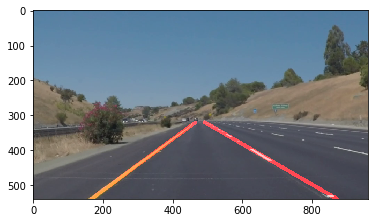

In [10]:
yellow_output = 'yellow3.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

x3 = 473
y3 =540
x4 =811
y4 =320
x1_list[253 504 286 500 422 518 281 438 512 535 498 520 498 528 256 355 333 354
 467 490]
y1_list[686 517 682 527 584 515 685 571 512 499 522 508 530 509 685 618 600 590
 541 527]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.650570532081
b_avg = 847.793617199
slope_left = [-0.67330677 -0.72429907 -0.71875    -0.72611465 -0.56521739 -0.63636364
 -0.7        -0.67676768 -0.47619048 -0.60869565]
slope_right [ 0.62025316  0.5739645   0.57575758  0.36363636  0.578125    0.66666667
  0.62222222  0.61842105  0.75862069  0.65        1.09090909  0.58490566
  0.6       ]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



  0%|                                                                                                                                                                                                              | 0/251 [00:00<?, ?it/s]

x3 = 473
y3 =540
x4 =811
y4 =320
x1_list[253 504 286 500 422 518 281 438 512 535 498 520 498 528 256 355 333 354
 467 490]
y1_list[686 517 682 527 584 515 685 571 512 499 522 508 530 509 685 618 600 590
 541 527]
x2_list[]
y2_list[]
num_points_left10
num_points_right13
a_avg = -0.650570532081
b_avg = 847.793617199
slope_left = [-0.67330677 -0.72429907 -0.71875    -0.72611465 -0.56521739 -0.63636364
 -0.7        -0.67676768 -0.47619048 -0.60869565]
slope_right [ 0.62025316  0.5739645   0.57575758  0.36363636  0.578125    0.66666667
  0.62222222  0.61842105  0.75862069  0.65        1.09090909  0.58490566
  0.6       ]



  0%|▊                                                                                                                                                                                                     | 1/251 [00:00<00:47,  5.29it/s]

x3 = 439
y3 =540
x4 =796
y4 =320
x1_list[280 417 282 485 355 509 255 506 276 301 482 595 278 302 311 333 279 302
 494 580 263 299 277 300 505 531 251 281 396 416 520 543]
y1_list[685 586 666 529 632 521 685 516 630 617 541 465 633 618 662 646 633 619
 532 474 525 514 629 616 518 501 528 519 602 587 509 494]
x2_list[]
y2_list[]
num_points_left16
num_points_right14
a_avg = -0.615396059233
b_avg = 810.465898568
slope_left = [-0.72262774 -0.67487685 -0.72077922 -0.67330677 -0.52       -0.67256637
 -0.625      -0.72727273 -0.60869565 -0.6744186  -0.30555556 -0.56521739
 -0.65384615 -0.3        -0.75       -0.65217391]
slope_right [ 0.62393162  0.57377049  0.57575758  0.63636364  0.61538462  0.34615385
  0.6         2.13333333  0.65217391  0.35714286  0.83870968  0.48571429
  0.57894737  0.64      ]



  1%|█▌                                                                                                                                                                                                    | 2/251 [00:00<00:48,  5.09it/s]

x3 = 451
y3 =540
x4 =803
y4 =320
x1_list[286 481 255 485 281 386 497 559 360 496 195 227 197 229 197 229 396 416
 440 485 419 439 325 380]
y1_list[682 541 685 530 685 609 524 483 629 531 676 659 680 660 679 659 490 484
 559 531 573 560 637 602]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.624376158902
b_avg = 821.775417205
slope_left = [-0.72307692 -0.67391304 -0.72380952 -0.66129032 -0.72058824 -0.53125
 -0.625      -0.625      -0.3        -0.62222222 -0.65       -0.63636364]
slope_right [ 0.61403509  0.57377049  0.6         0.66666667  0.60714286  0.30434783
  0.62264151  0.40740741  0.96969697]



  1%|██▎                                                                                                                                                                                                   | 3/251 [00:00<00:48,  5.14it/s]

x3 = 479
y3 =540
x4 =799
y4 =320
x1_list[295 383 282 455 256 481 517 600 469 556 447 544 343 448 490 568 404 529
 286 431 259 354]
y1_list[677 613 685 560 685 534 518 462 543 485 566 500 626 555 530 478 596 511
 683 578 684 620]
x2_list[]
y2_list[]
num_points_left11
num_points_right9
a_avg = -0.687580391671
b_avg = 869.596827244
slope_left = [-0.72727273 -0.72254335 -0.67111111 -0.6746988  -0.66666667 -0.68041237
 -0.67619048 -0.66666667 -0.68       -0.72413793 -0.67368421]
slope_right [ 0.65517241  0.51428571  0.68181818  0.60606061  0.58064516  0.68        1.5
  0.32        0.40909091]



  2%|███▏                                                                                                                                                                                                  | 4/251 [00:00<00:45,  5.37it/s]

x3 = 481
y3 =540
x4 =793
y4 =320
x1_list[258 465 509 621 383 511 424 531 517 606 306 429 292 357 370 404 332 379
 456 479 481 515 291 330 392 420]
y1_list[685 546 517 447 612 525 583 510 519 459 652 569 681 631 623 597 651 615
 553 537 536 514 681 651 607 586]
x2_list[]
y2_list[]
num_points_left13
num_points_right12
a_avg = -0.705324460892
b_avg = 879.762895879
slope_left = [-0.67149758 -0.625      -0.6796875  -0.68224299 -0.6741573  -0.67479675
 -0.76923077 -0.76470588 -0.76595745 -0.69565217 -0.64705882 -0.76923077
 -0.75      ]
slope_right [ 0.65714286  0.74193548  0.44117647  0.72727273  0.625       1.33333333
  0.5         0.62857143  0.32352941  0.61290323  0.66666667  1.84210526]



  2%|███▉                                                                                                                                                                                                  | 5/251 [00:00<00:49,  5.01it/s]

x3 = 481
y3 =540
x4 =796
y4 =320
x1_list[427 588 457 571 258 434 340 439 398 468 286 393 387 554 297 361 431 553]
y1_list[574 466 564 482 686 568 646 575 605 555 684 607 600 488 659 616 582 494]
x2_list[]
y2_list[]
num_points_left9
num_points_right8
a_avg = -0.697276555801
b_avg = 875.64525966
slope_left = [-0.67080745 -0.71929825 -0.67045455 -0.71717172 -0.71428571 -0.71962617
 -0.67065868 -0.671875   -0.72131148]
slope_right [ 0.675       0.57142857  0.32075472  0.65517241  0.38461538  0.65
  0.61764706  1.61538462]



  2%|████▋                                                                                                                                                                                                 | 6/251 [00:01<00:52,  4.70it/s]

x3 = 482
y3 =540
x4 =794
y4 =320
x1_list[303 589 404 573 291 410 356 452 261 367 287 344 262 417 500 524]
y1_list[657 465 602 480 682 596 636 567 684 613 684 643 684 580 532 514]
x2_list[]
y2_list[]
num_points_left8
num_points_right10
a_avg = -0.705592318298
b_avg = 880.414558046
slope_left = [-0.67132867 -0.72189349 -0.72268908 -0.71875    -0.66981132 -0.71929825
 -0.67096774 -0.75      ]
slope_right [ 0.61538462  0.57142857  0.77419355  0.72413793  0.47058824  0.75
  0.61538462  0.63636364  0.62068966  0.76190476]



  3%|█████▌                                                                                                                                                                                                | 7/251 [00:01<00:50,  4.85it/s]

x3 = 452
y3 =540
x4 =797
y4 =320
x1_list[263 494 295 573 496 559 319 454 479 521 371 499 290 383 186 216]
y1_list[685 529 681 480 526 486 648 557 538 511 627 534 684 617 550 541]
x2_list[]
y2_list[]
num_points_left8
num_points_right11
a_avg = -0.63714883968
b_avg = 828.222387032
slope_left = [-0.67532468 -0.72302158 -0.63492063 -0.67407407 -0.64285714 -0.7265625
 -0.72043011 -0.3       ]
slope_right [ 0.62295082  0.61666667  0.88        0.46875     0.92307692  0.52173913
  0.9047619   0.83333333  0.575       0.60869565  0.69230769]



  3%|██████▎                                                                                                                                                                                               | 8/251 [00:01<00:47,  5.08it/s]

x3 = 485
y3 =540
x4 =800
y4 =320
x1_list[403 582 430 584 266 435 266 404 299 449 460 530 416 597 308 336 390 416]
y1_list[604 474 572 468 684 570 685 592 680 571 561 510 582 460 672 653 615 596]
x2_list[]
y2_list[]
num_points_left9
num_points_right9
a_avg = -0.698740313201
b_avg = 879.470931545
slope_left = [-0.72625698 -0.67532468 -0.67455621 -0.67391304 -0.72666667 -0.72857143
 -0.67403315 -0.67857143 -0.73076923]
slope_right [ 0.62337662  0.67567568  0.62162162  0.63235294  0.625       0.96969697
  1.92307692  0.35        0.62162162]



  4%|███████                                                                                                                                                                                               | 9/251 [00:01<00:48,  4.97it/s]

x3 = 462
y3 =540
x4 =793
y4 =320
x1_list[392 590 414 575 438 580 274 323 394 601 319 428 298 398 303 373 347 405
 365 416 358 387 368 390 271 301 385 409]
y1_list[613 469 596 479 567 471 683 648 598 458 667 587 683 610 663 613 506 488
 501 485 625 603 618 601 684 663 606 588]
x2_list[]
y2_list[]
num_points_left14
num_points_right14
a_avg = -0.664592878937
b_avg = 847.178780059
slope_left = [-0.72727273 -0.72670807 -0.67605634 -0.71428571 -0.6763285  -0.73394495
 -0.73       -0.71428571 -0.31034483 -0.31372549 -0.75862069 -0.77272727
 -0.7        -0.75      ]
slope_right [ 0.63157895  0.6185567   0.56        0.45454545  0.62105263  0.9
  0.66666667  0.4         0.64102564  0.90909091  0.6         0.55555556
  0.7         0.56      ]



  4%|███████▊                                                                                                                                                                                             | 10/251 [00:02<00:49,  4.84it/s]

x3 = 481
y3 =540
x4 =811
y4 =320
x1_list[273 329 425 597 394 588 394 544 300 361 360 423 338 403 331 392 503 539
 300 354 514 584]
y1_list[685 647 577 461 612 471 599 497 684 639 623 580 655 607 644 602 463 452
 666 629 525 474]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.666030641404
b_avg = 860.73286939
slope_left = [-0.67857143 -0.6744186  -0.72680412 -0.68       -0.73770492 -0.68253968
 -0.73846154 -0.68852459 -0.30555556 -0.68518519 -0.72857143]
slope_right [ 0.62096774  0.58536585  0.58241758  0.58536585  0.34615385  0.72093023
  0.62686567  0.90322581  0.34375     0.62650602  0.38095238  0.59259259
  0.56521739]



  4%|████████▋                                                                                                                                                                                            | 11/251 [00:02<00:48,  4.95it/s]

x3 = 484
y3 =540
x4 =791
y4 =320
x1_list[392 514 396 590 414 575 274 388 331 411 300 360 318 393 374 394 506 531
 286 307 423 541]
y1_list[600 517 610 469 596 479 685 603 659 600 683 639 669 614 614 599 521 505
 676 660 578 498]
x2_list[]
y2_list[]
num_points_left11
num_points_right14
a_avg = -0.717015985725
b_avg = 887.259538162
slope_left = [-0.68032787 -0.72680412 -0.72670807 -0.71929825 -0.7375     -0.73333333
 -0.73333333 -0.75       -0.64       -0.76190476 -0.6779661 ]
slope_right [ 0.58241758  0.625       0.58024691  0.35714286  0.55        0.32        0.3
  0.54761905  0.69230769  0.51612903  3.5         0.62275449  0.56        2.        ]



  5%|█████████▍                                                                                                                                                                                           | 12/251 [00:02<00:46,  5.12it/s]

x3 = 481
y3 =540
x4 =799
y4 =320
x1_list[469 550 405 591 278 389 370 403 299 333 296 367 413 480 368 445 484 517
 360 380 387 429 369 517 283 307 500 552]
y1_list[548 490 603 468 682 602 629 606 684 659 685 633 587 539 618 563 467 457
 637 623 618 586 630 522 678 660 525 490]
x2_list[]
y2_list[]
num_points_left14
num_points_right17
a_avg = -0.691120005596
b_avg = 872.741442305
slope_left = [-0.71604938 -0.72580645 -0.72072072 -0.6969697  -0.73529412 -0.73239437
 -0.71641791 -0.71428571 -0.3030303  -0.7        -0.76190476 -0.72972973
 -0.75       -0.67307692]
slope_right [ 0.61904762  0.62416107  0.57407407  0.35714286  0.61682243  0.54166667
  0.61904762  0.55263158  0.65217391  0.91666667  0.55555556  0.54545455
  0.59259259  0.62        0.72727273  0.32        0.38095238]



  5%|██████████▏                                                                                                                                                                                          | 13/251 [00:02<00:44,  5.31it/s]

x3 = 455
y3 =540
x4 =772
y4 =320
x1_list[332 388 272 329 399 491 359 420 359 444 512 536 387 443 460 482 296 319
 273 355 475 502 219 261 493 592 271 294 303 365 496 523 486 585 191 230
 436 467]
y1_list[659 616 685 644 595 532 639 592 623 565 517 499 618 575 564 546 685 667
 685 626 553 531 542 529 529 462 641 627 681 633 537 515 543 471 550 538
 569 548]
x2_list[]
y2_list[]
num_points_left19
num_points_right15
a_avg = -0.693375647354
b_avg = 855.883380705
slope_left = [-0.76785714 -0.71929825 -0.68478261 -0.7704918  -0.68235294 -0.75
 -0.76785714 -0.81818182 -0.7826087  -0.7195122  -0.81481481 -0.30952381
 -0.67676768 -0.60869565 -0.77419355 -0.81481481 -0.72727273 -0.30769231
 -0.67741935]
slope_right [ 0.61956522  0.56976744  0.66666667  0.57657658  0.57692308  0.57692308
  0.79310345  0.66666667  0.46153846  0.625       0.65517241  0.51515152
  0.6         0.64285714  0.76190476]



  6%|██████████▉                                                                                                                                                                                          | 14/251 [00:02<00:43,  5.50it/s]

x3 = 488
y3 =540
x4 =815
y4 =320
x1_list[292 365 475 601 450 470 367 452 365 470 473 590 297 371 196 218 506 565
 325 354 315 412 461 505 456 483 503 583 362 385 326 355 353 375 324 356
 394 463]
y1_list[670 620 541 456 559 546 617 559 633 556 552 467 684 630 683 671 527 484
 683 665 670 599 551 521 565 546 521 467 621 606 681 663 627 613 683 663
 598 551]
x2_list[]
y2_list[]
num_points_left19
num_points_right12
a_avg = -0.672856391864
b_avg = 868.871120664
slope_left = [-0.68493151 -0.67460317 -0.65       -0.68235294 -0.73333333 -0.72649573
 -0.72972973 -0.54545455 -0.72881356 -0.62068966 -0.73195876 -0.68181818
 -0.7037037  -0.675      -0.65217391 -0.62068966 -0.63636364 -0.625
 -0.68115942]
slope_right [ 0.5862069   0.48484848  0.61904762  0.62162162  0.5483871   0.57142857
  0.48484848  0.83870968  1.09677419  0.63636364  0.66666667  0.62857143]



  6%|███████████▊                                                                                                                                                                                         | 15/251 [00:02<00:42,  5.56it/s]

x3 = 481
y3 =540
x4 =775
y4 =320
x1_list[373 520 490 578 275 374 324 394 396 493 299 351 505 526 406 512 356 430
 457 483 332 465 515 539 475 497 515 535 274 327]
y1_list[615 509 539 475 684 613 666 612 612 537 684 644 521 505 592 515 642 585
 566 545 644 548 514 497 552 534 521 507 684 646]
x2_list[]
y2_list[]
num_points_left15
num_points_right9
a_avg = -0.747398088389
b_avg = 899.623372273
slope_left = [-0.72108844 -0.72727273 -0.71717172 -0.77142857 -0.77319588 -0.76923077
 -0.76190476 -0.72641509 -0.77027027 -0.80769231 -0.72180451 -0.70833333
 -0.81818182 -0.7        -0.71698113]
slope_right [ 0.58823529  0.61290323  0.51851852  0.5625      0.95        0.46875     1.
  1.03125     4.        ]



  6%|████████████▌                                                                                                                                                                                        | 16/251 [00:03<00:44,  5.25it/s]

x3 = 459
y3 =540
x4 =778
y4 =320
x1_list[447 613 308 392 281 483 475 595 395 453 477 583 493 582 442 491 382 431
 310 331 379 411 439 459 286 307 438 479 353 426 318 364 309 332]
y1_list[571 450 678 613 680 534 540 459 611 568 548 471 527 467 564 530 621 585
 676 659 380 363 481 475 676 660 578 548 629 576 669 635 659 644]
x2_list[]
y2_list[]
num_points_left17
num_points_right12
a_avg = -0.689572837288
b_avg = 856.931018824
slope_left = [-0.72891566 -0.77380952 -0.72277228 -0.675      -0.74137931 -0.72641509
 -0.6741573  -0.69387755 -0.73469388 -0.80952381 -0.53125    -0.3
 -0.76190476 -0.73170732 -0.7260274  -0.73913043 -0.65217391]
slope_right [ 0.575       0.36363636  0.57894737  0.42307692  0.45454545  0.76190476
  0.9047619   0.84        0.48387097  1.23529412  1.42857143  0.59259259]



  7%|█████████████▎                                                                                                                                                                                       | 17/251 [00:03<00:49,  4.75it/s]

x3 = 481
y3 =540
x4 =777
y4 =320
x1_list[276 478 341 493 290 504 499 544 483 579 277 328 304 424 468 583 302 352
 483 507]
y1_list[684 538 654 536 675 520 525 493 544 474 683 646 682 589 556 472 683 644
 536 518]
x2_list[]
y2_list[]
num_points_left10
num_points_right11
a_avg = -0.742458988859
b_avg = 897.545070265
slope_left = [-0.72277228 -0.77631579 -0.72429907 -0.71111111 -0.72916667 -0.7254902
 -0.775      -0.73043478 -0.78       -0.75      ]
slope_right [ 0.5625      0.58823529  0.88888889  0.85714286  0.60869565  0.52
  0.70833333  0.57777778  0.51724138  0.44444444  0.9       ]



  7%|██████████████▏                                                                                                                                                                                      | 18/251 [00:03<00:51,  4.57it/s]

x3 = 408
y3 =540
x4 =779
y4 =320
x1_list[306 481 276 471 280 508 302 426 466 587 483 542 190 225 246 276 485 573
 343 373 208 247 453 506]
y1_list[681 545 684 543 682 517 683 587 557 469 536 494 547 536 531 522 542 478
 508 499 542 530 567 528]
x2_list[]
y2_list[]
num_points_left12
num_points_right13
a_avg = -0.593527873253
b_avg = 782.508231203
slope_left = [-0.77714286 -0.72307692 -0.72368421 -0.77419355 -0.72727273 -0.71186441
 -0.31428571 -0.3        -0.72727273 -0.3        -0.30769231 -0.73584906]
slope_right [ 0.61111111  0.58974359  0.36666667  0.54545455  0.46666667  0.42307692
  0.6         1.10344828  0.51612903  0.95652174  0.57777778  0.45454545
  0.54545455]



  8%|██████████████▉                                                                                                                                                                                      | 19/251 [00:03<00:49,  4.73it/s]

x3 = 486
y3 =540
x4 =792
y4 =320
x1_list[277 490 422 591 471 577 345 403 401 469 322 376 520 546 301 328 275 430
 475 499 502 530 299 354 367 432]
y1_list[684 530 590 467 553 476 649 606 606 556 667 627 510 493 684 664 684 572
 542 524 522 504 684 644 632 584]
x2_list[]
y2_list[]
num_points_left13
num_points_right10
a_avg = -0.720800273626
b_avg = 890.898515744
slope_left = [-0.72300469 -0.72781065 -0.72641509 -0.74137931 -0.73529412 -0.74074074
 -0.65384615 -0.74074074 -0.72258065 -0.75       -0.64285714 -0.72727273
 -0.73846154]
slope_right [ 0.58208955  0.61904762  0.55263158  0.58823529  0.34615385  1.09090909
  1.11538462  0.30434783  0.96428571  0.62711864]



  8%|███████████████▋                                                                                                                                                                                     | 20/251 [00:04<00:47,  4.90it/s]

x3 = 482
y3 =540
x4 =780
y4 =320
x1_list[277 479 303 451 475 581 274 415 301 401 503 562 389 482 472 531 467 591]
y1_list[684 538 683 568 550 473 685 583 684 606 523 481 617 545 544 502 557 467]
x2_list[]
y2_list[]
num_points_left9
num_points_right12
a_avg = -0.739260829719
b_avg = 897.014025906
slope_left = [-0.72277228 -0.77702703 -0.72641509 -0.72340426 -0.78       -0.71186441
 -0.77419355 -0.71186441 -0.72580645]
slope_right [ 0.58536585  0.57142857  0.97142857  0.58064516  0.58823529  0.9047619
  0.9         0.58823529  0.57692308  1.57142857  0.97058824  0.575     ]



  8%|████████████████▍                                                                                                                                                                                    | 21/251 [00:04<00:45,  5.05it/s]

x3 = 456
y3 =540
x4 =779
y4 =320
x1_list[275 447 434 588 390 506 500 577 460 583 421 500 298 354 339 404 372 399
 512 576 514 569 389 439 301 328 335 358 286 374 399 438]
y1_list[683 559 580 468 613 528 531 475 550 467 578 524 683 642 652 604 381 366
 514 471 520 480 602 566 682 662 655 639 675 611 493 481]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.680202561726
b_avg = 850.446493857
slope_left = [-0.72093023 -0.72727273 -0.73275862 -0.72727273 -0.67479675 -0.6835443
 -0.73214286 -0.73846154 -0.55555556 -0.671875   -0.72727273 -0.72
 -0.74074074 -0.69565217 -0.72727273 -0.30769231]
slope_right [ 0.57        0.58695652  0.375       0.58        0.57692308  0.81818182
  1.02564103  0.66666667  0.33333333  0.58064516  0.65517241]



  9%|█████████████████▎                                                                                                                                                                                   | 22/251 [00:04<00:43,  5.25it/s]

x3 = 466
y3 =540
x4 =782
y4 =320
x1_list[277 424 430 584 413 510 299 379 356 459 483 584 274 365 504 570 383 492
 234 257 310 358 439 527 464 549]
y1_list[682 576 583 471 596 525 684 622 626 552 535 467 684 618 528 480 619 539
 535 528 676 639 567 504 550 489]
x2_list[]
y2_list[]
num_points_left13
num_points_right19
a_avg = -0.695558736157
b_avg = 864.134669186
slope_left = [-0.72108844 -0.72727273 -0.73195876 -0.775      -0.7184466  -0.67326733
 -0.72527473 -0.72727273 -0.73394495 -0.30434783 -0.77083333 -0.71590909
 -0.71764706]
slope_right [ 0.57142857  0.62204724  0.57692308  0.57692308  0.61666667  0.83333333
  2.66666667  0.78        0.51724138  0.575       0.5         0.84615385
  0.47826087  0.57692308  1.64285714  0.35897436  1.20512821  1.64705882
  0.85      ]



  9%|██████████████████                                                                                                                                                                                   | 23/251 [00:04<00:49,  4.63it/s]

x3 = 464
y3 =540
x4 =784
y4 =320
x1_list[381 483 274 410 466 528 481 579 415 525 329 356 497 556 275 384 363 383
 372 464 392 485 229 250]
y1_list[620 545 684 586 557 511 545 474 584 505 660 641 526 484 683 604 634 620
 627 560 600 533 537 530]
x2_list[]
y2_list[]
num_points_left12
num_points_right16
a_avg = -0.688571042835
b_avg = 860.002698605
slope_left = [-0.73529412 -0.72058824 -0.74193548 -0.7244898  -0.71818182 -0.7037037
 -0.71186441 -0.72477064 -0.7        -0.72826087 -0.72043011 -0.33333333]
slope_right [ 0.65        0.61904762  0.59090909  0.57386364  0.58823529  0.36585366
  1.          0.33333333  0.65517241  0.325       0.52173913  0.65714286
  0.65517241  0.62        0.64        0.6744186 ]



 10%|██████████████████▊                                                                                                                                                                                  | 24/251 [00:04<00:49,  4.61it/s]

x3 = 421
y3 =540
x4 =592
y4 =320
x1_list[273 387 325 438 398 534 460 577 366 453 450 500 490 567 339 400 275 341
 308 376 199 229 461 539 436 459 306 332 430 432 413 443 383 403]
y1_list[684 602 662 579 596 498 560 475 631 567 568 531 537 481 637 593 682 634
 675 625 548 539 549 496 428 407 677 658 382 361 585 562 606 591]
x2_list[]
y2_list[]
num_points_left17
num_points_right13
a_avg = -1.28986148638
b_avg = 1083.81417901
slope_left = [ -0.71929825  -0.73451327  -0.72058824  -0.72649573  -0.73563218  -0.74
  -0.72727273  -0.72131148  -0.72727273  -0.73529412  -0.3         -0.67948718
  -0.91304348  -0.73076923 -10.5         -0.76666667  -0.75      ]
slope_right [ 0.61788618  0.57324841  0.62195122  0.61290323  0.32432432  0.60869565
  0.41176471  0.89655172  0.62711864  0.75        0.39473684  0.57615894
  0.57894737]



 10%|███████████████████▌                                                                                                                                                                                 | 25/251 [00:05<00:55,  4.05it/s]

x3 = 475
y3 =540
x4 =781
y4 =320
x1_list[514 593 344 524 253 277 366 513 274 356 297 367 311 464 357 486 483 516
 462 540 303 377 273 323]
y1_list[519 466 635 505 644 631 634 520 684 625 684 633 658 547 640 540 535 511
 560 500 681 624 684 648]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.72048554616
b_avg = 882.753247372
slope_left = [-0.67088608 -0.72222222 -0.54166667 -0.7755102  -0.7195122  -0.72857143
 -0.7254902  -0.7751938  -0.72727273 -0.76923077 -0.77027027 -0.72      ]
slope_right [ 0.56862745  0.61333333  0.57303371  0.62222222  0.76190476  0.34210526
  0.53571429  0.61904762  0.6       ]



 10%|████████████████████▍                                                                                                                                                                                | 26/251 [00:05<00:54,  4.16it/s]

x3 = 440
y3 =540
x4 =742
y4 =320
x1_list[275 495 303 474 476 540 472 537 508 550 459 486 332 473 470 498 516 541
 190 210 434 456 303 334]
y1_list[683 524 681 548 539 493 551 501 524 492 561 539 659 549 543 522 511 493
 547 541 423 404 680 656]
x2_list[]
y2_list[]
num_points_left12
num_points_right9
a_avg = -0.729431429371
b_avg = 861.655514629
slope_left = [-0.72272727 -0.77777778 -0.71875    -0.76923077 -0.76190476 -0.81481481
 -0.78014184 -0.75       -0.72       -0.3        -0.86363636 -0.77419355]
slope_right [ 0.30434783  0.62068966  0.73076923  0.4893617   2.5         0.68181818
  0.72        0.47826087  0.61538462]



 11%|█████████████████████▏                                                                                                                                                                               | 27/251 [00:05<00:49,  4.49it/s]

x3 = 480
y3 =540
x4 =782
y4 =320
x1_list[274 485 298 437 475 555 508 593 423 477 272 427 491 517 446 563 456 484
 441 504 388 414 487 507 413 444 325 379]
y1_list[684 531 684 576 547 489 515 462 587 547 684 572 527 510 569 484 553 532
 573 527 615 594 531 516 595 572 662 622]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.729629774368
b_avg = 890.685249594
slope_left = [-0.72511848 -0.77697842 -0.725      -0.62352941 -0.74074074 -0.72258065
 -0.65384615 -0.72649573 -0.75       -0.73015873 -0.80769231 -0.75
 -0.74193548 -0.74074074]
slope_right [ 0.31666667  0.67741935  0.3         0.69565217  0.34146341  0.72413793
  0.4375      0.4         0.68181818  0.83333333]



 11%|█████████████████████▉                                                                                                                                                                               | 28/251 [00:05<00:49,  4.52it/s]

x3 = 434
y3 =540
x4 =779
y4 =320
x1_list[423 449 296 417 505 585 271 420 501 594 218 281 188 260 363 478 326 495
 518 579 267 306 473 497 447 525 499 538 463 523 270 302]
y1_list[574 557 684 590 524 470 684 576 519 461 540 520 549 526 633 544 645 523
 507 469 525 513 540 522 569 509 530 500 547 504 684 662]
x2_list[]
y2_list[]
num_points_left16
num_points_right11
a_avg = -0.638136025983
b_avg = 817.188314757
slope_left = [-0.65384615 -0.7768595  -0.675      -0.72483221 -0.62365591 -0.31746032
 -0.31944444 -0.77391304 -0.72189349 -0.62295082 -0.30769231 -0.75
 -0.76923077 -0.76923077 -0.71666667 -0.6875    ]
slope_right [ 0.65714286  0.32        0.84615385  0.84        0.65714286  0.63636364
  0.32142857  5.75        0.65217391  0.60869565  0.61538462]



 12%|██████████████████████▊                                                                                                                                                                              | 29/251 [00:06<00:48,  4.61it/s]

x3 = 477
y3 =540
x4 =780
y4 =320
x1_list[353 429 433 507 273 431 418 553 295 375 269 352 463 533 434 560 409 430
 318 355 458 510 386 476]
y1_list[638 582 568 515 682 568 589 491 682 623 684 624 555 504 566 481 585 569
 666 637 549 514 613 547]
x2_list[]
y2_list[]
num_points_left12
num_points_right11
a_avg = -0.726347350524
b_avg = 886.886845168
slope_left = [-0.73684211 -0.71621622 -0.72151899 -0.72592593 -0.7375     -0.72289157
 -0.72857143 -0.67460317 -0.76190476 -0.78378378 -0.67307692 -0.73333333]
slope_right [ 0.8         0.62222222  0.61363636  0.35897436  0.3         0.42857143
  0.375       0.79310345  0.35714286  0.6097561   0.61111111]



 12%|███████████████████████▌                                                                                                                                                                             | 30/251 [00:06<00:48,  4.56it/s]

x3 = 476
y3 =540
x4 =781
y4 =320
x1_list[399 546 308 384 479 550 268 391 353 478 349 440 459 525 350 387 443 503
 380 408]
y1_list[603 496 672 616 534 489 685 596 625 535 641 574 558 510 627 599 561 518
 605 584]
x2_list[]
y2_list[]
num_points_left10
num_points_right12
a_avg = -0.722907320136
b_avg = 884.621074457
slope_left = [-0.72789116 -0.73684211 -0.63380282 -0.72357724 -0.72       -0.73626374
 -0.72727273 -0.75675676 -0.71666667 -0.75      ]
slope_right [ 0.61111111  0.66666667  0.32258065  0.74193548  0.72        0.31818182
  0.51724138  0.6         0.625       1.0952381   0.65625     0.55      ]



 12%|████████████████████████▎                                                                                                                                                                            | 31/251 [00:06<00:48,  4.54it/s]

x3 = 481
y3 =540
x4 =797
y4 =320
x1_list[357 458 475 587 289 366 469 577 356 466 270 385 499 576 460 502 344 367
 291 325 389 474 266 351 439 459 363 383 470 498 332 352]
y1_list[633 559 536 466 684 628 549 476 621 542 682 599 520 472 556 527 643 627
 684 659 598 537 684 623 572 558 629 615 540 522 652 638]
x2_list[]
y2_list[]
num_points_left16
num_points_right12
a_avg = -0.695233952191
b_avg = 874.436388303
slope_left = [-0.73267327 -0.625      -0.72727273 -0.67592593 -0.71818182 -0.72173913
 -0.62337662 -0.69047619 -0.69565217 -0.73529412 -0.71764706 -0.71764706
 -0.7        -0.7        -0.64285714 -0.7       ]
slope_right [ 0.63461538  0.57746479  0.58333333  0.46875     1.375       0.625
  0.57894737  1.1         0.54545455  1.09677419  1.57142857  2.42857143]



 13%|█████████████████████████                                                                                                                                                                            | 32/251 [00:06<00:44,  4.91it/s]

x3 = 477
y3 =540
x4 =784
y4 =320
x1_list[313 424 286 408 476 569 487 580 265 332 350 453 443 501 430 456 422 481
 394 415 405 426 280 369 320 340 455 483 298 321]
y1_list[651 571 685 596 544 481 528 470 684 636 625 551 568 528 578 560 574 532
 606 589 598 581 674 610 661 647 551 531 677 661]
x2_list[]
y2_list[]
num_points_left15
num_points_right14
a_avg = -0.715205506733
b_avg = 881.373435734
slope_left = [-0.72072072 -0.7295082  -0.67741935 -0.62365591 -0.71641791 -0.7184466
 -0.68965517 -0.69230769 -0.71186441 -0.80952381 -0.80952381 -0.71910112
 -0.7        -0.71428571 -0.69565217]
slope_right [ 0.67307692  0.6         0.58181818  0.65957447  0.578125    0.65909091
  0.39473684  0.57692308  0.39473684  1.03225806  0.7804878   0.775
  0.79310345  0.65517241]



 13%|█████████████████████████▉                                                                                                                                                                           | 33/251 [00:06<00:43,  4.96it/s]

x3 = 480
y3 =540
x4 =795
y4 =320
x1_list[497 556 359 552 321 401 386 499 262 309 393 528 283 347 288 310 361 536
 345 401 312 342 290 323]
y1_list[531 489 616 486 659 600 610 528 685 653 592 501 670 626 684 669 629 502
 626 588 666 645 682 659]
x2_list[]
y2_list[]
num_points_left12
num_points_right14
a_avg = -0.697841832009
b_avg = 875.273421659
slope_left = [-0.71186441 -0.67357513 -0.7375     -0.72566372 -0.68085106 -0.67407407
 -0.6875     -0.68181818 -0.72571429 -0.67857143 -0.7        -0.6969697 ]
slope_right [ 0.61797753  0.625       0.61538462  0.6         0.62352941  0.6
  0.32142857  0.61702128  0.3125      0.8         0.7826087   0.30555556
  0.33333333  0.62162162]



 14%|██████████████████████████▋                                                                                                                                                                          | 34/251 [00:07<00:43,  5.04it/s]

x3 = 406
y3 =540
x4 =785
y4 =320
x1_list[305 499 520 607 323 541 360 473 229 259 238 270 261 321 287 362 286 374
 206 227 192 218 513 551 360 523]
y1_list[670 529 514 460 641 494 629 547 534 525 532 522 685 644 684 629 667 607
 541 534 545 536 521 493 615 505]
x2_list[]
y2_list[]
num_points_left13
num_points_right15
a_avg = -0.580740783177
b_avg = 776.324459594
slope_left = [-0.72680412 -0.62068966 -0.67431193 -0.72566372 -0.3        -0.3125
 -0.68333333 -0.73333333 -0.68181818 -0.33333333 -0.34615385 -0.73684211
 -0.67484663]
slope_right [ 0.62043796  0.58252427  0.625       0.58        0.33333333  0.90909091
  1.13043478  0.91891892  0.4375      0.575       0.35        0.35
  0.57692308  0.62393162  0.8       ]



 14%|███████████████████████████▍                                                                                                                                                                         | 35/251 [00:07<00:41,  5.19it/s]

x3 = 474
y3 =540
x4 =789
y4 =320
x1_list[299 464 431 545 446 538 376 462 260 325 306 369 287 310 495 547 502 534
 409 443 462 496 371 403 291 314]
y1_list[674 554 568 492 568 502 604 546 686 639 654 609 683 667 534 496 519 500
 583 559 547 523 609 586 664 648]
x2_list[]
y2_list[]
num_points_left13
num_points_right23
a_avg = -0.697650017291
b_avg = 871.036507089
slope_left = [-0.72727273 -0.66666667 -0.7173913  -0.6744186  -0.72307692 -0.71428571
 -0.69565217 -0.73076923 -0.59375    -0.70588235 -0.70588235 -0.71875
 -0.69565217]
slope_right [ 0.57763975  0.62096774  0.57692308  0.62804878  0.46153846  0.46875
  0.47368421  0.52941176  0.59090909  0.48148148  0.90909091  0.6
  0.78378378  0.65        1.47058824  0.61904762  0.45        0.61904762
  0.58730159  0.62711864  1.66666667  0.68        0.58333333]



 14%|████████████████████████████▎                                                                                                                                                                        | 36/251 [00:07<00:40,  5.30it/s]

x3 = 471
y3 =540
x4 =809
y4 =320
x1_list[274 526 283 349 408 484 257 337 486 572 329 437 355 406 403 423 304 325
 308 331 335 374 307 328 519 618 284 313 438 485]
y1_list[673 503 685 637 593 541 685 631 538 480 635 562 631 596 597 584 611 601
 613 600 646 619 613 601 508 451 684 662 572 540]
x2_list[]
y2_list[]
num_points_left15
num_points_right18
a_avg = -0.651205261936
b_avg = 847.365231107
slope_left = [-0.67460317 -0.72727273 -0.68421053 -0.675      -0.6744186  -0.67592593
 -0.68627451 -0.65       -0.47619048 -0.56521739 -0.69230769 -0.57142857
 -0.57575758 -0.75862069 -0.68085106]
slope_right [ 0.58064516  0.62307692  0.56521739  0.62711864  0.58333333  0.4
  0.56521739  0.35483871  0.35        0.45        0.61764706  0.89285714
  0.33333333  0.96774194  0.57857143  0.42424242  1.26086957  0.57692308]



 15%|█████████████████████████████                                                                                                                                                                        | 37/251 [00:07<00:43,  4.87it/s]

x3 = 459
y3 =540
x4 =783
y4 =320
x1_list[398 527 255 515 286 449 283 386 257 455 237 263 234 259 454 482]
y1_list[602 509 685 510 682 564 683 609 685 551 652 638 650 636 563 540]
x2_list[]
y2_list[]
num_points_left8
num_points_right14
a_avg = -0.679129740575
b_avg = 852.128447126
slope_left = [-0.72093023 -0.67307692 -0.72392638 -0.7184466  -0.67676768 -0.53846154
 -0.56       -0.82142857]
slope_right [ 0.57777778  0.61538462  0.58823529  0.58461538  0.53571429  0.57894737
  0.69565217  2.1         0.30434783  0.35        0.61904762  0.58333333
  0.60869565  0.64285714]



 15%|█████████████████████████████▊                                                                                                                                                                       | 38/251 [00:07<00:44,  4.75it/s]

x3 = 443
y3 =540
x4 =773
y4 =320
x1_list[510 612 256 413 283 419 395 502 282 361 331 515 207 252 490 510 456 481
 485 532 199 237 431 453 388 414 425 445]
y1_list[520 456 685 579 684 586 590 518 684 627 650 517 540 526 527 513 559 540
 537 507 542 530 580 560 595 578 584 566]
x2_list[]
y2_list[]
num_points_left14
num_points_right10
a_avg = -0.666326874428
b_avg = 835.529730394
slope_left = [-0.62745098 -0.67515924 -0.72058824 -0.6728972  -0.72151899 -0.72282609
 -0.31111111 -0.7        -0.76       -0.63829787 -0.31578947 -0.90909091
 -0.65384615 -0.9       ]
slope_right [ 0.56666667  0.6         0.3         0.85        0.59259259  0.64
  0.60714286  0.57142857  0.625       1.04545455]



 16%|██████████████████████████████▌                                                                                                                                                                      | 39/251 [00:08<00:44,  4.81it/s]

x3 = 479
y3 =540
x4 =787
y4 =320
x1_list[256 404 348 492 399 505 497 551 329 371 304 338 507 537 287 312 358 379
 365 399 488 508 314 353 404 473 259 330]
y1_list[685 585 622 525 601 524 522 490 652 620 670 644 524 503 682 663 631 615
 625 603 537 522 663 633 596 546 684 636]
x2_list[]
y2_list[]
num_points_left14
num_points_right7
a_avg = -0.713128106559
b_avg = 881.685602091
slope_left = [-0.67567568 -0.67361111 -0.72641509 -0.59259259 -0.76190476 -0.76470588
 -0.7        -0.76       -0.76190476 -0.64705882 -0.75       -0.76923077
 -0.72463768 -0.67605634]
slope_right [ 0.59375     0.33333333  0.61290323  0.3         0.85        0.60606061
  2.75      ]



 16%|███████████████████████████████▍                                                                                                                                                                     | 40/251 [00:08<00:42,  4.99it/s]

x3 = 472
y3 =540
x4 =797
y4 =320
x1_list[274 492 351 502 469 511 282 338 364 400 320 473 258 298 513 544 326 351
 423 586 257 356 339 367 404 432 379 400 451 480]
y1_list[673 526 636 527 542 514 685 644 625 600 641 538 685 658 418 405 656 638
 582 472 685 618 642 624 597 576 614 599 562 542]
x2_list[]
y2_list[]
num_points_left15
num_points_right15
a_avg = -0.675025998978
b_avg = 858.660347593
slope_left = [-0.67431193 -0.7218543  -0.66666667 -0.73214286 -0.69444444 -0.67320261
 -0.675      -0.41935484 -0.72       -0.67484663 -0.67676768 -0.64285714
 -0.75       -0.71428571 -0.68965517]
slope_right [ 0.6         0.57142857  0.96774194  0.51724138  0.85        0.61904762
  1.0952381   1.3         0.80952381  0.53846154  0.61904762  0.65217391
  0.6         0.82608696  0.45      ]



 16%|████████████████████████████████▏                                                                                                                                                                    | 41/251 [00:08<00:39,  5.26it/s]

x3 = 463
y3 =540
x4 =797
y4 =320
x1_list[284 479 426 550 496 538 290 342 261 321 455 503 340 360 281 440 328 373
 392 442 262 288 388 421 452 540]
y1_list[684 543 569 491 533 503 663 626 683 640 561 527 509 503 685 570 637 605
 592 560 682 663 595 574 552 497]
x2_list[]
y2_list[]
num_points_left13
num_points_right16
a_avg = -0.65918829042
b_avg = 845.720186426
slope_left = [-0.72307692 -0.62903226 -0.71428571 -0.71153846 -0.71666667 -0.70833333
 -0.3        -0.72327044 -0.71111111 -0.64       -0.73076923 -0.63636364
 -0.625     ]
slope_right [ 0.66666667  1.09090909  0.65853659  0.4         0.55        0.56        0.7
  0.6         0.82926829  1.04        0.95833333  0.38888889  1.11538462
  0.59375     0.6         0.85      ]



 17%|████████████████████████████████▉                                                                                                                                                                    | 42/251 [00:08<00:38,  5.37it/s]

x3 = 480
y3 =540
x4 =801
y4 =320
x1_list[283 459 257 304 254 440 476 604 513 571 259 473 281 409 400 474 472 521
 472 537 511 552]
y1_list[685 558 686 654 686 561 538 458 521 482 684 540 685 593 601 548 551 516
 541 500 524 495]
x2_list[]
y2_list[]
num_points_left11
num_points_right29
a_avg = -0.684739473407
b_avg = 868.807452512
slope_left = [-0.72159091 -0.68085106 -0.67204301 -0.625      -0.67241379 -0.6728972
 -0.71875    -0.71621622 -0.71428571 -0.63076923 -0.70731707]
slope_right [ 0.58333333  0.625       0.4         0.57575758  0.40625     0.59090909
  0.61904762  1.33333333  0.51428571  0.55        0.52941176  0.75        0.45
  0.79310345  0.45        0.65384615  0.5         0.52173913  2.42857143
  0.6         0.84848485  0.38461538  0.86956522  0.69230769  0.35
  3.66666667  2.22222222  0.57575758  0.61818182]



 17%|█████████████████████████████████▋                                                                                                                                                                   | 43/251 [00:08<00:40,  5.14it/s]

x3 = 479
y3 =540
x4 =793
y4 =320
x1_list[258 472 282 407 433 542 254 415 432 513 286 437 483 552 488 555 395 473
 485 509]
y1_list[685 541 685 595 568 495 686 578 579 521 683 574 535 489 540 492 605 549
 542 524]
x2_list[]
y2_list[]
num_points_left10
num_points_right19
a_avg = -0.702236640273
b_avg = 877.068465238
slope_left = [-0.6728972  -0.72       -0.66972477 -0.67080745 -0.71604938 -0.7218543
 -0.66666667 -0.71641791 -0.71794872 -0.75      ]
slope_right [ 0.62857143  0.57534247  0.58333333  0.89655172  0.95454545  0.34375
  0.85714286  0.36170213  0.59259259  0.30434783  0.56        0.37037037
  1.18918919  0.85714286  0.55        0.85714286  0.4375      0.62222222
  0.58333333]



 18%|██████████████████████████████████▌                                                                                                                                                                  | 44/251 [00:09<00:46,  4.46it/s]

x3 = 483
y3 =540
x4 =805
y4 =320
x1_list[369 495 258 431 476 599 311 429 516 602 283 386 504 545 513 593 359 455
 447 511 477 501]
y1_list[611 527 685 569 548 465 666 581 513 459 685 611 521 495 522 468 632 563
 569 525 540 523]
x2_list[]
y2_list[]
num_points_left11
num_points_right13
a_avg = -0.682036898398
b_avg = 869.690862568
slope_left = [-0.66666667 -0.67052023 -0.67479675 -0.72033898 -0.62790698 -0.7184466
 -0.63414634 -0.675      -0.71875    -0.6875     -0.70833333]
slope_right [ 0.56989247  0.57692308  0.57446809  0.58490566  0.34782609  0.33333333
  1.03333333  0.58064516  0.65517241  0.33333333  0.57142857  0.9047619
  0.53846154]



 18%|███████████████████████████████████▎                                                                                                                                                                 | 45/251 [00:09<00:46,  4.43it/s]

x3 = 447
y3 =540
x4 =649
y4 =320
x1_list[261 524 288 417 419 547 345 546 287 362 260 352 346 500 496 519 481 550
 512 516 504 530 283 332]
y1_list[685 508 684 591 591 499 629 494 684 630 685 623 643 532 431 408 547 497
 430 410 523 505 686 651]
x2_list[]
y2_list[]
num_points_left12
num_points_right17
a_avg = -1.08585409816
b_avg = 1025.40213762
slope_left = [-0.6730038  -0.72093023 -0.71875    -0.67164179 -0.72       -0.67391304
 -0.72077922 -1.         -0.72463768 -5.         -0.69230769 -0.71428571]
slope_right [ 0.5785124   0.62162162  0.4047619   0.53571429  0.61445783  0.4
  0.81818182  0.5625      0.57692308  0.65217391  0.57522124  0.625       0.6
  0.34782609  0.84782609  0.57894737  0.30434783]



 18%|████████████████████████████████████                                                                                                                                                                 | 46/251 [00:09<00:43,  4.70it/s]

x3 = 410
y3 =540
x4 =751
y4 =320
x1_list[263 569 291 511 445 563 262 526 286 312 461 486 455 490 462 483 289 383
 518 594 346 523]
y1_list[685 479 683 524 573 488 685 507 685 667 331 318 334 312 433 426 684 616
 519 468 644 516]
x2_list[]
y2_list[]
num_points_left11
num_points_right30
a_avg = -0.643849497938
b_avg = 804.142983109
slope_left = [-0.67320261 -0.72272727 -0.72033898 -0.67424242 -0.69230769 -0.52
 -0.62857143 -0.33333333 -0.72340426 -0.67105263 -0.72316384]
slope_right [ 0.57763975  0.57792208  0.62135922  0.57142857  0.61971831  0.56521739
  0.59090909  0.52173913  0.36363636  0.55        0.37931034  0.5
  0.42307692  0.31818182  0.34146341  1.39285714  0.40740741  0.65517241
  0.33333333  0.88461538  0.45        0.6         0.59259259  0.35897436
  0.45454545  0.57692308  0.57894737  1.          0.625       0.58064516]



 19%|████████████████████████████████████▉                                                                                                                                                                | 47/251 [00:09<00:41,  4.86it/s]

x3 = 387
y3 =540
x4 =652
y4 =320
x1_list[264 582 295 545 289 513 510 538 381 394 419 440 267 369]
y1_list[685 471 682 501 685 523 415 384 384 364 436 428 684 615]
x2_list[]
y2_list[]
num_points_left7
num_points_right24
a_avg = -0.83188537505
b_avg = 862.400545271
slope_left = [-0.67295597 -0.724      -0.72321429 -1.10714286 -1.53846154 -0.38095238
 -0.67647059]
slope_right [ 0.57225434  0.58536585  0.61363636  0.34782609  0.6119403   0.95833333
  0.33333333  0.64516129  0.60869565  0.57425743  0.9047619   0.6
  0.55555556  1.19047619  0.34210526  0.36842105  1.36842105  0.66666667
  0.41176471  0.325       0.64285714  0.95454545  0.6         0.65217391]



 19%|█████████████████████████████████████▋                                                                                                                                                               | 48/251 [00:09<00:40,  4.98it/s]

ValueError: cannot convert float NaN to integer

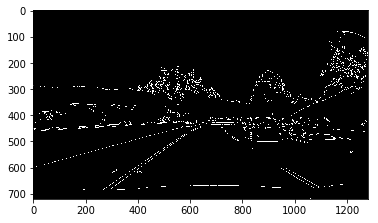

In [15]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))